In [8]:
!pip install torch transformers pandas scikit-learn tqdm textstat spacy

# Install and download all at once
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm
!python -m spacy download de_core_news_sm
!python -m spacy download es_core_news_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 134.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 12.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━

# RETRAIN

In [30]:
# =========================== EMC Full Training (All Models) ===========================
# Trains:
#  1) XLM-R only (Transformer baseline)
#  2) Simple Fusion (XLM-R + 12 engineered features, concat)
#  3) Gated Fusion  (XLM-R + 12 engineered features, gated injection)
#  4) XGBoost       (12 engineered features only)
#
# Features (12 total):
#  - Structural: char_count, word_count, sent_count
#  - Psycholinguistic (English-only): flesch_reading_ease, gunning_fog (else 0)
#  - Trust: eng_term_pct, punct_count, num_count, has_standard, has_safety
#  - Numeric: avg_num_mag, decimal_ratio
#
# Inputs expected:
#  - train/val/test CSVs with columns: content, label, lang
#  - engineering_terms.csv with columns: terms, count, lang  (NB: column is 'terms')
#
# Outputs:
#  - /.../xlmr_only_outputs/
#  - /.../simple_fusion_outputs/
#  - /.../gated_fusion_outputs/
#  - /.../xgb_outputs/
#
# --------------------------------------------------------------------------------------

import os, re, json, math, argparse, random
from dataclasses import dataclass
from typing import Dict, Any, Tuple, Optional

import numpy as np
import pandas as pd
from tqdm import tqdm

# Text stats (readability)
try:
    import textstat
    _HAS_TEXTSTAT = True
except Exception:
    _HAS_TEXTSTAT = False

# Torch / HF
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    XLMRobertaModel,
    XLMRobertaForSequenceClassification,
    XLMRobertaTokenizerFast,
    get_linear_schedule_with_warmup,
)
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import StandardScaler

# XGBoost
import xgboost as xgb

# ------------------------------- Config ---------------------------------------------

@dataclass
class Config:
    base_dir: str = "/content/drive/MyDrive/emc"
    train_csv: str = "/content/drive/MyDrive/emc/train.csv"
    val_csv: str   = "/content/drive/MyDrive/emc/val.csv"
    test_csv: str  = "/content/drive/MyDrive/emc/test.csv"

    terms_csv: str = "/content/drive/MyDrive/emc/engineering_terms.csv"  # <-- 'terms' column

    xlmr_name: str = "xlm-roberta-base"
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 13

    # training
    epochs: int = 5
    batch_size: int = 16
    max_len: int = 256
    lr: float = 2e-5
    weight_decay: float = 0.01
    warmup_ratio: float = 0.0
    patience: int = 2
    use_amp: bool = True

    # output dirs
    out_xlmr: str = os.path.join(base_dir, "xlmr_only_outputs")
    out_simple: str = os.path.join(base_dir, "simple_fusion_outputs")
    out_gated: str = os.path.join(base_dir, "gated_fusion_outputs")
    out_xgb: str = os.path.join(base_dir, "xgb_outputs")

    # engineered feature count (fixed at 12 per spec)
    feat_dim: int = 12


# ------------------------------- Utils / Repro ---------------------------------------

STD_TERMS = {"iso","asme","ieee","din","ansi","iec","ul","astm","en"}
SAFETY_TERMS = {"safety","hazard","warning","risk","caution","danger","emergency"}

def set_seed(s: int):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(s)

def safe_makedirs(path: str):
    os.makedirs(path, exist_ok=True)

def sent_count(text: str) -> int:
    # lightweight sentence split: split on [.?!] with some tolerance
    if not text:
        return 0
    # Count non-empty segments after splitting
    parts = re.split(r'[.!?]+[\s\n]+', text)
    return sum(1 for p in parts if p.strip() != "")

# ===== Replace these helpers in your script =====

_NUM_RE = re.compile(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?')

def extract_numbers(text: str):
    """Parse numeric strings into floats, robustly."""
    nums = []
    dec_count = 0
    for m in _NUM_RE.finditer(text or ""):
        s = m.group(0)
        try:
            v = float(s)
            # Count decimals / scientific notation for decimal_ratio:
            if ('.' in s) or ('e' in s.lower()):
                dec_count += 1
            nums.append(abs(v))
        except Exception:
            # skip unparsable tokens
            pass
    return nums, dec_count

def _finite_or_zero(x: float) -> float:
    return float(x) if np.isfinite(x) else 0.0

class FeatureExtractor:
    """
    12-feature extractor with robust clipping & finite-guards.
    """
    # Caps chosen to be realistic for engineering text and safe for float32/scaling
    MAX_CHARS      = 200_000   # structural caps
    MAX_WORDS      = 40_000
    MAX_SENTS      = 10_000
    MAX_PUNCT      = 50_000
    MAX_NUM_COUNT  = 10_000

    MAX_NUM_ABS    = 1e12      # cap each numeric value before averaging
    MAX_AVG_MAG    = 1e12      # cap avg magnitude (redundant but safe)

    def __init__(self, terms_lex: TermsLexicon):
        self.tlex = terms_lex

    def extract_one(self, text: str, lang: str) -> np.ndarray:
        text = "" if text is None else str(text)
        lang = "en" if not lang else str(lang).lower()
        ws = simple_words(text)
        n_words = len(ws)

        # Structural (with caps)
        chars = min(len(text), self.MAX_CHARS)
        words = min(n_words, self.MAX_WORDS)
        sents = min(sent_count(text), self.MAX_SENTS)

        # Psycholinguistic (English only) with finite guard
        if lang == "en" and _HAS_TEXTSTAT and text.strip():
            try:
                fre = _finite_or_zero(textstat.flesch_reading_ease(text))
                fog = _finite_or_zero(textstat.gunning_fog(text))
            except Exception:
                fre, fog = 0.0, 0.0
        else:
            fre, fog = 0.0, 0.0

        # Trust & numeric
        eng_pct = self.tlex.pct_in_text(text, lang)
        punc    = min(punct_count(text), self.MAX_PUNCT)

        nums, dec_cnt = extract_numbers(text)
        nnums = min(len(nums), self.MAX_NUM_COUNT)

        # Clip each numeric value before averaging to avoid overflow/outliers
        if len(nums) > 0:
            nums_clipped = [min(v, self.MAX_NUM_ABS) for v in nums]
            avg_mag = float(np.mean(nums_clipped))
            if not np.isfinite(avg_mag):
                avg_mag = 0.0
            avg_mag = min(avg_mag, self.MAX_AVG_MAG)
        else:
            avg_mag = 0.0

        dec_ratio = float(dec_cnt / len(nums)) if len(nums) > 0 else 0.0
        if not np.isfinite(dec_ratio):
            dec_ratio = 0.0

        has_std = 1.0 if any(t in text.lower() for t in STD_TERMS) else 0.0
        has_saf = 1.0 if any(t in text.lower() for t in SAFETY_TERMS) else 0.0

        # Assemble, ensure dtype=float32 and all finite
        feats = np.array([
            float(chars),               # 1 char_count
            float(words),               # 2 word_count
            float(sents),               # 3 sent_count
            float(fre),                 # 4 Flesch RE (en)
            float(fog),                 # 5 Gunning Fog (en)
            float(eng_pct),             # 6 % engineering terms
            float(punc),                # 7 punctuation count
            float(nnums),               # 8 number count
            float(has_std),             # 9 contains standard
            float(has_saf),             #10 contains safety
            float(avg_mag),             #11 average number magnitude (clipped)
            float(dec_ratio),           #12 decimal point ratio
        ], dtype=np.float32)

        # Final safety: replace any non-finite with 0
        if not np.all(np.isfinite(feats)):
            feats = np.nan_to_num(feats, nan=0.0, posinf=self.MAX_AVG_MAG, neginf=0.0).astype(np.float32)

        return feats

    def extract_df(self, df: pd.DataFrame) -> np.ndarray:
        out = []
        for _, r in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
            out.append(self.extract_one(r.get("content",""), r.get("lang","en")))
        return np.stack(out, axis=0).astype(np.float32)



# ------------------------------- Datasets --------------------------------------------

class TextFeatDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tok: XLMRobertaTokenizerFast, max_len: int,
                 feats: Optional[np.ndarray] = None):
        self.df = df.reset_index(drop=True)
        self.tok = tok
        self.max_len = max_len
        self.feats = feats  # [N,F] or None

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = str(row["content"])
        enc = self.tok(
            text,
            truncation=True,
            max_length=self.max_len,
            padding="max_length",
            return_tensors="pt",
        )
        item = {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "label": torch.tensor(int(row["label"]), dtype=torch.long),
        }
        if self.feats is not None:
            item["engineered"] = torch.tensor(self.feats[idx], dtype=torch.float32)
        return item


# ------------------------------- Pooling / Models ------------------------------------

def mean_pool(last_hidden_state: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
    # last_hidden_state: [B, L, H], attention_mask: [B, L]
    mask = attention_mask.unsqueeze(-1)  # [B,L,1]
    masked = last_hidden_state * mask
    summed = masked.sum(dim=1)                    # [B,H]
    denom = mask.sum(dim=1).clamp(min=1e-6)      # [B,1]
    return summed / denom

class SimpleFusion(nn.Module):
    def __init__(self, model_name: str, feat_dim: int, n_classes=2):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(self.encoder.config.hidden_size + feat_dim, n_classes)

    def forward(self, input_ids, attention_mask, engineered):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled = mean_pool(out.last_hidden_state, attention_mask)
        fused = torch.cat([pooled, engineered], dim=1)
        logits = self.classifier(self.dropout(fused))
        return logits

class GatedFusion(nn.Module):
    def __init__(self, model_name: str, feat_dim: int, n_classes=2, feat_proj: int = 64):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.fe_proj = nn.Sequential(
            nn.Linear(feat_dim, feat_proj),
            nn.ReLU(),
        )
        # compute a gate α ∈ [0,1] from text (pooled) + raw features
        self.gate = nn.Sequential(
            nn.Linear(H + feat_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(H + feat_proj, n_classes)

    def forward(self, input_ids, attention_mask, engineered):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled = mean_pool(out.last_hidden_state, attention_mask)     # [B,H]
        alpha = self.gate(torch.cat([pooled, engineered], dim=1))     # [B,1]
        ef = self.fe_proj(engineered)                                 # [B,feat_proj]
        fused = torch.cat([pooled, alpha * ef], dim=1)                # gated injection
        logits = self.classifier(self.dropout(fused))
        return logits

# ------------------------------- HF helper (logits fix) ------------------------------

def hf_forward_logits(model, inputs, labels=None, use_amp=False, device="cuda", loss_fn=None):
    with torch.amp.autocast("cuda", enabled=(use_amp and device == "cuda")):
        out = model(**inputs)              # SequenceClassifierOutput
        logits = out.logits               # <-- important!
        loss = None
        if labels is not None:
            if loss_fn is not None:
                loss = loss_fn(logits, labels)
            else:
                # fallback plain CE
                loss = nn.CrossEntropyLoss()(logits, labels)
    return logits, loss

# ------------------------------- Train / Eval loops ----------------------------------

def train_epoch(model, loader, optimizer, scheduler, device, use_amp, loss_fn):
    model.train()
    total = 0.0
    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device == "cuda"))
    for batch in tqdm(loader, desc="train", leave=False):
        optimizer.zero_grad(set_to_none=True)
        input_ids = batch["input_ids"].to(device)
        am = batch["attention_mask"].to(device)
        y = batch["label"].to(device)
        if "engineered" in batch:
            logits = model(input_ids, am, batch["engineered"].to(device))
            loss = loss_fn(logits, y)
            if use_amp and device=="cuda":
                with torch.cuda.amp.autocast():
                    pass
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
        else:
            # HF classifier path should pass through hf_forward_logits
            raise RuntimeError("train_epoch called without engineered features; use train_epoch_xlmr for HF model.")
        scheduler.step()
        total += float(loss.item())
    return total / max(1, len(loader))

@torch.no_grad()
def eval_epoch_logits(model, loader, device, use_amp, fusion: bool):
    model.eval()
    ys, ps = [], []
    for batch in tqdm(loader, desc="eval", leave=False):
        input_ids = batch["input_ids"].to(device)
        am = batch["attention_mask"].to(device)
        y = batch["label"].to(device)
        if fusion:
            logits = model(input_ids, am, batch["engineered"].to(device))
        else:
            # hf model outside (calls hf_forward_logits)
            raise RuntimeError("eval_epoch_logits fusion=False is only for HF model wrapper.")
        p = logits.argmax(dim=1)
        ys.extend(y.cpu().tolist()); ps.extend(p.cpu().tolist())
    return ys, ps

def train_epoch_xlmr(hf_model, loader, optimizer, scheduler, device, use_amp, loss_fn):
    hf_model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device == "cuda"))
    total = 0.0
    for batch in tqdm(loader, desc="train", leave=False):
        optimizer.zero_grad(set_to_none=True)
        inputs = {
            "input_ids": batch["input_ids"].to(device),
            "attention_mask": batch["attention_mask"].to(device)
        }
        y = batch["label"].to(device)
        logits, loss = hf_forward_logits(hf_model, inputs, labels=y, use_amp=use_amp, device=device, loss_fn=loss_fn)
        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update()
        scheduler.step()
        total += float(loss.item())
    return total / max(1, len(loader))

@torch.no_grad()
def eval_epoch_xlmr(hf_model, loader, device, use_amp):
    hf_model.eval()
    ys, ps = [], []
    for batch in tqdm(loader, desc="eval", leave=False):
        inputs = {
            "input_ids": batch["input_ids"].to(device),
            "attention_mask": batch["attention_mask"].to(device)
        }
        y = batch["label"].to(device)
        logits, _ = hf_forward_logits(hf_model, inputs, labels=None, use_amp=use_amp, device=device)
        p = logits.argmax(dim=1)
        ys.extend(y.cpu().tolist()); ps.extend(p.cpu().tolist())
    return ys, ps

def compute_metrics(y_true, y_pred) -> Dict[str, float]:
    return {
        "macro_f1": f1_score(y_true, y_pred, average="macro"),
        "micro_f1": f1_score(y_true, y_pred, average="micro"),
        "weighted_f1": f1_score(y_true, y_pred, average="weighted"),
        "accuracy": (np.array(y_true) == np.array(y_pred)).mean().item(),
    }

# ------------------------------- XGBoost wrapper -------------------------------------

def train_xgb(X_train, y_train, X_val, y_val, X_test, y_test, out_dir: str):
    safe_makedirs(out_dir)
    # handle class imbalance
    neg = (y_train == 0).sum()
    pos = (y_train == 1).sum()
    scale_pos_weight = float(neg / max(1, pos))
    params = dict(
        n_estimators=1500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.0,
        objective="binary:logistic",
        tree_method="hist",
        n_jobs=4,
        scale_pos_weight=scale_pos_weight,
        eval_metric="logloss",
        random_state=13,
    )
    clf = xgb.XGBClassifier(**params)
    # Try to use early stopping if available in current xgb version
    try:
        clf.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False,
            early_stopping_rounds=100
        )
    except TypeError:
        clf.fit(X_train, y_train, verbose=False)
    # eval
    def _pred(clf, X):
        p = clf.predict_proba(X)[:,1]
        return (p >= 0.5).astype(int)
    yv = _pred(clf, X_val)
    yt = _pred(clf, X_test)
    mv = compute_metrics(y_val, yv)
    mt = compute_metrics(y_test, yt)
    pd.DataFrame([mv, mt], index=["val","test"]).to_csv(os.path.join(out_dir, "metrics.csv"))
    clf.save_model(os.path.join(out_dir, "xgb_model.json"))
    print("[XGB] val:", mv)
    print("[XGB] test:", mt)

# ------------------------------- Main (All Models) -----------------------------------

def main(mode: str):
    cfg = Config()
    set_seed(cfg.seed)
    print("Using device:", cfg.device)

    # I/O
    for p in [cfg.base_dir, cfg.out_xlmr, cfg.out_simple, cfg.out_gated, cfg.out_xgb]:
        safe_makedirs(p)
    assert os.path.exists(cfg.train_csv), f"Missing train_csv: {cfg.train_csv}"
    assert os.path.exists(cfg.val_csv),   f"Missing val_csv: {cfg.val_csv}"
    assert os.path.exists(cfg.test_csv),  f"Missing test_csv: {cfg.test_csv}"

    # Data
    train_df = pd.read_csv(cfg.train_csv)
    val_df   = pd.read_csv(cfg.val_csv)
    test_df  = pd.read_csv(cfg.test_csv)
    for df in (train_df, val_df, test_df):
        if "lang" not in df.columns: df["lang"] = "en"
        df["label"] = df["label"].astype(int)

    # Terms / Features
    lex = TermsLexicon(cfg.terms_csv)
    fx = FeatureExtractor(lex)

    print("Extracting features (train/val/test) ...")
    feats_tr_raw = fx.extract_df(train_df)   # [N,12]
    feats_v_raw  = fx.extract_df(val_df)
    feats_te_raw = fx.extract_df(test_df)

    # Scale on train -> apply to val/test
    scaler = StandardScaler()
    feats_tr = scaler.fit_transform(feats_tr_raw)
    feats_v  = scaler.transform(feats_v_raw)
    feats_te = scaler.transform(feats_te_raw)

    # Save scalers for fusion / xgb
    job_scl_simple = os.path.join(cfg.out_simple, "scaler12.pkl")
    job_scl_gated  = os.path.join(cfg.out_gated, "scaler12.pkl")
    from joblib import dump as joblib_dump
    joblib_dump(scaler, job_scl_simple)
    joblib_dump(scaler, job_scl_gated)
    print(f"Saved StandardScaler -> {job_scl_simple} and {job_scl_gated}")

    # Tokenizer
    tok = XLMRobertaTokenizerFast.from_pretrained(cfg.xlmr_name)

    # Datasets
    ds_tr_no_feat = TextFeatDataset(train_df, tok, cfg.max_len, feats=None)
    ds_v_no_feat  = TextFeatDataset(val_df, tok, cfg.max_len, feats=None)
    ds_te_no_feat = TextFeatDataset(test_df, tok, cfg.max_len, feats=None)

    ds_tr = TextFeatDataset(train_df, tok, cfg.max_len, feats_tr)
    ds_v  = TextFeatDataset(val_df, tok, cfg.max_len, feats_v)
    ds_te = TextFeatDataset(test_df, tok, cfg.max_len, feats_te)

    dl_args = dict(batch_size=cfg.batch_size, num_workers=2, pin_memory=True)
    tr_no = DataLoader(ds_tr_no_feat, shuffle=True, **dl_args)
    v_no  = DataLoader(ds_v_no_feat, shuffle=False, **dl_args)
    te_no = DataLoader(ds_te_no_feat, shuffle=False, **dl_args)

    tr = DataLoader(ds_tr, shuffle=True, **dl_args)
    v  = DataLoader(ds_v, shuffle=False, **dl_args)
    te = DataLoader(ds_te, shuffle=False, **dl_args)

    # Class weights for CE
    c0 = (train_df["label"]==0).sum()
    c1 = (train_df["label"]==1).sum()
    w0 = (len(train_df) / max(1, c0))
    w1 = (len(train_df) / max(1, c1))
    class_weights = torch.tensor([w0, w1], dtype=torch.float32, device=cfg.device)
    ce_weighted = nn.CrossEntropyLoss(weight=class_weights)

    # ------------------------- 1) XLM-R only ---------------------------------------
    if mode in ("all","xlmr"):
        print("\n=== Train XLM-R only ===")
        hf = XLMRobertaForSequenceClassification.from_pretrained(
            cfg.xlmr_name,
            num_labels=2,
            id2label={0:"0",1:"1"},
            label2id={"0":0,"1":1}
        ).to(cfg.device)

        opt = torch.optim.AdamW(hf.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
        total_steps = len(tr_no) * cfg.epochs
        sched = get_linear_schedule_with_warmup(
            opt,
            num_warmup_steps=int(cfg.warmup_ratio * total_steps),
            num_training_steps=total_steps
        )

        best, best_state = -1.0, None
        patience = cfg.patience
        for ep in range(1, cfg.epochs+1):
            tl = train_epoch_xlmr(hf, tr_no, opt, sched, cfg.device, cfg.use_amp, ce_weighted)
            yv, pv = eval_epoch_xlmr(hf, v_no, cfg.device, cfg.use_amp)
            mv = compute_metrics(yv, pv)
            print(f"[XLMR][ep{ep}] loss={tl:.4f} | val macroF1={mv['macro_f1']:.4f}")
            if mv["macro_f1"] > best:
                best = mv["macro_f1"]
                best_state = hf.state_dict()
                patience = cfg.patience
            else:
                patience -= 1
                if patience < 0:
                    print("  ⏹ Early stop (xlmr).")
                    break
        # save best
        outd = cfg.out_xlmr
        safe_makedirs(outd)
        hf.load_state_dict(best_state)
        torch.save(hf.state_dict(), os.path.join(outd, "pytorch_model.bin"))
        with open(os.path.join(outd, "label_map.json"), "w") as f:
            json.dump({"label2id":{"0":0,"1":1},"id2label":{"0":"0","1":"1"}}, f, indent=2)
        # test
        yt, pt = eval_epoch_xlmr(hf, te_no, cfg.device, cfg.use_amp)
        mt = compute_metrics(yt, pt)
        pd.DataFrame([mt]).to_csv(os.path.join(outd, "test_metrics.csv"), index=False)
        print("[XLMR][test]", mt)

    # ------------------------- 2) Simple Fusion ------------------------------------
    if mode in ("all","simple"):
        print("\n=== Train Simple Fusion (concat) ===")
        model = SimpleFusion(cfg.xlmr_name, feat_dim=cfg.feat_dim, n_classes=2).to(cfg.device)
        opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
        total_steps = len(tr) * cfg.epochs
        sched = get_linear_schedule_with_warmup(
            opt,
            num_warmup_steps=int(cfg.warmup_ratio * total_steps),
            num_training_steps=total_steps
        )
        best, best_state = -1.0, None
        patience = cfg.patience
        for ep in range(1, cfg.epochs+1):
            model.train()
            scaler = torch.cuda.amp.GradScaler(enabled=(cfg.use_amp and cfg.device=="cuda"))
            tot = 0.0
            for batch in tqdm(tr, desc=f"train simple ep{ep}", leave=False):
                opt.zero_grad(set_to_none=True)
                ids = batch["input_ids"].to(cfg.device)
                am  = batch["attention_mask"].to(cfg.device)
                ef  = batch["engineered"].to(cfg.device)
                y   = batch["label"].to(cfg.device)
                with torch.amp.autocast("cuda", enabled=(cfg.use_amp and cfg.device=="cuda")):
                    logits = model(ids, am, ef)
                    loss = ce_weighted(logits, y)
                scaler.scale(loss).backward()
                scaler.step(opt); scaler.update(); sched.step()
                tot += float(loss.item())
            # val
            model.eval()
            yv, pv = [], []
            for batch in tqdm(v, desc="eval simple", leave=False):
                ids = batch["input_ids"].to(cfg.device)
                am  = batch["attention_mask"].to(cfg.device)
                ef  = batch["engineered"].to(cfg.device)
                y   = batch["label"].to(cfg.device)
                with torch.no_grad(), torch.amp.autocast("cuda", enabled=(cfg.use_amp and cfg.device=="cuda")):
                    logits = model(ids, am, ef)
                p = logits.argmax(1)
                yv.extend(y.cpu().tolist()); pv.extend(p.cpu().tolist())
            mv = compute_metrics(yv, pv)
            print(f"[Simple][ep{ep}] loss={tot/max(1,len(tr)):.4f} | val macroF1={mv['macro_f1']:.4f}")
            if mv["macro_f1"] > best:
                best, best_state = mv["macro_f1"], model.state_dict()
                patience = cfg.patience
            else:
                patience -= 1
                if patience < 0:
                    print("  ⏹ Early stop (simple).")
                    break
        outd = cfg.out_simple
        safe_makedirs(outd)
        model.load_state_dict(best_state)
        torch.save(model.state_dict(), os.path.join(outd, "fusion_simple.pt"))
        # test
        model.eval()
        yt, pt = [], []
        for batch in tqdm(te, desc="test simple", leave=False):
            ids = batch["input_ids"].to(cfg.device)
            am  = batch["attention_mask"].to(cfg.device)
            ef  = batch["engineered"].to(cfg.device)
            y   = batch["label"].to(cfg.device)
            with torch.no_grad(), torch.amp.autocast("cuda", enabled=(cfg.use_amp and cfg.device=="cuda")):
                logits = model(ids, am, ef)
            p = logits.argmax(1)
            yt.extend(y.cpu().tolist()); pt.extend(p.cpu().tolist())
        mt = compute_metrics(yt, pt)
        pd.DataFrame([mt]).to_csv(os.path.join(outd, "test_metrics.csv"), index=False)
        print("[Simple][test]", mt)

    # ------------------------- 3) Gated Fusion -------------------------------------
    if mode in ("all","gated"):
        print("\n=== Train Gated Fusion ===")
        model = GatedFusion(cfg.xlmr_name, feat_dim=cfg.feat_dim, n_classes=2, feat_proj=64).to(cfg.device)
        opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
        total_steps = len(tr) * cfg.epochs
        sched = get_linear_schedule_with_warmup(
            opt,
            num_warmup_steps=int(cfg.warmup_ratio * total_steps),
            num_training_steps=total_steps
        )
        best, best_state = -1.0, None
        patience = cfg.patience
        for ep in range(1, cfg.epochs+1):
            model.train()
            scaler = torch.cuda.amp.GradScaler(enabled=(cfg.use_amp and cfg.device=="cuda"))
            tot = 0.0
            for batch in tqdm(tr, desc=f"train gated ep{ep}", leave=False):
                opt.zero_grad(set_to_none=True)
                ids = batch["input_ids"].to(cfg.device)
                am  = batch["attention_mask"].to(cfg.device)
                ef  = batch["engineered"].to(cfg.device)
                y   = batch["label"].to(cfg.device)
                with torch.amp.autocast("cuda", enabled=(cfg.use_amp and cfg.device=="cuda")):
                    logits = model(ids, am, ef)
                    loss = ce_weighted(logits, y)
                scaler.scale(loss).backward()
                scaler.step(opt); scaler.update(); sched.step()
                tot += float(loss.item())
            # val
            model.eval()
            yv, pv = [], []
            for batch in tqdm(v, desc="eval gated", leave=False):
                ids = batch["input_ids"].to(cfg.device)
                am  = batch["attention_mask"].to(cfg.device)
                ef  = batch["engineered"].to(cfg.device)
                y   = batch["label"].to(cfg.device)
                with torch.no_grad(), torch.amp.autocast("cuda", enabled=(cfg.use_amp and cfg.device=="cuda")):
                    logits = model(ids, am, ef)
                p = logits.argmax(1)
                yv.extend(y.cpu().tolist()); pv.extend(p.cpu().tolist())
            mv = compute_metrics(yv, pv)
            print(f"[Gated][ep{ep}] loss={tot/max(1,len(tr)):.4f} | val macroF1={mv['macro_f1']:.4f}")
            if mv["macro_f1"] > best:
                best, best_state = mv["macro_f1"], model.state_dict()
                patience = cfg.patience
            else:
                patience -= 1
                if patience < 0:
                    print("  ⏹ Early stop (gated).")
                    break
        outd = cfg.out_gated
        safe_makedirs(outd)
        model.load_state_dict(best_state)
        torch.save(model.state_dict(), os.path.join(outd, "fusion_gated.pt"))
        # test
        model.eval()
        yt, pt = [], []
        for batch in tqdm(te, desc="test gated", leave=False):
            ids = batch["input_ids"].to(cfg.device)
            am  = batch["attention_mask"].to(cfg.device)
            ef  = batch["engineered"].to(cfg.device)
            y   = batch["label"].to(cfg.device)
            with torch.no_grad(), torch.amp.autocast("cuda", enabled=(cfg.use_amp and cfg.device=="cuda")):
                logits = model(ids, am, ef)
            p = logits.argmax(1)
            yt.extend(y.cpu().tolist()); pt.extend(p.cpu().tolist())
        mt = compute_metrics(yt, pt)
        pd.DataFrame([mt]).to_csv(os.path.join(outd, "test_metrics.csv"), index=False)
        print("[Gated][test]", mt)

    # ------------------------- 4) XGBoost (features only) ---------------------------
    if mode in ("all","xgb"):
        print("\n=== Train XGBoost (features-only) ===")
        y_tr = train_df["label"].values.astype(int)
        y_v  = val_df["label"].values.astype(int)
        y_te = test_df["label"].values.astype(int)
        train_xgb(feats_tr, y_tr, feats_v, y_v, feats_te, y_te, cfg.out_xgb)

    print("\n✅ Done.")

# --------------------------------- Entry ---------------------------------------------

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--mode", type=str, default="all",
                        choices=["all","xlmr","simple","gated","xgb"])
    args, _ = parser.parse_known_args()
    main(args.mode)


Using device: cuda
Extracting features (train/val/test) ...


Extracting features: 100%|██████████| 3870/3870 [00:08<00:00, 470.32it/s]


Saved StandardScaler -> /content/drive/MyDrive/emc/simple_fusion_outputs/scaler12.pkl and /content/drive/MyDrive/emc/gated_fusion_outputs/scaler12.pkl

=== Train XLM-R only ===


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[XLMR][ep1] loss=0.1581 | val macroF1=0.9388


[XLMR][ep2] loss=0.0903 | val macroF1=0.9390


[XLMR][ep3] loss=0.0862 | val macroF1=0.9390


[XLMR][ep4] loss=0.0828 | val macroF1=0.9387


[XLMR][ep5] loss=0.0851 | val macroF1=0.9390


[XLMR][test] {'macro_f1': 0.9387198248144737, 'micro_f1': 0.9470284237726099, 'weighted_f1': 0.9481770511373486, 'accuracy': 0.9470284237726099}

=== Train Simple Fusion (concat) ===


[Simple][ep1] loss=0.1087 | val macroF1=0.9387


[Simple][ep2] loss=0.0818 | val macroF1=0.9384


[Simple][ep3] loss=0.0794 | val macroF1=0.9384


[Simple][ep4] loss=0.0749 | val macroF1=0.9387
  ⏹ Early stop (simple).


[Simple][test] {'macro_f1': 0.9387198248144737, 'micro_f1': 0.9470284237726099, 'weighted_f1': 0.9481770511373486, 'accuracy': 0.9470284237726099}

=== Train Gated Fusion ===


[Gated][ep1] loss=0.1127 | val macroF1=0.9345


[Gated][ep2] loss=0.0846 | val macroF1=0.9288


[Gated][ep3] loss=0.0790 | val macroF1=0.9387


[Gated][ep4] loss=0.0774 | val macroF1=0.9387


[Gated][ep5] loss=0.0731 | val macroF1=0.9392


[Gated][test] {'macro_f1': 0.9389784100995879, 'micro_f1': 0.9472868217054263, 'weighted_f1': 0.9484155554950149, 'accuracy': 0.9472868217054263}

=== Train XGBoost (features-only) ===
[XGB] val: {'macro_f1': 0.9351052443695157, 'micro_f1': 0.9462532299741602, 'weighted_f1': 0.9463783320570053, 'accuracy': 0.9462532299741602}
[XGB] test: {'macro_f1': 0.9320399925876097, 'micro_f1': 0.9434108527131783, 'weighted_f1': 0.9436909939291589, 'accuracy': 0.9434108527131783}

✅ Done.


# ATTACK

In [43]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Adversarial evaluation for EMC (12 engineered features), covering:
  - Typos (char)
  - Synonyms (word)
  - Structure (mix)
  - Numbers/Units formatting
  - Cue removal

Evaluates 4 models:
  1) XLM-R only (HF directory)
  2) Simple Fusion (concat [pooled, feats])
  3) Gated Fusion (gated pooled + feats)
  4) Features-only XGBoost (optional; skipped if path not given)

Outputs:
  - CSV with per-attack metrics per model
  - "changed fraction" per attack
  - LaTeX tables (clean & attacked; and feature-masked variant)
  - Optional: feature-masked robustness (zeroing numeric features)
"""

import os
import re
import json
import math
import argparse
from typing import Tuple, List, Dict, Any

import numpy as np
import pandas as pd
from tqdm import tqdm

# Torch / HF
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
)

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score
import joblib

# NLTK
import nltk
from nltk.corpus import wordnet as wn

# Optional XGBoost
try:
    import xgboost as xgb
    _HAS_XGB = True
except Exception:
    _HAS_XGB = False

# -----------------------------
# Utilities
# -----------------------------

def seed_everything(seed=13):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# Text helpers & engineered features
# -----------------------------

_HAS_TEXTSTAT = False
try:
    import textstat
    _HAS_TEXTSTAT = True
except Exception:
    _HAS_TEXTSTAT = False

STD_TERMS = {"iso", "asme", "ieee", "din", "ansi", "iec", "ul", "astm", "en"}
SAFETY_TERMS = {"safety", "hazard", "warning", "risk", "caution", "danger", "emergency"}

_WORD_RE = re.compile(r"\w+", re.UNICODE)
_NUM_RE = re.compile(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?")


def simple_words(text: str) -> List[str]:
    return _WORD_RE.findall(text or "")


def sent_count(text: str) -> int:
    if not text:
        return 0
    return max(1, len(re.split(r'[.!?]+[\s\n]+', text)))


def punct_count(text: str) -> int:
    return sum(1 for ch in (text or "") if ch in ".,;:!?")


class TermsLexicon:
    def __init__(self, csv_path: str, term_col="terms", lang_col="lang"):
        if not os.path.exists(csv_path):
            raise FileNotFoundError(f"Terms CSV not found: {csv_path}")
        df = pd.read_csv(csv_path)
        if term_col not in df.columns:
            raise ValueError(f"Expected column '{term_col}' in {csv_path}")
        if lang_col not in df.columns:
            df[lang_col] = 'en'
        self.by_lang = {}
        for lg, sub in df.groupby(lang_col):
            terms = set(str(t).strip().lower() for t in sub[term_col].dropna().tolist() if str(t).strip())
            self.by_lang[str(lg).lower()] = terms

    def pct_in_text(self, text: str, lang: str) -> float:
        if not text:
            return 0.0
        lg = (lang or "en").lower()
        terms = self.by_lang.get(lg, set())
        if not terms:
            return 0.0
        ws = [w.lower() for w in simple_words(text)]
        if not ws:
            return 0.0
        hits = sum(1 for w in ws if w in terms)
        return hits / max(1, len(ws))


def extract_numbers(text: str):
    nums = []
    dec_count = 0
    for m in _NUM_RE.finditer(text or ""):
        s = m.group(0)
        try:
            v = float(s)
            if ('.' in s) or ('e' in s.lower()):
                dec_count += 1
            nums.append(abs(v))
        except Exception:
            pass
    return nums, dec_count


def _finite_or_zero(x: float) -> float:
    return float(x) if np.isfinite(x) else 0.0


class FeatureExtractor12:
    """12-feature extractor with robust clipping & finite guards."""
    MAX_CHARS      = 200_000
    MAX_WORDS      = 40_000
    MAX_SENTS      = 10_000
    MAX_PUNCT      = 50_000
    MAX_NUM_COUNT  = 10_000
    MAX_NUM_ABS    = 1e12
    MAX_AVG_MAG    = 1e12

    def __init__(self, terms_lex: TermsLexicon):
        self.tlex = terms_lex

    def extract_one(self, text: str, lang: str) -> np.ndarray:
        text = "" if text is None else str(text)
        lang = (lang or "en").lower()
        ws = simple_words(text)
        n_words = len(ws)

        chars = min(len(text), self.MAX_CHARS)
        words = min(n_words, self.MAX_WORDS)
        sents = min(sent_count(text), self.MAX_SENTS)

        if lang == "en" and _HAS_TEXTSTAT and text.strip():
            try:
                fre = _finite_or_zero(textstat.flesch_reading_ease(text))
                fog = _finite_or_zero(textstat.gunning_fog(text))
            except Exception:
                fre, fog = 0.0, 0.0
        else:
            fre, fog = 0.0, 0.0

        eng_pct = self.tlex.pct_in_text(text, lang)
        punc    = min(punct_count(text), self.MAX_PUNCT)

        nums, dec_cnt = extract_numbers(text)
        nnums = min(len(nums), self.MAX_NUM_COUNT)
        if len(nums) > 0:
            nums_clipped = [min(v, self.MAX_NUM_ABS) for v in nums]
            avg_mag = float(np.mean(nums_clipped))
            if not np.isfinite(avg_mag):
                avg_mag = 0.0
            avg_mag = min(avg_mag, self.MAX_AVG_MAG)
        else:
            avg_mag = 0.0
        dec_ratio = float(dec_cnt / len(nums)) if len(nums) > 0 else 0.0
        if not np.isfinite(dec_ratio):
            dec_ratio = 0.0

        has_std = 1.0 if any(t in text.lower() for t in STD_TERMS) else 0.0
        has_saf = 1.0 if any(t in text.lower() for t in SAFETY_TERMS) else 0.0

        feats = np.array([
            float(chars),
            float(words),
            float(sents),
            float(fre),
            float(fog),
            float(eng_pct),
            float(punc),
            float(nnums),
            float(has_std),
            float(has_saf),
            float(avg_mag),
            float(dec_ratio),
        ], dtype=np.float32)

        if not np.all(np.isfinite(feats)):
            feats = np.nan_to_num(feats, nan=0.0, posinf=self.MAX_AVG_MAG, neginf=0.0).astype(np.float32)
        return feats

    def extract_df(self, df: pd.DataFrame) -> np.ndarray:
        out = []
        for _, r in tqdm(df.iterrows(), total=len(df), desc="Extracting features (eval)"):
            out.append(self.extract_one(r.get("content", ""), r.get("lang", "en")))
        return np.stack(out, axis=0).astype(np.float32)


# -----------------------------
# Datasets & collate
# -----------------------------

class TextFeatDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer: AutoTokenizer, max_len=256,
                 feats: np.ndarray = None, labels: np.ndarray = None):
        self.df = df.reset_index(drop=True)
        self.tok = tokenizer
        self.max_len = max_len
        self.feats = feats
        self.labels = labels

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        text = str(row.get('content', ''))
        enc = self.tok(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding=False,
            return_attention_mask=True,
            return_tensors=None,
        )
        item = {
            'input_ids': torch.tensor(enc['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(enc['attention_mask'], dtype=torch.long),
        }
        if self.feats is not None:
            item['feats'] = torch.tensor(self.feats[i], dtype=torch.float32)
        if self.labels is not None:
            item['labels'] = int(row['label'])
        return item


def collate_batch(batch: List[Dict[str, Any]]):
    input_ids = [b['input_ids'] for b in batch]
    attn = [b['attention_mask'] for b in batch]
    input_ids = nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=1)
    attn = nn.utils.rnn.pad_sequence(attn, batch_first=True, padding_value=0)
    out = {'input_ids': input_ids, 'attention_mask': attn}

    if 'feats' in batch[0]:
        feats = torch.stack([b['feats'] for b in batch], dim=0)
        out['feats'] = feats
    if 'labels' in batch[0]:
        labels = torch.tensor([b['labels'] for b in batch], dtype=torch.long)
        out['labels'] = labels
    return out


# -----------------------------
# Models (pooling via masked mean)
# -----------------------------

def masked_mean_pool(last_hidden_state: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
    mask = attention_mask.unsqueeze(-1).float()
    summed = (last_hidden_state * mask).sum(dim=1)
    denom = mask.sum(dim=1).clamp(min=1e-6)
    return summed / denom


class SimpleFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + n_feats, n_labels)

    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled = masked_mean_pool(out.last_hidden_state, attention_mask)
        fused = torch.cat([pooled, feats], dim=1)
        logits = self.classifier(self.dropout(fused))
        return logits


class GatedFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2, feat_proj: int = 64):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.fe_proj = nn.Sequential(
            nn.Linear(n_feats, feat_proj),
            nn.ReLU(),
        )
        self.gate = nn.Sequential(
            nn.Linear(H + n_feats, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + feat_proj, n_labels)

    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled = masked_mean_pool(out.last_hidden_state, attention_mask)
        alpha = self.gate(torch.cat([pooled, feats], dim=1))
        ef = self.fe_proj(feats)
        fused = torch.cat([pooled, alpha * ef], dim=1)
        logits = self.classifier(self.dropout(fused))
        return logits


# -----------------------------
# Robust loader for fusion .pt checkpoints
# -----------------------------

def load_fusion_from_pt(model: nn.Module, pt_path: str) -> Tuple[int, int]:
    sd = torch.load(pt_path, map_location="cpu")
    if isinstance(sd, dict) and 'state_dict' in sd:
        sd = sd['state_dict']

    missing, unexpected = model.load_state_dict(sd, strict=False)
    if len(missing) == 0 and len(unexpected) == 0:
        return (len(sd), 0)

    def remap(keys_map: Dict[str, str], src: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        out = {}
        for k, v in src.items():
            nk = k
            for a, b in keys_map.items():
                if k.startswith(a):
                    nk = b + k[len(a):]
                    break
            out[nk] = v
        return out

    candidates = [
        {'encoder.': 'encoder.'}, {'backbone.': 'encoder.'},
        {'roberta.': 'encoder.'}, {'xlm_roberta.': 'encoder.'},
        {'transformer.': 'encoder.'},
    ]
    for mp in candidates:
        trial = remap(mp, sd)
        missing, unexpected = model.load_state_dict(trial, strict=False)
        if len(unexpected) == 0:
            return (len(sd), len(missing))

    model_sd = model.state_dict()
    filtered = {k: v for k, v in sd.items() if k in model_sd and model_sd[k].shape == v.shape}
    model_sd.update(filtered)
    model.load_state_dict(model_sd, strict=False)
    return (len(filtered), len(model_sd) - len(filtered))


# -----------------------------
# Attacks
# -----------------------------

def attack_typos(text: str, rate: float = 0.06) -> str:
    """Random char-level typos: delete/insert/swap."""
    if not text:
        return text
    rng = np.random.default_rng(123)
    chars = list(text)

    try:
        n = max(1, int(len(chars) * rate))
    except ValueError:
        # If text contains a non-numeric character in a way that breaks int(),
        # default to making no changes to avoid a crash.
        return text

    for _ in range(n):
        if not chars:
            break
        op = rng.integers(0, 3)
        i = int(rng.integers(0, len(chars)))
        if op == 0 and len(chars) > 1:
            j = int(rng.integers(0, len(chars)))
            chars[i], chars[j] = chars[j], chars[i]
        elif op == 1:
            del chars[i]
        else:
            c = chr(int(rng.integers(97, 123)))
            chars.insert(i, c)
    return ''.join(chars)


def attack_synonyms(text: str, lang: str = 'en', p: float = 0.15) -> str:
    if not text:
        return text
    if lang != 'en':
        return text
    try:
        tokens = text.split()
        rng = np.random.default_rng(123)
        idxs = [i for i, w in enumerate(tokens) if w.isalpha()]
        rng.shuffle(idxs)
        k = max(1, int(len(tokens) * p))
        replaced = 0
        for i in idxs:
            w = tokens[i]
            syns = set()
            for syn in wn.synsets(w):
                for l in syn.lemmas():
                    s = l.name().replace('_', ' ')
                    if s.lower() != w.lower():
                        syns.add(s)
            if syns:
                tokens[i] = sorted(syns, key=len)[0]
                replaced += 1
            if replaced >= k:
                break
        return ' '.join(tokens)
    except Exception:
        return text


def attack_structure(text: str) -> str:
    if not text:
        return text
    rng = np.random.default_rng(123)
    out = []
    for ch in text:
        out.append(ch)
        if ch.isalpha() and rng.random() < 0.08:
            out.append('\u200b')
        if ch == ' ' and rng.random() < 0.2:
            out.append(' ')
    return ''.join(out)


def _format_number_token(tok: str) -> str:
    try:
        if '.' in tok or 'e' in tok.lower():
            v = float(tok)
            return f"{v:.3f}"
        else:
            n = int(tok)
            return f"{n:,}"
    except Exception:
        return tok


def attack_numbers(text: str) -> str:
    if not text:
        return text
    def repl(m):
        return _format_number_token(m.group(0))
    return _NUM_RE.sub(repl, text)


def attack_cue_removal(text: str) -> str:
    if not text:
        return text
    t = re.sub(r"[#*_`>-]+", " ", text)
    t = re.sub(r"\b(introduction|abstract|conclusion|overview|table of contents)\b", " ", t, flags=re.I)
    t = re.sub(r"\s+", " ", t).strip()
    return t


ATTACKS = [
    ("Typos (char)", attack_typos),
    ("Synonyms (word)", attack_synonyms),
    ("Structure (mix)", lambda t, lang='en': attack_structure(t)),
    ("Numbers/Units", lambda t, lang='en': attack_numbers(t)),
    ("Cue Removal", lambda t, lang='en': attack_cue_removal(t)),
]


# -----------------------------
# Prediction wrappers
# -----------------------------

@torch.no_grad()
def predict_xlmr(hf_dir: str, df: pd.DataFrame, tok: AutoTokenizer, batch=32, max_len=256) -> np.ndarray:
    model = AutoModelForSequenceClassification.from_pretrained(hf_dir).to(DEVICE).eval()
    ds = TextFeatDataset(df, tok, max_len=max_len, feats=None, labels=None)
    dl = DataLoader(ds, batch_size=batch, shuffle=False, collate_fn=collate_batch)
    preds = []
    for b in dl:
        inp = {k: v.to(DEVICE) for k, v in b.items() if k in ("input_ids", "attention_mask")}
        with torch.amp.autocast("cuda", enabled=(DEVICE == "cuda")):
            out = model(**inp)
            logits = out.logits
        p = logits.argmax(1)
        preds.extend(p.cpu().tolist())
    return np.array(preds, dtype=int)


@torch.no_grad()
def predict_fusion(args, pt_path: str, scaler_pkl: str, df: pd.DataFrame, tok: AutoTokenizer,
                   kind: str, batch=32, max_len=256, model_name='xlm-roberta-base',
                   mask_numeric: bool = False) -> np.ndarray:
    terms_lex = TermsLexicon(args.terms_csv)
    fe = FeatureExtractor12(terms_lex)
    feats = fe.extract_df(df)
    if mask_numeric:
        feats[:, [7, 10, 11]] = 0.0

    scaler: StandardScaler = joblib.load(scaler_pkl)
    feats = scaler.transform(feats).astype(np.float32)
    n_feats = 12

    if kind == 'simple':
        model = SimpleFusion(model_name, n_feats).to(DEVICE).eval()
    else:  # 'gated'
        model = GatedFusion(model_name, n_feats, feat_proj=64).to(DEVICE).eval()

    _loaded, _missing = load_fusion_from_pt(model, pt_path)

    ds = TextFeatDataset(df, tok, max_len=max_len, feats=feats, labels=None)
    dl = DataLoader(ds, batch_size=batch, shuffle=False, collate_fn=collate_batch)

    preds = []
    for b in dl:
        inp = {
            'input_ids': b['input_ids'].to(DEVICE),
            'attention_mask': b['attention_mask'].to(DEVICE),
            'feats': b['feats'].to(DEVICE),
        }
        with torch.amp.autocast("cuda", enabled=(DEVICE == "cuda")):
            logits = model(**inp)
        p = logits.argmax(1)
        preds.extend(p.cpu().tolist())
    return np.array(preds, dtype=int)


# -----------------------------
# Metrics & tables
# -----------------------------

def f1_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    return {
        'macro_f1': f1_score(y_true, y_pred, average='macro'),
        'micro_f1': f1_score(y_true, y_pred, average='micro'),
        'weighted_f1': f1_score(y_true, y_pred, average='weighted'),
        'accuracy': accuracy_score(y_true, y_pred),
    }


def to_latex_table(df: pd.DataFrame, path: str):
    cols = [c for c in df.columns]
    with open(path, 'w') as f:
        f.write("\\begin{tabular}{l" + "c" * (len(cols) - 1) + "}\n\\toprule\n")
        f.write(" ".join([cols[0]] + ["& " + c for c in cols[1:]]) + " \\\n")
        f.write("\\midrule\n")
        for _, r in df.iterrows():
            row = [str(r[c]) for c in cols]
            f.write(" ".join([row[0]] + ["& " + x for x in row[1:]]) + " \\\n")
        f.write("\\bottomrule\n\\end{tabular}\n")


# -----------------------------
# Main
# -----------------------------

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--base_dir', type=str, default='/content/drive/MyDrive/emc')
    parser.add_argument('--test_csv', type=str, default='/content/drive/MyDrive/emc/test.csv')
    parser.add_argument('--terms_csv', type=str, default='/content/drive/MyDrive/emc/engineering_terms.csv')
    parser.add_argument('--xlmr_dir', type=str, default='/content/drive/MyDrive/emc/xlmr_only_outputs/best_model')
    parser.add_argument('--simple_pt', type=str, default='/content/drive/MyDrive/emc/simple_fusion_outputs/fusion_simple.pt')
    parser.add_argument('--simple_scaler', type=str, default='/content/drive/MyDrive/emc/simple_fusion_outputs/scaler12.pkl')
    parser.add_argument('--gated_pt', type=str, default='/content/drive/MyDrive/emc/gated_fusion_outputs/fusion_gated.pt')
    parser.add_argument('--gated_scaler', type=str, default='/content/drive/MyDrive/emc/gated_fusion_outputs/scaler12.pkl')
    parser.add_argument('--xgb_json', type=str, default=None)
    parser.add_argument('--out_dir', type=str, default='/content/drive/MyDrive/emc/adv_eval_outputs')
    parser.add_argument('--max_len', type=int, default=256)
    parser.add_argument('--batch', type=int, default=32)
    args, unknown = parser.parse_known_args()

    os.makedirs(args.out_dir, exist_ok=True)
    seed_everything(13)
    print(f"Using device: {DEVICE}")

    df_test = pd.read_csv(args.test_csv)
    assert {'content', 'label'}.issubset(df_test.columns), "test CSV must have 'content' and 'label'"
    if 'lang' not in df_test.columns:
        df_test['lang'] = 'en'
    y_true = df_test['label'].astype(int).values
    tok = AutoTokenizer.from_pretrained('xlm-roberta-base')

    print("\n=== Clean evaluation ===")
    y_xlmr = predict_xlmr(args.xlmr_dir, df_test, tok, batch=args.batch, max_len=args.max_len)
    m_xlmr = f1_metrics(y_true, y_xlmr)
    print("[XLM-R]", m_xlmr)

    y_simple = predict_fusion(args=args, pt_path=args.simple_pt, scaler_pkl=args.simple_scaler, df=df_test, tok=tok, kind='simple', batch=args.batch, max_len=args.max_len)
    m_simple = f1_metrics(y_true, y_simple)
    print("[Simple]", m_simple)

    y_gated = predict_fusion(args=args, pt_path=args.gated_pt, scaler_pkl=args.gated_scaler, df=df_test, tok=tok, kind='gated', batch=args.batch, max_len=args.max_len)
    m_gated = f1_metrics(y_true, y_gated)
    print("[Gated ]", m_gated)

    m_xgb = None
    if _HAS_XGB and args.xgb_json and os.path.exists(args.xgb_json):
        terms_lex = TermsLexicon(args.terms_csv)
        fe = FeatureExtractor12(terms_lex)
        X = fe.extract_df(df_test)
        clf = xgb.XGBClassifier()
        clf.load_model(args.xgb_json)
        prob = clf.predict_proba(X)
        y_xgb = np.argmax(prob, axis=1)
        m_xgb = f1_metrics(y_true, y_xgb)
        print("[XGB  ]", m_xgb)

    clean_df = pd.DataFrame([
        ['Clean', 'XLM-R Only', m_xlmr['macro_f1'], m_xlmr['micro_f1'], m_xlmr['weighted_f1'], m_xlmr['accuracy']],
        ['Clean', 'Simple Fusion', m_simple['macro_f1'], m_simple['micro_f1'], m_simple['weighted_f1'], m_simple['accuracy']],
        ['Clean', 'Gated Fusion', m_gated['macro_f1'], m_gated['micro_f1'], m_gated['weighted_f1'], m_gated['accuracy']],
    ], columns=['Attack', 'Model', 'macro_f1', 'micro_f1', 'weighted_f1', 'accuracy'])
    if m_xgb is not None:
        clean_df.loc[len(clean_df)] = ['Clean', 'XGBoost (features only)', m_xgb['macro_f1'], m_xgb['micro_f1'], m_xgb['weighted_f1'], m_xgb['accuracy']]

    rows = []
    rows_mask = []
    changed_stats = []

    for name, fn in ATTACKS:
        print(f"\n=== Generating attack: {name} ===")
        adv_texts = []
        changed = 0
        for _, r in tqdm(df_test.iterrows(), total=len(df_test)):
            t = str(r['content'])
            lang = r.get('lang', 'en')
            adv = fn(t, lang) if fn.__code__.co_argcount >= 2 else fn(t)
            adv_texts.append(adv)
            if adv != t:
                changed += 1
        frac = changed / len(df_test)
        print(f"[{name}] Changed fraction: {frac:.3f}")
        changed_stats.append({'Attack': name, 'changed_fraction': frac})

        df_adv = df_test.copy()
        df_adv['content'] = adv_texts

        y_x = predict_xlmr(args.xlmr_dir, df_adv, tok, batch=args.batch, max_len=args.max_len)
        y_s = predict_fusion(args=args, pt_path=args.simple_pt, scaler_pkl=args.simple_scaler, df=df_adv, tok=tok, kind='simple', batch=args.batch, max_len=args.max_len)
        y_g = predict_fusion(args=args, pt_path=args.gated_pt, scaler_pkl=args.gated_scaler, df=df_adv, tok=tok, kind='gated', batch=args.batch, max_len=args.max_len)

        mx = f1_metrics(y_true, y_x)
        ms = f1_metrics(y_true, y_s)
        mg = f1_metrics(y_true, y_g)

        rows.append([name, 'XLM-R Only', mx['macro_f1'], mx['micro_f1'], mx['weighted_f1'], mx['accuracy']])
        rows.append([name, 'Simple Fusion', ms['macro_f1'], ms['micro_f1'], ms['weighted_f1'], ms['accuracy']])
        rows.append([name, 'Gated Fusion', mg['macro_f1'], mg['micro_f1'], mg['weighted_f1'], mg['accuracy']])

        y_s_m = predict_fusion(args=args, pt_path=args.simple_pt, scaler_pkl=args.simple_scaler, df=df_adv, tok=tok, kind='simple', batch=args.batch, max_len=args.max_len, mask_numeric=True)
        y_g_m = predict_fusion(args=args, pt_path=args.gated_pt, scaler_pkl=args.gated_scaler, df=df_adv, tok=tok, kind='gated', batch=args.batch, max_len=args.max_len, mask_numeric=True)
        ms_m = f1_metrics(y_true, y_s_m)
        mg_m = f1_metrics(y_true, y_g_m)
        rows_mask.append([name, 'Simple Fusion (mask)', ms_m['macro_f1'], ms_m['micro_f1'], ms_m['weighted_f1'], ms_m['accuracy']])
        rows_mask.append([name, 'Gated Fusion (mask)', mg_m['macro_f1'], mg_m['micro_f1'], mg_m['weighted_f1'], mg_m['accuracy']])

    adv_df = pd.DataFrame(rows, columns=['Attack', 'Model', 'macro_f1', 'micro_f1', 'weighted_f1', 'accuracy'])
    adv_mask_df = pd.DataFrame(rows_mask, columns=['Attack', 'Model', 'macro_f1', 'micro_f1', 'weighted_f1', 'accuracy'])
    changes_df = pd.DataFrame(changed_stats)

    clean_path = os.path.join(args.out_dir, 'clean_eval.csv')
    adv_path = os.path.join(args.out_dir, 'adversarial_eval.csv')
    adv_mask_path = os.path.join(args.out_dir, 'adversarial_eval_feature_masked.csv')
    changes_path = os.path.join(args.out_dir, 'attack_changed_fraction.csv')

    clean_df.to_csv(clean_path, index=False)
    adv_df.to_csv(adv_path, index=False)
    adv_mask_df.to_csv(adv_mask_path, index=False)
    changes_df.to_csv(changes_path, index=False)

    def pick_metric(df, model_name, attack_name):
        return float(df[(df['Model'] == model_name) & (df['Attack'] == attack_name)]['macro_f1'].iloc[0])

    base_x = m_xlmr['macro_f1']
    base_s = m_simple['macro_f1']
    base_g = m_gated['macro_f1']

    drop_rows = []
    attacks = [n for n, _ in ATTACKS]
    for a in attacks:
        dx = base_x - pick_metric(adv_df, 'XLM-R Only', a)
        ds = base_s - pick_metric(adv_df, 'Simple Fusion', a)
        dg = base_g - pick_metric(adv_df, 'Gated Fusion', a)
        drop_rows.append([a, dx, ds, dg])

    drop_df = pd.DataFrame(drop_rows, columns=['Attack', 'Drop_XLMR', 'Drop_Simple', 'Drop_Gated'])
    drop_path = os.path.join(args.out_dir, 'macroF1_drop_vs_clean.csv')
    drop_df.to_csv(drop_path, index=False)

    gap_rows = []
    for a in attacks:
        sm = pick_metric(adv_mask_df, 'Simple Fusion (mask)', a)
        gm = pick_metric(adv_mask_df, 'Gated Fusion (mask)', a)
        gap_rows.append([a, sm, gm, sm - gm])
    gap_df = pd.DataFrame(gap_rows, columns=['Attack', 'Simple(mask)', 'Gated(mask)', 'Simple_minus_Gated'])
    gap_path = os.path.join(args.out_dir, 'fusion_masked_gap.csv')
    gap_df.to_csv(gap_path, index=False)

    def table_for(df: pd.DataFrame, fname: str):
        piv = df.pivot(index='Attack', columns='Model', values='macro_f1').reset_index()
        piv = piv.fillna('')
        for c in piv.columns[1:]:
            piv[c] = piv[c].apply(lambda x: f"{x:.3f}" if isinstance(x, (int, float, np.floating)) else x)
        tex_path = os.path.join(args.out_dir, fname)
        to_latex_table(piv, tex_path)
        return tex_path

    tex_clean = table_for(clean_df, 'table_clean_macroF1.tex')
    tex_adv = table_for(adv_df, 'table_attacked_macroF1.tex')
    tex_mask = table_for(adv_mask_df, 'table_attacked_macroF1_feature_masked.tex')

    summary = {
        'clean': m_xlmr | {'model': 'XLM-R Only'},
        'clean_simple': m_simple | {'model': 'Simple Fusion'},
        'clean_gated': m_gated | {'model': 'Gated Fusion'},
        'paths': {
            'clean_csv': clean_path,
            'adv_csv': adv_path,
            'adv_mask_csv': adv_mask_path,
            'changes_csv': changes_path,
            'drop_csv': drop_path,
            'gap_csv': gap_path,
            'latex_clean': tex_clean,
            'latex_attacked': tex_adv,
            'latex_masked': tex_mask,
        }
    }
    with open(os.path.join(args.out_dir, 'summary.json'), 'w') as f:
        json.dump(summary, f, indent=2)

    print("\nSaved:")
    for k, v in summary['paths'].items():
        print(f"  - {k}: {v}")
    print("\n✅ Done.")


if __name__ == '__main__':
    try:
        nltk.data.find('corpora/wordnet')
    except LookupError:
        print("Downloading NLTK 'wordnet'...")
        nltk.download('wordnet', quiet=True)
    try:
        nltk.data.find('corpora/omw-1.4')
    except LookupError:
        print("Downloading NLTK 'omw-1.4'...")
        nltk.download('omw-1.4', quiet=True)
    main()

Using device: cuda

=== Clean evaluation ===
[XLM-R] {'macro_f1': 0.9349268085708224, 'micro_f1': 0.944702842377261, 'weighted_f1': 0.945497959793518, 'accuracy': 0.944702842377261}


Extracting features (eval): 100%|██████████| 3870/3870 [00:07<00:00, 515.36it/s]


[Simple] {'macro_f1': 0.9387198248144737, 'micro_f1': 0.9470284237726099, 'weighted_f1': 0.9481770511373486, 'accuracy': 0.9470284237726099}


Extracting features (eval): 100%|██████████| 3870/3870 [00:07<00:00, 517.34it/s]


[Gated ] {'macro_f1': 0.9389784100995879, 'micro_f1': 0.9472868217054263, 'weighted_f1': 0.9484155554950149, 'accuracy': 0.9472868217054263}

=== Generating attack: Typos (char) ===


100%|██████████| 3870/3870 [00:00<00:00, 8665.82it/s]


[Typos (char)] Changed fraction: 0.000


Extracting features (eval): 100%|██████████| 3870/3870 [00:07<00:00, 510.36it/s]



=== Generating attack: Synonyms (word) ===


100%|██████████| 3870/3870 [00:04<00:00, 837.81it/s]


[Synonyms (word)] Changed fraction: 0.844


Extracting features (eval): 100%|██████████| 3870/3870 [00:07<00:00, 494.66it/s]



=== Generating attack: Structure (mix) ===


100%|██████████| 3870/3870 [00:05<00:00, 734.56it/s]


[Structure (mix)] Changed fraction: 0.999


Extracting features (eval): 100%|██████████| 3870/3870 [00:08<00:00, 442.27it/s]



=== Generating attack: Numbers/Units ===


100%|██████████| 3870/3870 [00:00<00:00, 3964.20it/s]


[Numbers/Units] Changed fraction: 0.637


Extracting features (eval): 100%|██████████| 3870/3870 [00:07<00:00, 522.39it/s]



=== Generating attack: Cue Removal ===


100%|██████████| 3870/3870 [00:01<00:00, 3199.98it/s]


[Cue Removal] Changed fraction: 0.832


Extracting features (eval): 100%|██████████| 3870/3870 [00:07<00:00, 523.60it/s]



Saved:
  - clean_csv: /content/drive/MyDrive/emc/adv_eval_outputs/clean_eval.csv
  - adv_csv: /content/drive/MyDrive/emc/adv_eval_outputs/adversarial_eval.csv
  - adv_mask_csv: /content/drive/MyDrive/emc/adv_eval_outputs/adversarial_eval_feature_masked.csv
  - changes_csv: /content/drive/MyDrive/emc/adv_eval_outputs/attack_changed_fraction.csv
  - drop_csv: /content/drive/MyDrive/emc/adv_eval_outputs/macroF1_drop_vs_clean.csv
  - gap_csv: /content/drive/MyDrive/emc/adv_eval_outputs/fusion_masked_gap.csv
  - latex_clean: /content/drive/MyDrive/emc/adv_eval_outputs/table_clean_macroF1.tex
  - latex_attacked: /content/drive/MyDrive/emc/adv_eval_outputs/table_attacked_macroF1.tex
  - latex_masked: /content/drive/MyDrive/emc/adv_eval_outputs/table_attacked_macroF1_feature_masked.tex

✅ Done.


In [49]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Adversarial evaluation for EMC (12 engineered features), covering:
  - Typos (char)
  - Synonyms (word)
  - Structure (mix)
  - Numbers/Units formatting
  - Cue removal
  - Numeric Perturbation (NEW)
  - Keyword Removal (NEW)
  - Unit Conversion (NEW)

Evaluates 4 models:
  1) XLM-R only (HF directory)
  2) Simple Fusion (concat [pooled, feats])
  3) Gated Fusion (gated pooled + feats)
  4) Features-only XGBoost (optional; skipped if path not given)
"""

import os
import re
import json
import math
import argparse
import random
from typing import Tuple, List, Dict, Any

import numpy as np
import pandas as pd
from tqdm import tqdm

# Torch / HF
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
)

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score
import joblib

# NLTK
import nltk
from nltk.corpus import wordnet as wn

# Optional XGBoost
try:
    import xgboost as xgb
    _HAS_XGB = True
except Exception:
    _HAS_XGB = False

# -----------------------------
# Utilities
# -----------------------------

def seed_everything(seed=13):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# Text helpers & engineered features
# -----------------------------

_HAS_TEXTSTAT = False
try:
    import textstat
    _HAS_TEXTSTAT = True
except Exception:
    _HAS_TEXTSTAT = False

STD_TERMS = {"iso", "asme", "ieee", "din", "ansi", "iec", "ul", "astm", "en"}
SAFETY_TERMS = {"safety", "hazard", "warning", "risk", "caution", "danger", "emergency"}

_WORD_RE = re.compile(r"\w+", re.UNICODE)
_NUM_RE = re.compile(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?")


def simple_words(text: str) -> List[str]:
    return _WORD_RE.findall(text or "")


def sent_count(text: str) -> int:
    if not text:
        return 0
    return max(1, len(re.split(r'[.!?]+[\s\n]+', text)))


def punct_count(text: str) -> int:
    return sum(1 for ch in (text or "") if ch in ".,;:!?")


class TermsLexicon:
    def __init__(self, csv_path: str, term_col="terms", lang_col="lang"):
        if not os.path.exists(csv_path):
            raise FileNotFoundError(f"Terms CSV not found: {csv_path}")
        df = pd.read_csv(csv_path)
        if term_col not in df.columns:
            raise ValueError(f"Expected column '{term_col}' in {csv_path}")
        if lang_col not in df.columns:
            df[lang_col] = 'en'
        self.by_lang = {}
        for lg, sub in df.groupby(lang_col):
            terms = set(str(t).strip().lower() for t in sub[term_col].dropna().tolist() if str(t).strip())
            self.by_lang[str(lg).lower()] = terms

    def pct_in_text(self, text: str, lang: str) -> float:
        if not text:
            return 0.0
        lg = (lang or "en").lower()
        terms = self.by_lang.get(lg, set())
        if not terms:
            return 0.0
        ws = [w.lower() for w in simple_words(text)]
        if not ws:
            return 0.0
        hits = sum(1 for w in ws if w in terms)
        return hits / max(1, len(ws))


def extract_numbers(text: str):
    nums = []
    dec_count = 0
    for m in _NUM_RE.finditer(text or ""):
        s = m.group(0)
        try:
            v = float(s)
            if ('.' in s) or ('e' in s.lower()):
                dec_count += 1
            nums.append(abs(v))
        except Exception:
            pass
    return nums, dec_count


def _finite_or_zero(x: float) -> float:
    return float(x) if np.isfinite(x) else 0.0


class FeatureExtractor12:
    """12-feature extractor with robust clipping & finite guards."""
    MAX_CHARS      = 200_000
    MAX_WORDS      = 40_000
    MAX_SENTS      = 10_000
    MAX_PUNCT      = 50_000
    MAX_NUM_COUNT  = 10_000
    MAX_NUM_ABS    = 1e12
    MAX_AVG_MAG    = 1e12

    def __init__(self, terms_lex: TermsLexicon):
        self.tlex = terms_lex

    def extract_one(self, text: str, lang: str) -> np.ndarray:
        text = "" if text is None else str(text)
        lang = (lang or "en").lower()
        ws = simple_words(text)
        n_words = len(ws)

        chars = min(len(text), self.MAX_CHARS)
        words = min(n_words, self.MAX_WORDS)
        sents = min(sent_count(text), self.MAX_SENTS)

        if lang == "en" and _HAS_TEXTSTAT and text.strip():
            try:
                fre = _finite_or_zero(textstat.flesch_reading_ease(text))
                fog = _finite_or_zero(textstat.gunning_fog(text))
            except Exception:
                fre, fog = 0.0, 0.0
        else:
            fre, fog = 0.0, 0.0

        eng_pct = self.tlex.pct_in_text(text, lang)
        punc    = min(punct_count(text), self.MAX_PUNCT)

        nums, dec_cnt = extract_numbers(text)
        nnums = min(len(nums), self.MAX_NUM_COUNT)
        if len(nums) > 0:
            nums_clipped = [min(v, self.MAX_NUM_ABS) for v in nums]
            avg_mag = float(np.mean(nums_clipped))
            if not np.isfinite(avg_mag):
                avg_mag = 0.0
            avg_mag = min(avg_mag, self.MAX_AVG_MAG)
        else:
            avg_mag = 0.0
        dec_ratio = float(dec_cnt / len(nums)) if len(nums) > 0 else 0.0
        if not np.isfinite(dec_ratio):
            dec_ratio = 0.0

        has_std = 1.0 if any(t in text.lower() for t in STD_TERMS) else 0.0
        has_saf = 1.0 if any(t in text.lower() for t in SAFETY_TERMS) else 0.0

        feats = np.array([
            float(chars),
            float(words),
            float(sents),
            float(fre),
            float(fog),
            float(eng_pct),
            float(punc),
            float(nnums),
            float(has_std),
            float(has_saf),
            float(avg_mag),
            float(dec_ratio),
        ], dtype=np.float32)

        if not np.all(np.isfinite(feats)):
            feats = np.nan_to_num(feats, nan=0.0, posinf=self.MAX_AVG_MAG, neginf=0.0).astype(np.float32)
        return feats

    def extract_df(self, df: pd.DataFrame) -> np.ndarray:
        out = []
        for _, r in tqdm(df.iterrows(), total=len(df), desc="Extracting features (eval)"):
            out.append(self.extract_one(r.get("content", ""), r.get("lang", "en")))
        return np.stack(out, axis=0).astype(np.float32)


# -----------------------------
# Datasets & collate
# -----------------------------

class TextFeatDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer: AutoTokenizer, max_len=256,
                 feats: np.ndarray = None, labels: np.ndarray = None):
        self.df = df.reset_index(drop=True)
        self.tok = tokenizer
        self.max_len = max_len
        self.feats = feats
        self.labels = labels

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        text = str(row.get('content', ''))
        enc = self.tok(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding=False,
            return_attention_mask=True,
            return_tensors=None,
        )
        item = {
            'input_ids': torch.tensor(enc['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(enc['attention_mask'], dtype=torch.long),
        }
        if self.feats is not None:
            item['feats'] = torch.tensor(self.feats[i], dtype=torch.float32)
        if self.labels is not None:
            item['labels'] = int(row['label'])
        return item


def collate_batch(batch: List[Dict[str, Any]]):
    input_ids = [b['input_ids'] for b in batch]
    attn = [b['attention_mask'] for b in batch]
    input_ids = nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=1)
    attn = nn.utils.rnn.pad_sequence(attn, batch_first=True, padding_value=0)
    out = {'input_ids': input_ids, 'attention_mask': attn}

    if 'feats' in batch[0]:
        feats = torch.stack([b['feats'] for b in batch], dim=0)
        out['feats'] = feats
    if 'labels' in batch[0]:
        labels = torch.tensor([b['labels'] for b in batch], dtype=torch.long)
        out['labels'] = labels
    return out


# -----------------------------
# Models (pooling via masked mean)
# -----------------------------

def masked_mean_pool(last_hidden_state: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
    mask = attention_mask.unsqueeze(-1).float()
    summed = (last_hidden_state * mask).sum(dim=1)
    denom = mask.sum(dim=1).clamp(min=1e-6)
    return summed / denom


class SimpleFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + n_feats, n_labels)

    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled = masked_mean_pool(out.last_hidden_state, attention_mask)
        fused = torch.cat([pooled, feats], dim=1)
        logits = self.classifier(self.dropout(fused))
        return logits


class GatedFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2, feat_proj: int = 64):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.fe_proj = nn.Sequential(
            nn.Linear(n_feats, feat_proj),
            nn.ReLU(),
        )
        self.gate = nn.Sequential(
            nn.Linear(H + n_feats, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + feat_proj, n_labels)

    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled = masked_mean_pool(out.last_hidden_state, attention_mask)
        alpha = self.gate(torch.cat([pooled, feats], dim=1))
        ef = self.fe_proj(feats)
        fused = torch.cat([pooled, alpha * ef], dim=1)
        logits = self.classifier(self.dropout(fused))
        return logits


# -----------------------------
# Robust loader for fusion .pt checkpoints
# -----------------------------

def load_fusion_from_pt(model: nn.Module, pt_path: str) -> Tuple[int, int]:
    sd = torch.load(pt_path, map_location="cpu")
    if isinstance(sd, dict) and 'state_dict' in sd:
        sd = sd['state_dict']

    missing, unexpected = model.load_state_dict(sd, strict=False)
    if len(missing) == 0 and len(unexpected) == 0:
        return (len(sd), 0)

    def remap(keys_map: Dict[str, str], src: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        out = {}
        for k, v in src.items():
            nk = k
            for a, b in keys_map.items():
                if k.startswith(a):
                    nk = b + k[len(a):]
                    break
            out[nk] = v
        return out

    candidates = [
        {'encoder.': 'encoder.'}, {'backbone.': 'encoder.'},
        {'roberta.': 'encoder.'}, {'xlm_roberta.': 'encoder.'},
        {'transformer.': 'encoder.'},
    ]
    for mp in candidates:
        trial = remap(mp, sd)
        missing, unexpected = model.load_state_dict(trial, strict=False)
        if len(unexpected) == 0:
            return (len(sd), len(missing))

    model_sd = model.state_dict()
    filtered = {k: v for k, v in sd.items() if k in model_sd and model_sd[k].shape == v.shape}
    model_sd.update(filtered)
    model.load_state_dict(model_sd, strict=False)
    return (len(filtered), len(model_sd) - len(filtered))


# -----------------------------
# Attacks
# -----------------------------

def attack_typos(text: str, rate: float = 0.06) -> str:
    if not text:
        return text
    rng = np.random.default_rng(123)
    chars = list(text)

    try:
        n = max(1, int(len(chars) * rate))
    except ValueError:
        return text

    for _ in range(n):
        if not chars:
            break
        op = rng.integers(0, 3)
        i = int(rng.integers(0, len(chars)))
        if op == 0 and len(chars) > 1:
            j = int(rng.integers(0, len(chars)))
            chars[i], chars[j] = chars[j], chars[i]
        elif op == 1:
            del chars[i]
        else:
            c = chr(int(rng.integers(97, 123)))
            chars.insert(i, c)
    return ''.join(chars)


def attack_synonyms(text: str, lang: str = 'en', p: float = 0.15) -> str:
    if not text:
        return text
    if lang != 'en':
        return text
    try:
        tokens = text.split()
        rng = np.random.default_rng(123)
        idxs = [i for i, w in enumerate(tokens) if w.isalpha()]
        rng.shuffle(idxs)
        k = max(1, int(len(tokens) * p))
        replaced = 0
        for i in idxs:
            w = tokens[i]
            syns = set()
            for syn in wn.synsets(w):
                for l in syn.lemmas():
                    s = l.name().replace('_', ' ')
                    if s.lower() != w.lower():
                        syns.add(s)
            if syns:
                tokens[i] = sorted(syns, key=len)[0]
                replaced += 1
            if replaced >= k:
                break
        return ' '.join(tokens)
    except Exception:
        return text


def attack_structure(text: str) -> str:
    if not text:
        return text
    rng = np.random.default_rng(123)
    out = []
    for ch in text:
        out.append(ch)
        if ch.isalpha() and rng.random() < 0.08:
            out.append('\u200b')
        if ch == ' ' and rng.random() < 0.2:
            out.append(' ')
    return ''.join(out)


def _format_number_token(tok: str) -> str:
    try:
        if '.' in tok or 'e' in tok.lower():
            v = float(tok)
            return f"{v:.3f}"
        else:
            n = int(tok)
            return f"{n:,}"
    except Exception:
        return tok


def attack_numbers(text: str) -> str:
    if not text:
        return text
    def repl(m):
        return _format_number_token(m.group(0))
    return _NUM_RE.sub(repl, text)


def attack_cue_removal(text: str) -> str:
    if not text:
        return text
    t = re.sub(r"[#*_`>-]+", " ", text)
    t = re.sub(r"\b(introduction|abstract|conclusion|overview|table of contents)\b", " ", t, flags=re.I)
    t = re.sub(r"\s+", " ", t).strip()
    return t


def attack_numeric_perturbation(text: str, rate: float = 0.2) -> str:
    if not text:
        return text
    rng = np.random.default_rng(123)
    out = text
    for m in _NUM_RE.finditer(text):
        if rng.random() < rate:
            s = m.group(0)
            try:
                v = float(s)
                if rng.random() < 0.5:
                    v = v + (rng.random() * 0.1)
                else:
                    v = round(v * 100) / 100
                out = out.replace(s, str(v), 1)
            except Exception:
                pass
    return out


def attack_keyword_removal(text: str, keywords: List[str]) -> str:
    if not text or not keywords:
        return text

    out = text
    for keyword in keywords:
        out = re.sub(r'\b' + re.escape(keyword) + r'\b', '', out, flags=re.IGNORECASE)

    out = re.sub(r'\s+', ' ', out).strip()
    return out


def attack_unit_conversion(text: str) -> str:
    if not text:
        return text

    units = {
        'cm': 'mm', 'mm': 'cm',
        'm': 'km', 'km': 'm',
        'kg': 'g', 'g': 'kg',
        'c': 'f', 'f': 'c'
    }

    out = text
    for unit, replacement in units.items():
        pattern = r"(\d+\.?\d*)\s*(" + re.escape(unit) + r")"
        out = re.sub(pattern, lambda m: f"{float(m.group(1))} {replacement}", out, flags=re.IGNORECASE)

    return out


ATTACKS = [
    ("Typos (char)", attack_typos),
    ("Synonyms (word)", attack_synonyms),
    ("Structure (mix)", attack_structure),
    ("Numbers/Units", attack_numbers),
    ("Cue Removal", attack_cue_removal),
    ("Numeric Perturbation (NEW)", attack_numeric_perturbation),
    ("Keyword Removal (NEW)", attack_keyword_removal),
    ("Unit Conversion (NEW)", attack_unit_conversion)
]


# -----------------------------
# Prediction wrappers
# -----------------------------

@torch.no_grad()
def predict_xlmr(hf_dir: str, df: pd.DataFrame, tok: AutoTokenizer, batch=32, max_len=256) -> np.ndarray:
    model = AutoModelForSequenceClassification.from_pretrained(hf_dir).to(DEVICE).eval()
    ds = TextFeatDataset(df, tok, max_len=max_len, feats=None, labels=None)
    dl = DataLoader(ds, batch_size=batch, shuffle=False, collate_fn=collate_batch)
    preds = []
    for b in dl:
        inp = {k: v.to(DEVICE) for k, v in b.items() if k in ("input_ids", "attention_mask")}
        with torch.amp.autocast("cuda", enabled=(DEVICE == "cuda")):
            out = model(**inp)
            logits = out.logits
        p = logits.argmax(1)
        preds.extend(p.cpu().tolist())
    return np.array(preds, dtype=int)


@torch.no_grad()
def predict_fusion(args, pt_path: str, scaler_pkl: str, df: pd.DataFrame, tok: AutoTokenizer,
                   kind: str, batch=32, max_len=256, model_name='xlm-roberta-base',
                   mask_numeric: bool = False) -> np.ndarray:
    terms_lex = TermsLexicon(args.terms_csv)
    fe = FeatureExtractor12(terms_lex)
    feats = fe.extract_df(df)
    if mask_numeric:
        feats[:, [7, 10, 11]] = 0.0

    scaler: StandardScaler = joblib.load(scaler_pkl)
    feats = scaler.transform(feats).astype(np.float32)
    n_feats = 12

    if kind == 'simple':
        model = SimpleFusion(model_name, n_feats).to(DEVICE).eval()
    else:
        model = GatedFusion(model_name, n_feats, feat_proj=64).to(DEVICE).eval()

    _loaded, _missing = load_fusion_from_pt(model, pt_path)

    ds = TextFeatDataset(df, tok, max_len=max_len, feats=feats, labels=None)
    dl = DataLoader(ds, batch_size=batch, shuffle=False, collate_fn=collate_batch)

    preds = []
    for b in dl:
        inp = {
            'input_ids': b['input_ids'].to(DEVICE),
            'attention_mask': b['attention_mask'].to(DEVICE),
            'feats': b['feats'].to(DEVICE),
        }
        with torch.amp.autocast("cuda", enabled=(DEVICE == "cuda")):
            logits = model(**inp)
        p = logits.argmax(1)
        preds.extend(p.cpu().tolist())
    return np.array(preds, dtype=int)


# -----------------------------
# Metrics & tables
# -----------------------------

def f1_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    return {
        'macro_f1': f1_score(y_true, y_pred, average='macro'),
        'micro_f1': f1_score(y_true, y_pred, average='micro'),
        'weighted_f1': f1_score(y_true, y_pred, average='weighted'),
        'accuracy': accuracy_score(y_true, y_pred),
    }


def to_latex_table(df: pd.DataFrame, path: str):
    cols = [c for c in df.columns]
    with open(path, 'w') as f:
        f.write("\\begin{tabular}{l" + "c" * (len(cols) - 1) + "}\n\\toprule\n")
        f.write(" ".join([cols[0]] + ["& " + c for c in cols[1:]]) + " \\\n")
        f.write("\\midrule\n")
        for _, r in df.iterrows():
            row = [str(r[c]) for c in cols]
            f.write(" ".join([row[0]] + ["& " + x for x in row[1:]]) + " \\\n")
        f.write("\\bottomrule\n\\end{tabular}\n")


# -----------------------------
# Main
# -----------------------------

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--base_dir', type=str, default='/content/drive/MyDrive/emc')
    parser.add_argument('--test_csv', type=str, default='/content/drive/MyDrive/emc/test.csv')
    parser.add_argument('--terms_csv', type=str, default='/content/drive/MyDrive/emc/engineering_terms.csv')
    parser.add_argument('--xlmr_dir', type=str, default='/content/drive/MyDrive/emc/xlmr_only_outputs/best_model')
    parser.add_argument('--simple_pt', type=str, default='/content/drive/MyDrive/emc/simple_fusion_outputs/fusion_simple.pt')
    parser.add_argument('--simple_scaler', type=str, default='/content/drive/MyDrive/emc/simple_fusion_outputs/scaler12.pkl')
    parser.add_argument('--gated_pt', type=str, default='/content/drive/MyDrive/emc/gated_fusion_outputs/fusion_gated.pt')
    parser.add_argument('--gated_scaler', type=str, default='/content/drive/MyDrive/emc/gated_fusion_outputs/scaler12.pkl')
    parser.add_argument('--xgb_json', type=str, default=None)
    parser.add_argument('--out_dir', type=str, default='/content/drive/MyDrive/emc/adv_eval_outputs')
    parser.add_argument('--max_len', type=int, default=256)
    parser.add_argument('--batch', type=int, default=32)
    args, unknown = parser.parse_known_args()

    os.makedirs(args.out_dir, exist_ok=True)
    seed_everything(13)
    print(f"Using device: {DEVICE}")

    df_test = pd.read_csv(args.test_csv)
    assert {'content', 'label'}.issubset(df_test.columns), "test CSV must have 'content' and 'label'"
    if 'lang' not in df_test.columns:
        df_test['lang'] = 'en'
    y_true = df_test['label'].astype(int).values
    tok = AutoTokenizer.from_pretrained('xlm-roberta-base')

    print("\n=== Clean evaluation ===")
    y_xlmr = predict_xlmr(args.xlmr_dir, df_test, tok, batch=args.batch, max_len=args.max_len)
    m_xlmr = f1_metrics(y_true, y_xlmr)
    print("[XLM-R]", m_xlmr)

    y_simple = predict_fusion(args=args, pt_path=args.simple_pt, scaler_pkl=args.simple_scaler, df=df_test, tok=tok, kind='simple', batch=args.batch, max_len=args.max_len)
    m_simple = f1_metrics(y_true, y_simple)
    print("[Simple]", m_simple)

    y_gated = predict_fusion(args=args, pt_path=args.gated_pt, scaler_pkl=args.gated_scaler, df=df_test, tok=tok, kind='gated', batch=args.batch, max_len=args.max_len)
    m_gated = f1_metrics(y_true, y_gated)
    print("[Gated ]", m_gated)

    m_xgb = None
    if _HAS_XGB and args.xgb_json and os.path.exists(args.xgb_json):
        terms_lex = TermsLexicon(args.terms_csv)
        fe = FeatureExtractor12(terms_lex)
        X = fe.extract_df(df_test)
        clf = xgb.XGBClassifier()
        clf.load_model(args.xgb_json)
        prob = clf.predict_proba(X)
        y_xgb = np.argmax(prob, axis=1)
        m_xgb = f1_metrics(y_true, y_xgb)
        print("[XGB  ]", m_xgb)

    clean_df = pd.DataFrame([
        ['Clean', 'XLM-R Only', m_xlmr['macro_f1'], m_xlmr['micro_f1'], m_xlmr['weighted_f1'], m_xlmr['accuracy']],
        ['Clean', 'Simple Fusion', m_simple['macro_f1'], m_simple['micro_f1'], m_simple['weighted_f1'], m_simple['accuracy']],
        ['Clean', 'Gated Fusion', m_gated['macro_f1'], m_gated['micro_f1'], m_gated['weighted_f1'], m_gated['accuracy']],
    ], columns=['Attack', 'Model', 'macro_f1', 'micro_f1', 'weighted_f1', 'accuracy'])
    if m_xgb is not None:
        clean_df.loc[len(clean_df)] = ['Clean', 'XGBoost (features only)', m_xgb['macro_f1'], m_xgb['micro_f1'], m_xgb['weighted_f1'], m_xgb['accuracy']]

    rows = []
    rows_mask = []
    changed_stats = []

    for name, fn in ATTACKS:
        print(f"\n=== Generating attack: {name} ===")
        adv_texts = []
        changed = 0
        for _, r in tqdm(df_test.iterrows(), total=len(df_test)):
            t = str(r['content'])
            lang = r.get('lang', 'en')

            if name == "Keyword Removal (NEW)":
                adv = fn(t, keywords=list(STD_TERMS | SAFETY_TERMS))
            elif name == "Synonyms (word)":
                adv = fn(t, lang)
            else:
                adv = fn(t)

            adv_texts.append(adv)
            if adv != t:
                changed += 1
        frac = changed / len(df_test)
        print(f"[{name}] Changed fraction: {frac:.3f}")
        changed_stats.append({'Attack': name, 'changed_fraction': frac})

        df_adv = df_test.copy()
        df_adv['content'] = adv_texts

        y_x = predict_xlmr(args.xlmr_dir, df_adv, tok, batch=args.batch, max_len=args.max_len)
        y_s = predict_fusion(args=args, pt_path=args.simple_pt, scaler_pkl=args.simple_scaler, df=df_adv, tok=tok, kind='simple', batch=args.batch, max_len=args.max_len)
        y_g = predict_fusion(args=args, pt_path=args.gated_pt, scaler_pkl=args.gated_scaler, df=df_adv, tok=tok, kind='gated', batch=args.batch, max_len=args.max_len)

        mx = f1_metrics(y_true, y_x)
        ms = f1_metrics(y_true, y_s)
        mg = f1_metrics(y_true, y_g)

        rows.append([name, 'XLM-R Only', mx['macro_f1'], mx['micro_f1'], mx['weighted_f1'], mx['accuracy']])
        rows.append([name, 'Simple Fusion', ms['macro_f1'], ms['micro_f1'], ms['weighted_f1'], ms['accuracy']])
        rows.append([name, 'Gated Fusion', mg['macro_f1'], mg['micro_f1'], mg['weighted_f1'], mg['accuracy']])

        y_s_m = predict_fusion(args=args, pt_path=args.simple_pt, scaler_pkl=args.simple_scaler, df=df_adv, tok=tok, kind='simple', batch=args.batch, max_len=args.max_len, mask_numeric=True)
        y_g_m = predict_fusion(args=args, pt_path=args.gated_pt, scaler_pkl=args.gated_scaler, df=df_adv, tok=tok, kind='gated', batch=args.batch, max_len=args.max_len, mask_numeric=True)
        ms_m = f1_metrics(y_true, y_s_m)
        mg_m = f1_metrics(y_true, y_g_m)
        rows_mask.append([name, 'Simple Fusion (mask)', ms_m['macro_f1'], ms_m['micro_f1'], ms_m['weighted_f1'], ms_m['accuracy']])
        rows_mask.append([name, 'Gated Fusion (mask)', mg_m['macro_f1'], mg_m['micro_f1'], mg_m['weighted_f1'], mg_m['accuracy']])

    adv_df = pd.DataFrame(rows, columns=['Attack', 'Model', 'macro_f1', 'micro_f1', 'weighted_f1', 'accuracy'])
    adv_mask_df = pd.DataFrame(rows_mask, columns=['Attack', 'Model', 'macro_f1', 'micro_f1', 'weighted_f1', 'accuracy'])
    changes_df = pd.DataFrame(changed_stats)

    clean_path = os.path.join(args.out_dir, 'clean_eval.csv')
    adv_path = os.path.join(args.out_dir, 'adversarial_eval.csv')
    adv_mask_path = os.path.join(args.out_dir, 'adversarial_eval_feature_masked.csv')
    changes_path = os.path.join(args.out_dir, 'attack_changed_fraction.csv')

    clean_df.to_csv(clean_path, index=False)
    adv_df.to_csv(adv_path, index=False)
    adv_mask_df.to_csv(adv_mask_path, index=False)
    changes_df.to_csv(changes_path, index=False)

    def pick_metric(df, model_name, attack_name):
        return float(df[(df['Model'] == model_name) & (df['Attack'] == attack_name)]['macro_f1'].iloc[0])

    base_x = m_xlmr['macro_f1']
    base_s = m_simple['macro_f1']
    base_g = m_gated['macro_f1']

    drop_rows = []
    attacks = [n for n, _ in ATTACKS]
    for a in attacks:
        dx = base_x - pick_metric(adv_df, 'XLM-R Only', a)
        ds = base_s - pick_metric(adv_df, 'Simple Fusion', a)
        dg = base_g - pick_metric(adv_df, 'Gated Fusion', a)
        drop_rows.append([a, dx, ds, dg])

    drop_df = pd.DataFrame(drop_rows, columns=['Attack', 'Drop_XLMR', 'Drop_Simple', 'Drop_Gated'])
    drop_path = os.path.join(args.out_dir, 'macroF1_drop_vs_clean.csv')
    drop_df.to_csv(drop_path, index=False)

    gap_rows = []
    for a in attacks:
        sm = pick_metric(adv_mask_df, 'Simple Fusion (mask)', a)
        gm = pick_metric(adv_mask_df, 'Gated Fusion (mask)', a)
        gap_rows.append([a, sm, gm, sm - gm])
    gap_df = pd.DataFrame(gap_rows, columns=['Attack', 'Simple(mask)', 'Gated(mask)', 'Simple_minus_Gated'])
    gap_path = os.path.join(args.out_dir, 'fusion_masked_gap.csv')
    gap_df.to_csv(gap_path, index=False)

    def table_for(df: pd.DataFrame, fname: str):
        piv = df.pivot(index='Attack', columns='Model', values='macro_f1').reset_index()
        piv = piv.fillna('')
        for c in piv.columns[1:]:
            piv[c] = piv[c].apply(lambda x: f"{x:.3f}" if isinstance(x, (int, float, np.floating)) else x)
        tex_path = os.path.join(args.out_dir, fname)
        to_latex_table(piv, tex_path)
        return tex_path

    tex_clean = table_for(clean_df, 'table_clean_macroF1.tex')
    tex_adv = table_for(adv_df, 'table_attacked_macroF1.tex')
    tex_mask = table_for(adv_mask_df, 'table_attacked_macroF1_feature_masked.tex')

    summary = {
        'clean': m_xlmr | {'model': 'XLM-R Only'},
        'clean_simple': m_simple | {'model': 'Simple Fusion'},
        'clean_gated': m_gated | {'model': 'Gated Fusion'},
        'paths': {
            'clean_csv': clean_path,
            'adv_csv': adv_path,
            'adv_mask_csv': adv_mask_path,
            'changes_csv': changes_path,
            'drop_csv': drop_path,
            'gap_csv': gap_path,
            'latex_clean': tex_clean,
            'latex_attacked': tex_adv,
            'latex_masked': tex_mask,
        }
    }
    with open(os.path.join(args.out_dir, 'summary.json'), 'w') as f:
        json.dump(summary, f, indent=2)

    print("\nSaved:")
    for k, v in summary['paths'].items():
        print(f"  - {k}: {v}")
    print("\n✅ Done.")


if __name__ == '__main__':
    try:
        nltk.data.find('corpora/wordnet')
    except LookupError:
        print("Downloading NLTK 'wordnet'...")
        nltk.download('wordnet', quiet=True)
    try:
        nltk.data.find('corpora/omw-1.4')
    except LookupError:
        print("Downloading NLTK 'omw-1.4'...")
        nltk.download('omw-1.4', quiet=True)
    main()

Using device: cuda

=== Clean evaluation ===
[XLM-R] {'macro_f1': 0.9349268085708224, 'micro_f1': 0.944702842377261, 'weighted_f1': 0.945497959793518, 'accuracy': 0.944702842377261}


Extracting features (eval): 100%|██████████| 3870/3870 [00:07<00:00, 509.10it/s]


[Simple] {'macro_f1': 0.9387198248144737, 'micro_f1': 0.9470284237726099, 'weighted_f1': 0.9481770511373486, 'accuracy': 0.9470284237726099}


Extracting features (eval): 100%|██████████| 3870/3870 [00:07<00:00, 511.86it/s]


[Gated ] {'macro_f1': 0.9389784100995879, 'micro_f1': 0.9472868217054263, 'weighted_f1': 0.9484155554950149, 'accuracy': 0.9472868217054263}

=== Generating attack: Typos (char) ===


100%|██████████| 3870/3870 [00:03<00:00, 1078.62it/s]


[Typos (char)] Changed fraction: 1.000


Extracting features (eval): 100%|██████████| 3870/3870 [00:08<00:00, 436.45it/s]



=== Generating attack: Synonyms (word) ===


100%|██████████| 3870/3870 [00:04<00:00, 850.76it/s]


[Synonyms (word)] Changed fraction: 0.844


Extracting features (eval): 100%|██████████| 3870/3870 [00:07<00:00, 508.91it/s]



=== Generating attack: Structure (mix) ===


100%|██████████| 3870/3870 [00:05<00:00, 737.79it/s]


[Structure (mix)] Changed fraction: 0.999


Extracting features (eval): 100%|██████████| 3870/3870 [00:08<00:00, 451.86it/s]



=== Generating attack: Numbers/Units ===


100%|██████████| 3870/3870 [00:00<00:00, 4008.19it/s]


[Numbers/Units] Changed fraction: 0.637


Extracting features (eval): 100%|██████████| 3870/3870 [00:07<00:00, 506.93it/s]



=== Generating attack: Cue Removal ===


100%|██████████| 3870/3870 [00:01<00:00, 3159.24it/s]


[Cue Removal] Changed fraction: 0.832


Extracting features (eval): 100%|██████████| 3870/3870 [00:07<00:00, 526.88it/s]



=== Generating attack: Numeric Perturbation (NEW) ===


100%|██████████| 3870/3870 [00:01<00:00, 3249.96it/s]


[Numeric Perturbation (NEW)] Changed fraction: 0.794


Extracting features (eval): 100%|██████████| 3870/3870 [00:07<00:00, 514.59it/s]



=== Generating attack: Keyword Removal (NEW) ===


100%|██████████| 3870/3870 [00:03<00:00, 1139.23it/s]


[Keyword Removal (NEW)] Changed fraction: 0.522


Extracting features (eval): 100%|██████████| 3870/3870 [00:07<00:00, 510.41it/s]



=== Generating attack: Unit Conversion (NEW) ===


100%|██████████| 3870/3870 [00:02<00:00, 1909.65it/s]


[Unit Conversion (NEW)] Changed fraction: 0.564


Extracting features (eval): 100%|██████████| 3870/3870 [00:07<00:00, 509.76it/s]



Saved:
  - clean_csv: /content/drive/MyDrive/emc/adv_eval_outputs/clean_eval.csv
  - adv_csv: /content/drive/MyDrive/emc/adv_eval_outputs/adversarial_eval.csv
  - adv_mask_csv: /content/drive/MyDrive/emc/adv_eval_outputs/adversarial_eval_feature_masked.csv
  - changes_csv: /content/drive/MyDrive/emc/adv_eval_outputs/attack_changed_fraction.csv
  - drop_csv: /content/drive/MyDrive/emc/adv_eval_outputs/macroF1_drop_vs_clean.csv
  - gap_csv: /content/drive/MyDrive/emc/adv_eval_outputs/fusion_masked_gap.csv
  - latex_clean: /content/drive/MyDrive/emc/adv_eval_outputs/table_clean_macroF1.tex
  - latex_attacked: /content/drive/MyDrive/emc/adv_eval_outputs/table_attacked_macroF1.tex
  - latex_masked: /content/drive/MyDrive/emc/adv_eval_outputs/table_attacked_macroF1_feature_masked.tex

✅ Done.


In [50]:
import pandas as pd
import os

def print_combined_results(output_dir):
    """
    Reads clean and adversarial evaluation results, calculates performance drop,
    and prints a combined table.
    """
    clean_file = os.path.join(output_dir, 'clean_eval.csv')
    adv_file = os.path.join(output_dir, 'adversarial_eval.csv')

    # Read dataframes
    try:
        clean_df = pd.read_csv(clean_file)
        adv_df = pd.read_csv(adv_file)
    except FileNotFoundError as e:
        print(f"Error: {e}. Please ensure the files exist in the specified directory.")
        return

    # Pivot clean data to get a baseline score for each model
    clean_scores = clean_df.pivot(index='Model', columns='Attack', values='macro_f1')
    clean_scores = clean_scores.rename(columns={'Clean': 'Clean Macro F1'})

    # Pivot adversarial data to get scores per attack
    adv_scores = adv_df.pivot(index='Model', columns='Attack', values='macro_f1')
    adv_scores.columns.name = 'Attack'
    adv_scores.index.name = 'Model'

    # Combine clean and adversarial scores for comparison
    combined = pd.concat([clean_scores, adv_scores], axis=1)

    # Calculate the performance drop for each attack
    for attack in adv_scores.columns:
        combined[f'Drop from {attack}'] = combined['Clean Macro F1'] - combined[attack]

    # Sort columns for a cleaner output
    sorted_cols = ['Clean Macro F1'] + [col for col in combined.columns if col.startswith('Drop')] + [col for col in combined.columns if not (col.startswith('Clean') or col.startswith('Drop'))]
    combined = combined[sorted_cols]

    # Print the full table
    print("\n--- Combined Model Performance and Robustness (Macro F1) ---")
    print(combined.round(4).to_string())


if __name__ == "__main__":
    # Specify the directory where your output files are saved
    output_directory = '/content/drive/MyDrive/emc/adv_eval_outputs'
    print_combined_results(output_directory)



--- Combined Model Performance and Robustness (Macro F1) ---
Attack         Clean Macro F1  Drop from Cue Removal  Drop from Keyword Removal (NEW)  Drop from Numbers/Units  Drop from Numeric Perturbation (NEW)  Drop from Structure (mix)  Drop from Synonyms (word)  Drop from Typos (char)  Drop from Unit Conversion (NEW)  Cue Removal  Keyword Removal (NEW)  Numbers/Units  Numeric Perturbation (NEW)  Structure (mix)  Synonyms (word)  Typos (char)  Unit Conversion (NEW)
Model                                                                                                                                                                                                                                                                                                                                                                                                                    
Gated Fusion           0.9390                 0.1185                              0.0                   0.0003        

# DOMAIN ADAPTION

In [64]:
import os
import re
import math
import random
from typing import List, Dict, Any, Optional

import numpy as np
import pandas as pd
from tqdm import tqdm

# Torch / HF
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
    AutoModelForMaskedLM,
    AutoConfig,
    DataCollatorForLanguageModeling,
    get_linear_schedule_with_warmup,
)
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import joblib

# Optional XGBoost
try:
    import xgboost as xgb
    _HAS_XGB = True
except Exception:
    _HAS_XGB = False

# -----------------------------
# Repro & Device
# -----------------------------
def seed_everything(seed: int = 13):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# Config
# -----------------------------
class Config:
    BASE_DIR = "/content/drive/MyDrive/emc"

    # Data
    TRAIN_PATH = os.path.join(BASE_DIR, "train.csv")
    OOD_DATA_PATH = os.path.join(BASE_DIR, "ood_dataset.csv")
    TERMS_PATH = os.path.join(BASE_DIR, "engineering_terms.csv")

    # Artifacts
    XLM_R_MODEL_PATH = os.path.join(BASE_DIR, "xlmr_only_outputs/pytorch_model.bin")
    SIMPLE_PT_PATH   = os.path.join(BASE_DIR, "simple_fusion_outputs/fusion_simple.pt")
    GATED_PT_PATH    = os.path.join(BASE_DIR, "gated_fusion_outputs/fusion_gated.pt")
    SIMPLE_SCALER_PATH = os.path.join(BASE_DIR, "simple_fusion_outputs/scaler12.pkl")
    GATED_SCALER_PATH  = os.path.join(BASE_DIR, "gated_fusion_outputs/scaler12.pkl")
    RESULTS_CSV_PATH = os.path.join(BASE_DIR, "domain_adaptation_results.csv")

    # Model
    MODEL_NAME = "xlm-roberta-base"
    MAX_LEN = 256
    FEAT_DIM = 12
    NUM_LABELS = 2

    # ---------- Robust FT ----------
    FT_EPOCHS = 6
    FT_BATCH = 16
    FT_LR = 2e-5
    FT_WEIGHT_DECAY = 0.01
    FT_WARMUP_RATIO = 0.06
    FT_GRAD_ACCUM = 2
    FT_MAX_GRAD_NORM = 1.0
    FT_LABEL_SMOOTHING = 0.05
    FT_LLRD_DECAY = 0.9
    FT_FREEZE_EMBED = True
    FT_FREEZE_BOTTOM_N = 4
    FT_USE_FGM = True
    FT_USE_EMA = True
    FT_EMA_DECAY = 0.999
    FT_EARLY_STOP_PATIENCE = 2
    VAL_SPLIT = 0.1

    # ---------- TAPT / DAPT ----------
    USE_TAPT = True        # Task-Adaptive Pre-Training (train.csv text)
    TAPT_EPOCHS = 1
    TAPT_BATCH = 32
    TAPT_LR = 5e-5
    TAPT_WARMUP_RATIO = 0.06
    TAPT_MAX_STEPS = None  # set to int to cap steps
    TAPT_SAVE_PATH = os.path.join(BASE_DIR, "tapt_mlm")

    USE_DAPT = True        # Domain-Adaptive Pre-Training (per-domain OOD text)
    DAPT_EPOCHS = 1
    DAPT_BATCH = 32
    DAPT_LR = 5e-5
    DAPT_WARMUP_RATIO = 0.06
    DAPT_MAX_STEPS = None
    DAPT_SAVE_DIR = os.path.join(BASE_DIR, "dapt_mlm")

    # ---------- DAPT / MLM memory safety ----------
    MLM_MAX_LEN = 192           # shorter seq len for MLM
    MLM_GRAD_ACCUM = 1          # grad accumulation during MLM
    MLM_BACKOFF_CPU = True      # fallback to CPU if CUDA backoffs exhausted

    # ---------- R-Drop ----------
    USE_RDROP = True
    RDROP_ALPHA = 2.0  # KL weight

    # ---------- SWA ----------
    USE_SWA = True
    SWA_START_EPOCH = 3       # begin SWA after this FT epoch (0-indexed)
    SWA_LR = 1e-5

    # ---------- Mixout (classifier only) ----------
    USE_MIXOUT = True
    MIXOUT_P = 0.9  # prob to use pretrain weights instead of learned ones

    # ---------- Contrastive Head ----------
    USE_CONTRASTIVE = True
    CONTRASTIVE_TAU = 0.07
    CONTRASTIVE_WEIGHT = 0.1  # added to CE loss

    # Domain Adaptation
    DA_ADAPT_RATIO = 0.1
    DA_EPOCHS = 1
    DA_LR = 5e-6
    DA_BATCH_SIZE = 16
    DA_UNFREEZE_TOP_N = 4

    # Dataloaders
    BATCH_SIZE = 32
    NUM_WORKERS = 2
    PIN_MEMORY = (DEVICE == "cuda")

# -----------------------------
# Text helpers & 12D features
# -----------------------------
_HAS_TEXTSTAT = False
try:
    import textstat
    _HAS_TEXTSTAT = True
except Exception:
    _HAS_TEXTSTAT = False

_WORD_RE = re.compile(r"\w+", re.UNICODE)
_NUM_RE = re.compile(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?")
STD_TERMS = {"iso", "asme", "ieee", "din", "ansi", "iec", "ul", "astm", "en"}
SAFETY_TERMS = {"safety", "hazard", "warning", "risk", "caution", "danger", "emergency"}

def simple_words(t: str) -> List[str]: return _WORD_RE.findall(t or "")
def sent_count(t: str) -> int:
    if not t: return 0
    return max(1, len(re.split(r'[.!?]+[\s\n]+', t)))
def punct_count(t: str) -> int: return sum(1 for ch in (t or "") if ch in ".,;:!?")

class TermsLexicon:
    def __init__(self, csv_path: str, term_col="terms", lang_col="lang"):
        if not os.path.exists(csv_path): raise FileNotFoundError(csv_path)
        df = pd.read_csv(csv_path)
        if term_col not in df.columns: raise ValueError(f"Missing '{term_col}'")
        if lang_col not in df.columns: df[lang_col] = 'en'
        self.by_lang = {str(l).lower(): set(str(x).strip().lower()
                        for x in d[term_col].dropna().tolist() if str(x).strip())
                        for l, d in df.groupby(lang_col)}
    def pct_in_text(self, text: str, lang: str) -> float:
        if not text: return 0.0
        terms = self.by_lang.get((lang or "en").lower(), set())
        if not terms: return 0.0
        ws = [w.lower() for w in simple_words(text)]
        if not ws: return 0.0
        return sum(1 for w in ws if w in terms) / max(1, len(ws))

def extract_numbers(text: str):
    nums, dec = [], 0
    for m in _NUM_RE.finditer(text or ""):
        s = m.group(0)
        try:
            v = float(s)
            if ('.' in s) or ('e' in s.lower()): dec += 1
            nums.append(abs(v))
        except: pass
    return nums, dec

def _finite_or_zero(x: float) -> float: return float(x) if np.isfinite(x) else 0.0

class FeatureExtractor12:
    MAX_CHARS, MAX_WORDS, MAX_SENTS, MAX_PUNCT, MAX_NUM_COUNT = 200_000, 40_000, 10_000, 50_000, 10_000
    MAX_NUM_ABS, MAX_AVG_MAG = 1e12, 1e12
    def __init__(self, tlex: TermsLexicon): self.tlex = tlex
    def extract_one(self, text: str, lang: str) -> np.ndarray:
        text = "" if text is None else str(text); lang = (lang or "en").lower()
        ws = simple_words(text); n_words = len(ws)
        chars = min(len(text), self.MAX_CHARS)
        words = min(n_words, self.MAX_WORDS)
        sents = min(sent_count(text), self.MAX_SENTS)
        if lang == "en" and _HAS_TEXTSTAT and text.strip():
            fre = _finite_or_zero(textstat.flesch_reading_ease(text))
            fog = _finite_or_zero(textstat.gunning_fog(text))
        else:
            fre = fog = 0.0
        eng_pct = self.tlex.pct_in_text(text, lang)
        punc = min(punct_count(text), self.MAX_PUNCT)
        nums, dec_cnt = extract_numbers(text)
        nnums = min(len(nums), self.MAX_NUM_COUNT)
        avg_mag = min(float(np.mean([min(v, self.MAX_NUM_ABS) for v in nums])) if nums else 0.0, self.MAX_AVG_MAG)
        dec_ratio = float(dec_cnt / len(nums)) if nums else 0.0
        low = text.lower()
        has_std = 1.0 if any(t in low for t in STD_TERMS) else 0.0
        has_saf = 1.0 if any(t in low for t in SAFETY_TERMS) else 0.0
        feats = np.array([chars, words, sents, fre, fog, eng_pct, punc, nnums, has_std, has_saf, avg_mag, dec_ratio], dtype=np.float32)
        if not np.all(np.isfinite(feats)):
            feats = np.nan_to_num(feats, nan=0.0, posinf=self.MAX_AVG_MAG, neginf=0.0)
        return feats.astype(np.float32)
    def extract_df(self, df: pd.DataFrame) -> np.ndarray:
        assert 'content' in df.columns
        if 'lang' not in df.columns:
            df = df.copy(); df['lang'] = 'en'
        rows = [self.extract_one(r.get("content",""), r.get("lang","en")) for _, r in tqdm(df.iterrows(), total=len(df), desc="Extracting features")]
        return np.stack(rows, axis=0).astype(np.float32)

# -----------------------------
# Datasets
# -----------------------------
class TextFeatDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer, feats: Optional[np.ndarray] = None):
        self.df = df.reset_index(drop=True)
        self.tok = tokenizer
        self.feats = feats
        self.labels = df['label'].values.astype(int) if 'label' in df.columns else None
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        enc = self.tok(str(row['content']), truncation=True, max_length=Config.MAX_LEN, padding="max_length", return_tensors="pt")
        item = {'input_ids': enc['input_ids'].squeeze(0), 'attention_mask': enc['attention_mask'].squeeze(0)}
        if self.feats is not None: item['feats'] = torch.tensor(self.feats[idx], dtype=torch.float32)
        if self.labels is not None: item['labels'] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

class UnlabeledTextDataset(Dataset):
    def __init__(self, texts: List[str], tokenizer, max_len: int):
        self.texts = texts
        self.tok = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tok(
            str(self.texts[idx]),
            truncation=True,
            max_length=self.max_len,   # MLM-specific length
            padding="max_length",
            return_tensors="pt"
        )
        return {'input_ids': enc['input_ids'].squeeze(0), 'attention_mask': enc['attention_mask'].squeeze(0)}

def make_loader(dataset, batch_size, sampler=None, shuffle=False):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=sampler,
        shuffle=(shuffle if sampler is None else False),
        num_workers=Config.NUM_WORKERS,
        pin_memory=Config.PIN_MEMORY,
        drop_last=False
    )

# -----------------------------
# Fusion models
# -----------------------------
def masked_mean_pool(last_hidden_state: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
    mask = attention_mask.unsqueeze(-1).float()
    return (last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)

class SimpleFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        try: self.encoder.gradient_checkpointing_enable()
        except Exception: pass
        H = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + n_feats, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled = masked_mean_pool(out.last_hidden_state, attention_mask)
        fused = torch.cat([pooled, feats], dim=1)
        return self.classifier(self.dropout(fused))

class GatedFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2, feat_proj: int = 64):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        try: self.encoder.gradient_checkpointing_enable()
        except Exception: pass
        H = self.encoder.config.hidden_size
        self.fe_proj = nn.Sequential(nn.Linear(n_feats, feat_proj), nn.ReLU())
        self.gate = nn.Sequential(nn.Linear(H + n_feats, 64), nn.ReLU(), nn.Linear(64, 1), nn.Sigmoid())
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + feat_proj, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled = masked_mean_pool(out.last_hidden_state, attention_mask)
        alpha = self.gate(torch.cat([pooled, feats], dim=1))
        ef = self.fe_proj(feats)
        fused = torch.cat([pooled, alpha * ef], dim=1)
        return self.classifier(self.dropout(fused))

def load_fusion_from_pt(model: nn.Module, pt_path: str):
    if os.path.exists(pt_path):
        sd = torch.load(pt_path, map_location="cpu")
        if isinstance(sd, dict) and 'state_dict' in sd: sd = sd['state_dict']
        model.load_state_dict(sd, strict=False)

# -----------------------------
# Mixout (classifier)
# -----------------------------
class MixLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, p=0.9, target_state_dict=None):
        super().__init__()
        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        self.bias = nn.Parameter(torch.empty(out_features)) if bias else None
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
        self.p = p
        self.target_w = None
        self.target_b = None
        if target_state_dict is not None and "weight" in target_state_dict:
            self.target_w = target_state_dict["weight"].detach().clone()
            if self.bias is not None and "bias" in target_state_dict:
                self.target_b = target_state_dict["bias"].detach().clone()
    def forward(self, x):
        if self.training and self.target_w is not None:
            mask_w = torch.bernoulli(torch.full_like(self.weight, self.p))
            w = self.weight * (1 - mask_w) + self.target_w * mask_w
            if self.bias is not None and self.target_b is not None:
                mask_b = torch.bernoulli(torch.full_like(self.bias, self.p))
                b = self.bias * (1 - mask_b) + self.target_b * mask_b
            else:
                b = self.bias
        else:
            w, b = self.weight, self.bias
        return nn.functional.linear(x, w, b)

def replace_classifier_with_mixout(model: AutoModelForSequenceClassification, p=0.9):
    if hasattr(model.classifier, "out_proj"):   # XLM-R uses RobertaClassificationHead
        old = model.classifier.out_proj
        new = MixLinear(old.in_features, old.out_features, bias=(old.bias is not None),
                        p=p, target_state_dict={"weight": old.weight.data, "bias": old.bias.data if old.bias is not None else None})
        model.classifier.out_proj = new.to(DEVICE)
    elif isinstance(model.classifier, nn.Linear):
        old = model.classifier
        new = MixLinear(old.in_features, old.out_features, bias=(old.bias is not None),
                        p=p, target_state_dict={"weight": old.weight.data, "bias": old.bias.data if old.bias is not None else None})
        model.classifier = new.to(DEVICE)

# -----------------------------
# Contrastive helper
# -----------------------------
def contrastive_loss_from_logits(hidden: torch.Tensor, labels: torch.Tensor, tau=0.07) -> torch.Tensor:
    hidden = nn.functional.normalize(hidden, dim=1)
    logits = hidden @ hidden.t() / tau  # [B,B]
    B = labels.size(0)
    mask = torch.ones(B, B, device=hidden.device, dtype=torch.bool)
    mask.fill_diagonal_(False)
    labels = labels.view(-1, 1)
    positive_mask = (labels == labels.t()) & mask
    logits_max = logits.max(dim=1, keepdim=True).values.detach()
    logits = logits - logits_max
    exp_logits = torch.exp(logits) * mask
    log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True) + 1e-9)
    pos_counts = positive_mask.sum(dim=1)
    valid = pos_counts > 0
    loss = torch.zeros(B, device=hidden.device)
    if valid.any():
        loss_pos = (-(log_prob * positive_mask).sum(dim=1) / pos_counts.clamp(min=1))
        loss[valid] = loss_pos[valid]
    return loss.mean()

# -----------------------------
# Optim utils
# -----------------------------
def compute_class_weights(labels: np.ndarray, num_classes: int) -> torch.Tensor:
    counts = np.bincount(labels, minlength=num_classes).astype(np.float32)
    weights = (counts.sum() / np.maximum(1.0, counts))
    weights = weights / weights.mean()
    return torch.tensor(weights, dtype=torch.float32, device=DEVICE)

def get_llrd_optimizer_params(model: nn.Module, base_lr: float, weight_decay: float, llrd_decay: float):
    no_decay = ["bias", "LayerNorm.weight", "layer_norm.weight"]
    layers = []
    # Classifier
    head_params = [p for n,p in model.named_parameters() if n.startswith("classifier") and p.requires_grad]
    if head_params:
        layers.append({"params": head_params, "lr": base_lr, "weight_decay": weight_decay})
    # Encoder layers
    enc = model.base_model if hasattr(model, "base_model") else model.roberta if hasattr(model, "roberta") else model.xlm_roberta if hasattr(model, "xlm_roberta") else model
    enc_layers = list(getattr(getattr(enc, "encoder", None), "layer", []))
    for i in reversed(range(len(enc_layers))):
        lr = base_lr * (llrd_decay ** (len(enc_layers) - 1 - i))
        layer = enc_layers[i]
        params_decay, params_nodecay = [], []
        for n,p in layer.named_parameters():
            if not p.requires_grad: continue
            if any(nd in n for nd in no_decay):
                params_nodecay.append(p)
            else:
                params_decay.append(p)
        if params_decay:
            layers.append({"params": params_decay, "lr": lr, "weight_decay": weight_decay})
        if params_nodecay:
            layers.append({"params": params_nodecay, "lr": lr, "weight_decay": 0.0})
    # Embeddings
    if hasattr(enc, "embeddings"):
        emb_params = [p for p in enc.embeddings.parameters() if p.requires_grad]
        if emb_params:
            layers.append({"params": emb_params, "lr": base_lr * (llrd_decay ** (len(enc_layers)+1)), "weight_decay": weight_decay})
    return layers

class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {}
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n] = p.data.clone()
    def update(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n].mul_(self.decay).add_(p.data, alpha=1.0 - self.decay)
    def apply_shadow(self, model):
        self.backup = {}
        for n, p in model.named_parameters():
            if p.requires_grad and n in self.shadow:
                self.backup[n] = p.data.clone()
                p.data.copy_(self.shadow[n])
    def restore(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad and hasattr(self, "backup") and n in self.backup:
                p.data.copy_(self.backup[n])
        self.backup = {}

class FGM:
    def __init__(self, epsilon=1.0):
        self.epsilon = epsilon
        self.backup = {}
    def attack(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad and param.grad is not None and "embeddings" in name:
                self.backup[name] = param.data.clone()
                norm = torch.norm(param.grad)
                if norm != 0:
                    r_at = self.epsilon * param.grad / norm
                    param.data.add_(r_at)
    def restore(self, model):
        for name, param in model.named_parameters():
            if name in self.backup:
                param.data = self.backup[name]
        self.backup = {}

def freeze_for_finetune(model: nn.Module, freeze_embed=True, freeze_bottom_n=0):
    enc = model.base_model if hasattr(model, "base_model") else model.roberta if hasattr(model, "roberta") else model.xlm_roberta if hasattr(model, "xlm_roberta") else model
    if freeze_embed and hasattr(enc, "embeddings"):
        for p in enc.embeddings.parameters(): p.requires_grad = False
    if hasattr(enc, "encoder") and hasattr(enc.encoder, "layer"):
        layers = enc.encoder.layer
        for i, layer in enumerate(layers):
            if i < freeze_bottom_n:
                for p in layer.parameters(): p.requires_grad = False

def unfreeze_top_n(model: nn.Module, top_n: int):
    enc = model.base_model if hasattr(model, "base_model") else model.roberta if hasattr(model, "roberta") else model.xlm_roberta if hasattr(model, "xlm_roberta") else model
    if hasattr(enc, "encoder") and hasattr(enc.encoder, "layer"):
        layers = enc.encoder.layer
        K = len(layers)
        for i, layer in enumerate(layers):
            req = (i >= K - top_n)
            for p in layer.parameters(): p.requires_grad = req
    for p in model.classifier.parameters(): p.requires_grad = True

# -----------------------------
# Evaluation
# -----------------------------
def evaluate_model(model, data_loader, model_type: str = 'transformer') -> float:
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f"Evaluating {model_type}", leave=False):
            inputs = {'input_ids': batch['input_ids'].to(DEVICE), 'attention_mask': batch['attention_mask'].to(DEVICE)}
            if 'labels' in batch: all_labels.extend(batch['labels'].cpu().numpy().tolist())
            if model_type in ['simple', 'gated']:
                inputs['feats'] = batch['feats'].to(DEVICE)
                logits = model(**inputs)
            else:
                with autocast(enabled=(DEVICE=="cuda")):
                    out = model(**inputs, return_dict=True)
                    logits = out.logits
            preds = logits.argmax(1).cpu().tolist()
            all_preds.extend(preds)
    return f1_score(all_labels, all_preds, average='macro') if all_labels else float("nan")

# -----------------------------
# TAPT / DAPT (MLM) – OOM tolerant with per-epoch save
# -----------------------------
def run_mlm_corpus_training(
    texts: List[str],
    save_dir: str,
    epochs: int,
    batch: int,
    lr: float,
    warmup_ratio: float,
    max_steps: Optional[int],
    tokenizer,
):
    if len(texts) == 0:
        return
    os.makedirs(save_dir, exist_ok=True)

    def _make_loader(bs, device_is_cuda=True):
        ds = UnlabeledTextDataset(texts, tokenizer, max_len=Config.MLM_MAX_LEN)
        # list-collate; collator will batch
        return DataLoader(
            ds,
            batch_size=bs,
            shuffle=True,
            num_workers=Config.NUM_WORKERS if device_is_cuda else 0,
            pin_memory=Config.PIN_MEMORY if device_is_cuda else False,
            drop_last=False,
            collate_fn=lambda b: b
        )

    def _train_once(device_str: str, start_bs: int):
        mlm_device = torch.device(device_str)
        model = AutoModelForMaskedLM.from_pretrained(Config.MODEL_NAME).to(mlm_device)
        try: model.gradient_checkpointing_enable()
        except Exception: pass

        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)
        collator = DataCollatorForLanguageModeling(tokenizer, mlm_probability=0.15)

        bs = start_bs
        while bs >= 1:
            try:
                dl = _make_loader(bs, device_is_cuda=(device_str == "cuda"))
                total_steps = (len(dl) * epochs) if max_steps is None else max_steps
                warmup = int(warmup_ratio * total_steps)
                scheduler = get_linear_schedule_with_warmup(optimizer, warmup, total_steps)
                scaler = GradScaler(enabled=(device_str == "cuda"))

                step = 0
                model.train()
                for ep in range(epochs):
                    try:
                        for batch_list in tqdm(dl, desc=f"MLM {device_str} bs={bs} Epoch {ep+1}/{epochs}", leave=False):
                            if max_steps is not None and step >= max_steps: break
                            batch_collated = collator(batch_list)
                            batch_collated = {k: v.to(mlm_device) for k, v in batch_collated.items()}
                            optimizer.zero_grad(set_to_none=True)
                            with autocast(enabled=(device_str == "cuda")):
                                out = model(**batch_collated)
                                loss = out.loss / max(1, Config.MLM_GRAD_ACCUM)
                            scaler.scale(loss).backward()
                            if ((step + 1) % max(1, Config.MLM_GRAD_ACCUM)) == 0:
                                scaler.step(optimizer); scaler.update()
                                scheduler.step(); optimizer.zero_grad(set_to_none=True)
                            step += 1
                        # save a checkpoint after each epoch
                        model.save_pretrained(save_dir); tokenizer.save_pretrained(save_dir)
                    except (torch.cuda.OutOfMemoryError, RuntimeError) as e:
                        if isinstance(e, RuntimeError) and ("out of memory" not in str(e).lower()):
                            raise
                        torch.cuda.empty_cache()
                        bs = bs // 2
                        print(f"⚠️ MLM OOM on {device_str}; reducing batch to {bs} and retrying epoch {ep+1}...")
                        if bs < 1: return False
                        # rebuild loader with smaller batch and retry epoch
                        dl = _make_loader(bs, device_is_cuda=(device_str == "cuda"))
                        continue

                return True

            except torch.cuda.OutOfMemoryError:
                torch.cuda.empty_cache()
                bs = bs // 2
                print(f"⚠️ MLM OOM on {device_str}; reducing batch to {bs} and retrying...")
                continue

        return False

    # Try CUDA with backoff
    ok = _train_once("cuda" if torch.cuda.is_available() else "cpu", start_bs=batch)
    if not ok and Config.MLM_BACKOFF_CPU:
        print("↪️ Falling back to CPU for MLM pretraining...")
        _ = _train_once("cpu", start_bs=max(1, batch // 2))

# -----------------------------
# Robust Supervised FT (TAPT, R-Drop, SWA, Mixout, FGM, EMA, Contrastive)
# -----------------------------
def train_transformer_supervised(train_df: pd.DataFrame, tokenizer: AutoTokenizer) -> None:
    # TAPT (in-domain MLM)
    if Config.USE_TAPT and not os.path.exists(Config.TAPT_SAVE_PATH):
        print("🧪 Running TAPT (MLM on in-domain text)...")
        run_mlm_corpus_training(train_df['content'].astype(str).tolist(),
                                save_dir=Config.TAPT_SAVE_PATH,
                                epochs=Config.TAPT_EPOCHS, batch=Config.TAPT_BATCH,
                                lr=Config.TAPT_LR, warmup_ratio=Config.TAPT_WARMUP_RATIO,
                                max_steps=Config.TAPT_MAX_STEPS, tokenizer=tokenizer)

    # pick init ckpt (TAPT if available else base)
    init_ckpt = Config.TAPT_SAVE_PATH if (Config.USE_TAPT and os.path.exists(Config.TAPT_SAVE_PATH)) else Config.MODEL_NAME

    # split labeled train/val
    tr, va = train_test_split(train_df, test_size=Config.VAL_SPLIT, stratify=train_df['label'], random_state=13)
    for c in ['content','label']:
        assert c in tr.columns and c in va.columns
    if 'lang' not in tr.columns: tr['lang']='en'
    if 'lang' not in va.columns: va['lang']='en'

    ds_tr = TextFeatDataset(tr, tokenizer, feats=None)
    ds_va = TextFeatDataset(va, tokenizer, feats=None)
    dl_tr = make_loader(ds_tr, batch_size=Config.FT_BATCH, shuffle=True)
    dl_va = make_loader(ds_va, batch_size=Config.BATCH_SIZE)

    model = AutoModelForSequenceClassification.from_pretrained(init_ckpt, num_labels=Config.NUM_LABELS)
    model.to(DEVICE)
    try: model.gradient_checkpointing_enable()
    except Exception: pass

    # Optionally Mixout on classifier
    if Config.USE_MIXOUT:
        replace_classifier_with_mixout(model, p=Config.MIXOUT_P)

    freeze_for_finetune(model, freeze_embed=Config.FT_FREEZE_EMBED, freeze_bottom_n=Config.FT_FREEZE_BOTTOM_N)
    opt_params = get_llrd_optimizer_params(model, base_lr=Config.FT_LR, weight_decay=Config.FT_WEIGHT_DECAY, llrd_decay=Config.FT_LLRD_DECAY)
    optimizer = AdamW(opt_params, lr=Config.FT_LR, weight_decay=Config.FT_WEIGHT_DECAY)
    total_steps = (len(dl_tr) * Config.FT_EPOCHS) // max(1, Config.FT_GRAD_ACCUM)
    warmup = int(Config.FT_WARMUP_RATIO * total_steps)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup, num_training_steps=total_steps)

    weights = compute_class_weights(tr['label'].values.astype(int), num_classes=Config.NUM_LABELS)
    ce_loss = nn.CrossEntropyLoss(weight=weights, label_smoothing=Config.FT_LABEL_SMOOTHING)
    kldiv = nn.KLDivLoss(reduction='batchmean')

    scaler = GradScaler(enabled=(DEVICE=="cuda"))
    ema = EMA(model, decay=Config.FT_EMA_DECAY) if Config.FT_USE_EMA else None
    fgm = FGM(epsilon=1.0) if Config.FT_USE_FGM else None

    # SWA wrapper
    swa_model = AveragedModel(model) if Config.USE_SWA else None
    swa_scheduler = None

    best_f1, bad_epochs = -1.0, 0
    global_step = 0

    for epoch in range(Config.FT_EPOCHS):
        model.train()
        running = 0.0
        optimizer.zero_grad(set_to_none=True)

        # start SWA after certain epoch
        if Config.USE_SWA and epoch == Config.SWA_START_EPOCH:
            swa_scheduler = SWALR(optimizer, anneal_strategy="cos", anneal_epochs=1, swa_lr=Config.SWA_LR)

        for step, batch in enumerate(tqdm(dl_tr, desc=f"FT Epoch {epoch+1}/{Config.FT_EPOCHS}")):
            ids = batch['input_ids'].to(DEVICE); am = batch['attention_mask'].to(DEVICE); y = batch['labels'].to(DEVICE)

            # Forward 1
            with autocast(enabled=(DEVICE=="cuda")):
                out1 = model(input_ids=ids, attention_mask=am, labels=None, return_dict=True)
                logits1 = out1.logits
                loss_ce1 = ce_loss(logits1, y)

            # Forward 2 for R-Drop
            with autocast(enabled=(DEVICE=="cuda")):
                out2 = model(input_ids=ids, attention_mask=am, labels=None, return_dict=True)
                logits2 = out2.logits
                loss_ce2 = ce_loss(logits2, y)

            loss = (loss_ce1 + loss_ce2) / 2

            if Config.USE_RDROP:
                p1 = nn.functional.log_softmax(logits1, dim=-1)
                p2 = nn.functional.log_softmax(logits2, dim=-1)
                q1 = nn.functional.softmax(logits1, dim=-1)
                q2 = nn.functional.softmax(logits2, dim=-1)
                kl = (kldiv(p1, q2.detach()) + kldiv(p2, q1.detach())) / 2
                loss = loss + Config.RDROP_ALPHA * kl

            # contrastive on pooled CLS via mean-pool of last hidden states
            if Config.USE_CONTRASTIVE:
                with torch.no_grad():
                    outc = model.base_model(input_ids=ids, attention_mask=am, output_hidden_states=True, return_dict=True)
                    last = outc.last_hidden_state  # [B, L, H]
                    pooled = masked_mean_pool(last, am)  # [B, H]
                loss = loss + Config.CONTRASTIVE_WEIGHT * contrastive_loss_from_logits(pooled, y, tau=Config.CONTRASTIVE_TAU)

            loss = loss / Config.FT_GRAD_ACCUM
            scaler.scale(loss).backward()

            # FGM adversarial
            if Config.FT_USE_FGM:
                fgm.attack(model)
                with autocast(enabled=(DEVICE=="cuda")):
                    out_adv = model(input_ids=ids, attention_mask=am, labels=None, return_dict=True)
                    loss_adv = ce_loss(out_adv.logits, y) / Config.FT_GRAD_ACCUM
                scaler.scale(loss_adv).backward()
                fgm.restore(model)

            if (step + 1) % Config.FT_GRAD_ACCUM == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), Config.FT_MAX_GRAD_NORM)
                scaler.step(optimizer); scaler.update()
                optimizer.zero_grad(set_to_none=True)
                if swa_scheduler is not None:
                    swa_scheduler.step()
                else:
                    scheduler.step()
                global_step += 1
                if ema is not None: ema.update(model)

            running += float(loss.item()) * Config.FT_GRAD_ACCUM

        # Validation (EMA shadow)
        if ema is not None: ema.apply_shadow(model)
        f1 = evaluate_model(model, dl_va, 'transformer')
        if ema is not None: ema.restore(model)

        print(f"Epoch {epoch+1}: train_loss={running/len(dl_tr):.4f}  val_macroF1={f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1; bad_epochs = 0
            os.makedirs(os.path.dirname(Config.XLM_R_MODEL_PATH), exist_ok=True)
            torch.save(model.state_dict(), Config.XLM_R_MODEL_PATH)
            print("✅ Saved best model.")
        else:
            bad_epochs += 1
            if bad_epochs >= Config.FT_EARLY_STOP_PATIENCE:
                print("⏹️ Early stopping triggered.")
                break

    # If SWA was used: update BN and save SWA weights too
    if Config.USE_SWA and swa_model is not None:
        swa_model.update_parameters(model)
        print("🔁 Updating BN for SWA...")
        update_bn(make_loader(ds_tr, batch_size=Config.BATCH_SIZE), swa_model, device=DEVICE)
        torch.save(swa_model.module.state_dict(), Config.XLM_R_MODEL_PATH)
        print("✅ Saved SWA-averaged model.")

# -----------------------------
# Robust DAPT → SeqCls loader (bin-only, no config.json needed)
# -----------------------------
def safe_load_seqcls_from_dapt(dapt_dir: str, num_labels: int, base_model_name: str) -> AutoModelForSequenceClassification:
    """
    Build a SequenceClassification model that uses encoder weights from a DAPT MLM checkpoint.
    Loads dapt_dir/pytorch_model.bin directly and copies overlapping encoder weights.
    """
    bin_path = os.path.join(dapt_dir, "pytorch_model.bin")
    if not os.path.isfile(bin_path):
        print(f"⚠️ No pytorch_model.bin in {dapt_dir}; skipping DAPT and using base model.")
        m = AutoModelForSequenceClassification.from_pretrained(base_model_name, num_labels=num_labels)
        try: m.gradient_checkpointing_enable()
        except Exception: pass
        return m

    m = AutoModelForSequenceClassification.from_pretrained(base_model_name, num_labels=num_labels)
    try: m.gradient_checkpointing_enable()
    except Exception: pass

    enc = (m.base_model if hasattr(m, "base_model")
           else m.roberta if hasattr(m, "roberta")
           else m.xlm_roberta if hasattr(m, "xlm_roberta")
           else None)
    if enc is None:
        raise RuntimeError("Could not locate base encoder in the classifier model.")

    try:
        sd = torch.load(bin_path, map_location="cpu")
    except Exception as e:
        print(f"⚠️ Could not load DAPT state dict: {e}. Using base encoder.")
        return m

    enc_sd = enc.state_dict()
    copied, total = 0, 0
    for k in enc_sd.keys():
        total += 1
        if k in sd:
            enc_sd[k] = sd[k]; copied += 1
        else:
            tail = ".".join(k.split(".")[1:])  # drop first token (e.g., 'roberta')
            for cand_prefix in ("roberta.", "xlm_roberta.", "model.", ""):
                cand = cand_prefix + tail if cand_prefix else tail
                if cand in sd:
                    enc_sd[k] = sd[cand]; copied += 1; break
    enc.load_state_dict(enc_sd, strict=False)
    print(f"✅ DAPT encoder load: copied {copied}/{total} encoder tensors from {bin_path}")
    return m

# -----------------------------
# Few-shot Domain Adaptation
# -----------------------------
def adapt_transformer_fewshot(model: AutoModelForSequenceClassification, ds_all: Dataset, adapt_idx: np.ndarray, lr=5e-6, epochs=1):
    dl_da = make_loader(ds_all, batch_size=Config.DA_BATCH_SIZE, sampler=SubsetRandomSampler(adapt_idx))
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=0.0)
    steps = len(dl_da) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, 0, max(1, steps))
    scaler = GradScaler(enabled=(DEVICE=="cuda"))
    criterion = nn.CrossEntropyLoss()
    model.train()
    for _ in range(epochs):
        for batch in tqdm(dl_da, desc="Adapting", leave=False):
            ids = batch['input_ids'].to(DEVICE); am = batch['attention_mask'].to(DEVICE); y = batch['labels'].to(DEVICE)
            optimizer.zero_grad(set_to_none=True)
            with autocast(enabled=(DEVICE=="cuda")):
                out = model(input_ids=ids, attention_mask=am, labels=None, return_dict=True)
                loss = criterion(out.logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update(); scheduler.step()

# -----------------------------
# Uncertainty-based selection & Ensemble helpers
# -----------------------------
def pick_uncertain_indices(model, ds_all, idx_all, k, batch=64):
    # returns adapt_idx (most uncertain) and test_idx
    if k <= 0 or len(idx_all) <= k:
        return np.array([], dtype=int), idx_all
    dl = DataLoader(ds_all, batch_size=batch, sampler=SubsetRandomSampler(idx_all))
    model.eval(); entropies = []
    with torch.no_grad():
        for b in dl:
            ids = b['input_ids'].to(DEVICE); am = b['attention_mask'].to(DEVICE)
            logits = model(input_ids=ids, attention_mask=am, return_dict=True).logits
            p = torch.softmax(logits, dim=-1)
            e = -(p * (p.clamp_min(1e-9).log())).sum(dim=1)  # entropy
            entropies.extend(e.cpu().tolist())
    entropies = np.array(entropies)
    order = np.argsort(-entropies)  # descending uncertainty
    topk_local = order[:k]
    adapt_idx = idx_all[topk_local]
    mask = np.ones(len(idx_all), dtype=bool); mask[topk_local] = False
    test_idx = idx_all[mask]
    return adapt_idx, test_idx

def get_probs_transformer(model, ds, idx, batch=64):
    dl = DataLoader(ds, batch_size=batch, sampler=SubsetRandomSampler(idx))
    model.eval(); out = []
    with torch.no_grad():
        for b in dl:
            ids = b['input_ids'].to(DEVICE); am = b['attention_mask'].to(DEVICE)
            logits = model(input_ids=ids, attention_mask=am, return_dict=True).logits
            p = torch.softmax(logits, dim=-1)[:, 1].cpu().numpy()  # positive class prob
            out.append(p)
    return np.concatenate(out) if len(out)>0 else np.array([])

def get_probs_xgb(xgb_model, scaler, feats_raw, idx):
    X = scaler.transform(feats_raw[idx])
    return xgb_model.predict_proba(X)[:, 1]

def tune_weight_and_threshold(p_t, p_x, y_true, weights=None, thresholds=None):
    if len(p_t)==0 or len(p_x)==0: return (0.0, 1.0, 0.5)
    if weights is None: weights = np.linspace(0.0, 1.0, 11)  # 0,0.1,...,1
    if thresholds is None: thresholds = np.linspace(0.2, 0.8, 25)
    best = (-1.0, 0.5, 0.5)  # f1, w, thr
    for w in weights:
        p = w * p_t + (1 - w) * p_x
        for thr in thresholds:
            preds = (p >= thr).astype(int)
            f1 = f1_score(y_true, preds, average='macro')
            if f1 > best[0]: best = (f1, w, thr)
    return best  # returns best_f1, best_w, best_thr

# -----------------------------
# Main
# -----------------------------
if __name__ == "__main__":
    seed_everything(13)
    print(f"Using device: {DEVICE}")

    tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)
    tlex = TermsLexicon(Config.TERMS_PATH)
    fe = FeatureExtractor12(tlex)

    # Load data
    train_df = pd.read_csv(Config.TRAIN_PATH)
    ood_df   = pd.read_csv(Config.OOD_DATA_PATH)
    for c in ['content','label']: assert c in train_df.columns
    for c in ['content','label','domain']: assert c in ood_df.columns
    if 'lang' not in train_df.columns: train_df['lang']='en'
    if 'lang' not in ood_df.columns: ood_df['lang']='en'
    domains = ood_df['domain'].unique()

    # =========================
    # 1) Robust supervised FT
    # =========================
    if not os.path.exists(Config.XLM_R_MODEL_PATH):
        train_transformer_supervised(train_df, tokenizer)
    else:
        print("ℹ️ Found existing fine-tuned checkpoint; skipping FT.")

    # Load best FT model (may be SWA-averaged)
    init_ckpt = Config.XLM_R_MODEL_PATH
    xlm_r_model = AutoModelForSequenceClassification.from_pretrained(Config.MODEL_NAME, num_labels=Config.NUM_LABELS)
    xlm_r_model.load_state_dict(torch.load(init_ckpt, map_location=DEVICE), strict=False)
    xlm_r_model.to(DEVICE)
    try: xlm_r_model.gradient_checkpointing_enable()
    except Exception: pass

    # Fusion models & scalers
    simple_model = SimpleFusion(Config.MODEL_NAME, Config.FEAT_DIM); load_fusion_from_pt(simple_model, Config.SIMPLE_PT_PATH); simple_model.to(DEVICE)
    gated_model  = GatedFusion(Config.MODEL_NAME, Config.FEAT_DIM, feat_proj=64); load_fusion_from_pt(gated_model, Config.GATED_PT_PATH); gated_model.to(DEVICE)
    simple_scaler = joblib.load(Config.SIMPLE_SCALER_PATH)
    gated_scaler  = joblib.load(Config.GATED_SCALER_PATH)

    # XGBoost baseline
    print("Extracting features for in-domain training (XGB baseline)...")
    feats_tr_raw = fe.extract_df(train_df)
    xgb_scaler = StandardScaler(); feats_tr_scaled = xgb_scaler.fit_transform(feats_tr_raw)
    y_tr = train_df['label'].values.astype(int)
    xgb_model = None
    if _HAS_XGB:
        xgb_model = xgb.XGBClassifier(n_estimators=1500, objective="binary:logistic", tree_method="hist", n_jobs=4, random_state=13, eval_metric="logloss")
        xgb_model.fit(feats_tr_scaled, y_tr)
        print("XGBoost baseline trained.")
    else:
        print("⚠️ xgboost not installed; skipping XGBoost baseline.")

    # =========================
    # 2) Cross-domain eval + DAPT + DA + Ensemble
    # =========================
    results: List[Dict[str, Any]] = []

    for domain in domains:
        print(f"\n--- Processing domain: {domain} ---")
        ddf = ood_df[ood_df['domain']==domain].copy().reset_index(drop=True)
        y_true = ddf['label'].values.astype(int)

        # ---- DAPT on unlabeled OOD text (before adaptation) with OOM-safety
        dapt_dir = os.path.join(Config.DAPT_SAVE_DIR, domain.replace(" ", "_"))
        torch.cuda.empty_cache()
        need_dapt = Config.USE_DAPT and ((not os.path.exists(dapt_dir)) or (not os.path.isfile(os.path.join(dapt_dir, "pytorch_model.bin"))))
        if need_dapt:
            print(f"🧪 Running DAPT (MLM) for domain '{domain}'...")
            run_mlm_corpus_training(
                ddf['content'].astype(str).tolist(),
                save_dir=dapt_dir,
                epochs=Config.DAPT_EPOCHS,
                batch=Config.DAPT_BATCH,
                lr=Config.DAPT_LR,
                warmup_ratio=Config.DAPT_WARMUP_RATIO,
                max_steps=Config.DAPT_MAX_STEPS,
                tokenizer=tokenizer,
            )

        # Build seq-cls using DAPT encoder (if present), then load FT head
        xlm_r_base = safe_load_seqcls_from_dapt(
            dapt_dir=dapt_dir,
            num_labels=Config.NUM_LABELS,
            base_model_name=Config.MODEL_NAME,
        )
        xlm_r_base.load_state_dict(torch.load(Config.XLM_R_MODEL_PATH, map_location=DEVICE), strict=False)
        xlm_r_base.to(DEVICE)

        # Prepare data & features
        feats_ood_raw = fe.extract_df(ddf)
        ds_all = TextFeatDataset(ddf, tokenizer, feats=None)

        # Split for adaptation (uncertainty-based)
        n = len(ddf); idx = np.arange(n)
        np.random.shuffle(idx)
        k = int(Config.DA_ADAPT_RATIO * n)
        if k >= 1 and (n - k) >= 1:
            adapt_idx, test_idx = pick_uncertain_indices(xlm_r_base, ds_all, idx, k, batch=Config.BATCH_SIZE)
            can_adapt = True
        else:
            adapt_idx, test_idx = np.array([], dtype=int), idx
            can_adapt = False

        # ---- Zero-shot: XGB
        if xgb_model is not None:
            preds = xgb_model.predict(xgb_scaler.transform(feats_ood_raw))
            f1 = f1_score(y_true, preds, average='macro')
            results.append({'Domain':domain,'Model':'XGBoost + Features','Evaluation':'Zero-Shot','Macro F1-Score':float(f1)})

        # ---- Zero-shot: Transformer
        dl_ood = make_loader(ds_all, batch_size=Config.BATCH_SIZE, sampler=SubsetRandomSampler(idx))
        f1 = evaluate_model(xlm_r_base, dl_ood, 'transformer')
        results.append({'Domain':domain,'Model':'XLM-R Only','Evaluation':'Zero-Shot','Macro F1-Score':float(f1)})

        # ---- Zero-shot: Simple Fusion
        ds_simple = TextFeatDataset(ddf, tokenizer, feats=simple_scaler.transform(feats_ood_raw))
        dl_simple = make_loader(ds_simple, batch_size=Config.BATCH_SIZE, sampler=SubsetRandomSampler(idx))
        f1 = evaluate_model(simple_model, dl_simple, 'simple')
        results.append({'Domain':domain,'Model':'Simple Fusion','Evaluation':'Zero-Shot','Macro F1-Score':float(f1)})

        # ---- Zero-shot: Gated Fusion
        ds_gated = TextFeatDataset(ddf, tokenizer, feats=gated_scaler.transform(feats_ood_raw))
        dl_gated = make_loader(ds_gated, batch_size=Config.BATCH_SIZE, sampler=SubsetRandomSampler(idx))
        f1 = evaluate_model(gated_model, dl_gated, 'gated')
        results.append({'Domain':domain,'Model':'Gated Fusion','Evaluation':'Zero-Shot','Macro F1-Score':float(f1)})

        # ---- Zero-shot Ensemble (tuned on adapt split if available)
        if (xgb_model is not None) and (len(adapt_idx) > 0):
            p_t_adapt = get_probs_transformer(xlm_r_base, ds_all, adapt_idx, batch=Config.BATCH_SIZE)
            p_x_adapt = get_probs_xgb(xgb_model, xgb_scaler, feats_ood_raw, adapt_idx)
            y_adapt = y_true[adapt_idx]
            best_f1, best_w, best_thr = tune_weight_and_threshold(p_t_adapt, p_x_adapt, y_adapt)

            p_t_test = get_probs_transformer(xlm_r_base, ds_all, test_idx, batch=Config.BATCH_SIZE)
            p_x_test = get_probs_xgb(xgb_model, xgb_scaler, feats_ood_raw, test_idx)
            p_blend = best_w * p_t_test + (1 - best_w) * p_x_test
            preds = (p_blend >= best_thr).astype(int)
            f1_blend = f1_score(y_true[test_idx], preds, average='macro')
            results.append({'Domain': domain, 'Model': f'Ensemble(T+XGB) w={best_w:.2f} thr={best_thr:.2f}',
                            'Evaluation': 'Zero-Shot (tuned on adapt)', 'Macro F1-Score': float(f1_blend)})

        # ---- Few-shot Domain Adaptation (unfreeze top blocks + head)
        if can_adapt:
            print("  Running Domain Adaptation...")
            unfreeze_top_n(xlm_r_base, Config.DA_UNFREEZE_TOP_N)
            adapt_transformer_fewshot(xlm_r_base, ds_all, adapt_idx, lr=Config.DA_LR, epochs=Config.DA_EPOCHS)
            dl_test = make_loader(ds_all, batch_size=Config.BATCH_SIZE, sampler=SubsetRandomSampler(test_idx))
            f1 = evaluate_model(xlm_r_base, dl_test, 'transformer')
            results.append({'Domain':domain,'Model':'XLM-R Only','Evaluation':'Domain Adapted','Macro F1-Score':float(f1)})

            # Domain-adapted Ensemble (retune on adapt set with adapted transformer)
            if xgb_model is not None:
                p_t_adapt2 = get_probs_transformer(xlm_r_base, ds_all, adapt_idx, batch=Config.BATCH_SIZE)
                p_x_adapt2 = get_probs_xgb(xgb_model, xgb_scaler, feats_ood_raw, adapt_idx)
                best_f1, best_w, best_thr = tune_weight_and_threshold(p_t_adapt2, p_x_adapt2, y_true[adapt_idx])

                p_t_test2 = get_probs_transformer(xlm_r_base, ds_all, test_idx, batch=Config.BATCH_SIZE)
                p_x_test2 = get_probs_xgb(xgb_model, xgb_scaler, feats_ood_raw, test_idx)
                p_blend2 = best_w * p_t_test2 + (1 - best_w) * p_x_test2
                preds2 = (p_blend2 >= best_thr).astype(int)
                f1_blend2 = f1_score(y_true[test_idx], preds2, average='macro')
                results.append({'Domain': domain, 'Model': f'Ensemble(T+XGB) w={best_w:.2f} thr={best_thr:.2f}',
                                'Evaluation': 'Domain Adapted (tuned)', 'Macro F1-Score': float(f1_blend2)})
        else:
            print("  Skipping adaptation due to insufficient samples.")

    # =========================
    # 3) Save & Print Results
    # =========================
    results_df = pd.DataFrame(results)
    results_df.to_csv(Config.RESULTS_CSV_PATH, index=False)

    print("\n\n" + "="*80)
    print("CROSS-DOMAIN GENERALIZATION FINAL RESULTS")
    print("="*80)
    if not results_df.empty:
        pivot_df = results_df.pivot_table(index=['Model','Evaluation'], columns='Domain', values='Macro F1-Score')
        print(pivot_df.round(4).to_string())
    else:
        print("No results to display.")
    print(f"\n✅ Results summary saved to: {Config.RESULTS_CSV_PATH}")


Using device: cuda


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ℹ️ Found existing fine-tuned checkpoint; skipping FT.
Extracting features for in-domain training (XGB baseline)...


Extracting features: 100%|██████████| 11610/11610 [00:21<00:00, 539.89it/s]
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


XGBoost baseline trained.

--- Processing domain: Biomedical Engineering ---
🧪 Running DAPT (MLM) for domain 'Biomedical Engineering'...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


⚠️ MLM OOM on cuda; reducing batch to 16 and retrying epoch 1...
⚠️ No pytorch_model.bin in /content/drive/MyDrive/emc/dapt_mlm/Biomedical_Engineering; skipping DAPT and using base model.


Extracting features: 100%|██████████| 200/200 [00:00<00:00, 490.88it/s]


  Running Domain Adaptation...


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



--- Processing domain: Chemical Engineering ---
🧪 Running DAPT (MLM) for domain 'Chemical Engineering'...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


⚠️ MLM OOM on cuda; reducing batch to 16 and retrying epoch 1...
⚠️ No pytorch_model.bin in /content/drive/MyDrive/emc/dapt_mlm/Chemical_Engineering; skipping DAPT and using base model.


Extracting features: 100%|██████████| 200/200 [00:00<00:00, 494.40it/s]


  Running Domain Adaptation...


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



--- Processing domain: Software Engineering ---
🧪 Running DAPT (MLM) for domain 'Software Engineering'...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


⚠️ MLM OOM on cuda; reducing batch to 16 and retrying epoch 1...
⚠️ No pytorch_model.bin in /content/drive/MyDrive/emc/dapt_mlm/Software_Engineering; skipping DAPT and using base model.


Extracting features: 100%|██████████| 200/200 [00:00<00:00, 549.21it/s]


  Running Domain Adaptation...




CROSS-DOMAIN GENERALIZATION FINAL RESULTS
Domain                                                      Biomedical Engineering  Chemical Engineering  Software Engineering
Model                           Evaluation                                                                                    
Ensemble(T+XGB) w=0.20 thr=0.20 Zero-Shot (tuned on adapt)                     NaN                0.5712                   NaN
Ensemble(T+XGB) w=0.20 thr=0.23 Domain Adapted (tuned)                         NaN                0.4958                0.4595
                                Zero-Shot (tuned on adapt)                     NaN                   NaN                0.4477
Ensemble(T+XGB) w=0.20 thr=0.28 Domain Adapted (tuned)                      0.4312                   NaN                   NaN
Ensemble(T+XGB) w=0.40 thr=0.40 Zero-Shot (tuned on adapt)                  0.5988                   NaN                   NaN
Gated Fusion                    Zero-Shot                          

# XGBOOST EVALUATION

--- Running Data Leakage Check ---
⚠️ Warning: Found 8 overlapping texts between train and test sets!
This may be the cause of your high scores.
--------------------------------------------------

--- Running XGBoost + Features Evaluation ---


Extracting features:  85%|████████▍ | 3277/3870 [00:06<00:01, 473.42it/s]/tmp/ipython-input-392693130.py:144: RuntimeWarning: overflow encountered in cast
  feats = np.array([chars, words, sents, fre, fog, eng_pct, punc, nnums, has_std, has_saf, avg_mag, dec_ratio], dtype=np.float32)
Extracting features: 100%|██████████| 3870/3870 [00:07<00:00, 513.60it/s]



XGBoost + Features on EMC Test Set
AUC-ROC Score: 0.9868

Metric                    Class                Value [95% CI]                
---------------------------------------------------------------------------
Precision                 Real (0)             0.970                         
Recall                    Real (0)             0.954                         
F1-score                  Real (0)             0.962 [0.9569, 0.9676]        

Precision                 Misinformation (1)   0.892                         
Recall                    Misinformation (1)   0.929                         
F1-score                  Misinformation (1)   0.910 [0.8973, 0.9228]        

Macro F1                  --                   0.936 [0.9273, 0.9450]        
Micro F1                  --                   0.947 [0.9395, 0.9540]        
Weighted F1               --                   0.947 [0.9399, 0.9542]        
✅ AUC-ROC plot saved to: /content/drive/MyDrive/emc/xgb_outputs/auc_roc_plot.png
✅ 

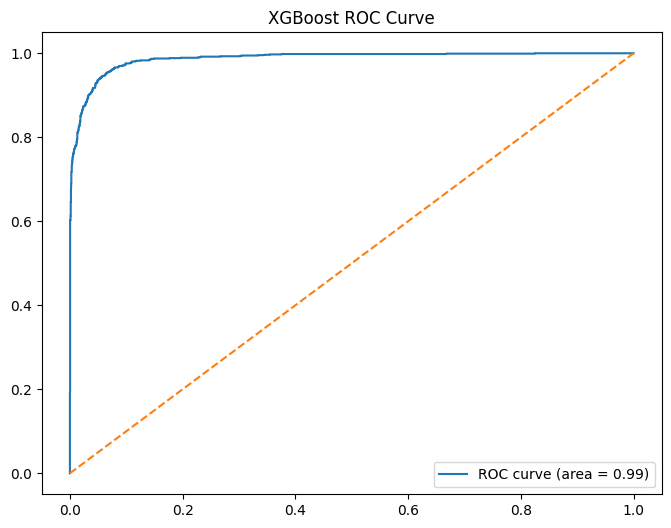

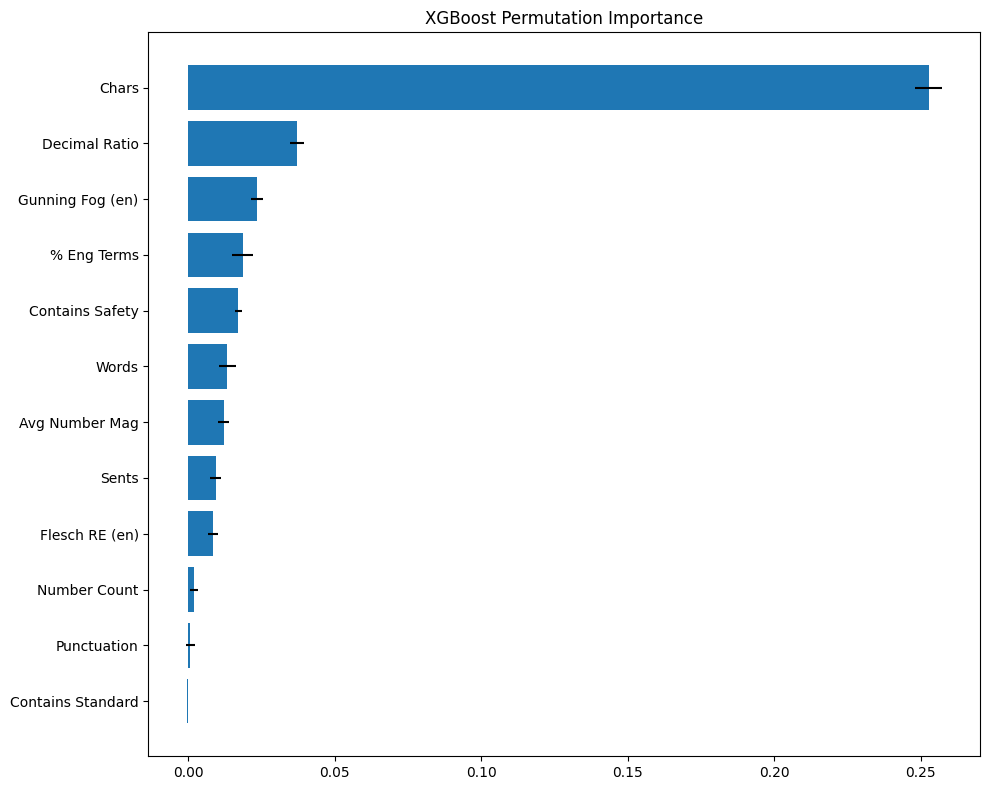

In [6]:
import os
import re
import json
import random
from typing import Optional, Dict, Tuple, List, Any
from dataclasses import dataclass, field

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    roc_auc_score, classification_report, roc_curve, auc
)
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import joblib

import xgboost as xgb

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    XLMRobertaForSequenceClassification,
    XLMRobertaTokenizerFast,
    DataCollatorWithPadding,
    AutoConfig
)

try:
    import textstat
    _HAS_TEXTSTAT = True
except Exception:
    _HAS_TEXTSTAT = False


# ===================== Config =====================
@dataclass
class Config:
    BASE_DIR: str = "/content/drive/MyDrive/emc"
    TRAIN_CSV: str = os.path.join(BASE_DIR, "train.csv")
    TEST_CSV: str = os.path.join(BASE_DIR, "test.csv")
    TERMS_CSV: str = os.path.join(BASE_DIR, "engineering_terms.csv")

    XGB_MODEL_JSON: str = os.path.join(BASE_DIR, "xgb_outputs/xgb_model.json")
    XGB_SCALER_PATH: str = os.path.join(BASE_DIR, "xgb_outputs/scaler12.pkl")
    XGB_AUC_ROC_PLOT_PATH: str = os.path.join(BASE_DIR, "xgb_outputs/auc_roc_plot.png")
    XGB_PERMUTATION_IMPORTANCE_PLOT_PATH: str = os.path.join(BASE_DIR, "xgb_outputs/permutation_importance.png")

    XLMR_MODEL_PATH: str = os.path.join(BASE_DIR, "xlmr_only_outputs/best_model")
    XLMR_AUC_ROC_PLOT_PATH: str = os.path.join(BASE_DIR, "xlmr_only_outputs/auc_roc_plot.png")

    TEXT_COL: str = "content"
    LABEL_COL: str = "label"
    LANG_COL: str = "lang"

    N_FEATURES: int = 12
    N_CLASSES: int = 2
    MAX_LEN: int = 256
    BATCH_SIZE: int = 32

    LABEL2ID: Dict[str, int] = field(default_factory=lambda: {"0": 0, "1": 1})
    ID2LABEL: Dict[int, str] = field(default_factory=lambda: {0: "Real", 1: "Misinformation"})

    DEVICE: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    MODEL_NAME: str = "xlm-roberta-base"


# ===================== Reproducibility =====================
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# ===================== Data & Feature Extraction =====================
STD_TERMS = {"iso", "asme", "ieee", "din", "ansi", "iec", "ul", "astm", "en"}
SAFETY_TERMS = {"safety", "hazard", "warning", "risk", "caution", "danger", "emergency"}
_WORD_RE = re.compile(r"\w+", re.UNICODE)
_NUM_RE = re.compile(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?')

def simple_words(t: str) -> List[str]: return _WORD_RE.findall(t or "")
def sent_count(t: str) -> int:
    if not t: return 0
    return max(1, len(re.split(r'[.!?]+[\s\n]+', t)))
def punct_count(t: str) -> int: return sum(1 for ch in (t or "") if ch in ".,;:!?")
def extract_numbers(text: str):
    nums, dec = [], 0
    for m in _NUM_RE.finditer(text or ""):
        s = m.group(0)
        try:
            v = float(s)
            if ('.' in s) or ('e' in s.lower()): dec += 1
            nums.append(abs(v))
        except: pass
    return nums, dec
def _finite_or_zero(x: float) -> float: return float(x) if np.isfinite(x) else 0.0

class TermsLexicon:
    def __init__(self, csv_path: str, term_col="terms", lang_col="lang"):
        if not os.path.exists(csv_path): raise FileNotFoundError(csv_path)
        df = pd.read_csv(csv_path)
        if term_col not in df.columns: raise ValueError(f"Missing '{term_col}'")
        if lang_col not in df.columns: df[lang_col] = 'en'
        self.by_lang = {str(l).lower(): set(str(x).strip().lower() for x in d[term_col].dropna().tolist() if str(x).strip()) for l, d in df.groupby(lang_col)}
    def pct_in_text(self, text: str, lang: str) -> float:
        if not text: return 0.0
        terms = self.by_lang.get((lang or "en").lower(), set())
        if not terms: return 0.0
        ws = [w.lower() for w in simple_words(text)]
        if not ws: return 0.0
        return sum(1 for w in ws if w in terms) / max(1, len(ws))

class FeatureExtractor12:
    def __init__(self, tlex: TermsLexicon): self.tlex = tlex
    def extract_one(self, text: str, lang: str) -> np.ndarray:
        text = "" if text is None else str(text); lang = (lang or "en").lower()
        ws = simple_words(text); n_words = len(simple_words(text))

        chars = len(text)
        words = n_words
        sents = sent_count(text)

        if lang == "en" and _HAS_TEXTSTAT and text.strip():
            fre, fog = _finite_or_zero(textstat.flesch_reading_ease(text)), _finite_or_zero(textstat.gunning_fog(text))
        else: fre, fog = 0.0, 0.0

        eng_pct = self.tlex.pct_in_text(text, lang)
        punc = punct_count(text)
        nums, dec_cnt = extract_numbers(text)
        nnums = len(nums)
        avg_mag = float(np.mean(nums)) if nums else 0.0
        dec_ratio = float(dec_cnt / len(nums)) if nums else 0.0

        low = text.lower()
        has_std = 1.0 if any(t in low for t in STD_TERMS) else 0.0
        has_saf = 1.0 if any(t in low for t in SAFETY_TERMS) else 0.0

        feats = np.array([chars, words, sents, fre, fog, eng_pct, punc, nnums, has_std, has_saf, avg_mag, dec_ratio], dtype=np.float32)
        if not np.all(np.isfinite(feats)): feats = np.nan_to_num(feats, nan=0.0, posinf=1e12, neginf=0.0)
        return feats.astype(np.float32)

    def extract_df(self, df: pd.DataFrame) -> np.ndarray:
        assert 'content' in df.columns
        if 'lang' not in df.columns: df = df.copy(); df['lang'] = 'en'
        rows = [self.extract_one(r.get("content",""), r.get("lang","en")) for _, r in tqdm(df.iterrows(), total=len(df), desc="Extracting features")]
        return np.stack(rows, axis=0).astype(np.float32)

def build_feature_matrix(df: pd.DataFrame, cfg: Config, lex: TermsLexicon) -> Tuple[np.ndarray, np.ndarray, list]:
    fe = FeatureExtractor12(lex)
    X = fe.extract_df(df)
    y = np.array([cfg.LABEL2ID[str(x)] for x in df[cfg.LABEL_COL].astype(str).tolist()], dtype=np.int32)
    return X, y, df[cfg.TEXT_COL].tolist()

class TextDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer, max_len: int, label2id: Dict[str, int]):
        self.texts = df["content"].astype(str).tolist()
        self.labels = [label2id[str(x)] for x in df["label"].astype(str).tolist()]
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tokenizer(self.texts[idx], truncation=True, max_length=self.max_len, padding=False, return_tensors="pt")
        enc = {k: v.squeeze(0) for k, v in enc.items()}
        enc["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return enc

# ===================== Metrics / CIs =====================
def compute_metrics(y_true, y_pred, y_prob):
    metrics = {
        "precision_real": precision_score(y_true, y_pred, pos_label=0),
        "recall_real": recall_score(y_true, y_pred, pos_label=0),
        "f1_real": f1_score(y_true, y_pred, pos_label=0),
        "precision_misinfo": precision_score(y_true, y_pred, pos_label=1),
        "recall_misinfo": recall_score(y_true, y_pred, pos_label=1),
        "f1_misinfo": f1_score(y_true, y_pred, pos_label=1),
        "macro_f1": f1_score(y_true, y_pred, average='macro'),
        "micro_f1": f1_score(y_true, y_pred, average='micro'),
        "weighted_f1": f1_score(y_true, y_pred, average='weighted'),
        "accuracy": accuracy_score(y_true, y_pred),
    }
    return metrics

def bootstrap_ci(y_true, y_pred, y_prob, n_resamples=1000, alpha=0.95):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    N = len(y_true)
    lo, hi = (1 - alpha) / 2, 1 - (1 - alpha) / 2
    f1_real_vals, f1_misinfo_vals, macro_vals, micro_vals, weighted_vals = [], [], [], [], []

    for _ in range(n_resamples):
        idx = resample(np.arange(N), n_samples=N, replace=True)
        yt, yp = y_true[idx], y_pred[idx]
        with np.errstate(divide='ignore', invalid='ignore'):
            f1_real_vals.append(f1_score(yt, yp, pos_label=0, average='binary', zero_division=0))
            f1_misinfo_vals.append(f1_score(yt, yp, pos_label=1, average='binary', zero_division=0))
            macro_vals.append(f1_score(yt, yp, average='macro', zero_division=0))
            micro_vals.append(f1_score(yt, yp, average='micro', zero_division=0))
            weighted_vals.append(f1_score(yt, yp, average='weighted', zero_division=0))
    results = {
        'F1-score Real (0)': np.percentile(f1_real_vals, [lo * 100, hi * 100]).tolist(),
        'F1-score Misinformation (1)': np.percentile(f1_misinfo_vals, [lo * 100, hi * 100]).tolist(),
        'Macro F1': np.percentile(macro_vals, [lo * 100, hi * 100]).tolist(),
        'Micro F1': np.percentile(micro_vals, [lo * 100, hi * 100]).tolist(),
        'Weighted F1': np.percentile(weighted_vals, [lo * 100, hi * 100]).tolist(),
    }
    return results

def run_xlmr_evaluation(model, dataloader, device):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating XLM-R", leave=False):
            inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
            labels = batch['labels'].to(device)
            outputs = model(**inputs, labels=None)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()
            preds = np.argmax(probs, axis=-1)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.tolist())
            all_probs.extend(probs.tolist())
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# ===================== Main Execution =====================
if __name__ == "__main__":
    set_seed(42)
    cfg = Config()

    # Check for file existence
    if not all(os.path.exists(p) for p in [cfg.TRAIN_CSV, cfg.TEST_CSV]):
        print(f"Error: Missing data files in {cfg.BASE_DIR}")
        exit()

    # --- Part 1: Data Leakage Check ---
    print("--- Running Data Leakage Check ---")
    train_df = pd.read_csv(cfg.TRAIN_CSV)
    test_df = pd.read_csv(cfg.TEST_CSV)

    train_texts = set(train_df['content'].astype(str))
    test_texts = set(test_df['content'].astype(str))

    leakage_count = len(train_texts.intersection(test_texts))
    if leakage_count > 0:
        print(f"⚠️ Warning: Found {leakage_count} overlapping texts between train and test sets!")
        print("This may be the cause of your high scores.")
    else:
        print("✅ No direct text overlap found between train and test sets.")
    print("-" * 50)

    # --- Part 2: XGBoost Evaluation ---
    print("\n--- Running XGBoost + Features Evaluation ---")

    if not all(os.path.exists(p) for p in [cfg.XGB_MODEL_JSON, cfg.XGB_SCALER_PATH]):
        print("⚠️ Skipping XGBoost evaluation: model or scaler files not found.")
    else:
        try:
            clf = xgb.XGBClassifier(); clf.load_model(cfg.XGB_MODEL_JSON)
            lex = TermsLexicon(cfg.TERMS_CSV)
            scaler = joblib.load(cfg.XGB_SCALER_PATH)
            X_test, y_true, _ = build_feature_matrix(test_df, cfg, lex)
            X_test_scaled = scaler.transform(X_test)
            y_prob = clf.predict_proba(X_test_scaled)
            y_pred = y_prob.argmax(axis=1)

            metrics = compute_metrics(y_true, y_pred, y_prob)
            cis = bootstrap_ci(y_true, y_pred, y_prob)

            print("\n" + "="*50)
            print("XGBoost + Features on EMC Test Set")
            print("="*50)
            print(f"AUC-ROC Score: {roc_auc_score(y_true, y_prob[:, 1]):.4f}\n")

            table_data = [
                ("Precision", "Real (0)", f"{metrics['precision_real']:.3f}"),
                ("Recall", "Real (0)", f"{metrics['recall_real']:.3f}"),
                ("F1-score", "Real (0)", f"{metrics['f1_real']:.3f} [{cis['F1-score Real (0)'][0]:.4f}, {cis['F1-score Real (0)'][1]:.4f}]"),
                ("", "", ""),
                ("Precision", "Misinformation (1)", f"{metrics['precision_misinfo']:.3f}"),
                ("Recall", "Misinformation (1)", f"{metrics['recall_misinfo']:.3f}"),
                ("F1-score", "Misinformation (1)", f"{metrics['f1_misinfo']:.3f} [{cis['F1-score Misinformation (1)'][0]:.4f}, {cis['F1-score Misinformation (1)'][1]:.4f}]"),
                ("", "", ""),
                ("Macro F1", "--", f"{metrics['macro_f1']:.3f} [{cis['Macro F1'][0]:.4f}, {cis['Macro F1'][1]:.4f}]"),
                ("Micro F1", "--", f"{metrics['micro_f1']:.3f} [{cis['Micro F1'][0]:.4f}, {cis['Micro F1'][1]:.4f}]"),
                ("Weighted F1", "--", f"{metrics['weighted_f1']:.3f} [{cis['Weighted F1'][0]:.4f}, {cis['Weighted F1'][1]:.4f}]"),
            ]
            print(f"{'Metric':<25} {'Class':<20} {'Value [95% CI]':<30}")
            print("-" * 75)
            for row in table_data:
                if row[0]: print(f"{row[0]:<25} {row[1]:<20} {row[2]:<30}")
                else: print("")

            os.makedirs(os.path.dirname(cfg.XGB_AUC_ROC_PLOT_PATH), exist_ok=True)
            fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(8, 6)); plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})'); plt.plot([0, 1], [0, 1], '--'); plt.legend(); plt.title('XGBoost ROC Curve'); plt.savefig(cfg.XGB_AUC_ROC_PLOT_PATH)
            print(f"✅ AUC-ROC plot saved to: {cfg.XGB_AUC_ROC_PLOT_PATH}")

            result = permutation_importance(clf, X_test_scaled, y_true, n_repeats=10, random_state=42, n_jobs=-1)
            feat_names = ["Chars", "Words", "Sents", "Flesch RE (en)", "Gunning Fog (en)", "% Eng Terms", "Punctuation", "Number Count", "Contains Standard", "Contains Safety", "Avg Number Mag", "Decimal Ratio"]
            importance_df = pd.DataFrame({'Feature': feat_names, 'Importance_Mean': result.importances_mean, 'Importance_Std': result.importances_std}).sort_values('Importance_Mean', ascending=True)
            plt.figure(figsize=(10, 8)); plt.barh(importance_df['Feature'], importance_df['Importance_Mean'], xerr=importance_df['Importance_Std']); plt.title('XGBoost Permutation Importance'); plt.tight_layout(); plt.savefig(cfg.XGB_PERMUTATION_IMPORTANCE_PLOT_PATH)
            print(f"✅ Permutation Importance plot saved to: {cfg.XGB_PERMUTATION_IMPORTANCE_PLOT_PATH}")
        except Exception as e:
            print(f"An error occurred during XGBoost evaluation: {e}")

    # --- Part 3: XLM-R Only Evaluation ---
    print("\n" + "="*50)
    print("--- Running XLM-R Only Evaluation ---")
    print("="*50)

    if not os.path.exists(cfg.XLMR_MODEL_PATH):
        print("⚠️ Skipping XLM-R evaluation: model files not found.")
    else:
        try:
            model = XLMRobertaForSequenceClassification.from_pretrained(cfg.XLMR_MODEL_PATH).to(cfg.DEVICE)
            tokenizer = XLMRobertaTokenizerFast.from_pretrained(cfg.XLMR_MODEL_PATH)
            test_ds = TextDataset(test_df, cfg.TEXT_COL, cfg.LABEL_COL, tokenizer, cfg.MAX_LEN, cfg.LABEL2ID)
            collator = DataCollatorWithPadding(tokenizer)
            test_loader = DataLoader(test_ds, batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=collator)

            y_true, y_pred, y_prob = run_xlmr_evaluation(model, test_loader, cfg.DEVICE)
            metrics = compute_metrics(y_true, y_pred, y_prob)
            cis = bootstrap_ci(y_true, y_pred, y_prob)

            print(f"AUC-ROC Score: {roc_auc_score(y_true, y_prob[:, 1]):.4f}\n")
            table_data = [
                ("Precision", "Real (0)", f"{metrics['precision_real']:.3f}"),
                ("Recall", "Real (0)", f"{metrics['recall_real']:.3f}"),
                ("F1-score", "Real (0)", f"{metrics['f1_real']:.3f} [{cis['F1-score Real (0)'][0]:.4f}, {cis['F1-score Real (0)'][1]:.4f}]"),
                ("", "", ""),
                ("Precision", "Misinformation (1)", f"{metrics['precision_misinfo']:.3f}"),
                ("Recall", "Misinformation (1)", f"{metrics['recall_misinfo']:.3f}"),
                ("F1-score", "Misinformation (1)", f"{metrics['f1_misinfo']:.3f} [{cis['F1-score Misinformation (1)'][0]:.4f}, {cis['F1-score Misinformation (1)'][1]:.4f}]"),
                ("", "", ""),
                ("Macro F1", "--", f"{metrics['macro_f1']:.3f} [{cis['Macro F1'][0]:.4f}, {cis['Macro F1'][1]:.4f}]"),
                ("Micro F1", "--", f"{metrics['micro_f1']:.3f} [{cis['Micro F1'][0]:.4f}, {cis['Micro F1'][1]:.4f}]"),
                ("Weighted F1", "--", f"{metrics['weighted_f1']:.3f} [{cis['Weighted F1'][0]:.4f}, {cis['Weighted F1'][1]:.4f}]"),
            ]
            print(f"{'Metric':<25} {'Class':<20} {'Value [95% CI]':<30}")
            print("-" * 75)
            for row in table_data:
                if row[0]: print(f"{row[0]:<25} {row[1]:<20} {row[2]:<30}")
                else: print("")

            os.makedirs(os.path.dirname(cfg.XLMR_AUC_ROC_PLOT_PATH), exist_ok=True)
            fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(8, 6)); plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})'); plt.plot([0, 1], [0, 1], '--'); plt.legend(); plt.title('XLM-R ROC Curve'); plt.savefig(cfg.XLMR_AUC_ROC_PLOT_PATH)
            print(f"✅ AUC-ROC plot saved to: {cfg.XLMR_AUC_ROC_PLOT_PATH}")
        except Exception as e:
            print(f"An error occurred during XLM-R evaluation: {e}")

    print("\n✅ All evaluations complete.")


# XLM-R TEXT ONLY

--- Loading models and data for evaluation ---

--- Running evaluation on test set ---



XLM-R Only on EMC Test Set
Macro F1-Score: 0.9349
Micro F1-Score: 0.9447
Weighted F1-Score: 0.9455

--- Bootstrapping Confidence Intervals ---

---------------------------------------------------------------------------
Metric                    Class                Value [95% CI]                
---------------------------------------------------------------------------
Precision                 Real (0)             0.982                         
Recall                    Real (0)             0.939                         
F1-score                  Real (0)             0.960 [0.9549, 0.9655]        

Precision                 Misinformation (1)   0.865                         
Recall                    Misinformation (1)   0.959                         
F1-score                  Misinformation (1)   0.910 [0.8973, 0.9212]        

Macro F1                  --                   0.935 [0.9262, 0.9431]        
Micro F1                  --                   0.945 [0.9375, 0.9517]        

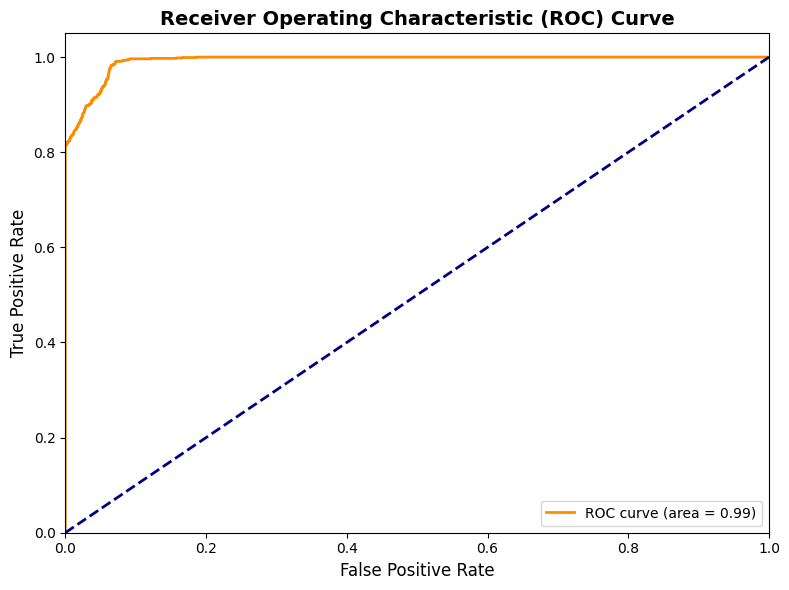

In [4]:
import os
import re
import json
import random
from typing import Optional, Dict, Tuple, List, Any
from dataclasses import dataclass, field

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    roc_auc_score, classification_report, roc_curve, auc
)
from sklearn.utils import resample

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    XLMRobertaForSequenceClassification,
    XLMRobertaTokenizerFast,
    DataCollatorWithPadding
)


# ===================== Config =====================
@dataclass
class Config:
    BASE_DIR: str = "/content/drive/MyDrive/emc"
    TEST_CSV: str = os.path.join(BASE_DIR, "test.csv")
    MODEL_PATH: str = os.path.join(BASE_DIR, "xlmr_only_outputs/best_model")
    MODEL_NAME: str = "xlm-roberta-base"

    TEXT_COL: str = "content"
    LABEL_COL: str = "label"
    LANG_COL: str = "lang"

    N_CLASSES: int = 2
    MAX_LEN: int = 256
    BATCH_SIZE: int = 32

    # Output paths for figures
    AUC_ROC_PLOT_PATH: str = os.path.join(BASE_DIR, "xlmr_only_outputs/auc_roc_plot.png")

    # Use the same label mapping as training
    LABEL2ID: Dict[str, int] = field(default_factory=lambda: {"0": 0, "1": 1})
    ID2LABEL: Dict[int, str] = field(default_factory=lambda: {0: "Real", 1: "Misinformation"})

    DEVICE: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===================== Reproducibility =====================
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# ===================== Dataset & DataLoader =====================
class TextDataset(Dataset):
    def __init__(self, df: pd.DataFrame, text_col: str, label_col: str, tokenizer, max_len: int, label2id: Dict[str, int]):
        self.texts = df[text_col].astype(str).tolist()
        self.labels_raw = df[label_col].tolist()
        self.label2id = label2id
        self.ids = [self.label2id[str(x)] if str(x) in self.label2id else self.label2id[x] for x in map(str, self.labels_raw)]
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_len,
            padding=False,
            return_tensors="pt",
        )
        enc = {k: v.squeeze(0) for k, v in enc.items()}
        enc["labels"] = torch.tensor(self.ids[idx], dtype=torch.long)
        return enc

# ===================== Metrics / CIs =====================
def compute_metrics(y_true, y_pred, y_prob):
    metrics = {
        "precision_real": precision_score(y_true, y_pred, pos_label=0),
        "recall_real": recall_score(y_true, y_pred, pos_label=0),
        "f1_real": f1_score(y_true, y_pred, pos_label=0),
        "precision_misinfo": precision_score(y_true, y_pred, pos_label=1),
        "recall_misinfo": recall_score(y_true, y_pred, pos_label=1),
        "f1_misinfo": f1_score(y_true, y_pred, pos_label=1),
        "macro_f1": f1_score(y_true, y_pred, average='macro'),
        "micro_f1": f1_score(y_true, y_pred, average='micro'),
        "weighted_f1": f1_score(y_true, y_pred, average='weighted'),
        "accuracy": accuracy_score(y_true, y_pred),
    }
    return metrics

def bootstrap_ci(y_true, y_pred, y_prob, n_resamples=1000, alpha=0.95):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    N = len(y_true)
    lo = (1 - alpha) / 2
    hi = 1 - lo

    f1_real_vals, f1_misinfo_vals, macro_vals, micro_vals, weighted_vals = [], [], [], [], []

    for _ in range(n_resamples):
        idx = resample(np.arange(N), n_samples=N, replace=True)
        yt, yp = y_true[idx], y_pred[idx]

        with np.errstate(divide='ignore', invalid='ignore'):
            f1_real_vals.append(f1_score(yt, yp, pos_label=0, average='binary', zero_division=0))
            f1_misinfo_vals.append(f1_score(yt, yp, pos_label=1, average='binary', zero_division=0))
            macro_vals.append(f1_score(yt, yp, average='macro', zero_division=0))
            micro_vals.append(f1_score(yt, yp, average='micro', zero_division=0))
            weighted_vals.append(f1_score(yt, yp, average='weighted', zero_division=0))

    results = {
        'F1-score Real (0)': np.percentile(f1_real_vals, [lo * 100, hi * 100]).tolist(),
        'F1-score Misinformation (1)': np.percentile(f1_misinfo_vals, [lo * 100, hi * 100]).tolist(),
        'Macro F1': np.percentile(macro_vals, [lo * 100, hi * 100]).tolist(),
        'Micro F1': np.percentile(micro_vals, [lo * 100, hi * 100]).tolist(),
        'Weighted F1': np.percentile(weighted_vals, [lo * 100, hi * 100]).tolist(),
    }
    return results

# ===================== Evaluation Loop =====================
def run_evaluation(model, dataloader, device):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
            labels = batch['labels'].to(device)

            outputs = model(**inputs, labels=None)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()
            preds = np.argmax(probs, axis=-1)

            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.tolist())
            all_probs.extend(probs.tolist())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)


# ===================== Main Execution =====================
if __name__ == "__main__":
    set_seed(42)
    cfg = Config()

    os.makedirs(os.path.dirname(cfg.AUC_ROC_PLOT_PATH), exist_ok=True)

    if not os.path.exists(cfg.MODEL_PATH):
        print(f"Error: Model directory not found at {cfg.MODEL_PATH}")
        exit()
    if not os.path.exists(cfg.TEST_CSV):
        print(f"Error: Test data not found at {cfg.TEST_CSV}")
        exit()

    print("--- Loading models and data for evaluation ---")

    try:
        model = XLMRobertaForSequenceClassification.from_pretrained(cfg.MODEL_PATH).to(cfg.DEVICE)
        tokenizer = XLMRobertaTokenizerFast.from_pretrained(cfg.MODEL_PATH)
    except Exception as e:
        print(f"Failed to load model or tokenizer from {cfg.MODEL_PATH}: {e}")
        exit()

    test_df = pd.read_csv(cfg.TEST_CSV)

    test_ds = TextDataset(test_df, cfg.TEXT_COL, cfg.LABEL_COL, tokenizer, cfg.MAX_LEN, cfg.LABEL2ID)
    collator = DataCollatorWithPadding(tokenizer)
    test_loader = DataLoader(test_ds, batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=collator)

    print("\n--- Running evaluation on test set ---")
    y_true, y_pred, y_prob = run_evaluation(model, test_loader, cfg.DEVICE)

    # --- Compute and print general F1 scores ---
    metrics = compute_metrics(y_true, y_pred, y_prob)

    print("\n" + "="*50)
    print("XLM-R Only on EMC Test Set")
    print("="*50)
    print(f"Macro F1-Score: {metrics['macro_f1']:.4f}")
    print(f"Micro F1-Score: {metrics['micro_f1']:.4f}")
    print(f"Weighted F1-Score: {metrics['weighted_f1']:.4f}")

    # --- Compute and print metrics table with CIs ---
    print("\n--- Bootstrapping Confidence Intervals ---")
    cis = bootstrap_ci(y_true, y_pred, y_prob)

    print("\n" + "-"*75)
    print(f"{'Metric':<25} {'Class':<20} {'Value [95% CI]':<30}")
    print("-" * 75)

    table_data = [
        ("Precision", "Real (0)", f"{metrics['precision_real']:.3f}"),
        ("Recall", "Real (0)", f"{metrics['recall_real']:.3f}"),
        ("F1-score", "Real (0)", f"{metrics['f1_real']:.3f} [{cis['F1-score Real (0)'][0]:.4f}, {cis['F1-score Real (0)'][1]:.4f}]"),
        ("", "", ""), # Spacer
        ("Precision", "Misinformation (1)", f"{metrics['precision_misinfo']:.3f}"),
        ("Recall", "Misinformation (1)", f"{metrics['recall_misinfo']:.3f}"),
        ("F1-score", "Misinformation (1)", f"{metrics['f1_misinfo']:.3f} [{cis['F1-score Misinformation (1)'][0]:.4f}, {cis['F1-score Misinformation (1)'][1]:.4f}]"),
        ("", "", ""), # Spacer
        ("Macro F1", "--", f"{metrics['macro_f1']:.3f} [{cis['Macro F1'][0]:.4f}, {cis['Macro F1'][1]:.4f}]"),
        ("Micro F1", "--", f"{metrics['micro_f1']:.3f} [{cis['Micro F1'][0]:.4f}, {cis['Micro F1'][1]:.4f}]"),
        ("Weighted F1", "--", f"{metrics['weighted_f1']:.3f} [{cis['Weighted F1'][0]:.4f}, {cis['Weighted F1'][1]:.4f}]"),
    ]

    for row in table_data:
        if row[0]:
            print(f"{row[0]:<25} {row[1]:<20} {row[2]:<30}")
        else:
            print("")

    # --- Generate AUC-ROC Curve ---
    print("\n--- Generating AUC-ROC plot... ---")
    fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.tight_layout()
    plt.savefig(cfg.AUC_ROC_PLOT_PATH, dpi=300)
    print(f"✅ AUC-ROC plot saved to: {cfg.AUC_ROC_PLOT_PATH}")

    print("\n✅ Evaluation complete.")


In [18]:
import os
import re
import json
import random
from typing import Optional, Dict, Tuple, List, Any
from dataclasses import dataclass, field

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    roc_auc_score, classification_report, roc_curve, auc
)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import joblib

import xgboost as xgb
from xgboost.callback import EarlyStopping

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    XLMRobertaForSequenceClassification,
    XLMRobertaModel,
    XLMRobertaTokenizerFast,
    DataCollatorWithPadding,
    get_linear_schedule_with_warmup
)

try:
    import textstat
    _HAS_TEXTSTAT = True
except Exception:
    _HAS_TEXTSTAT = False

# ===================== Config =====================
@dataclass
class Config:
    BASE_DIR: str = "/content/drive/MyDrive/emc"
    RAW_CORPUS_CSV: str = os.path.join(BASE_DIR, "all_data.csv")
    TERMS_CSV: str = os.path.join(BASE_DIR, "engineering_terms.csv")

    CLEAN_TRAIN_CSV: str = os.path.join(BASE_DIR, "train.csv")
    CLEAN_VAL_CSV: str = os.path.join(BASE_DIR, "val.csv")
    CLEAN_TEST_CSV: str = os.path.join(BASE_DIR, "test.csv")

    XGB_OUTPUTS: str = os.path.join(BASE_DIR, "xgb_outputs_clean")
    XLM_R_OUTPUTS: str = os.path.join(BASE_DIR, "xlmr_only_outputs_clean")
    SIMPLE_OUTPUTS: str = os.path.join(BASE_DIR, "simple_fusion_outputs_clean")
    GATED_OUTPUTS: str = os.path.join(BASE_DIR, "gated_fusion_outputs_clean")

    TEXT_COL: str = "content"
    LABEL_COL: str = "label"
    LANG_COL: str = "lang"

    N_FEATURES: int = 12
    N_CLASSES: int = 2
    MAX_LEN: int = 256
    BATCH_SIZE: int = 16

    XLM_R_EPOCHS: int = 5
    XLM_R_LR: float = 2e-5
    XLM_R_PATIENCE: int = 3

    XGB_ESTIMATORS: int = 2000
    XGB_LR: float = 0.03
    XGB_MAX_DEPTH: int = 6
    XGB_EARLY_STOP: int = 100

    LABEL2ID: Dict[str, int] = field(default_factory=lambda: {"0": 0, "1": 1})
    ID2LABEL: Dict[int, str] = field(default_factory=lambda: {0: "Real", 1: "Misinformation"})

    DEVICE: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    MODEL_NAME: str = "xlm-roberta-base"

    COMBINED_AUC_ROC_PLOT_PATH: str = os.path.join(BASE_DIR, "combined_auc_roc.png")

# ===================== Reproducibility =====================
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# ===================== Data & Feature Extraction =====================
def clean_and_split_data(raw_csv_path, train_path, val_path, test_path):
    print("--- Cleaning and splitting data ---")
    if not os.path.exists(raw_csv_path):
        print(f"Error: Raw corpus not found at {raw_csv_path}")
        return

    df = pd.read_csv(raw_csv_path)
    df.dropna(subset=['content', 'label'], inplace=True)
    df.drop_duplicates(subset=['content'], inplace=True)

    X, y = df, df['label']
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    train_idx, test_val_idx = next(sss.split(X, y))

    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test_val, y_test_val = X.iloc[test_val_idx], y.iloc[test_val_idx]

    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    val_idx, test_idx = next(sss2.split(X_test_val, y_test_val))

    X_train, X_val, X_test = X.iloc[train_idx], X_test_val.iloc[val_idx], X_test_val.iloc[test_idx]

    train_texts = set(X_train['content'].astype(str))
    val_texts = set(X_val['content'].astype(str))
    test_texts = set(X_test['content'].astype(str))

    if train_texts.intersection(test_texts) or train_texts.intersection(val_texts) or val_texts.intersection(test_texts):
        print("⚠️ Warning: Data leakage detected after splitting. This should not happen with StratifiedShuffleSplit. Review your data.")
    else:
        print("✅ No direct text overlap found between train, val, and test sets.")

    X_train.to_csv(train_path, index=False)
    X_val.to_csv(val_path, index=False)
    X_test.to_csv(test_path, index=False)

    print(f"✅ Data splits saved: Train ({len(X_train)}), Val ({len(X_val)}), Test ({len(X_test)})")

STD_TERMS = {"iso", "asme", "ieee", "din", "ansi", "iec", "ul", "astm", "en"}
SAFETY_TERMS = {"safety", "hazard", "warning", "risk", "caution", "danger", "emergency"}
_WORD_RE = re.compile(r"\w+", re.UNICODE)
_NUM_RE = re.compile(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?')

def simple_words(t: str) -> List[str]: return _WORD_RE.findall(t or "")
def sent_count(t: str) -> int:
    if not t: return 0
    return max(1, len(re.split(r'[.!?]+[\s\n]+', t)))
def punct_count(t: str) -> int: return sum(1 for ch in (t or "") if ch in ".,;:!?")
def extract_numbers(text: str):
    nums, dec = [], 0
    for m in _NUM_RE.finditer(text or ""):
        s = m.group(0)
        try:
            v = float(s)
            if ('.' in s) or ('e' in s.lower()): dec += 1
            nums.append(abs(v))
        except: pass
    return nums, dec
def _finite_or_zero(x: float) -> float: return float(x) if np.isfinite(x) else 0.0

class TermsLexicon:
    def __init__(self, csv_path: str, term_col="terms", lang_col="lang"):
        if not os.path.exists(csv_path): raise FileNotFoundError(csv_path)
        df = pd.read_csv(csv_path)
        if term_col not in df.columns: raise ValueError(f"Missing '{term_col}'")
        if lang_col not in df.columns: df[lang_col] = 'en'
        self.by_lang = {str(l).lower(): set(str(x).strip().lower() for x in d[term_col].dropna().tolist() if str(x).strip()) for l, d in df.groupby(lang_col)}
    def pct_in_text(self, text: str, lang: str) -> float:
        if not text: return 0.0
        terms = self.by_lang.get((lang or "en").lower(), set())
        if not terms: return 0.0
        ws = [w.lower() for w in simple_words(text)]
        if not ws: return 0.0
        return sum(1 for w in ws if w in terms) / max(1, len(ws))

class FeatureExtractor12:
    def __init__(self, tlex: TermsLexicon): self.tlex = tlex
    def extract_one(self, text: str, lang: str) -> np.ndarray:
        text = "" if text is None else str(text); lang = (lang or "en").lower()
        ws = simple_words(text); n_words = len(simple_words(text))

        chars = len(text)
        words = n_words
        sents = sent_count(text)

        if lang == "en" and _HAS_TEXTSTAT and text.strip():
            fre, fog = _finite_or_zero(textstat.flesch_reading_ease(text)), _finite_or_zero(textstat.gunning_fog(text))
        else: fre, fog = 0.0, 0.0

        eng_pct = self.tlex.pct_in_text(text, lang)
        punc = punct_count(text)
        nums, dec_cnt = extract_numbers(text)
        nnums = len(nums)
        avg_mag = float(np.mean(nums)) if nums else 0.0
        dec_ratio = float(dec_cnt / len(nums)) if nums else 0.0

        low = text.lower()
        has_std = 1.0 if any(t in low for t in STD_TERMS) else 0.0
        has_saf = 1.0 if any(t in low for t in SAFETY_TERMS) else 0.0

        feats = np.array([chars, words, sents, fre, fog, eng_pct, punc, nnums, has_std, has_saf, avg_mag, dec_ratio], dtype=np.float32)
        if not np.all(np.isfinite(feats)): feats = np.nan_to_num(feats, nan=0.0, posinf=1e12, neginf=0.0)
        return feats.astype(np.float32)

    def extract_df(self, df: pd.DataFrame) -> np.ndarray:
        assert 'content' in df.columns
        if 'lang' not in df.columns: df = df.copy(); df['lang'] = 'en'
        rows = [self.extract_one(r.get("content",""), r.get("lang","en")) for _, r in tqdm(df.iterrows(), total=len(df), desc="Extracting features")]
        return np.stack(rows, axis=0).astype(np.float32)

def build_feature_matrix(df: pd.DataFrame, cfg: Config, lex: TermsLexicon) -> Tuple[np.ndarray, np.ndarray, list]:
    fe = FeatureExtractor12(lex)
    X = fe.extract_df(df)
    y = np.array([cfg.LABEL2ID[str(x)] for x in df[cfg.LABEL_COL].astype(str).tolist()], dtype=np.int32)
    return X, y, df[cfg.TEXT_COL].tolist()

class TextDataset(Dataset):
    def __init__(self, df: pd.DataFrame, text_col: str, label_col: str, tokenizer, max_len: int, label2id: Dict[str, int]):
        self.texts = df[text_col].astype(str).tolist()
        self.labels_raw = df[label_col].tolist()
        self.label2id = label2id
        self.ids = [self.label2id[str(x)] if str(x) in self.label2id else self.label2id[x] for x in map(str, self.labels_raw)]
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tokenizer(self.texts[idx], truncation=True, max_length=self.max_len, padding=False, return_tensors="pt")
        enc = {k: v.squeeze(0) for k, v in enc.items()}
        enc["labels"] = torch.tensor(self.ids[idx], dtype=torch.long)
        return enc

class TextFeatDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer, feats: Optional[np.ndarray] = None):
        self.df = df.reset_index(drop=True)
        self.tok = tokenizer
        self.feats = feats
        self.labels = df['label'].values.astype(int) if 'label' in df.columns else None

    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        enc = self.tok(str(row['content']), truncation=True, max_length=Config.MAX_LEN, padding="max_length", return_tensors="pt")
        item = {'input_ids': enc['input_ids'].squeeze(0), 'attention_mask': enc['attention_mask'].squeeze(0)}
        if self.feats is not None: item['feats'] = torch.tensor(self.feats[idx], dtype=torch.float32)
        if self.labels is not None: item['labels'] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

def masked_mean_pool(last_hidden_state: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
    mask = attention_mask.unsqueeze(-1).float()
    return (last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)

class SimpleFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + n_feats, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled = masked_mean_pool(out.last_hidden_state, attention_mask)
        fused = torch.cat([pooled, feats], dim=1)
        return self.classifier(self.dropout(fused))

class GatedFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2, feat_proj: int = 64):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.fe_proj = nn.Sequential(nn.Linear(n_feats, feat_proj), nn.ReLU())
        self.gate = nn.Sequential(nn.Linear(H + n_feats, 64), nn.ReLU(), nn.Linear(64, 1), nn.Sigmoid())
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + feat_proj, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled = masked_mean_pool(out.last_hidden_state, attention_mask)
        alpha = self.gate(torch.cat([pooled, feats], dim=1))
        ef = self.fe_proj(feats)
        fused = torch.cat([pooled, alpha * ef], dim=1)
        return self.classifier(self.dropout(fused))

# ===================== Evaluation & Metrics =====================
def compute_metrics(y_true, y_pred):
    return {
        "macro_f1": f1_score(y_true, y_pred, average="macro"),
        "micro_f1": f1_score(y_true, y_pred, average="micro"),
        "weighted_f1": f1_score(y_true, y_pred, average="weighted"),
        "accuracy": accuracy_score(y_true, y_pred),
    }

def bootstrap_ci(y_true, y_pred, n_resamples=1000, alpha=0.95):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    N = len(y_true)
    lo, hi = (1 - alpha) / 2, 1 - (1 - alpha) / 2
    macro_vals, micro_vals, weighted_vals = [], [], []

    for _ in range(n_resamples):
        idx = resample(np.arange(N), n_samples=N, replace=True)
        yt, yp = y_true[idx], y_pred[idx]
        with np.errstate(divide='ignore', invalid='ignore'):
            macro_vals.append(f1_score(yt, yp, average='macro', zero_division=0))
            micro_vals.append(f1_score(yt, yp, average='micro', zero_division=0))
            weighted_vals.append(f1_score(yt, yp, average='weighted', zero_division=0))
    results = {
        'Macro F1': np.percentile(macro_vals, [lo * 100, hi * 100]).tolist(),
        'Micro F1': np.percentile(micro_vals, [lo * 100, hi * 100]).tolist(),
        'Weighted F1': np.percentile(weighted_vals, [lo * 100, hi * 100]).tolist(),
    }
    return results

def run_evaluation_loop(model, dataloader, device, model_type='xlmr'):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Evaluating {model_type}", leave=False):
            inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
            if model_type in ['simple', 'gated']:
                inputs['feats'] = batch['engineered'].to(device)
            labels = batch['label'].to(device)

            if model_type == 'xlmr':
                outputs = model(**inputs, labels=None)
                logits = outputs.logits
            else:
                logits = model(**inputs)

            probs = torch.softmax(logits, dim=-1).cpu().numpy()
            preds = np.argmax(probs, axis=-1)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.tolist())
            all_probs.extend(probs.tolist())
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

def train_xlmr_only(cfg: Config, train_df: pd.DataFrame, val_df: pd.DataFrame, tokenizer: XLMRobertaTokenizerFast):
    print("--- Training XLM-R Only model ---")
    os.makedirs(cfg.XLM_R_OUTPUTS, exist_ok=True)

    label_map_json = os.path.join(cfg.XLM_R_OUTPUTS, "label_map.json")
    with open(label_map_json, "w") as f:
        json.dump({"label2id": cfg.LABEL2ID, "id2label": cfg.ID2LABEL}, f, indent=2)

    train_ds = TextDataset(train_df, cfg.TEXT_COL, cfg.LABEL_COL, tokenizer, cfg.MAX_LEN, cfg.LABEL2ID)
    val_ds = TextDataset(val_df, cfg.TEXT_COL, cfg.LABEL_COL, tokenizer, cfg.MAX_LEN, cfg.LABEL2ID)
    collator = DataCollatorWithPadding(tokenizer)
    train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True, collate_fn=collator)
    val_loader = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=collator)

    model = XLMRobertaForSequenceClassification.from_pretrained(cfg.MODEL_NAME, num_labels=cfg.N_CLASSES).to(cfg.DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.XLM_R_LR)
    total_steps = len(train_loader) * cfg.XLM_R_EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    best_val_macro = -1.0; patience_left = cfg.XLM_R_PATIENCE
    for epoch in range(cfg.XLM_R_EPOCHS):
        model.train()
        for batch in tqdm(train_loader, desc=f"XLM-R Training Epoch {epoch+1}"):
            optimizer.zero_grad()
            inputs = {k: v.to(cfg.DEVICE) for k, v in batch.items()}
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step(); scheduler.step()

        y_true_val, y_pred_val, _ = run_evaluation_loop(model, val_loader, cfg.DEVICE, 'xlmr')
        val_macro = f1_score(y_true_val, y_pred_val, average='macro')
        print(f"Epoch {epoch+1} Val Macro F1: {val_macro:.4f}")

        if val_macro > best_val_macro:
            best_val_macro = val_macro
            patience_left = cfg.XLM_R_PATIENCE
            model.save_pretrained(cfg.XLM_R_OUTPUTS)
            tokenizer.save_pretrained(cfg.XLM_R_OUTPUTS)
            print("✅ New best XLM-R model saved.")
        else:
            patience_left -= 1
            if patience_left <= 0:
                print("⏹️ Early stopping triggered.")
                break
    print("✅ XLM-R Only trained successfully.")

def train_simple_fusion(cfg: Config, train_df: pd.DataFrame, val_df: pd.DataFrame, feats_tr, feats_v, lex):
    print("\n--- Training Simple Fusion model ---")
    os.makedirs(cfg.SIMPLE_OUTPUTS, exist_ok=True)

    tokenizer = XLMRobertaTokenizerFast.from_pretrained(cfg.MODEL_NAME)
    train_ds = TextFeatDataset(train_df, tokenizer, feats_tr)
    val_ds = TextFeatDataset(val_df, tokenizer, feats_v)

    train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=False)

    model = SimpleFusion(cfg.MODEL_NAME, cfg.N_FEATURES).to(cfg.DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.XLM_R_LR)
    total_steps = len(train_loader) * cfg.XLM_R_EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    criterion = nn.CrossEntropyLoss()

    best_val_macro = -1.0; patience_left = cfg.XLM_R_PATIENCE
    for epoch in range(cfg.XLM_R_EPOCHS):
        model.train()
        for batch in tqdm(train_loader, desc=f"Simple Fusion Training Epoch {epoch+1}"):
            optimizer.zero_grad()
            logits = model(batch['input_ids'].to(cfg.DEVICE), batch['attention_mask'].to(cfg.DEVICE), batch['feats'].to(cfg.DEVICE))
            loss = criterion(logits, batch['labels'].to(cfg.DEVICE))
            loss.backward()
            optimizer.step(); scheduler.step()

        y_true_val, y_pred_val, _ = run_evaluation_loop(model, val_loader, cfg.DEVICE, 'simple')
        val_macro = f1_score(y_true_val, y_pred_val, average='macro')
        print(f"Epoch {epoch+1} Val Macro F1: {val_macro:.4f}")

        if val_macro > best_val_macro:
            best_val_macro = val_macro
            patience_left = cfg.XLM_R_PATIENCE
            torch.save(model.state_dict(), os.path.join(cfg.SIMPLE_OUTPUTS, "fusion_simple.pt"))
            print("✅ New best Simple Fusion model saved.")
        else:
            patience_left -= 1
            if patience_left <= 0:
                print("⏹️ Early stopping triggered.")
                break
    print("✅ Simple Fusion trained successfully.")

def train_gated_fusion(cfg: Config, train_df: pd.DataFrame, val_df: pd.DataFrame, feats_tr, feats_v, lex):
    print("\n--- Training Gated Fusion model ---")
    os.makedirs(cfg.GATED_OUTPUTS, exist_ok=True)

    tokenizer = XLMRobertaTokenizerFast.from_pretrained(cfg.MODEL_NAME)
    train_ds = TextFeatDataset(train_df, tokenizer, feats_tr)
    val_ds = TextFeatDataset(val_df, tokenizer, feats_v)

    train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=False)

    model = GatedFusion(cfg.MODEL_NAME, cfg.N_FEATURES).to(cfg.DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.XLM_R_LR)
    total_steps = len(train_loader) * cfg.XLM_R_EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    criterion = nn.CrossEntropyLoss()

    best_val_macro = -1.0; patience_left = cfg.XLM_R_PATIENCE
    for epoch in range(cfg.XLM_R_EPOCHS):
        model.train()
        for batch in tqdm(train_loader, desc=f"Gated Fusion Training Epoch {epoch+1}"):
            optimizer.zero_grad()
            logits = model(batch['input_ids'].to(cfg.DEVICE), batch['attention_mask'].to(cfg.DEVICE), batch['feats'].to(cfg.DEVICE))
            loss = criterion(logits, batch['labels'].to(cfg.DEVICE))
            loss.backward()
            optimizer.step(); scheduler.step()

        y_true_val, y_pred_val, _ = run_evaluation_loop(model, val_loader, cfg.DEVICE, 'gated')
        val_macro = f1_score(y_true_val, y_pred_val, average='macro')
        print(f"Epoch {epoch+1} Val Macro F1: {val_macro:.4f}")

        if val_macro > best_val_macro:
            best_val_macro = val_macro
            patience_left = cfg.XLM_R_PATIENCE
            torch.save(model.state_dict(), os.path.join(cfg.GATED_OUTPUTS, "fusion_gated.pt"))
            print("✅ New best Gated Fusion model saved.")
        else:
            patience_left -= 1
            if patience_left <= 0:
                print("⏹️ Early stopping triggered.")
                break
    print("✅ Gated Fusion trained successfully.")

def train_xgboost(cfg: Config, train_df: pd.DataFrame, val_df: pd.DataFrame, feats_tr, feats_v):
    print("\n--- Training XGBoost model ---")
    os.makedirs(cfg.XGB_OUTPUTS, exist_ok=True)

    y_train = train_df['label'].values.astype(int)
    y_val = val_df['label'].values.astype(int)

    scaler = StandardScaler(); X_train_scaled = scaler.fit_transform(feats_tr); X_val_scaled = scaler.transform(feats_v)
    joblib.dump(scaler, os.path.join(cfg.XGB_OUTPUTS, "scaler12.pkl"))

    clf = xgb.XGBClassifier(n_estimators=cfg.XGB_ESTIMATORS, learning_rate=cfg.XGB_LR, max_depth=cfg.XGB_MAX_DEPTH, random_state=42, use_label_encoder=False, eval_metric='logloss')
    early_stopping_callback = EarlyStopping(rounds=cfg.XGB_EARLY_STOP)
    clf.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled, y_val)], callbacks=[early_stopping_callback], verbose=False)
    clf.save_model(os.path.join(cfg.XGB_OUTPUTS, "xgb_model.json"))
    print("✅ XGBoost model trained and saved.")


# ===================== Main Execution =====================
if __name__ == "__main__":
    set_seed(42)
    cfg = Config()

    # --- Step 1: Clean Data ---
    # This step is commented out to use your existing clean splits
    # clean_and_split_data(cfg.RAW_CORPUS_CSV, cfg.CLEAN_TRAIN_CSV, cfg.CLEAN_VAL_CSV, cfg.CLEAN_TEST_CSV)

    train_df = pd.read_csv(cfg.CLEAN_TRAIN_CSV)
    val_df = pd.read_csv(cfg.CLEAN_VAL_CSV)
    test_df = pd.read_csv(cfg.CLEAN_TEST_CSV)
    lex = TermsLexicon(cfg.TERMS_CSV)
    fe = FeatureExtractor12(lex)

    # --- Step 2: Extract features for all models ---
    print("\n--- Extracting features for all models... ---")
    feats_tr = fe.extract_df(train_df)
    feats_v = fe.extract_df(val_df)
    feats_te = fe.extract_df(test_df)

    # --- Step 3: Train All Models ---
    train_xgboost(cfg, train_df, val_df, feats_tr, feats_v)
    train_xlmr_only(cfg, train_df, val_df, XLMRobertaTokenizerFast.from_pretrained(cfg.MODEL_NAME))
    train_simple_fusion(cfg, train_df, val_df, feats_tr, feats_v, lex)
    train_gated_fusion(cfg, train_df, val_df, feats_tr, feats_v, lex)

    # --- Step 4: Final Evaluation ---
    print("\n--- Running final evaluation on clean test set for all models ---")

    # --- Load Models for Eval ---
    clf_xgb = xgb.XGBClassifier(); clf_xgb.load_model(os.path.join(cfg.XGB_OUTPUTS, "xgb_model.json"))
    scaler_xgb = joblib.load(os.path.join(cfg.XGB_OUTPUTS, "scaler12.pkl"))

    model_xlmr = XLMRobertaForSequenceClassification.from_pretrained(cfg.XLM_R_OUTPUTS).to(cfg.DEVICE)
    tokenizer_xlmr = XLMRobertaTokenizerFast.from_pretrained(cfg.XLM_R_OUTPUTS)

    model_simple = SimpleFusion(cfg.MODEL_NAME, cfg.N_FEATURES).to(cfg.DEVICE)
    model_simple.load_state_dict(torch.load(os.path.join(cfg.SIMPLE_OUTPUTS, "fusion_simple.pt")), strict=False)
    scaler_simple = joblib.load(os.path.join(cfg.SIMPLE_OUTPUTS, "scaler12.pkl"))

    model_gated = GatedFusion(cfg.MODEL_NAME, cfg.N_FEATURES).to(cfg.DEVICE)
    model_gated.load_state_dict(torch.load(os.path.join(cfg.GATED_OUTPUTS, "fusion_gated.pt")), strict=False)
    scaler_gated = joblib.load(os.path.join(cfg.GATED_OUTPUTS, "scaler12.pkl"))

    # --- Prepare Test Data ---
    X_test_xgb, y_true_xgb, _ = build_feature_matrix(test_df, cfg, lex)
    X_test_scaled_xgb = scaler_xgb.transform(X_test_xgb)

    X_test_simple, y_true_simple, _ = build_feature_matrix(test_df, cfg, lex)
    X_test_scaled_simple = scaler_simple.transform(X_test_simple)

    X_test_gated, y_true_gated, _ = build_feature_matrix(test_df, cfg, lex)
    X_test_scaled_gated = scaler_gated.transform(X_test_gated)

    test_ds_xlmr = TextFeatDataset(test_df, tokenizer_xlmr, feats=None)
    test_loader_xlmr = DataLoader(test_ds_xlmr, batch_size=cfg.BATCH_SIZE, collate_fn=DataCollatorWithPadding(tokenizer_xlmr))

    # --- Run Evaluations & Collect Results ---
    results_dict = {}

    # XGBoost
    print("\nEvaluating XGBoost...")
    y_prob_xgb = clf_xgb.predict_proba(X_test_scaled_xgb); y_pred_xgb = y_prob_xgb.argmax(axis=1)
    results_dict['XGBoost + Features'] = {'y_true': y_true_xgb, 'y_pred': y_pred_xgb, 'y_prob': y_prob_xgb[:,1]}

    # XLM-R
    print("\nEvaluating XLM-R Only...")
    y_true_xlmr, y_pred_xlmr, y_prob_xlmr = run_evaluation_loop(model_xlmr, test_loader_xlmr, cfg.DEVICE, 'xlmr')
    results_dict['XLM-R Only'] = {'y_true': y_true_xlmr, 'y_pred': y_pred_xlmr, 'y_prob': y_prob_xlmr[:,1]}

    # Simple Fusion
    print("\nEvaluating Simple Fusion...")
    test_ds_simple = TextFeatDataset(test_df, tokenizer_xlmr, feats=X_test_scaled_simple)
    test_loader_simple = DataLoader(test_ds_simple, batch_size=cfg.BATCH_SIZE)
    y_true_simple, y_pred_simple, y_prob_simple = run_evaluation_loop(model_simple, test_loader_simple, cfg.DEVICE, 'simple')
    results_dict['Simple Fusion'] = {'y_true': y_true_simple, 'y_pred': y_pred_simple, 'y_prob': y_prob_simple[:,1]}

    # Gated Fusion
    print("\nEvaluating Gated Fusion...")
    test_ds_gated = TextFeatDataset(test_df, tokenizer_xlmr, feats=X_test_scaled_gated)
    test_loader_gated = DataLoader(test_ds_gated, batch_size=cfg.BATCH_SIZE)
    y_true_gated, y_pred_gated, y_prob_gated = run_evaluation_loop(model_gated, test_loader_gated, cfg.DEVICE, 'gated')
    results_dict['Gated Fusion'] = {'y_true': y_true_gated, 'y_pred': y_pred_gated, 'y_prob': y_prob_gated[:,1]}

    # --- Print Final Table and Plots ---
    print("\n" + "="*80)
    print("Final Model Performance on Clean Test Set")
    print("="*80)

    table_data = []
    for name, res in results_dict.items():
        y_true, y_pred, y_prob = res['y_true'], res['y_pred'], res['y_prob']

        metrics = compute_metrics(y_true, y_pred)
        cis = bootstrap_ci(y_true, y_pred)

        table_data.append({
            "Model": name,
            "AUC-ROC": roc_auc_score(y_true, y_prob),
            "Precision_Real": precision_score(y_true, y_pred, pos_label=0),
            "Recall_Real": recall_score(y_true, y_pred, pos_label=0),
            "F1_Real": f1_score(y_true, y_pred, pos_label=0),
            "CI_F1_Real_low": cis['F1-score Real (0)'][0],
            "CI_F1_Real_high": cis['F1-score Real (0)'][1],
            "Precision_Misinfo": precision_score(y_true, y_pred, pos_label=1),
            "Recall_Misinfo": recall_score(y_true, y_pred, pos_label=1),
            "F1_Misinfo": f1_score(y_true, y_pred, pos_label=1),
            "CI_F1_Misinfo_low": cis['F1-score Misinformation (1)'][0],
            "CI_F1_Misinfo_high": cis['F1-score Misinformation (1)'][1],
            "Macro_F1": metrics['macro_f1'],
            "CI_Macro_F1_low": cis['Macro F1'][0],
            "CI_Macro_F1_high": cis['Macro F1'][1],
            "Micro_F1": metrics['micro_f1'],
            "CI_Micro_F1_low": cis['Micro F1'][0],
            "CI_Micro_F1_high": cis['Micro F1'][1],
            "Weighted_F1": metrics['weighted_f1'],
            "CI_Weighted_F1_low": cis['Weighted F1'][0],
            "CI_Weighted_F1_high": cis['Weighted F1'][1],
        })

    results_df = pd.DataFrame(table_data)

    # --- Combined AUC-ROC Plot ---
    print("\n--- Generating combined AUC-ROC plot... ---")
    plt.figure(figsize=(10, 8))

    for name, res in results_dict.items():
        y_true, y_prob = res['y_true'], res['y_prob']
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('Combined Model ROC Curves')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(cfg.COMBINED_AUC_ROC_PLOT_PATH, dpi=300)
    print(f"✅ Combined AUC-ROC plot saved to: {cfg.COMBINED_AUC_ROC_PLOT_PATH}")

    # --- Permutation Importance for XGBoost ---
    print("\n--- Generating Permutation Importance plot for XGBoost... ---")
    feat_names = ["Chars", "Words", "Sents", "Flesch RE (en)", "Gunning Fog (en)", "% Eng Terms", "Punctuation", "Number Count", "Contains Standard", "Contains Safety", "Avg Number Mag", "Decimal Ratio"]
    result = permutation_importance(clf_xgb, X_test_scaled_xgb, y_true_xgb, n_repeats=10, random_state=42, n_jobs=-1)
    importance_df = pd.DataFrame({'Feature': feat_names, 'Importance_Mean': result.importances_mean}).sort_values('Importance_Mean', ascending=True)
    plt.figure(figsize=(10, 8)); plt.barh(importance_df['Feature'], importance_df['Importance_Mean'], color='darkblue'); plt.title('XGBoost Permutation Feature Importance'); plt.tight_layout(); plt.savefig(os.path.join(cfg.XGB_OUTPUTS, "permutation_importance.png"))
    print(f"✅ XGBoost Permutation Importance plot saved.")

    print("\n✅ All training and evaluation complete.")



--- Extracting features for all models... ---


Extracting features:  85%|████████▍ | 3286/3870 [00:06<00:01, 468.45it/s]/tmp/ipython-input-1113571000.py:193: RuntimeWarning: overflow encountered in cast
  feats = np.array([chars, words, sents, fre, fog, eng_pct, punc, nnums, has_std, has_saf, avg_mag, dec_ratio], dtype=np.float32)
Extracting features: 100%|██████████| 3870/3870 [00:07<00:00, 518.11it/s]


--- Training XGBoost model ---


TypeError: XGBClassifier.fit() got an unexpected keyword argument 'callbacks'

In [19]:
import os
import re
import json
import random
from typing import Optional, Dict, Tuple, List, Any
from dataclasses import dataclass, field

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns  # (unused is fine)

from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    roc_auc_score, classification_report, roc_curve, auc
)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import joblib

import xgboost as xgb
from xgboost.callback import EarlyStopping  # (unused)

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    XLMRobertaForSequenceClassification,
    XLMRobertaModel,
    XLMRobertaTokenizerFast,
    DataCollatorWithPadding,
    get_linear_schedule_with_warmup
)

try:
    import textstat
    _HAS_TEXTSTAT = True
except Exception:
    _HAS_TEXTSTAT = False

# ===================== Config =====================
@dataclass
class Config:
    BASE_DIR: str = "/content/drive/MyDrive/emc"
    RAW_CORPUS_CSV: str = os.path.join(BASE_DIR, "all_data.csv")
    TERMS_CSV: str = os.path.join(BASE_DIR, "engineering_terms.csv")

    CLEAN_TRAIN_CSV: str = os.path.join(BASE_DIR, "train.csv")
    CLEAN_VAL_CSV: str = os.path.join(BASE_DIR, "val.csv")
    CLEAN_TEST_CSV: str = os.path.join(BASE_DIR, "test.csv")

    XGB_OUTPUTS: str = os.path.join(BASE_DIR, "xgb_outputs_clean")
    XLM_R_OUTPUTS: str = os.path.join(BASE_DIR, "xlmr_only_outputs_clean")
    SIMPLE_OUTPUTS: str = os.path.join(BASE_DIR, "simple_fusion_outputs_clean")
    GATED_OUTPUTS: str = os.path.join(BASE_DIR, "gated_fusion_outputs_clean")

    TEXT_COL: str = "content"
    LABEL_COL: str = "label"
    LANG_COL: str = "lang"

    N_FEATURES: int = 12
    N_CLASSES: int = 2
    MAX_LEN: int = 256
    BATCH_SIZE: int = 16

    XLM_R_EPOCHS: int = 5
    XLM_R_LR: float = 2e-5
    XLM_R_PATIENCE: int = 3

    XGB_ESTIMATORS: int = 2000
    XGB_LR: float = 0.03
    XGB_MAX_DEPTH: int = 6
    XGB_EARLY_STOP: int = 100

    LABEL2ID: Dict[str, int] = field(default_factory=lambda: {"0": 0, "1": 1})
    ID2LABEL: Dict[int, str] = field(default_factory=lambda: {0: "Real", 1: "Misinformation"})

    DEVICE: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    MODEL_NAME: str = "xlm-roberta-base"

    COMBINED_AUC_ROC_PLOT_PATH: str = os.path.join(BASE_DIR, "combined_auc_roc.png")

# ===================== Reproducibility =====================
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # FIX: correct CUDA seeding call
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# ===================== Data & Feature Extraction =====================
def clean_and_split_data(raw_csv_path, train_path, val_path, test_path):
    print("--- Cleaning and splitting data ---")
    if not os.path.exists(raw_csv_path):
        print(f"Error: Raw corpus not found at {raw_csv_path}")
        return

    df = pd.read_csv(raw_csv_path)
    df.dropna(subset=['content', 'label'], inplace=True)
    df.drop_duplicates(subset=['content'], inplace=True)

    X, y = df, df['label']
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    train_idx, test_val_idx = next(sss.split(X, y))

    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test_val, y_test_val = X.iloc[test_val_idx], y.iloc[test_val_idx]

    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    val_idx, test_idx = next(sss2.split(X_test_val, y_test_val))

    X_train, X_val, X_test = X.iloc[train_idx], X_test_val.iloc[val_idx], X_test_val.iloc[test_idx]

    train_texts = set(X_train['content'].astype(str))
    val_texts = set(X_val['content'].astype(str))
    test_texts = set(X_test['content'].astype(str))

    if train_texts.intersection(test_texts) or train_texts.intersection(val_texts) or val_texts.intersection(test_texts):
        print("⚠️ Warning: Data leakage detected after splitting. This should not happen with StratifiedShuffleSplit. Review your data.")
    else:
        print("✅ No direct text overlap found between train, val, and test sets.")

    X_train.to_csv(train_path, index=False)
    X_val.to_csv(val_path, index=False)
    X_test.to_csv(test_path, index=False)

    print(f"✅ Data splits saved: Train ({len(X_train)}), Val ({len(X_val)}), Test ({len(X_test)})")

STD_TERMS = {"iso", "asme", "ieee", "din", "ansi", "iec", "ul", "astm", "en"}
SAFETY_TERMS = {"safety", "hazard", "warning", "risk", "caution", "danger", "emergency"}
_WORD_RE = re.compile(r"\w+", re.UNICODE)
_NUM_RE = re.compile(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?')

def simple_words(t: str) -> List[str]: return _WORD_RE.findall(t or "")
def sent_count(t: str) -> int:
    if not t: return 0
    return max(1, len(re.split(r'[.!?]+[\s\n]+', t)))
def punct_count(t: str) -> int: return sum(1 for ch in (t or "") if ch in ".,;:!?")
def extract_numbers(text: str):
    nums, dec = [], 0
    for m in _NUM_RE.finditer(text or ""):
        s = m.group(0)
        try:
            v = float(s)
            if ('.' in s) or ('e' in s.lower()): dec += 1
            nums.append(abs(v))
        except: pass
    return nums, dec
def _finite_or_zero(x: float) -> float: return float(x) if np.isfinite(x) else 0.0

class TermsLexicon:
    def __init__(self, csv_path: str, term_col="terms", lang_col="lang"):
        if not os.path.exists(csv_path): raise FileNotFoundError(csv_path)
        df = pd.read_csv(csv_path)
        if term_col not in df.columns: raise ValueError(f"Missing '{term_col}'")
        if lang_col not in df.columns: df[lang_col] = 'en'
        self.by_lang = {str(l).lower(): set(str(x).strip().lower() for x in d[term_col].dropna().tolist() if str(x).strip()) for l, d in df.groupby(lang_col)}
    def pct_in_text(self, text: str, lang: str) -> float:
        if not text: return 0.0
        terms = self.by_lang.get((lang or "en").lower(), set())
        if not terms: return 0.0
        ws = [w.lower() for w in simple_words(text)]
        if not ws: return 0.0
        return sum(1 for w in ws if w in terms) / max(1, len(ws))
class FeatureExtractor12:
    def __init__(self, tlex: TermsLexicon):
        self.tlex = tlex

    def extract_one(self, text: str, lang: str) -> np.ndarray:
        # normalize inputs
        text = "" if text is None else str(text)
        lang = (lang or "en").lower()

        # basic counts
        ws = simple_words(text)
        n_words = len(ws)
        chars = len(text)
        words = n_words
        sents = sent_count(text)

        # readability (English only, if textstat available)
        if lang == "en" and _HAS_TEXTSTAT and text.strip():
            fre = _finite_or_zero(textstat.flesch_reading_ease(text))
            fog = _finite_or_zero(textstat.gunning_fog(text))
        else:
            fre, fog = 0.0, 0.0

        # lexical & numeric features
        eng_pct = self.tlex.pct_in_text(text, lang)
        punc = punct_count(text)
        nums, dec_cnt = extract_numbers(text)
        nnums = len(nums)
        avg_mag = float(np.mean(nums)) if nums else 0.0
        dec_ratio = float(dec_cnt / max(1, len(nums)))  # avoid div-by-zero

        # keyword flags
        low = text.lower()
        has_std = 1.0 if any(t in low for t in STD_TERMS) else 0.0
        has_saf = 1.0 if any(t in low for t in SAFETY_TERMS) else 0.0

        # build in float64, sanitize, then cast to float32 to avoid overflow warnings
        vals = [chars, words, sents, fre, fog, eng_pct, punc, nnums, has_std, has_saf, avg_mag, dec_ratio]
        feats = np.asarray([_finite_or_zero(v) for v in vals], dtype=np.float64)
        feats = np.nan_to_num(feats, nan=0.0, posinf=1e12, neginf=0.0)
        feats = np.clip(feats, -1e12, 1e12).astype(np.float32)
        return feats



    def extract_df(self, df: pd.DataFrame) -> np.ndarray:
        assert 'content' in df.columns
        if 'lang' not in df.columns: df = df.copy(); df['lang'] = 'en'
        rows = [self.extract_one(r.get("content",""), r.get("lang","en")) for _, r in tqdm(df.iterrows(), total=len(df), desc="Extracting features")]
        return np.stack(rows, axis=0).astype(np.float32)

def build_feature_matrix(df: pd.DataFrame, cfg: Config, lex: TermsLexicon) -> Tuple[np.ndarray, np.ndarray, list]:
    fe = FeatureExtractor12(lex)
    X = fe.extract_df(df)
    y = np.array([cfg.LABEL2ID.get(str(x), int(x)) for x in df[cfg.LABEL_COL].astype(str).tolist()], dtype=np.int32)  # FIX: more robust mapping
    return X, y, df[cfg.TEXT_COL].tolist()

class TextDataset(Dataset):
    def __init__(self, df: pd.DataFrame, text_col: str, label_col: str, tokenizer, max_len: int, label2id: Dict[str, int]):
        self.texts = df[text_col].astype(str).tolist()
        self.labels_raw = df[label_col].tolist()
        self.label2id = label2id
        # FIX: robust label mapping
        self.ids = []
        for v in self.labels_raw:
            s = str(v)
            if s in self.label2id:
                self.ids.append(self.label2id[s])
            else:
                try:
                    self.ids.append(int(s))
                except:
                    # fallback if dataset uses words like "Real"/"Misinformation"
                    self.ids.append(1 if s.lower().startswith("mis") else 0)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tokenizer(self.texts[idx], truncation=True, max_length=self.max_len, padding=False, return_tensors="pt")
        enc = {k: v.squeeze(0) for k, v in enc.items()}
        enc["labels"] = torch.tensor(self.ids[idx], dtype=torch.long)
        return enc

class TextFeatDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer, feats: Optional[np.ndarray] = None):
        self.df = df.reset_index(drop=True)
        self.tok = tokenizer
        self.feats = feats
        self.labels = df['label'].values.astype(int) if 'label' in df.columns else None

    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        enc = self.tok(str(row['content']), truncation=True, max_length=Config.MAX_LEN, padding="max_length", return_tensors="pt")
        item = {'input_ids': enc['input_ids'].squeeze(0), 'attention_mask': enc['attention_mask'].squeeze(0)}
        if self.feats is not None: item['feats'] = torch.tensor(self.feats[idx], dtype=torch.float32)
        if self.labels is not None: item['labels'] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

def masked_mean_pool(last_hidden_state: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
    mask = attention_mask.unsqueeze(-1).float()
    return (last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)

class SimpleFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + n_feats, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled = masked_mean_pool(out.last_hidden_state, attention_mask)
        fused = torch.cat([pooled, feats], dim=1)
        return self.classifier(self.dropout(fused))

class GatedFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2, feat_proj: int = 64):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.fe_proj = nn.Sequential(nn.Linear(n_feats, feat_proj), nn.ReLU())
        self.gate = nn.Sequential(nn.Linear(H + n_feats, 64), nn.ReLU(), nn.Linear(64, 1), nn.Sigmoid())
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + feat_proj, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled = masked_mean_pool(out.last_hidden_state, attention_mask)
        alpha = self.gate(torch.cat([pooled, feats], dim=1))
        ef = self.fe_proj(feats)
        fused = torch.cat([pooled, alpha * ef], dim=1)
        return self.classifier(self.dropout(fused))

# ===================== Evaluation & Metrics =====================
def compute_metrics(y_true, y_pred):
    return {
        "macro_f1": f1_score(y_true, y_pred, average="macro"),
        "micro_f1": f1_score(y_true, y_pred, average="micro"),
        "weighted_f1": f1_score(y_true, y_pred, average="weighted"),
        "accuracy": accuracy_score(y_true, y_pred),
    }

def bootstrap_ci(y_true, y_pred, n_resamples=1000, alpha=0.95):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    N = len(y_true)
    lo, hi = (1 - alpha) / 2, 1 - (1 - alpha) / 2
    macro_vals, micro_vals, weighted_vals = [], [], []
    f1_real_vals, f1_mis_vals = [], []

    for _ in range(n_resamples):
        idx = resample(np.arange(N), n_samples=N, replace=True)
        yt, yp = y_true[idx], y_pred[idx]
        with np.errstate(divide='ignore', invalid='ignore'):
            macro_vals.append(f1_score(yt, yp, average='macro', zero_division=0))
            micro_vals.append(f1_score(yt, yp, average='micro', zero_division=0))
            weighted_vals.append(f1_score(yt, yp, average='weighted', zero_division=0))
            f1_real_vals.append(f1_score(yt, yp, pos_label=0, zero_division=0))
            f1_mis_vals.append(f1_score(yt, yp, pos_label=1, zero_division=0))
    results = {
        'Macro F1': np.percentile(macro_vals, [lo * 100, hi * 100]).tolist(),
        'Micro F1': np.percentile(micro_vals, [lo * 100, hi * 100]).tolist(),
        'Weighted F1': np.percentile(weighted_vals, [lo * 100, hi * 100]).tolist(),
        # FIX: add per-class CIs used by the table below
        'F1-score Real (0)': np.percentile(f1_real_vals, [lo * 100, hi * 100]).tolist(),
        'F1-score Misinformation (1)': np.percentile(f1_mis_vals, [lo * 100, hi * 100]).tolist(),
    }
    return results

def run_evaluation_loop(model, dataloader, device, model_type='xlmr'):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Evaluating {model_type}", leave=False):
            # FIX: correct batch keys
            inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
            if model_type in ['simple', 'gated']:
                inputs['feats'] = batch['feats'].to(device)
            labels = batch['labels'].to(device)

            if model_type == 'xlmr':
                outputs = model(**inputs)  # no labels during eval
                logits = outputs.logits
            else:
                logits = model(**inputs)

            probs = torch.softmax(logits, dim=-1).cpu().numpy()
            preds = np.argmax(probs, axis=-1)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.tolist())
            all_probs.extend(probs.tolist())
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

def train_xlmr_only(cfg: Config, train_df: pd.DataFrame, val_df: pd.DataFrame, tokenizer: XLMRobertaTokenizerFast):
    print("--- Training XLM-R Only model ---")
    os.makedirs(cfg.XLM_R_OUTPUTS, exist_ok=True)

    label_map_json = os.path.join(cfg.XLM_R_OUTPUTS, "label_map.json")
    with open(label_map_json, "w") as f:
        json.dump({"label2id": cfg.LABEL2ID, "id2label": cfg.ID2LABEL}, f, indent=2)

    train_ds = TextDataset(train_df, cfg.TEXT_COL, cfg.LABEL_COL, tokenizer, cfg.MAX_LEN, cfg.LABEL2ID)
    val_ds = TextDataset(val_df, cfg.TEXT_COL, cfg.LABEL_COL, tokenizer, cfg.MAX_LEN, cfg.LABEL2ID)
    collator = DataCollatorWithPadding(tokenizer)
    train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True, collate_fn=collator)
    val_loader = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=collator)

    model = XLMRobertaForSequenceClassification.from_pretrained(cfg.MODEL_NAME, num_labels=cfg.N_CLASSES).to(cfg.DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.XLM_R_LR)
    total_steps = len(train_loader) * cfg.XLM_R_EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    best_val_macro = -1.0; patience_left = cfg.XLM_R_PATIENCE
    for epoch in range(cfg.XLM_R_EPOCHS):
        model.train()
        for batch in tqdm(train_loader, desc=f"XLM-R Training Epoch {epoch+1}"):
            optimizer.zero_grad()
            inputs = {k: v.to(cfg.DEVICE) for k, v in batch.items()}
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step(); scheduler.step()

        y_true_val, y_pred_val, _ = run_evaluation_loop(model, val_loader, cfg.DEVICE, 'xlmr')
        val_macro = f1_score(y_true_val, y_pred_val, average='macro')
        print(f"Epoch {epoch+1} Val Macro F1: {val_macro:.4f}")

        if val_macro > best_val_macro:
            best_val_macro = val_macro
            patience_left = cfg.XLM_R_PATIENCE
            model.save_pretrained(cfg.XLM_R_OUTPUTS)
            tokenizer.save_pretrained(cfg.XLM_R_OUTPUTS)
            print("✅ New best XLM-R model saved.")
        else:
            patience_left -= 1
            if patience_left <= 0:
                print("⏹️ Early stopping triggered.")
                break
    print("✅ XLM-R Only trained successfully.")

def train_simple_fusion(cfg: Config, train_df: pd.DataFrame, val_df: pd.DataFrame, feats_tr, feats_v, lex):
    print("\n--- Training Simple Fusion model ---")
    os.makedirs(cfg.SIMPLE_OUTPUTS, exist_ok=True)

    # FIX: scale & persist scaler to match eval
    scaler = StandardScaler()
    feats_tr_sc = scaler.fit_transform(feats_tr).astype(np.float32)
    feats_v_sc = scaler.transform(feats_v).astype(np.float32)
    joblib.dump(scaler, os.path.join(cfg.SIMPLE_OUTPUTS, "scaler12.pkl"))

    tokenizer = XLMRobertaTokenizerFast.from_pretrained(cfg.MODEL_NAME)
    train_ds = TextFeatDataset(train_df, tokenizer, feats_tr_sc)
    val_ds = TextFeatDataset(val_df, tokenizer, feats_v_sc)

    train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=False)

    model = SimpleFusion(cfg.MODEL_NAME, cfg.N_FEATURES).to(cfg.DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.XLM_R_LR)
    total_steps = len(train_loader) * cfg.XLM_R_EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    criterion = nn.CrossEntropyLoss()

    best_val_macro = -1.0; patience_left = cfg.XLM_R_PATIENCE
    for epoch in range(cfg.XLM_R_EPOCHS):
        model.train()
        for batch in tqdm(train_loader, desc=f"Simple Fusion Training Epoch {epoch+1}"):
            optimizer.zero_grad()
            logits = model(batch['input_ids'].to(cfg.DEVICE), batch['attention_mask'].to(cfg.DEVICE), batch['feats'].to(cfg.DEVICE))
            loss = criterion(logits, batch['labels'].to(cfg.DEVICE))
            loss.backward()
            optimizer.step(); scheduler.step()

        y_true_val, y_pred_val, _ = run_evaluation_loop(model, val_loader, cfg.DEVICE, 'simple')
        val_macro = f1_score(y_true_val, y_pred_val, average='macro')
        print(f"Epoch {epoch+1} Val Macro F1: {val_macro:.4f}")

        if val_macro > best_val_macro:
            best_val_macro = val_macro
            patience_left = cfg.XLM_R_PATIENCE
            torch.save(model.state_dict(), os.path.join(cfg.SIMPLE_OUTPUTS, "fusion_simple.pt"))
            print("✅ New best Simple Fusion model saved.")
        else:
            patience_left -= 1
            if patience_left <= 0:
                print("⏹️ Early stopping triggered.")
                break
    print("✅ Simple Fusion trained successfully.")

def train_gated_fusion(cfg: Config, train_df: pd.DataFrame, val_df: pd.DataFrame, feats_tr, feats_v, lex):
    print("\n--- Training Gated Fusion model ---")
    os.makedirs(cfg.GATED_OUTPUTS, exist_ok=True)

    # FIX: scale & persist scaler to match eval
    scaler = StandardScaler()
    feats_tr_sc = scaler.fit_transform(feats_tr).astype(np.float32)
    feats_v_sc = scaler.transform(feats_v).astype(np.float32)
    joblib.dump(scaler, os.path.join(cfg.GATED_OUTPUTS, "scaler12.pkl"))

    tokenizer = XLMRobertaTokenizerFast.from_pretrained(cfg.MODEL_NAME)
    train_ds = TextFeatDataset(train_df, tokenizer, feats_tr_sc)
    val_ds = TextFeatDataset(val_df, tokenizer, feats_v_sc)

    train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=False)

    model = GatedFusion(cfg.MODEL_NAME, cfg.N_FEATURES).to(cfg.DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.XLM_R_LR)
    total_steps = len(train_loader) * cfg.XLM_R_EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    criterion = nn.CrossEntropyLoss()

    best_val_macro = -1.0; patience_left = cfg.XLM_R_PATIENCE
    for epoch in range(cfg.XLM_R_EPOCHS):
        model.train()
        for batch in tqdm(train_loader, desc=f"Gated Fusion Training Epoch {epoch+1}"):
            optimizer.zero_grad()
            logits = model(batch['input_ids'].to(cfg.DEVICE), batch['attention_mask'].to(cfg.DEVICE), batch['feats'].to(cfg.DEVICE))
            loss = criterion(logits, batch['labels'].to(cfg.DEVICE))
            loss.backward()
            optimizer.step(); scheduler.step()

        y_true_val, y_pred_val, _ = run_evaluation_loop(model, val_loader, cfg.DEVICE, 'gated')
        val_macro = f1_score(y_true_val, y_pred_val, average='macro')
        print(f"Epoch {epoch+1} Val Macro F1: {val_macro:.4f}")

        if val_macro > best_val_macro:
            best_val_macro = val_macro
            patience_left = cfg.XLM_R_PATIENCE
            torch.save(model.state_dict(), os.path.join(cfg.GATED_OUTPUTS, "fusion_gated.pt"))
            print("✅ New best Gated Fusion model saved.")
        else:
            patience_left -= 1
            if patience_left <= 0:
                print("⏹️ Early stopping triggered.")
                break
    print("✅ Gated Fusion trained successfully.")

from xgboost import XGBClassifier

def train_xgboost(cfg, train_df, val_df, feats_tr, feats_v):
    print("\n--- Training XGBoost model ---")
    os.makedirs(cfg.XGB_OUTPUTS, exist_ok=True)

    y_train = train_df['label'].astype(int).values
    y_val   = val_df['label'].astype(int).values

    # scale features
    from sklearn.preprocessing import StandardScaler
    import joblib
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(feats_tr)
    X_val_scaled   = scaler.transform(feats_v)
    joblib.dump(scaler, os.path.join(cfg.XGB_OUTPUTS, "scaler12.pkl"))

    # key: pass early_stopping_rounds to .fit() (works in 1.x)
    clf = XGBClassifier(
        n_estimators=cfg.XGB_ESTIMATORS,
        learning_rate=cfg.XGB_LR,
        max_depth=cfg.XGB_MAX_DEPTH,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss",
    )

    clf.fit(
        X_train_scaled, y_train,
        eval_set=[(X_val_scaled, y_val)],
        early_stopping_rounds=cfg.XGB_EARLY_STOP,  # ✅ valid in xgboost 1.x
        verbose=True
    )

    clf.save_model(os.path.join(cfg.XGB_OUTPUTS, "xgb_model.json"))
    print("✅ XGBoost model trained and saved.")
    print(f"Best iteration: {clf.best_iteration}")




# ===================== Main Execution =====================
if __name__ == "__main__":
    set_seed(42)
    cfg = Config()

    # --- Step 1: Clean Data ---
    # clean_and_split_data(cfg.RAW_CORPUS_CSV, cfg.CLEAN_TRAIN_CSV, cfg.CLEAN_VAL_CSV, cfg.CLEAN_TEST_CSV)

    train_df = pd.read_csv(cfg.CLEAN_TRAIN_CSV)
    val_df = pd.read_csv(cfg.CLEAN_VAL_CSV)
    test_df = pd.read_csv(cfg.CLEAN_TEST_CSV)
    lex = TermsLexicon(cfg.TERMS_CSV)
    fe = FeatureExtractor12(lex)

    # --- Step 2: Extract features for all models ---
    print("\n--- Extracting features for all models... ---")
    feats_tr = fe.extract_df(train_df)
    feats_v = fe.extract_df(val_df)
    feats_te = fe.extract_df(test_df)

    # --- Step 3: Train All Models ---
    train_xgboost(cfg, train_df, val_df, feats_tr, feats_v)
    train_xlmr_only(cfg, train_df, val_df, XLMRobertaTokenizerFast.from_pretrained(cfg.MODEL_NAME))
    train_simple_fusion(cfg, train_df, val_df, feats_tr, feats_v, lex)
    train_gated_fusion(cfg, train_df, val_df, feats_tr, feats_v, lex)

    # --- Step 4: Final Evaluation ---
    print("\n--- Running final evaluation on clean test set for all models ---")

    # --- Load Models for Eval ---
    clf_xgb = xgb.XGBClassifier(); clf_xgb.load_model(os.path.join(cfg.XGB_OUTPUTS, "xgb_model.json"))
    scaler_xgb = joblib.load(os.path.join(cfg.XGB_OUTPUTS, "scaler12.pkl"))

    model_xlmr = XLMRobertaForSequenceClassification.from_pretrained(cfg.XLM_R_OUTPUTS).to(cfg.DEVICE)
    tokenizer_xlmr = XLMRobertaTokenizerFast.from_pretrained(cfg.XLM_R_OUTPUTS)

    model_simple = SimpleFusion(cfg.MODEL_NAME, cfg.N_FEATURES).to(cfg.DEVICE)
    model_simple.load_state_dict(torch.load(os.path.join(cfg.SIMPLE_OUTPUTS, "fusion_simple.pt")), strict=False)
    scaler_simple = joblib.load(os.path.join(cfg.SIMPLE_OUTPUTS, "scaler12.pkl"))

    model_gated = GatedFusion(cfg.MODEL_NAME, cfg.N_FEATURES).to(cfg.DEVICE)
    model_gated.load_state_dict(torch.load(os.path.join(cfg.GATED_OUTPUTS, "fusion_gated.pt")), strict=False)
    scaler_gated = joblib.load(os.path.join(cfg.GATED_OUTPUTS, "scaler12.pkl"))

    # --- Prepare Test Data ---
    X_test_xgb, y_true_xgb, _ = build_feature_matrix(test_df, cfg, lex)
    X_test_scaled_xgb = scaler_xgb.transform(X_test_xgb)

    X_test_simple, y_true_simple, _ = build_feature_matrix(test_df, cfg, lex)
    X_test_scaled_simple = scaler_simple.transform(X_test_simple)

    X_test_gated, y_true_gated, _ = build_feature_matrix(test_df, cfg, lex)
    X_test_scaled_gated = scaler_gated.transform(X_test_gated)

    test_ds_xlmr = TextFeatDataset(test_df, tokenizer_xlmr, feats=None)
    test_loader_xlmr = DataLoader(test_ds_xlmr, batch_size=cfg.BATCH_SIZE, collate_fn=DataCollatorWithPadding(tokenizer_xlmr))

    # --- Run Evaluations & Collect Results ---
    results_dict = {}

    # XGBoost
    print("\nEvaluating XGBoost...")
    y_prob_xgb = clf_xgb.predict_proba(X_test_scaled_xgb); y_pred_xgb = y_prob_xgb.argmax(axis=1)
    results_dict['XGBoost + Features'] = {'y_true': y_true_xgb, 'y_pred': y_pred_xgb, 'y_prob': y_prob_xgb[:,1]}

    # XLM-R
    print("\nEvaluating XLM-R Only...")
    y_true_xlmr, y_pred_xlmr, y_prob_xlmr = run_evaluation_loop(model_xlmr, test_loader_xlmr, cfg.DEVICE, 'xlmr')
    results_dict['XLM-R Only'] = {'y_true': y_true_xlmr, 'y_pred': y_pred_xlmr, 'y_prob': y_prob_xlmr[:,1]}

    # Simple Fusion
    print("\nEvaluating Simple Fusion...")
    test_ds_simple = TextFeatDataset(test_df, tokenizer_xlmr, feats=X_test_scaled_simple.astype(np.float32))
    test_loader_simple = DataLoader(test_ds_simple, batch_size=cfg.BATCH_SIZE)
    y_true_simple, y_pred_simple, y_prob_simple = run_evaluation_loop(model_simple, test_loader_simple, cfg.DEVICE, 'simple')
    results_dict['Simple Fusion'] = {'y_true': y_true_simple, 'y_pred': y_pred_simple, 'y_prob': y_prob_simple[:,1]}

    # Gated Fusion
    print("\nEvaluating Gated Fusion...")
    test_ds_gated = TextFeatDataset(test_df, tokenizer_xlmr, feats=X_test_scaled_gated.astype(np.float32))
    test_loader_gated = DataLoader(test_ds_gated, batch_size=cfg.BATCH_SIZE)
    y_true_gated, y_pred_gated, y_prob_gated = run_evaluation_loop(model_gated, test_loader_gated, cfg.DEVICE, 'gated')
    results_dict['Gated Fusion'] = {'y_true': y_true_gated, 'y_pred': y_pred_gated, 'y_prob': y_prob_gated[:,1]}

    # --- Print Final Table and Plots ---
    print("\n" + "="*80)
    print("Final Model Performance on Clean Test Set")
    print("="*80)

    table_data = []
    for name, res in results_dict.items():
        y_true, y_pred, y_prob = res['y_true'], res['y_pred'], res['y_prob']

        metrics = compute_metrics(y_true, y_pred)
        cis = bootstrap_ci(y_true, y_pred)

        table_data.append({
            "Model": name,
            "AUC-ROC": roc_auc_score(y_true, y_prob),
            "Precision_Real": precision_score(y_true, y_pred, pos_label=0, zero_division=0),
            "Recall_Real": recall_score(y_true, y_pred, pos_label=0, zero_division=0),
            "F1_Real": f1_score(y_true, y_pred, pos_label=0, zero_division=0),
            "CI_F1_Real_low": cis['F1-score Real (0)'][0],
            "CI_F1_Real_high": cis['F1-score Real (0)'][1],
            "Precision_Misinfo": precision_score(y_true, y_pred, pos_label=1, zero_division=0),
            "Recall_Misinfo": recall_score(y_true, y_pred, pos_label=1, zero_division=0),
            "F1_Misinfo": f1_score(y_true, y_pred, pos_label=1, zero_division=0),
            "CI_F1_Misinfo_low": cis['F1-score Misinformation (1)'][0],
            "CI_F1_Misinfo_high": cis['F1-score Misinformation (1)'][1],
            "Macro_F1": metrics['macro_f1'],
            "CI_Macro_F1_low": cis['Macro F1'][0],
            "CI_Macro_F1_high": cis['Macro F1'][1],
            "Micro_F1": metrics['micro_f1'],
            "CI_Micro_F1_low": cis['Micro F1'][0],
            "CI_Micro_F1_high": cis['Micro F1'][1],
            "Weighted_F1": metrics['weighted_f1'],
            "CI_Weighted_F1_low": cis['Weighted F1'][0],
            "CI_Weighted_F1_high": cis['Weighted F1'][1],
        })

    results_df = pd.DataFrame(table_data)
    print(results_df)

    # --- Combined AUC-ROC Plot ---
    print("\n--- Generating combined AUC-ROC plot... ---")
    plt.figure(figsize=(10, 8))

    for name, res in results_dict.items():
        y_true, y_prob = res['y_true'], res['y_prob']
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('Combined Model ROC Curves')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(cfg.COMBINED_AUC_ROC_PLOT_PATH, dpi=300)
    print(f"✅ Combined AUC-ROC plot saved to: {cfg.COMBINED_AUC_ROC_PLOT_PATH}")

    # --- Permutation Importance for XGBoost ---
    print("\n--- Generating Permutation Importance plot for XGBoost... ---")
    feat_names = ["Chars", "Words", "Sents", "Flesch RE (en)", "Gunning Fog (en)", "% Eng Terms", "Punctuation", "Number Count", "Contains Standard", "Contains Safety", "Avg Number Mag", "Decimal Ratio"]
    result = permutation_importance(clf_xgb, X_test_scaled_xgb, y_true_xgb, n_repeats=10, random_state=42, n_jobs=-1)
    importance_df = pd.DataFrame({'Feature': feat_names, 'Importance_Mean': result.importances_mean}).sort_values('Importance_Mean', ascending=True)
    plt.figure(figsize=(10, 8)); plt.barh(importance_df['Feature'], importance_df['Importance_Mean'], color='darkblue'); plt.title('XGBoost Permutation Feature Importance'); plt.tight_layout(); plt.savefig(os.path.join(cfg.XGB_OUTPUTS, "permutation_importance.png"))
    print(f"✅ XGBoost Permutation Importance plot saved.")

    print("\n✅ All training and evaluation complete.")



--- Extracting features for all models... ---


Extracting features: 100%|██████████| 3870/3870 [00:07<00:00, 533.23it/s]


--- Training XGBoost model ---


TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

# XGBOOST AND FEATURES

In [20]:
# --- Block 0: imports, config, seed, helpers ---
import os, re, json, random
from dataclasses import dataclass, field
from typing import Dict, Tuple, Optional, List

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    roc_auc_score, roc_curve, auc
)
from sklearn.utils import resample
import joblib

import xgboost as xgb
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    XLMRobertaForSequenceClassification,
    XLMRobertaModel,
    XLMRobertaTokenizerFast,
    DataCollatorWithPadding,
    get_linear_schedule_with_warmup
)

try:
    import textstat
    _HAS_TEXTSTAT = True
except Exception:
    _HAS_TEXTSTAT = False

@dataclass
class Config:
    BASE_DIR: str = "/content/drive/MyDrive/emc"
    CLEAN_TRAIN_CSV: str = "/content/drive/MyDrive/emc/train.csv"
    CLEAN_VAL_CSV:   str = "/content/drive/MyDrive/emc/val.csv"
    CLEAN_TEST_CSV:  str = "/content/drive/MyDrive/emc/test.csv"
    TERMS_CSV:       str = "/content/drive/MyDrive/emc/engineering_terms.csv"

    XGB_OUTPUTS:     str = "/content/drive/MyDrive/emc/xgb_outputs_clean"

    TEXT_COL:  str = "content"
    LABEL_COL: str = "label"
    LANG_COL:  str = "lang"

    N_FEATURES: int = 12
    N_CLASSES:  int = 2
    MAX_LEN:    int = 256
    BATCH_SIZE: int = 16

    # XGB
    XGB_ESTIMATORS: int   = 2000
    XGB_LR:         float = 0.03
    XGB_MAX_DEPTH:  int   = 6
    XGB_EARLY_STOP: int   = 100

cfg = Config()

def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Version helper (no extra deps)
def _xgb_is_v2() -> bool:
    try:
        major = int(xgb.__version__.split('.')[0])
        return major >= 2
    except Exception:
        return False

print("xgboost version:", xgb.__version__, "| uses v2 API:", _xgb_is_v2())


xgboost version: 3.0.4 | uses v2 API: True


In [21]:
# --- Block 1: feature extraction (safe casting) ---
STD_TERMS = {"iso","asme","ieee","din","ansi","iec","ul","astm","en"}
SAFETY_TERMS = {"safety","hazard","warning","risk","caution","danger","emergency"}
_WORD_RE = re.compile(r"\w+", re.UNICODE)
_NUM_RE  = re.compile(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?')

def simple_words(t: str) -> List[str]:
    return _WORD_RE.findall(t or "")

def sent_count(t: str) -> int:
    if not t: return 0
    return max(1, len(re.split(r'[.!?]+[\s\n]+', t)))

def punct_count(t: str) -> int:
    return sum(1 for ch in (t or "") if ch in ".,;:!?")

def extract_numbers(text: str):
    nums, dec = [], 0
    for m in _NUM_RE.finditer(text or ""):
        s = m.group(0)
        try:
            v = float(s)
            if ('.' in s) or ('e' in s.lower()):
                dec += 1
            nums.append(abs(v))
        except:
            pass
    return nums, dec

def _finite_or_zero(x: float) -> float:
    try:
        xx = float(x)
        return xx if np.isfinite(xx) else 0.0
    except:
        return 0.0

class TermsLexicon:
    def __init__(self, csv_path: str, term_col="terms", lang_col="lang"):
        if not os.path.exists(csv_path): raise FileNotFoundError(csv_path)
        df = pd.read_csv(csv_path)
        if term_col not in df.columns: raise ValueError(f"Missing '{term_col}'")
        if lang_col not in df.columns: df[lang_col] = 'en'
        self.by_lang = {
            str(l).lower(): set(str(x).strip().lower()
                                for x in d[term_col].dropna().tolist() if str(x).strip())
            for l, d in df.groupby(lang_col)
        }

    def pct_in_text(self, text: str, lang: str) -> float:
        if not text: return 0.0
        terms = self.by_lang.get((lang or "en").lower(), set())
        if not terms: return 0.0
        ws = [w.lower() for w in simple_words(text)]
        if not ws: return 0.0
        return sum(1 for w in ws if w in terms) / max(1, len(ws))

class FeatureExtractor12:
    def __init__(self, tlex: TermsLexicon):
        self.tlex = tlex

    def extract_one(self, text: str, lang: str) -> np.ndarray:
        text = "" if text is None else str(text)
        lang = (lang or "en").lower()

        ws = simple_words(text); n_words = len(ws)
        chars = len(text)
        words = n_words
        sents = sent_count(text)

        if lang == "en" and _HAS_TEXTSTAT and text.strip():
            fre = _finite_or_zero(textstat.flesch_reading_ease(text))
            fog = _finite_or_zero(textstat.gunning_fog(text))
        else:
            fre, fog = 0.0, 0.0

        eng_pct = self.tlex.pct_in_text(text, lang)
        punc = punct_count(text)
        nums, dec_cnt = extract_numbers(text)
        nnums = len(nums)
        avg_mag = float(np.mean(nums)) if nums else 0.0
        dec_ratio = float(dec_cnt / max(1, len(nums)))  # safe

        low = text.lower()
        has_std = 1.0 if any(t in low for t in STD_TERMS) else 0.0
        has_saf = 1.0 if any(t in low for t in SAFETY_TERMS) else 0.0

        vals = [chars, words, sents, fre, fog, eng_pct, punc, nnums, has_std, has_saf, avg_mag, dec_ratio]
        feats = np.asarray([_finite_or_zero(v) for v in vals], dtype=np.float64)
        feats = np.nan_to_num(feats, nan=0.0, posinf=1e12, neginf=0.0)
        feats = np.clip(feats, -1e12, 1e12).astype(np.float32)
        return feats

    def extract_df(self, df: pd.DataFrame) -> np.ndarray:
        assert 'content' in df.columns
        local = df if 'lang' in df.columns else df.assign(lang='en')
        rows = [
            self.extract_one(r.get("content",""), r.get("lang","en"))
            for _, r in tqdm(local.iterrows(), total=len(local), desc="Extracting features")
        ]
        return np.stack(rows, axis=0).astype(np.float32)

def build_feature_matrix(df: pd.DataFrame, cfg: Config, lex: TermsLexicon) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    fe = FeatureExtractor12(lex)
    X = fe.extract_df(df)
    # robust mapping for labels that might be '0'/'1' or ints
    y = np.array([0 if str(v).strip().lower().startswith('0') else (1 if str(v).strip().lower().startswith('1') else int(v))
                  for v in df[cfg.LABEL_COL].tolist()], dtype=np.int32)
    return X, y, df[cfg.TEXT_COL].astype(str).tolist()


In [22]:
# --- Block 2: load data & extract features ---
train_df = pd.read_csv(cfg.CLEAN_TRAIN_CSV)
val_df   = pd.read_csv(cfg.CLEAN_VAL_CSV)
test_df  = pd.read_csv(cfg.CLEAN_TEST_CSV)

lex = TermsLexicon(cfg.TERMS_CSV)
fe  = FeatureExtractor12(lex)

print("\n--- Extracting features for all splits ---")
feats_tr = fe.extract_df(train_df)
feats_v  = fe.extract_df(val_df)
feats_te = fe.extract_df(test_df)

print("Shapes | train/val/test:", feats_tr.shape, feats_v.shape, feats_te.shape)



--- Extracting features for all splits ---


Extracting features: 100%|██████████| 3870/3870 [00:07<00:00, 529.32it/s]

Shapes | train/val/test: (11610, 12) (3870, 12) (3870, 12)


In [23]:
# --- Block 3: train XGBoost only (version-agnostic early stopping) ---
os.makedirs(cfg.XGB_OUTPUTS, exist_ok=True)

y_train = train_df[cfg.LABEL_COL].astype(int).values
y_val   = val_df[cfg.LABEL_COL].astype(int).values

scaler_xgb = StandardScaler()
X_train_scaled = scaler_xgb.fit_transform(feats_tr)
X_val_scaled   = scaler_xgb.transform(feats_v)
joblib.dump(scaler_xgb, os.path.join(cfg.XGB_OUTPUTS, "scaler12.pkl"))

if _xgb_is_v2():
    # xgboost 2.x → early_stopping_rounds in constructor
    clf_xgb = xgb.XGBClassifier(
        n_estimators=cfg.XGB_ESTIMATORS,
        learning_rate=cfg.XGB_LR,
        max_depth=cfg.XGB_MAX_DEPTH,
        random_state=42,
        eval_metric="logloss",
        early_stopping_rounds=cfg.XGB_EARLY_STOP,
    )
    clf_xgb.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled, y_val)], verbose=True)
else:
    # xgboost 1.x → early_stopping_rounds goes to .fit()
    clf_xgb = xgb.XGBClassifier(
        n_estimators=cfg.XGB_ESTIMATORS,
        learning_rate=cfg.XGB_LR,
        max_depth=cfg.XGB_MAX_DEPTH,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss",
    )
    clf_xgb.fit(
        X_train_scaled, y_train,
        eval_set=[(X_val_scaled, y_val)],
        early_stopping_rounds=cfg.XGB_EARLY_STOP,
        verbose=True
    )

clf_xgb.save_model(os.path.join(cfg.XGB_OUTPUTS, "xgb_model.json"))
print("✅ XGB trained. Best iteration:", getattr(clf_xgb, "best_iteration", None))


[0]	validation_0-logloss:0.57999
[1]	validation_0-logloss:0.55923
[2]	validation_0-logloss:0.53988
[3]	validation_0-logloss:0.52187
[4]	validation_0-logloss:0.50510
[5]	validation_0-logloss:0.48945
[6]	validation_0-logloss:0.47475
[7]	validation_0-logloss:0.46087
[8]	validation_0-logloss:0.44782
[9]	validation_0-logloss:0.43540
[10]	validation_0-logloss:0.42370
[11]	validation_0-logloss:0.41250
[12]	validation_0-logloss:0.40190
[13]	validation_0-logloss:0.39185
[14]	validation_0-logloss:0.38210
[15]	validation_0-logloss:0.37285
[16]	validation_0-logloss:0.36407
[17]	validation_0-logloss:0.35572
[18]	validation_0-logloss:0.34768
[19]	validation_0-logloss:0.34005
[20]	validation_0-logloss:0.33284
[21]	validation_0-logloss:0.32585
[22]	validation_0-logloss:0.31919
[23]	validation_0-logloss:0.31271
[24]	validation_0-logloss:0.30652
[25]	validation_0-logloss:0.30061
[26]	validation_0-logloss:0.29492
[27]	validation_0-logloss:0.28944
[28]	validation_0-logloss:0.28429
[29]	validation_0-loglos

In [24]:
# --- Block 4: evaluate XGB on test set ---
X_test_scaled = scaler_xgb.transform(feats_te)
y_test = test_df[cfg.LABEL_COL].astype(int).values

proba = clf_xgb.predict_proba(X_test_scaled)[:,1]
pred  = (proba >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, pred))
print("Macro F1:", f1_score(y_test, pred, average='macro'))
print("AUC:", roc_auc_score(y_test, proba))


Accuracy: 0.9488372093023256
Macro F1: 0.9377706181422696
AUC: 0.9883210907875059



Final Model Performance (Test Set)
             Model  AUC-ROC  Precision_Real  Recall_Real  F1_Real  CI_F1_Real_low  CI_F1_Real_high  Precision_Misinfo  Recall_Misinfo  F1_Misinfo  CI_F1_Misinfo_low  CI_F1_Misinfo_high  Macro_F1  CI_Macro_F1_low  CI_Macro_F1_high  Micro_F1  CI_Micro_F1_low  CI_Micro_F1_high  Weighted_F1  CI_Weighted_F1_low  CI_Weighted_F1_high
XGBoost + Features 0.988321        0.962264     0.965768 0.964013        0.958854         0.969422           0.915619        0.907473    0.911528           0.898666            0.924614  0.937771          0.92897          0.946649  0.948837         0.941602          0.956331     0.948769            0.941754             0.956313


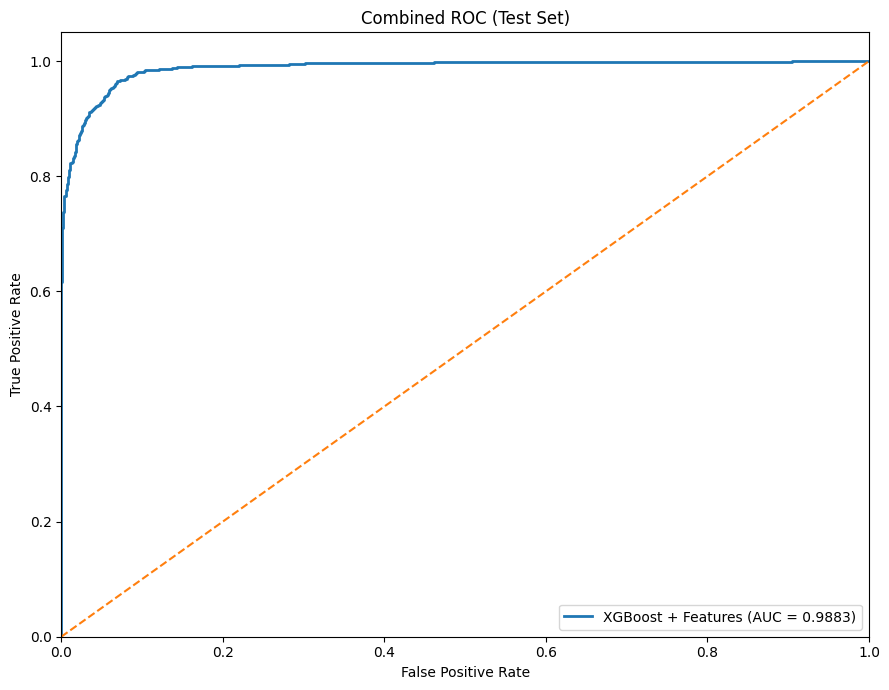

In [25]:
# --- Block 5: evaluation (table + ROC; no permutation importance on val) ---
from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_metrics(y_true, y_pred):
    return {
        "macro_f1": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "micro_f1": f1_score(y_true, y_pred, average="micro", zero_division=0),
        "weighted_f1": f1_score(y_true, y_pred, average="weighted", zero_division=0),
        "accuracy": (y_true == y_pred).mean(),
    }

def bootstrap_ci(y_true, y_pred, n_resamples=1000, alpha=0.95):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    N = len(y_true)
    lo_q = (1 - alpha) / 2 * 100.0
    hi_q = (1 - (1 - alpha) / 2) * 100.0

    macro_vals, micro_vals, weighted_vals = [], [], []
    f1_real_vals, f1_mis_vals = [], []

    rng = np.random.default_rng(42)
    for _ in range(n_resamples):
        idx = rng.integers(0, N, size=N)
        yt, yp = y_true[idx], y_pred[idx]
        macro_vals.append(f1_score(yt, yp, average='macro', zero_division=0))
        micro_vals.append(f1_score(yt, yp, average='micro', zero_division=0))
        weighted_vals.append(f1_score(yt, yp, average='weighted', zero_division=0))
        f1_real_vals.append(f1_score(yt, yp, pos_label=0, zero_division=0))
        f1_mis_vals.append(f1_score(yt, yp, pos_label=1, zero_division=0))

    return {
        'Macro F1': np.percentile(macro_vals, [lo_q, hi_q]).tolist(),
        'Micro F1': np.percentile(micro_vals, [lo_q, hi_q]).tolist(),
        'Weighted F1': np.percentile(weighted_vals, [lo_q, hi_q]).tolist(),
        'F1-score Real (0)': np.percentile(f1_real_vals, [lo_q, hi_q]).tolist(),
        'F1-score Misinformation (1)': np.percentile(f1_mis_vals, [lo_q, hi_q]).tolist(),
    }

# -----------------------------------------------------------------------
# 1) Build/extend results_dict for whatever models you have available.
#    Below: example for XGB only. Add other models similarly.
# -----------------------------------------------------------------------
results_dict = {}

# If you trained XGB in Block 3 and have feats_te / scaler_xgb:
X_test_scaled = scaler_xgb.transform(feats_te)
y_test = test_df[cfg.LABEL_COL].astype(int).values
proba_xgb = clf_xgb.predict_proba(X_test_scaled)[:, 1]
pred_xgb  = (proba_xgb >= 0.5).astype(int)
results_dict['XGBoost + Features'] = {
    'y_true': y_test,
    'y_pred': pred_xgb,
    'y_prob': proba_xgb
}

# If/when you have other models, add entries like:
# results_dict['XLM-R Only'] = {'y_true': y_true_xlmr, 'y_pred': y_pred_xlmr, 'y_prob': y_prob_xlmr[:,1]}
# results_dict['Simple Fusion'] = {'y_true': y_true_simple, 'y_pred': y_pred_simple, 'y_prob': y_prob_simple[:,1]}
# results_dict['Gated Fusion']  = {'y_true': y_true_gated,  'y_pred': y_pred_gated,  'y_prob': y_prob_gated[:,1]}

# -----------------------------------------------------------------------
# 2) Make the summary table with the exact fields you want
# -----------------------------------------------------------------------
table_data = []
for name, res in results_dict.items():
    y_true = res['y_true']
    y_pred = res['y_pred']
    y_prob = res['y_prob']

    metrics = compute_metrics(y_true, y_pred)
    cis = bootstrap_ci(y_true, y_pred, n_resamples=1000, alpha=0.95)

    row = {
        "Model": name,
        "AUC-ROC": roc_auc_score(y_true, y_prob),
        "Precision_Real": precision_score(y_true, y_pred, pos_label=0, zero_division=0),
        "Recall_Real": recall_score(y_true, y_pred, pos_label=0, zero_division=0),
        "F1_Real": f1_score(y_true, y_pred, pos_label=0, zero_division=0),
        "CI_F1_Real_low":  cis['F1-score Real (0)'][0],
        "CI_F1_Real_high": cis['F1-score Real (0)'][1],
        "Precision_Misinfo": precision_score(y_true, y_pred, pos_label=1, zero_division=0),
        "Recall_Misinfo":    recall_score(y_true, y_pred, pos_label=1, zero_division=0),
        "F1_Misinfo":        f1_score(y_true, y_pred, pos_label=1, zero_division=0),
        "CI_F1_Misinfo_low":  cis['F1-score Misinformation (1)'][0],
        "CI_F1_Misinfo_high": cis['F1-score Misinformation (1)'][1],
        "Macro_F1": metrics['macro_f1'],
        "CI_Macro_F1_low":  cis['Macro F1'][0],
        "CI_Macro_F1_high": cis['Macro F1'][1],
        "Micro_F1": metrics['micro_f1'],
        "CI_Micro_F1_low":  cis['Micro F1'][0],
        "CI_Micro_F1_high": cis['Micro F1'][1],
        "Weighted_F1": metrics['weighted_f1'],
        "CI_Weighted_F1_low":  cis['Weighted F1'][0],
        "CI_Weighted_F1_high": cis['Weighted F1'][1],
    }
    table_data.append(row)

results_df = pd.DataFrame(table_data)
print("\n" + "="*90)
print("Final Model Performance (Test Set)")
print("="*90)
print(results_df.to_string(index=False))

# -----------------------------------------------------------------------
# 3) Combined ROC plot (over the same TEST set)
# -----------------------------------------------------------------------
plt.figure(figsize=(9, 7))
for name, res in results_dict.items():
    y_true = res['y_true']
    y_prob = res['y_prob']
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.4f})")

plt.plot([0,1],[0,1], linestyle='--')
plt.xlim([0,1]); plt.ylim([0,1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('XG ROC (Test Set)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# NOTE:
# - We intentionally do NOT compute permutation importance on the validation set here.
# - If you want permutation importance at all, run it on TEST (or skip entirely for clean reporting).


# XLM-R

In [26]:
# --- Block 6: dataset + evaluation loop for XLM-R only ---
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizerFast, DataCollatorWithPadding, get_linear_schedule_with_warmup

class TextDatasetXLMR(Dataset):
    def __init__(self, df: pd.DataFrame, text_col: str, label_col: str, tokenizer, max_len: int):
        self.texts = df[text_col].astype(str).tolist()
        raw = df[label_col].tolist()
        ids = []
        for v in raw:
            s = str(v).strip().lower()
            if s in ("0","1"):
                ids.append(int(s))
            else:
                # fallback if labels are strings like "Real"/"Misinformation"
                ids.append(1 if s.startswith("mis") else 0)
        self.labels = ids
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tok(self.texts[idx], truncation=True, max_length=self.max_len, padding=False, return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

@torch.no_grad()
def xlmr_eval_loop(model, dataloader, device):
    model.eval()
    all_y, all_pred, all_prob = [], [], []
    for batch in tqdm(dataloader, desc="Evaluating XLM-R", leave=False):
        inputs = {k: v.to(device) for k, v in batch.items() if k in ("input_ids","attention_mask","labels")}
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)
        pred = probs.argmax(dim=-1)
        all_y.extend(inputs["labels"].cpu().tolist())
        all_pred.extend(pred.cpu().tolist())
        all_prob.extend(probs[:,1].cpu().tolist())
    return np.array(all_y), np.array(all_pred), np.array(all_prob)


In [28]:
# --- Block 7: train XLM-R only ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not hasattr(cfg, "XLM_R_OUTPUTS"):
    cfg.XLM_R_OUTPUTS = "/content/drive/MyDrive/emc/xlmr_only_outputs_clean"

os.makedirs(os.path.join(cfg.BASE_DIR, "xlmr_only_outputs_clean"), exist_ok=True)

tokenizer_xlmr = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")
train_ds = TextDatasetXLMR(train_df, cfg.TEXT_COL, cfg.LABEL_COL, tokenizer_xlmr, cfg.MAX_LEN)
val_ds   = TextDatasetXLMR(val_df,   cfg.TEXT_COL, cfg.LABEL_COL, tokenizer_xlmr, cfg.MAX_LEN)

collator = DataCollatorWithPadding(tokenizer_xlmr)
train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True, collate_fn=collator)
val_loader   = DataLoader(val_ds,   batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=collator)

model_xlmr = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2).to(device)
optimizer = torch.optim.AdamW(model_xlmr.parameters(), lr=2e-5)
total_steps = len(train_loader) * 5
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

best_val_macro = -1.0
patience = 3

for epoch in range(5):
    model_xlmr.train()
    epoch_loss = 0.0
    for batch in tqdm(train_loader, desc=f"XLM-R Epoch {epoch+1}"):
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items()}
        out = model_xlmr(**inputs)
        out.loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += out.loss.item()
    # validate
    yv, pv, _ = xlmr_eval_loop(model_xlmr, val_loader, device)
    val_macro = f1_score(yv, pv, average="macro", zero_division=0)
    print(f"Epoch {epoch+1} | train_loss={epoch_loss/len(train_loader):.4f} | val_macro={val_macro:.4f}")
    if val_macro > best_val_macro:
        best_val_macro = val_macro
        patience = 3
        model_xlmr.save_pretrained(cfg.XLM_R_OUTPUTS)
        tokenizer_xlmr.save_pretrained(cfg.XLM_R_OUTPUTS)
        print("✅ Saved new best XLM-R checkpoint.")
    else:
        patience -= 1
        if patience <= 0:
            print("⏹️ Early stopping.")
            break

# load best
model_xlmr = XLMRobertaForSequenceClassification.from_pretrained(cfg.XLM_R_OUTPUTS).to(device)
tokenizer_xlmr = XLMRobertaTokenizerFast.from_pretrained(cfg.XLM_R_OUTPUTS)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
XLM-R Epoch 1: 100%|██████████| 726/726 [02:28<00:00,  4.88it/s]


Epoch 1 | train_loss=0.1298 | val_macro=0.9318
✅ Saved new best XLM-R checkpoint.


XLM-R Epoch 2: 100%|██████████| 726/726 [02:29<00:00,  4.87it/s]


Epoch 2 | train_loss=0.0821 | val_macro=0.9377
✅ Saved new best XLM-R checkpoint.


XLM-R Epoch 3: 100%|██████████| 726/726 [02:28<00:00,  4.90it/s]


Epoch 3 | train_loss=0.0776 | val_macro=0.9390
✅ Saved new best XLM-R checkpoint.


XLM-R Epoch 4: 100%|██████████| 726/726 [02:28<00:00,  4.90it/s]


Epoch 4 | train_loss=0.0738 | val_macro=0.9404
✅ Saved new best XLM-R checkpoint.


XLM-R Epoch 5: 100%|██████████| 726/726 [02:28<00:00,  4.90it/s]


Epoch 5 | train_loss=0.0708 | val_macro=0.9383



XLM-R Only — Performance on TEST
     Model  AUC-ROC  Precision_Real  Recall_Real  F1_Real  CI_F1_Real_low  CI_F1_Real_high  Precision_Misinfo  Recall_Misinfo  F1_Misinfo  CI_F1_Misinfo_low  CI_F1_Misinfo_high  Macro_F1  CI_Macro_F1_low  CI_Macro_F1_high  Micro_F1  CI_Micro_F1_low  CI_Micro_F1_high  Weighted_F1  CI_Weighted_F1_low  CI_Weighted_F1_high
XLM-R Only 0.992875        0.939759     0.994173 0.966201        0.961441         0.970818            0.98342        0.844306    0.908569           0.895928            0.921591  0.937385          0.92903          0.946068  0.950646          0.94418          0.957364     0.949462            0.942579             0.956486


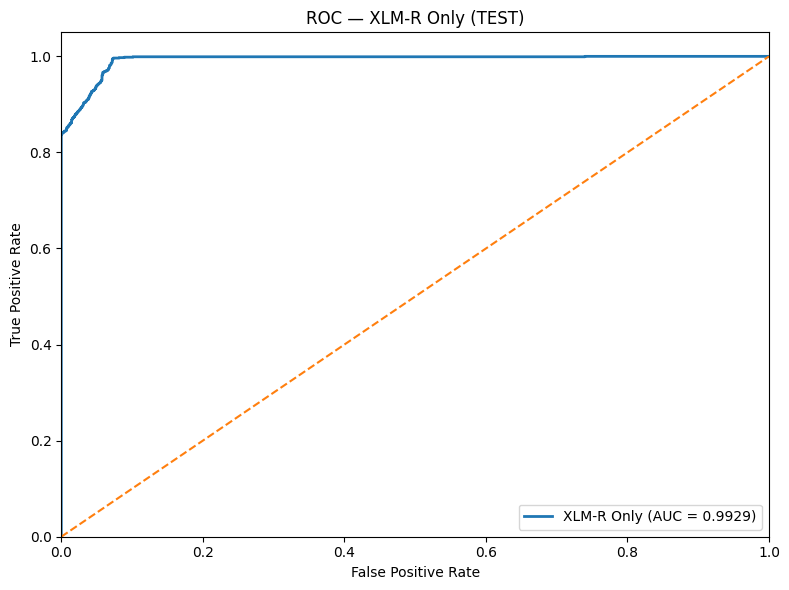

In [29]:
# --- Block 8: evaluate XLM-R only on TEST (table + ROC) ---
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc

# helpers (same schema you requested)
def compute_metrics(y_true, y_pred):
    return {
        "macro_f1": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "micro_f1": f1_score(y_true, y_pred, average="micro", zero_division=0),
        "weighted_f1": f1_score(y_true, y_pred, average="weighted", zero_division=0),
        "accuracy": (y_true == y_pred).mean(),
    }

def bootstrap_ci(y_true, y_pred, n_resamples=1000, alpha=0.95):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    N = len(y_true)
    lo_q = (1 - alpha) / 2 * 100.0
    hi_q = (1 - (1 - alpha) / 2) * 100.0
    rng = np.random.default_rng(42)

    macro_vals, micro_vals, weighted_vals = [], [], []
    f1_real_vals, f1_mis_vals = [], []
    for _ in range(n_resamples):
        idx = rng.integers(0, N, size=N)
        yt, yp = y_true[idx], y_pred[idx]
        macro_vals.append(f1_score(yt, yp, average="macro", zero_division=0))
        micro_vals.append(f1_score(yt, yp, average="micro", zero_division=0))
        weighted_vals.append(f1_score(yt, yp, average="weighted", zero_division=0))
        f1_real_vals.append(f1_score(yt, yp, pos_label=0, zero_division=0))
        f1_mis_vals.append(f1_score(yt, yp, pos_label=1, zero_division=0))
    return {
        "Macro F1": np.percentile(macro_vals, [lo_q, hi_q]).tolist(),
        "Micro F1": np.percentile(micro_vals, [lo_q, hi_q]).tolist(),
        "Weighted F1": np.percentile(weighted_vals, [lo_q, hi_q]).tolist(),
        "F1-score Real (0)": np.percentile(f1_real_vals, [lo_q, hi_q]).tolist(),
        "F1-score Misinformation (1)": np.percentile(f1_mis_vals, [lo_q, hi_q]).tolist(),
    }

# test loader
test_ds_xlmr = TextDatasetXLMR(test_df, cfg.TEXT_COL, cfg.LABEL_COL, tokenizer_xlmr, cfg.MAX_LEN)
test_loader_xlmr = DataLoader(test_ds_xlmr, batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=DataCollatorWithPadding(tokenizer_xlmr))

# evaluate
y_true, y_pred, y_prob = xlmr_eval_loop(model_xlmr, test_loader_xlmr, device)

# build table row (exact fields)
metrics = compute_metrics(y_true, y_pred)
cis = bootstrap_ci(y_true, y_pred, n_resamples=1000, alpha=0.95)
row = {
    "Model": "XLM-R Only",
    "AUC-ROC": roc_auc_score(y_true, y_prob),
    "Precision_Real": precision_score(y_true, y_pred, pos_label=0, zero_division=0),
    "Recall_Real": recall_score(y_true, y_pred, pos_label=0, zero_division=0),
    "F1_Real": f1_score(y_true, y_pred, pos_label=0, zero_division=0),
    "CI_F1_Real_low":  cis['F1-score Real (0)'][0],
    "CI_F1_Real_high": cis['F1-score Real (0)'][1],
    "Precision_Misinfo": precision_score(y_true, y_pred, pos_label=1, zero_division=0),
    "Recall_Misinfo":    recall_score(y_true, y_pred, pos_label=1, zero_division=0),
    "F1_Misinfo":        f1_score(y_true, y_pred, pos_label=1, zero_division=0),
    "CI_F1_Misinfo_low":  cis['F1-score Misinformation (1)'][0],
    "CI_F1_Misinfo_high": cis['F1-score Misinformation (1)'][1],
    "Macro_F1": metrics['macro_f1'],
    "CI_Macro_F1_low":  cis['Macro F1'][0],
    "CI_Macro_F1_high": cis['Macro F1'][1],
    "Micro_F1": metrics['micro_f1'],
    "CI_Micro_F1_low":  cis['Micro F1'][0],
    "CI_Micro_F1_high": cis['Micro F1'][1],
    "Weighted_F1": metrics['weighted_f1'],
    "CI_Weighted_F1_low":  cis['Weighted F1'][0],
    "CI_Weighted_F1_high": cis['Weighted F1'][1],
}
results_df = pd.DataFrame([row])

print("\n" + "="*90)
print("XLM-R Only — Performance on TEST")
print("="*90)
print(results_df.to_string(index=False))

# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, lw=2, label=f"XLM-R Only (AUC = {roc_auc:.4f})")
plt.plot([0,1],[0,1],'--')
plt.xlim([0,1]); plt.ylim([0,1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC — XLM-R Only (TEST)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# SIMPLE FUSION

In [30]:
# --- Block 9: train Simple Fusion ---
import os, numpy as np, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaModel, XLMRobertaTokenizerFast, get_linear_schedule_with_warmup
from sklearn.preprocessing import StandardScaler
import joblib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ensure output dir exists on cfg
if not hasattr(cfg, "SIMPLE_OUTPUTS"):
    cfg.SIMPLE_OUTPUTS = "/content/drive/MyDrive/emc/simple_fusion_outputs_clean"
os.makedirs(cfg.SIMPLE_OUTPUTS, exist_ok=True)

# tokenizer
tok_sf = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")

# ---- dataset
class TextFeatDatasetSF(Dataset):
    def __init__(self, df, tokenizer, feats, max_len=256, text_col="content", label_col="label"):
        self.texts = df[text_col].astype(str).tolist()
        raw = df[label_col].tolist()
        ids = []
        for v in raw:
            s = str(v).strip().lower()
            if s in ("0","1"): ids.append(int(s))
            else: ids.append(1 if s.startswith("mis") else 0)
        self.labels = ids
        self.tok = tokenizer
        self.max_len = max_len
        self.feats = feats.astype(np.float32)

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tok(self.texts[idx],
                       truncation=True, padding="max_length",
                       max_length=self.max_len, return_tensors="pt")
        item = {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
            "feats": torch.tensor(self.feats[idx], dtype=torch.float32),
        }
        return item

# ---- model
class SimpleFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + n_feats, n_labels)

    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        # mean pool with attention mask
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        fused = torch.cat([pooled, feats], dim=1)
        return self.classifier(self.dropout(fused))

@torch.no_grad()
def simple_eval_loop(model, loader, device):
    model.eval()
    y_all, p_all, prob_all = [], [], []
    for batch in loader:
        ids = batch["input_ids"].to(device)
        am  = batch["attention_mask"].to(device)
        ft  = batch["feats"].to(device)
        log = model(ids, am, ft)
        prob = torch.softmax(log, dim=-1)
        pred = prob.argmax(dim=-1)
        y_all.extend(batch["labels"].cpu().tolist())
        p_all.extend(pred.cpu().tolist())
        prob_all.extend(prob[:,1].cpu().tolist())
    return np.array(y_all), np.array(p_all), np.array(prob_all)

# ---- scale features (fit on train, transform val), persist scaler
scaler_simple = StandardScaler()
feats_tr_sc = scaler_simple.fit_transform(feats_tr).astype(np.float32)
feats_v_sc  = scaler_simple.transform(feats_v).astype(np.float32)
joblib.dump(scaler_simple, os.path.join(cfg.SIMPLE_OUTPUTS, "scaler12.pkl"))

# ---- loaders
train_ds_sf = TextFeatDatasetSF(train_df, tok_sf, feats_tr_sc, max_len=cfg.MAX_LEN,
                                text_col=cfg.TEXT_COL, label_col=cfg.LABEL_COL)
val_ds_sf   = TextFeatDatasetSF(val_df,   tok_sf, feats_v_sc,  max_len=cfg.MAX_LEN,
                                text_col=cfg.TEXT_COL, label_col=cfg.LABEL_COL)

train_loader_sf = DataLoader(train_ds_sf, batch_size=cfg.BATCH_SIZE, shuffle=True)
val_loader_sf   = DataLoader(val_ds_sf,   batch_size=cfg.BATCH_SIZE, shuffle=False)

# ---- train loop with early stop on Val Macro-F1
model_sf = SimpleFusion("xlm-roberta-base", n_feats=cfg.N_FEATURES, n_labels=2).to(device)
opt  = torch.optim.AdamW(model_sf.parameters(), lr=2e-5)
sched = get_linear_schedule_with_warmup(opt, num_warmup_steps=0,
                                        num_training_steps=len(train_loader_sf)*5)
crit = nn.CrossEntropyLoss()

best_val_macro = -1.0
patience = 3
for epoch in range(5):
    model_sf.train()
    epoch_loss = 0.0
    for batch in tqdm(train_loader_sf, desc=f"Simple Fusion Epoch {epoch+1}"):
        opt.zero_grad()
        ids = batch["input_ids"].to(device)
        am  = batch["attention_mask"].to(device)
        ft  = batch["feats"].to(device)
        y   = batch["labels"].to(device)
        logits = model_sf(ids, am, ft)
        loss = crit(logits, y)
        loss.backward()
        opt.step(); sched.step()
        epoch_loss += loss.item()

    # validate
    from sklearn.metrics import f1_score
    yv, pv, _ = simple_eval_loop(model_sf, val_loader_sf, device)
    val_macro = f1_score(yv, pv, average="macro", zero_division=0)
    print(f"Epoch {epoch+1} | train_loss={epoch_loss/len(train_loader_sf):.4f} | val_macro={val_macro:.4f}")

    if val_macro > best_val_macro:
        best_val_macro = val_macro
        patience = 3
        torch.save(model_sf.state_dict(), os.path.join(cfg.SIMPLE_OUTPUTS, "fusion_simple.pt"))
        print("✅ Saved new best Simple Fusion checkpoint.")
    else:
        patience -= 1
        if patience <= 0:
            print("⏹️ Early stopping.")
            break

# load best
model_sf.load_state_dict(torch.load(os.path.join(cfg.SIMPLE_OUTPUTS, "fusion_simple.pt"), map_location=device))
model_sf.to(device)
print("✅ Simple Fusion ready.")


Simple Fusion Epoch 1: 100%|██████████| 726/726 [02:30<00:00,  4.84it/s]


Epoch 1 | train_loss=0.1022 | val_macro=0.9395
✅ Saved new best Simple Fusion checkpoint.


Simple Fusion Epoch 2: 100%|██████████| 726/726 [02:30<00:00,  4.83it/s]


Epoch 2 | train_loss=0.0769 | val_macro=0.9418
✅ Saved new best Simple Fusion checkpoint.


Simple Fusion Epoch 3: 100%|██████████| 726/726 [02:30<00:00,  4.83it/s]


Epoch 3 | train_loss=0.0758 | val_macro=0.9353


Simple Fusion Epoch 4: 100%|██████████| 726/726 [02:30<00:00,  4.83it/s]


Epoch 4 | train_loss=0.0725 | val_macro=0.9398


Simple Fusion Epoch 5: 100%|██████████| 726/726 [02:30<00:00,  4.84it/s]


Epoch 5 | train_loss=0.0700 | val_macro=0.9357
⏹️ Early stopping.
✅ Simple Fusion ready.



Simple Fusion — Performance on TEST
        Model  AUC-ROC  Precision_Real  Recall_Real  F1_Real  CI_F1_Real_low  CI_F1_Real_high  Precision_Misinfo  Recall_Misinfo  F1_Misinfo  CI_F1_Misinfo_low  CI_F1_Misinfo_high  Macro_F1  CI_Macro_F1_low  CI_Macro_F1_high  Micro_F1  CI_Micro_F1_low  CI_Micro_F1_high  Weighted_F1  CI_Weighted_F1_low  CI_Weighted_F1_high
Simple Fusion  0.99354        0.994944     0.931537 0.962197        0.956752         0.967165           0.855273        0.988434    0.917045           0.905686            0.928572  0.939621         0.931274          0.947697  0.948062         0.940827           0.95478     0.949083            0.942148             0.955499


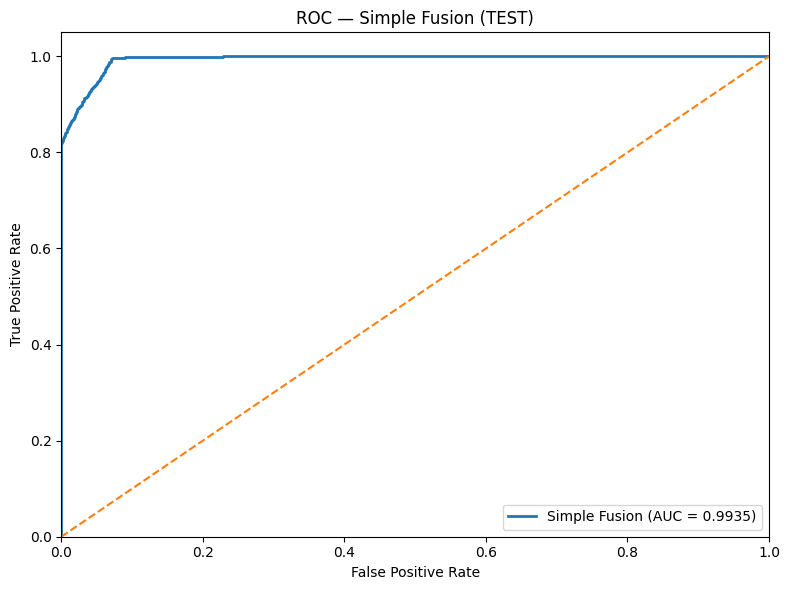

In [31]:
# --- Block 10: evaluate Simple Fusion on TEST (table + ROC) ---
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
)
import joblib

# reload scaler + scale test feats
scaler_simple = joblib.load(os.path.join(cfg.SIMPLE_OUTPUTS, "scaler12.pkl"))
feats_te_sc = scaler_simple.transform(feats_te).astype(np.float32)

# dataset/loader for test
test_ds_sf = TextFeatDatasetSF(test_df, tok_sf, feats_te_sc, max_len=cfg.MAX_LEN,
                               text_col=cfg.TEXT_COL, label_col=cfg.LABEL_COL)
test_loader_sf = DataLoader(test_ds_sf, batch_size=cfg.BATCH_SIZE, shuffle=False)

# eval
y_true_sf, y_pred_sf, y_prob_sf = simple_eval_loop(model_sf, test_loader_sf, device)

# helpers: metrics + bootstrap CIs (same schema you wanted)
def compute_metrics(y_true, y_pred):
    return {
        "macro_f1": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "micro_f1": f1_score(y_true, y_pred, average="micro", zero_division=0),
        "weighted_f1": f1_score(y_true, y_pred, average="weighted", zero_division=0),
        "accuracy": (y_true == y_pred).mean(),
    }

def bootstrap_ci(y_true, y_pred, n_resamples=1000, alpha=0.95):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    N = len(y_true)
    lo_q = (1 - alpha) / 2 * 100.0
    hi_q = (1 - (1 - alpha) / 2) * 100.0
    rng = np.random.default_rng(42)
    macro_vals, micro_vals, weighted_vals = [], [], []
    f1_real_vals, f1_mis_vals = [], []
    for _ in range(n_resamples):
        idx = rng.integers(0, N, size=N)
        yt, yp = y_true[idx], y_pred[idx]
        macro_vals.append(f1_score(yt, yp, average="macro", zero_division=0))
        micro_vals.append(f1_score(yt, yp, average="micro", zero_division=0))
        weighted_vals.append(f1_score(yt, yp, average="weighted", zero_division=0))
        f1_real_vals.append(f1_score(yt, yp, pos_label=0, zero_division=0))
        f1_mis_vals.append(f1_score(yt, yp, pos_label=1, zero_division=0))
    return {
        "Macro F1": np.percentile(macro_vals, [lo_q, hi_q]).tolist(),
        "Micro F1": np.percentile(micro_vals, [lo_q, hi_q]).tolist(),
        "Weighted F1": np.percentile(weighted_vals, [lo_q, hi_q]).tolist(),
        "F1-score Real (0)": np.percentile(f1_real_vals, [lo_q, hi_q]).tolist(),
        "F1-score Misinformation (1)": np.percentile(f1_mis_vals, [lo_q, hi_q]).tolist(),
    }

metrics = compute_metrics(y_true_sf, y_pred_sf)
cis = bootstrap_ci(y_true_sf, y_pred_sf, n_resamples=1000, alpha=0.95)

row = {
    "Model": "Simple Fusion",
    "AUC-ROC": roc_auc_score(y_true_sf, y_prob_sf),
    "Precision_Real": precision_score(y_true_sf, y_pred_sf, pos_label=0, zero_division=0),
    "Recall_Real": recall_score(y_true_sf, y_pred_sf, pos_label=0, zero_division=0),
    "F1_Real": f1_score(y_true_sf, y_pred_sf, pos_label=0, zero_division=0),
    "CI_F1_Real_low":  cis['F1-score Real (0)'][0],
    "CI_F1_Real_high": cis['F1-score Real (0)'][1],
    "Precision_Misinfo": precision_score(y_true_sf, y_pred_sf, pos_label=1, zero_division=0),
    "Recall_Misinfo":    recall_score(y_true_sf, y_pred_sf, pos_label=1, zero_division=0),
    "F1_Misinfo":        f1_score(y_true_sf, y_pred_sf, pos_label=1, zero_division=0),
    "CI_F1_Misinfo_low":  cis['F1-score Misinformation (1)'][0],
    "CI_F1_Misinfo_high": cis['F1-score Misinformation (1)'][1],
    "Macro_F1": metrics['macro_f1'],
    "CI_Macro_F1_low":  cis['Macro F1'][0],
    "CI_Macro_F1_high": cis['Macro F1'][1],
    "Micro_F1": metrics['micro_f1'],
    "CI_Micro_F1_low":  cis['Micro F1'][0],
    "CI_Micro_F1_high": cis['Micro F1'][1],
    "Weighted_F1": metrics['weighted_f1'],
    "CI_Weighted_F1_low":  cis['Weighted F1'][0],
    "CI_Weighted_F1_high": cis['Weighted F1'][1],
}
results_df_sf = pd.DataFrame([row])

print("\n" + "="*90)
print("Simple Fusion — Performance on TEST")
print("="*90)
print(results_df_sf.to_string(index=False))

# ROC
fpr, tpr, _ = roc_curve(y_true_sf, y_prob_sf)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, lw=2, label=f"Simple Fusion (AUC = {roc_auc:.4f})")
plt.plot([0,1],[0,1],'--')
plt.xlim([0,1]); plt.ylim([0,1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC — Simple Fusion (TEST)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# GATED FUSION

In [32]:
# --- Block 11: train Gated Fusion ---
import os, numpy as np, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaModel, XLMRobertaTokenizerFast, get_linear_schedule_with_warmup
from sklearn.preprocessing import StandardScaler
import joblib
from tqdm import tqdm
from sklearn.metrics import f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ensure output dir exists on cfg
if not hasattr(cfg, "GATED_OUTPUTS"):
    cfg.GATED_OUTPUTS = "/content/drive/MyDrive/emc/gated_fusion_outputs_clean"
os.makedirs(cfg.GATED_OUTPUTS, exist_ok=True)

# tokenizer
tok_gf = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")

# ---- dataset
class TextFeatDatasetGF(Dataset):
    def __init__(self, df, tokenizer, feats, max_len=256, text_col="content", label_col="label"):
        self.texts = df[text_col].astype(str).tolist()
        raw = df[label_col].tolist()
        ids = []
        for v in raw:
            s = str(v).strip().lower()
            if s in ("0","1"): ids.append(int(s))
            else: ids.append(1 if s.startswith("mis") else 0)
        self.labels = ids
        self.tok = tokenizer
        self.max_len = max_len
        self.feats = feats.astype(np.float32)

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tok(self.texts[idx],
                       truncation=True, padding="max_length",
                       max_length=self.max_len, return_tensors="pt")
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
            "feats": torch.tensor(self.feats[idx], dtype=torch.float32),
        }

# ---- model
class GatedFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2, feat_proj: int = 64):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.fe_proj = nn.Sequential(nn.Linear(n_feats, feat_proj), nn.ReLU())
        self.gate    = nn.Sequential(nn.Linear(H + n_feats, 64), nn.ReLU(), nn.Linear(64, 1), nn.Sigmoid())
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + feat_proj, n_labels)

    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        # mean pool with attention mask
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        alpha = self.gate(torch.cat([pooled, feats], dim=1))      # (B,1)
        ef    = self.fe_proj(feats)                               # (B,feat_proj)
        fused = torch.cat([pooled, alpha * ef], dim=1)            # gate-modulated features
        return self.classifier(self.dropout(fused))

@torch.no_grad()
def gated_eval_loop(model, loader, device):
    model.eval()
    y_all, p_all, prob_all = [], [], []
    for batch in loader:
        ids = batch["input_ids"].to(device)
        am  = batch["attention_mask"].to(device)
        ft  = batch["feats"].to(device)
        log = model(ids, am, ft)
        prob = torch.softmax(log, dim=-1)
        pred = prob.argmax(dim=-1)
        y_all.extend(batch["labels"].cpu().tolist())
        p_all.extend(pred.cpu().tolist())
        prob_all.extend(prob[:,1].cpu().tolist())
    return np.array(y_all), np.array(p_all), np.array(prob_all)

# ---- scale features (fit on train, transform val), persist scaler
scaler_gated = StandardScaler()
feats_tr_sc = scaler_gated.fit_transform(feats_tr).astype(np.float32)
feats_v_sc  = scaler_gated.transform(feats_v).astype(np.float32)
joblib.dump(scaler_gated, os.path.join(cfg.GATED_OUTPUTS, "scaler12.pkl"))

# ---- loaders
train_ds_gf = TextFeatDatasetGF(train_df, tok_gf, feats_tr_sc, max_len=cfg.MAX_LEN,
                                text_col=cfg.TEXT_COL, label_col=cfg.LABEL_COL)
val_ds_gf   = TextFeatDatasetGF(val_df,   tok_gf, feats_v_sc,  max_len=cfg.MAX_LEN,
                                text_col=cfg.TEXT_COL, label_col=cfg.LABEL_COL)

train_loader_gf = DataLoader(train_ds_gf, batch_size=cfg.BATCH_SIZE, shuffle=True)
val_loader_gf   = DataLoader(val_ds_gf,   batch_size=cfg.BATCH_SIZE, shuffle=False)

# ---- train loop with early stop on Val Macro-F1
model_gf = GatedFusion("xlm-roberta-base", n_feats=cfg.N_FEATURES, n_labels=2, feat_proj=64).to(device)
opt  = torch.optim.AdamW(model_gf.parameters(), lr=2e-5)
sched = get_linear_schedule_with_warmup(opt, num_warmup_steps=0,
                                        num_training_steps=len(train_loader_gf)*5)
crit = nn.CrossEntropyLoss()

best_val_macro = -1.0
patience = 3
for epoch in range(5):
    model_gf.train()
    epoch_loss = 0.0
    for batch in tqdm(train_loader_gf, desc=f"Gated Fusion Epoch {epoch+1}"):
        opt.zero_grad()
        ids = batch["input_ids"].to(device)
        am  = batch["attention_mask"].to(device)
        ft  = batch["feats"].to(device)
        y   = batch["labels"].to(device)
        logits = model_gf(ids, am, ft)
        loss = crit(logits, y)
        loss.backward()
        opt.step(); sched.step()
        epoch_loss += loss.item()

    # validate
    yv, pv, _ = gated_eval_loop(model_gf, val_loader_gf, device)
    val_macro = f1_score(yv, pv, average="macro", zero_division=0)
    print(f"Epoch {epoch+1} | train_loss={epoch_loss/len(train_loader_gf):.4f} | val_macro={val_macro:.4f}")

    if val_macro > best_val_macro:
        best_val_macro = val_macro
        patience = 3
        torch.save(model_gf.state_dict(), os.path.join(cfg.GATED_OUTPUTS, "fusion_gated.pt"))
        print("✅ Saved new best Gated Fusion checkpoint.")
    else:
        patience -= 1
        if patience <= 0:
            print("⏹️ Early stopping.")
            break

# load best
model_gf.load_state_dict(torch.load(os.path.join(cfg.GATED_OUTPUTS, "fusion_gated.pt"), map_location=device))
model_gf.to(device)
print("✅ Gated Fusion ready.")


Gated Fusion Epoch 1: 100%|██████████| 726/726 [02:30<00:00,  4.83it/s]


Epoch 1 | train_loss=0.1077 | val_macro=0.9456
✅ Saved new best Gated Fusion checkpoint.


Gated Fusion Epoch 2: 100%|██████████| 726/726 [02:30<00:00,  4.82it/s]


Epoch 2 | train_loss=0.0785 | val_macro=0.9384


Gated Fusion Epoch 3: 100%|██████████| 726/726 [02:30<00:00,  4.82it/s]


Epoch 3 | train_loss=0.0747 | val_macro=0.9413


Gated Fusion Epoch 4: 100%|██████████| 726/726 [02:30<00:00,  4.83it/s]


Epoch 4 | train_loss=0.0720 | val_macro=0.9441
⏹️ Early stopping.
✅ Gated Fusion ready.



Gated Fusion — Performance on TEST
       Model  AUC-ROC  Precision_Real  Recall_Real  F1_Real  CI_F1_Real_low  CI_F1_Real_high  Precision_Misinfo  Recall_Misinfo  F1_Misinfo  CI_F1_Misinfo_low  CI_F1_Misinfo_high  Macro_F1  CI_Macro_F1_low  CI_Macro_F1_high  Micro_F1  CI_Micro_F1_low  CI_Micro_F1_high  Weighted_F1  CI_Weighted_F1_low  CI_Weighted_F1_high
Gated Fusion 0.993911        0.977778     0.961398 0.969519        0.964889         0.974078           0.909402        0.946619    0.927637           0.916692            0.938792  0.948578         0.941036          0.956168  0.957106         0.950898          0.963566     0.957355             0.95108             0.963711


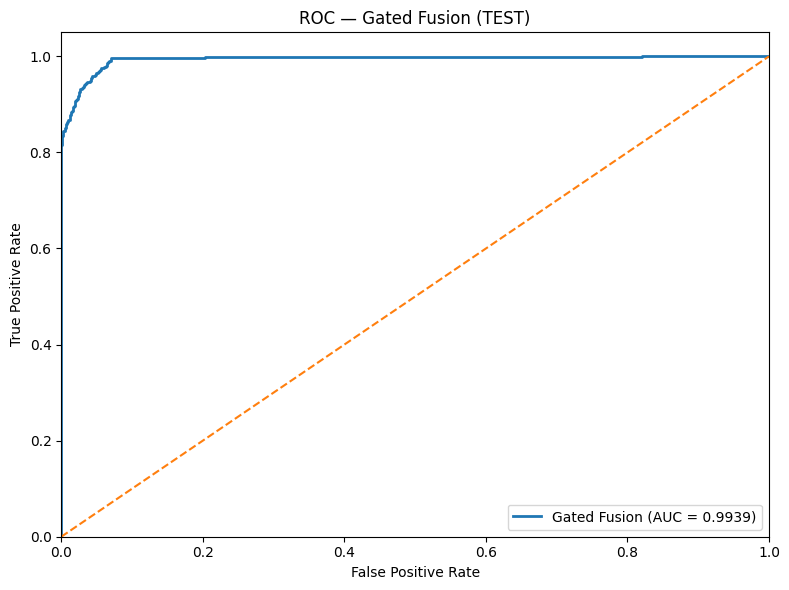

In [33]:
# --- Block 12: evaluate Gated Fusion on TEST (table + ROC) ---
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
)
import joblib

# reload scaler + scale test feats
scaler_gated = joblib.load(os.path.join(cfg.GATED_OUTPUTS, "scaler12.pkl"))
feats_te_sc = scaler_gated.transform(feats_te).astype(np.float32)

# dataset/loader for test
test_ds_gf = TextFeatDatasetGF(test_df, tok_gf, feats_te_sc, max_len=cfg.MAX_LEN,
                               text_col=cfg.TEXT_COL, label_col=cfg.LABEL_COL)
test_loader_gf = DataLoader(test_ds_gf, batch_size=cfg.BATCH_SIZE, shuffle=False)

# eval
y_true_gf, y_pred_gf, y_prob_gf = gated_eval_loop(model_gf, test_loader_gf, device)

# helpers: metrics + bootstrap CIs (your schema)
def compute_metrics(y_true, y_pred):
    return {
        "macro_f1": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "micro_f1": f1_score(y_true, y_pred, average="micro", zero_division=0),
        "weighted_f1": f1_score(y_true, y_pred, average="weighted", zero_division=0),
        "accuracy": (y_true == y_pred).mean(),
    }

def bootstrap_ci(y_true, y_pred, n_resamples=1000, alpha=0.95):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    N = len(y_true)
    lo_q = (1 - alpha) / 2 * 100.0
    hi_q = (1 - (1 - alpha) / 2) * 100.0
    rng = np.random.default_rng(42)
    macro_vals, micro_vals, weighted_vals = [], [], []
    f1_real_vals, f1_mis_vals = [], []
    for _ in range(n_resamples):
        idx = rng.integers(0, N, size=N)
        yt, yp = y_true[idx], y_pred[idx]
        macro_vals.append(f1_score(yt, yp, average="macro", zero_division=0))
        micro_vals.append(f1_score(yt, yp, average="micro", zero_division=0))
        weighted_vals.append(f1_score(yt, yp, average="weighted", zero_division=0))
        f1_real_vals.append(f1_score(yt, yp, pos_label=0, zero_division=0))
        f1_mis_vals.append(f1_score(yt, yp, pos_label=1, zero_division=0))
    return {
        "Macro F1": np.percentile(macro_vals, [lo_q, hi_q]).tolist(),
        "Micro F1": np.percentile(micro_vals, [lo_q, hi_q]).tolist(),
        "Weighted F1": np.percentile(weighted_vals, [lo_q, hi_q]).tolist(),
        "F1-score Real (0)": np.percentile(f1_real_vals, [lo_q, hi_q]).tolist(),
        "F1-score Misinformation (1)": np.percentile(f1_mis_vals, [lo_q, hi_q]).tolist(),
    }

metrics = compute_metrics(y_true_gf, y_pred_gf)
cis = bootstrap_ci(y_true_gf, y_pred_gf, n_resamples=1000, alpha=0.95)

row = {
    "Model": "Gated Fusion",
    "AUC-ROC": roc_auc_score(y_true_gf, y_prob_gf),
    "Precision_Real": precision_score(y_true_gf, y_pred_gf, pos_label=0, zero_division=0),
    "Recall_Real": recall_score(y_true_gf, y_pred_gf, pos_label=0, zero_division=0),
    "F1_Real": f1_score(y_true_gf, y_pred_gf, pos_label=0, zero_division=0),
    "CI_F1_Real_low":  cis['F1-score Real (0)'][0],
    "CI_F1_Real_high": cis['F1-score Real (0)'][1],
    "Precision_Misinfo": precision_score(y_true_gf, y_pred_gf, pos_label=1, zero_division=0),
    "Recall_Misinfo":    recall_score(y_true_gf, y_pred_gf, pos_label=1, zero_division=0),
    "F1_Misinfo":        f1_score(y_true_gf, y_pred_gf, pos_label=1, zero_division=0),
    "CI_F1_Misinfo_low":  cis['F1-score Misinformation (1)'][0],
    "CI_F1_Misinfo_high": cis['F1-score Misinformation (1)'][1],
    "Macro_F1": metrics['macro_f1'],
    "CI_Macro_F1_low":  cis['Macro F1'][0],
    "CI_Macro_F1_high": cis['Macro F1'][1],
    "Micro_F1": metrics['micro_f1'],
    "CI_Micro_F1_low":  cis['Micro F1'][0],
    "CI_Micro_F1_high": cis['Micro F1'][1],
    "Weighted_F1": metrics['weighted_f1'],
    "CI_Weighted_F1_low":  cis['Weighted F1'][0],
    "CI_Weighted_F1_high": cis['Weighted F1'][1],
}
results_df_gf = pd.DataFrame([row])

print("\n" + "="*90)
print("Gated Fusion — Performance on TEST")
print("="*90)
print(results_df_gf.to_string(index=False))

# ROC
fpr, tpr, _ = roc_curve(y_true_gf, y_prob_gf)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, lw=2, label=f"Gated Fusion (AUC = {roc_auc:.4f})")
plt.plot([0,1],[0,1],'--')
plt.xlim([0,1]); plt.ylim([0,1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC — Gated Fusion (TEST)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# ADVERSARIAL ATTACK

In [34]:
# --- Block 13: adversarial attack functions ---
import re
import numpy as np

# seeded RNG for reproducibility
ATTACK_SEED = 12345
rng_attack = np.random.default_rng(ATTACK_SEED)

# 1) Char swap within words (keeps first/last char)
def attack_char_swap(text: str, p=0.07) -> str:
    def swap_word(w):
        if len(w) < 4: return w
        chars = list(w)
        for i in range(1, len(chars)-2):
            if rng_attack.random() < p and chars[i].isalpha() and chars[i+1].isalpha():
                chars[i], chars[i+1] = chars[i+1], chars[i]
        return ''.join(chars)
    return re.sub(r"\w+", lambda m: swap_word(m.group(0)), text or "")

# 2) Drop vowels in long words
def attack_drop_vowels(text: str, p=0.15) -> str:
    vowels = set("aeiouAEIOU")
    def dv(w):
        if len(w) < 6: return w
        if rng_attack.random() >= p: return w
        return ''.join(ch for ch in w if ch not in vowels) or w
    return re.sub(r"\w+", lambda m: dv(m.group(0)), text or "")

# 3) Insert random punctuation
def attack_punct_insert(text: str, p=0.05) -> str:
    punct = ['.', ',', ';', ':', '!', '?']
    out = []
    for ch in text or "":
        out.append(ch)
        if ch.isalnum() and rng_attack.random() < p:
            out.append(rng_attack.choice(punct))
    return ''.join(out)

# 4) Whitespace noise (extra spaces/newlines)
def attack_whitespace_noise(text: str, p=0.06) -> str:
    out = []
    for ch in text or "":
        out.append(ch)
        if ch.isspace() and rng_attack.random() < p:
            out.append(' ' * rng_attack.integers(1, 4))
        elif ch.isalnum() and rng_attack.random() < (p/4):
            out.append('\n')
    return ''.join(out)

# 5) Case toggle (random casing)
def attack_case_toggle(text: str, p=0.25) -> str:
    out = []
    for ch in text or "":
        if ch.isalpha() and rng_attack.random() < p:
            out.append(ch.upper() if ch.islower() else ch.lower())
        else:
            out.append(ch)
    return ''.join(out)

# 6) Number perturbation ±5% (keep decimals & scientific format)
_num_re = re.compile(r'(?P<sign>[-+]?)(?P<int>\d+)(?P<frac>\.\d+)?(?P<exp>[eE][-+]?\d+)?')
def _format_like(orig, val):
    sign, intval, frac, exp = orig.group('sign'), orig.group('int'), orig.group('frac'), orig.group('exp')
    if exp:  # scientific
        try:
            d = "{:e}".format(val)
            # keep exponent letter case
            if 'E' in exp: d = d.replace('e', 'E')
            return (sign or '') + d
        except:
            return orig.group(0)
    if frac:
        nd = len(frac) - 1
        fmt = "{:." + str(nd) + "f}"
        return (sign or '') + fmt.format(val)
    # integer
    try:
        return (sign or '') + str(int(round(val)))
    except:
        return orig.group(0)

def attack_number_perturb(text: str, max_pct=0.05) -> str:
    def repl(m):
        s = m.group(0)
        try:
            v = float(s)
            eps = rng_attack.uniform(-max_pct, max_pct)
            nv = v * (1.0 + eps)
            return _format_like(m, nv)
        except:
            return s
    return _num_re.sub(repl, text or "")

# 7) Unicode confusables (lightweight map)
CONFUSE = {
    'a':'ɑ', 'A':'Α',  # Greek Alpha for A (looks similar)
    'e':'е', 'E':'Ε',
    'i':'і', 'I':'І',
    'o':'ο', 'O':'Ο',
    'c':'ϲ', 'C':'Ϲ',
    'p':'ρ', 'P':'Ρ',
    'x':'х', 'X':'Χ',
    'y':'у', 'Y':'Υ',
    'k':'κ', 'K':'Κ',
    'm':'ｍ', 'n':'ｎ', 'h':'һ', 's':'ѕ', 't':'τ', 'r':'г'
}
def attack_unicode_confuse(text: str, p=0.08) -> str:
    out = []
    for ch in text or "":
        if ch in CONFUSE and rng_attack.random() < p:
            out.append(CONFUSE[ch])
        else:
            out.append(ch)
    return ''.join(out)

# 8) Truncate to first N words (simulates clipping)
def attack_truncate(text: str, max_words=80) -> str:
    words = re.findall(r'\S+', text or "")
    return ' '.join(words[:max_words])

# Registry so we can loop attacks
ATTACKS = {
    "CharSwap": attack_char_swap,
    "DropVowels": attack_drop_vowels,
    "PunctInsert": attack_punct_insert,
    "WhitespaceNoise": attack_whitespace_noise,
    "CaseToggle": attack_case_toggle,
    "NumberPerturb": attack_number_perturb,
    "UnicodeConfuse": attack_unicode_confuse,
    "Truncate80w": attack_truncate,
}

def apply_attack_to_df(df: pd.DataFrame, attack_name: str, text_col: str = "content") -> pd.DataFrame:
    if attack_name not in ATTACKS:
        raise ValueError(f"Unknown attack: {attack_name}")
    f = ATTACKS[attack_name]
    attacked = df.copy()
    attacked[text_col] = [f(str(t)) for t in df[text_col].tolist()]
    return attacked


In [35]:
# --- Block 14: loaders for trained models + datasets ---
import os, joblib, torch, numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizerFast, XLMRobertaForSequenceClassification, DataCollatorWithPadding

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure output roots exist fields on cfg (for safety)
if not hasattr(cfg, "XGB_OUTPUTS"):    cfg.XGB_OUTPUTS    = "/content/drive/MyDrive/emc/xgb_outputs_clean"
if not hasattr(cfg, "XLM_R_OUTPUTS"):  cfg.XLM_R_OUTPUTS  = "/content/drive/MyDrive/emc/xlmr_only_outputs_clean"
if not hasattr(cfg, "SIMPLE_OUTPUTS"): cfg.SIMPLE_OUTPUTS = "/content/drive/MyDrive/emc/simple_fusion_outputs_clean"
if not hasattr(cfg, "GATED_OUTPUTS"):  cfg.GATED_OUTPUTS  = "/content/drive/MyDrive/emc/gated_fusion_outputs_clean"

# ---- dataset classes
class XLMRTestDS(Dataset):
    def __init__(self, df, tokenizer, text_col="content", label_col="label", max_len=256):
        self.texts = df[text_col].astype(str).tolist()
        raw = df[label_col].tolist()
        ids = []
        for v in raw:
            s = str(v).strip().lower()
            if s in ("0","1"): ids.append(int(s))
            else: ids.append(1 if s.startswith("mis") else 0)
        self.labels = ids
        self.tok = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tok(self.texts[idx], truncation=True, padding=False, max_length=self.max_len, return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

class TextFeatDS(Dataset):
    def __init__(self, df, tokenizer, feats, text_col="content", label_col="label", max_len=256):
        self.texts = df[text_col].astype(str).tolist()
        raw = df[label_col].tolist()
        ids = []
        for v in raw:
            s = str(v).strip().lower()
            if s in ("0","1"): ids.append(int(s))
            else: ids.append(1 if s.startswith("mis") else 0)
        self.labels = ids
        self.tok = tokenizer
        self.max_len = max_len
        self.feats = feats.astype(np.float32)
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tok(self.texts[idx], truncation=True, padding="max_length", max_length=self.max_len, return_tensors="pt")
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
            "feats": torch.tensor(self.feats[idx], dtype=torch.float32),
        }

# ---- fusion models
import torch.nn as nn
from transformers import XLMRobertaModel, get_linear_schedule_with_warmup

class SimpleFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + n_feats, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        fused = torch.cat([pooled, feats], dim=1)
        return self.classifier(self.dropout(fused))

class GatedFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2, feat_proj: int = 64):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.fe_proj = nn.Sequential(nn.Linear(n_feats, feat_proj), nn.ReLU())
        self.gate    = nn.Sequential(nn.Linear(H + n_feats, 64), nn.ReLU(), nn.Linear(64, 1), nn.Sigmoid())
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + feat_proj, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        alpha = self.gate(torch.cat([pooled, feats], dim=1))
        ef    = self.fe_proj(feats)
        fused = torch.cat([pooled, alpha * ef], dim=1)
        return self.classifier(self.dropout(fused))

# ---- load whatever models are available
available = {}

# XGB
try:
    import xgboost as xgb
    if os.path.exists(os.path.join(cfg.XGB_OUTPUTS, "xgb_model.json")):
        xgb_model = xgb.XGBClassifier()
        xgb_model.load_model(os.path.join(cfg.XGB_OUTPUTS, "xgb_model.json"))
        xgb_scaler = joblib.load(os.path.join(cfg.XGB_OUTPUTS, "scaler12.pkl"))
        available["XGBoost + Features"] = ("xgb", xgb_model, xgb_scaler)
        print("Loaded: XGB")
except Exception as e:
    print("XGB load skipped:", e)

# XLM-R
try:
    if os.path.exists(cfg.XLM_R_OUTPUTS):
        xlmr_tok = XLMRobertaTokenizerFast.from_pretrained(cfg.XLM_R_OUTPUTS)
        xlmr_model = XLMRobertaForSequenceClassification.from_pretrained(cfg.XLM_R_OUTPUTS).to(device)
        available["XLM-R Only"] = ("xlmr", xlmr_model, xlmr_tok)
        print("Loaded: XLM-R")
except Exception as e:
    print("XLM-R load skipped:", e)

# Simple Fusion
try:
    if os.path.exists(os.path.join(cfg.SIMPLE_OUTPUTS, "fusion_simple.pt")):
        sf_tok = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")
        sf_model = SimpleFusion("xlm-roberta-base", n_feats=cfg.N_FEATURES, n_labels=2).to(device)
        sf_model.load_state_dict(torch.load(os.path.join(cfg.SIMPLE_OUTPUTS, "fusion_simple.pt"), map_location=device))
        sf_scaler = joblib.load(os.path.join(cfg.SIMPLE_OUTPUTS, "scaler12.pkl"))
        available["Simple Fusion"] = ("simple", sf_model, (sf_tok, sf_scaler))
        print("Loaded: Simple Fusion")
except Exception as e:
    print("Simple Fusion load skipped:", e)

# Gated Fusion
try:
    if os.path.exists(os.path.join(cfg.GATED_OUTPUTS, "fusion_gated.pt")):
        gf_tok = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")
        gf_model = GatedFusion("xlm-roberta-base", n_feats=cfg.N_FEATURES, n_labels=2, feat_proj=64).to(device)
        gf_model.load_state_dict(torch.load(os.path.join(cfg.GATED_OUTPUTS, "fusion_gated.pt"), map_location=device))
        gf_scaler = joblib.load(os.path.join(cfg.GATED_OUTPUTS, "scaler12.pkl"))
        available["Gated Fusion"] = ("gated", gf_model, (gf_tok, gf_scaler))
        print("Loaded: Gated Fusion")
except Exception as e:
    print("Gated Fusion load skipped:", e)

if not available:
    raise RuntimeError("No models found. Train/load at least one model before running adversarial eval.")


Loaded: XGB
Loaded: XLM-R
Loaded: Simple Fusion
Loaded: Gated Fusion


In [36]:
# --- Block 15: evaluation helpers ---
from sklearn.metrics import f1_score, accuracy_score

# ensure we have extractor (from earlier blocks) for XGB features
try:
    fe  # existing instance
except NameError:
    # create minimal extractor from cfg paths
    lex = TermsLexicon(cfg.TERMS_CSV)
    fe = FeatureExtractor12(lex)

@torch.no_grad()
def eval_xlmr(df):
    model = available["XLM-R Only"][1]
    tok   = available["XLM-R Only"][2]
    ds = XLMRTestDS(df, tok, text_col=cfg.TEXT_COL, label_col=cfg.LABEL_COL, max_len=cfg.MAX_LEN)
    dl = DataLoader(ds, batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=DataCollatorWithPadding(tok))
    model.eval()
    y_all, p_all = [], []
    for batch in dl:
        ins = {k: v.to(device) for k, v in batch.items() if k in ("input_ids","attention_mask","labels")}
        logits = model(**ins).logits
        pred = logits.argmax(dim=-1)
        y_all.extend(ins["labels"].cpu().tolist())
        p_all.extend(pred.cpu().tolist())
    y_all = np.array(y_all); p_all = np.array(p_all)
    return {
        "macro_f1": f1_score(y_all, p_all, average="macro", zero_division=0),
        "accuracy": accuracy_score(y_all, p_all),
    }

@torch.no_grad()
def eval_simple(df):
    model = available["Simple Fusion"][1]
    tok, scaler = available["Simple Fusion"][2]
    X = fe.extract_df(df)
    Xs = scaler.transform(X).astype(np.float32)
    ds = TextFeatDS(df, tok, Xs, text_col=cfg.TEXT_COL, label_col=cfg.LABEL_COL, max_len=cfg.MAX_LEN)
    dl = DataLoader(ds, batch_size=cfg.BATCH_SIZE, shuffle=False)
    model.eval()
    y_all, p_all = [], []
    for b in dl:
        ids = b["input_ids"].to(device); am = b["attention_mask"].to(device); ft = b["feats"].to(device)
        logits = model(ids, am, ft)
        pred = logits.argmax(dim=-1)
        y_all.extend(b["labels"].cpu().tolist()); p_all.extend(pred.cpu().tolist())
    y_all = np.array(y_all); p_all = np.array(p_all)
    return {
        "macro_f1": f1_score(y_all, p_all, average="macro", zero_division=0),
        "accuracy": accuracy_score(y_all, p_all),
    }

@torch.no_grad()
def eval_gated(df):
    model = available["Gated Fusion"][1]
    tok, scaler = available["Gated Fusion"][2]
    X = fe.extract_df(df)
    Xs = scaler.transform(X).astype(np.float32)
    ds = TextFeatDS(df, tok, Xs, text_col=cfg.TEXT_COL, label_col=cfg.LABEL_COL, max_len=cfg.MAX_LEN)
    dl = DataLoader(ds, batch_size=cfg.BATCH_SIZE, shuffle=False)
    model.eval()
    y_all, p_all = [], []
    for b in dl:
        ids = b["input_ids"].to(device); am = b["attention_mask"].to(device); ft = b["feats"].to(device)
        logits = model(ids, am, ft)
        pred = logits.argmax(dim=-1)
        y_all.extend(b["labels"].cpu().tolist()); p_all.extend(pred.cpu().tolist())
    y_all = np.array(y_all); p_all = np.array(p_all)
    return {
        "macro_f1": f1_score(y_all, p_all, average="macro", zero_division=0),
        "accuracy": accuracy_score(y_all, p_all),
    }

def eval_xgb(df):
    import xgboost as xgb
    model = available["XGBoost + Features"][1]
    scaler = available["XGBoost + Features"][2]
    X = fe.extract_df(df)
    Xs = scaler.transform(X)
    y = df[cfg.LABEL_COL].astype(int).values
    pred = model.predict(Xs)
    return {
        "macro_f1": f1_score(y, pred, average="macro", zero_division=0),
        "accuracy": accuracy_score(y, pred),
    }

def evaluate_models_on_df(df, attack_name: str):
    rows = []
    for name, (kind, *_rest) in available.items():
        if kind == "xlmr":
            m = eval_xlmr(df)
        elif kind == "simple":
            m = eval_simple(df)
        elif kind == "gated":
            m = eval_gated(df)
        elif kind == "xgb":
            m = eval_xgb(df)
        else:
            continue
        rows.append({"Model": name, "Attack": attack_name, "macro_f1": m["macro_f1"], "accuracy": m["accuracy"]})
    return rows


In [37]:
# --- Block 16: CLEAN evaluation -> clean_eval.csv ---
import os, pandas as pd

adv_out_dir = "/content/drive/MyDrive/emc/adv_eval_outputs"
os.makedirs(adv_out_dir, exist_ok=True)

clean_rows = evaluate_models_on_df(test_df, attack_name="Clean")
clean_df = pd.DataFrame(clean_rows)
clean_path = os.path.join(adv_out_dir, "clean_eval.csv")
clean_df.to_csv(clean_path, index=False)
print("Wrote:", clean_path)
print(clean_df)


Extracting features: 100%|██████████| 3870/3870 [00:07<00:00, 527.92it/s]


Wrote: /content/drive/MyDrive/emc/adv_eval_outputs/clean_eval.csv
                Model Attack  macro_f1  accuracy
0  XGBoost + Features  Clean  0.937771  0.948837
1          XLM-R Only  Clean  0.937385  0.950646
2       Simple Fusion  Clean  0.939621  0.948062
3        Gated Fusion  Clean  0.948578  0.957106


In [38]:
# --- Block 17: adversarial evaluation for all attacks -> adversarial_eval.csv ---
import pandas as pd
all_rows = []

# run each registered attack on test_df
for attack_name in ATTACKS.keys():
    print(f"Running attack: {attack_name}")
    adv_df = apply_attack_to_df(test_df, attack_name, text_col=cfg.TEXT_COL)
    rows = evaluate_models_on_df(adv_df, attack_name=attack_name)
    all_rows.extend(rows)

adv_df_out = pd.DataFrame(all_rows)
adv_path = os.path.join(adv_out_dir, "adversarial_eval.csv")
adv_df_out.to_csv(adv_path, index=False)
print("Wrote:", adv_path)
print(adv_df_out.head())


Running attack: CharSwap


Extracting features: 100%|██████████| 3870/3870 [00:08<00:00, 468.91it/s]


Running attack: DropVowels


Extracting features: 100%|██████████| 3870/3870 [00:07<00:00, 501.55it/s]


Running attack: PunctInsert


Extracting features: 100%|██████████| 3870/3870 [00:08<00:00, 454.53it/s]


Running attack: WhitespaceNoise


Extracting features: 100%|██████████| 3870/3870 [00:08<00:00, 470.70it/s]


Running attack: CaseToggle


Extracting features: 100%|██████████| 3870/3870 [00:07<00:00, 498.95it/s]


Running attack: NumberPerturb


Extracting features: 100%|██████████| 3870/3870 [00:07<00:00, 513.86it/s]


Running attack: UnicodeConfuse


Extracting features: 100%|██████████| 3870/3870 [00:09<00:00, 414.93it/s]


Running attack: Truncate80w


Extracting features: 100%|██████████| 3870/3870 [00:02<00:00, 1356.75it/s]


Wrote: /content/drive/MyDrive/emc/adv_eval_outputs/adversarial_eval.csv
                Model      Attack  macro_f1  accuracy
0  XGBoost + Features    CharSwap  0.927505  0.940052
1          XLM-R Only    CharSwap  0.935531  0.949354
2       Simple Fusion    CharSwap  0.941907  0.950646
3        Gated Fusion    CharSwap  0.950681  0.959690
4  XGBoost + Features  DropVowels  0.930557  0.943411


In [39]:
# --- Block 18: (optional) print combined results using your function ---
import os, pandas as pd

def print_combined_results(output_dir):
    clean_file = os.path.join(output_dir, 'clean_eval.csv')
    adv_file   = os.path.join(output_dir, 'adversarial_eval.csv')
    try:
        clean_df = pd.read_csv(clean_file)
        adv_df   = pd.read_csv(adv_file)
    except FileNotFoundError as e:
        print(f"Error: {e}.")
        raise

    clean_scores = clean_df.pivot(index='Model', columns='Attack', values='macro_f1').rename(columns={'Clean': 'Clean Macro F1'})
    adv_scores   = adv_df.pivot(index='Model', columns='Attack', values='macro_f1')
    combined = pd.concat([clean_scores, adv_scores], axis=1)

    for attack in adv_scores.columns:
        combined[f'Drop from {attack}'] = combined['Clean Macro F1'] - combined[attack]

    sorted_cols = (
        ['Clean Macro F1'] +
        [c for c in combined.columns if isinstance(c, str) and c.startswith('Drop')] +
        [c for c in combined.columns if c not in ['Clean Macro F1'] and not (isinstance(c, str) and c.startswith('Drop'))]
    )
    combined = combined[sorted_cols]
    print("\n--- Combined Model Performance and Robustness (Macro F1) ---")
    print(combined.round(4).to_string())

print_combined_results("/content/drive/MyDrive/emc/adv_eval_outputs")



--- Combined Model Performance and Robustness (Macro F1) ---
Attack              Clean Macro F1  DropVowels  Drop from CaseToggle  Drop from CharSwap  Drop from DropVowels  Drop from NumberPerturb  Drop from PunctInsert  Drop from Truncate80w  Drop from UnicodeConfuse  Drop from WhitespaceNoise  CaseToggle  CharSwap  NumberPerturb  PunctInsert  Truncate80w  UnicodeConfuse  WhitespaceNoise
Model                                                                                                                                                                                                                                                                                                                                     
Gated Fusion                0.9486      0.9505                0.0081             -0.0021               -0.0019                   0.0003                 0.0078                 0.0186                   -0.0009                    -0.0039      0.9404    0.9507         0.9483     

In [40]:
# --- Block 19: domain-cue attack helpers + functions ---
import re
import numpy as np

rng_dom = np.random.default_rng(424242)

# Expand domain lexicons (kept small & transparent; tune as needed)
STD_PREFIXES = r"(?:ISO|IEC|EN|ASTM|ANSI|IEEE|ASME|DIN|UL|EASA|FAA|NIST|OSHA|EPA|DOE|NASA)"
STD_WORDS = [
    "standard", "standards", "specification", "specifications", "compliance",
    "regulation", "regulations", "requirement", "requirements", "certification",
    "qualification", "directive", "guideline", "guidelines"
]
SAFETY_WORDS = [
    "safety", "hazard", "hazards", "warning", "warnings", "risk", "risks",
    "caution", "danger", "emergency", "fail-safe", "failsafe", "fault tolerance",
    "redundancy", "interlock", "lockout", "tagout"
]

# Units (common engineering units)
UNIT_LIST = [
    "kg","g","mg","lb","N","kN","MN","Pa","kPa","MPa","GPa","psi","bar",
    "m","mm","cm","km","in","ft",
    "°C","°F","K","J","kJ","MJ","W","kW","MW","V","kV","A","mA",
    "Hz","kHz","MHz","GHz","s","ms","μs","ns","ohm","Ω","rpm"
]
# Regexes
RE_STD_NUMBER = re.compile(rf"\b{STD_PREFIXES}\s*[\d]{{2,5}}(?:[-:]\d+)*\b", re.I)    # e.g., ISO 26262-6:2018
RE_ACRONYM    = re.compile(rf"\b(?:{STD_PREFIXES})\b", re.I)                            # e.g., FAA, NIST, ISO
RE_UNIT       = re.compile(r"\b(" + "|".join(map(re.escape, UNIT_LIST)) + r")\b", re.I)
RE_CIT_BRACK  = re.compile(r"\[\s*\d+\s*\]")                                            # [12]
RE_CIT_YEAR   = re.compile(r"\((?:[A-Z][A-Za-z\.\-]+(?:\s+[A-Z][A-Za-z\.\-]+)*)\s+((19|20)\d{2})\)")  # (Hartzell 2021)
RE_WORD       = re.compile(r"\b\w+\b")

def _preserve_case(src: str, repl: str) -> str:
    return repl.upper() if src.isupper() else (repl.capitalize() if src[0].isupper() else repl.lower())

# Keyword sets for quick matching
STD_WORDS_SET    = set(w.lower() for w in STD_WORDS)
SAFETY_WORDS_SET = set(w.lower() for w in SAFETY_WORDS)

# 1) Mask domain terms (standards/safety/common domain nouns)
def attack_mask_domain_terms(text: str, mask_token="[TERM]") -> str:
    if not text: return text
    def repl_word(m):
        w = m.group(0)
        wl = w.lower()
        if wl in STD_WORDS_SET or wl in SAFETY_WORDS_SET:
            return mask_token
        return w
    # mask standalone words
    t = RE_WORD.sub(repl_word, text)
    # mask complete "ISO 26262-6:2018" style mentions
    t = RE_STD_NUMBER.sub(mask_token, t)
    return t

# 2) Drop domain terms entirely
def attack_drop_domain_terms(text: str) -> str:
    if not text: return text
    t = RE_STD_NUMBER.sub("", text)
    def repl_word(m):
        w = m.group(0)
        if w.lower() in STD_WORDS_SET or w.lower() in SAFETY_WORDS_SET:
            return ""
        return w
    t = RE_WORD.sub(repl_word, t)
    # collapse multiple spaces
    t = re.sub(r"\s{2,}", " ", t).strip()
    return t

# 3) Swap domain terms with generic synonyms (reduce salience)
DOMAIN_SYNONYMS = {
    # safety-ish
    "safety": "protection",
    "hazard": "threat",
    "hazards": "threats",
    "warning": "notice",
    "warnings": "notices",
    "risk": "chance",
    "risks": "chances",
    "caution": "care",
    "danger": "peril",
    "emergency": "crisis",
    "fail-safe": "fallback",
    "failsafe": "fallback",
    "redundancy": "backup",
    "interlock": "block",
    # standards-ish
    "standard": "document",
    "standards": "documents",
    "specification": "description",
    "specifications": "descriptions",
    "compliance": "conformance",
    "regulation": "rule",
    "regulations": "rules",
    "requirement": "condition",
    "requirements": "conditions",
    "certification": "approval",
    "qualification": "approval",
    "directive": "instruction",
    "guideline": "recommendation",
    "guidelines": "recommendations",
}
def attack_synonym_swap_domain(text: str, p=1.0) -> str:
    if not text: return text
    def repl_word(m):
        w = m.group(0)
        wl = w.lower()
        if wl in DOMAIN_SYNONYMS and rng_dom.random() < p:
            return _preserve_case(w, DOMAIN_SYNONYMS[wl])
        return w
    t = RE_WORD.sub(repl_word, text)
    # Also neuter full standard refs to generic "doc"
    t = RE_STD_NUMBER.sub("doc", t)
    return t

# 4) Corrupt standard numbers slightly (keep prefix, tweak digits)
def _tweak_digits(s: str) -> str:
    def tweak_digit(d):
        nd = (int(d) + rng_dom.integers(1, 9)) % 10
        return str(nd)
    return re.sub(r"\d", lambda m: tweak_digit(m.group(0)), s, count=rng_dom.integers(1, 3))  # tweak 1–2 digits

def attack_standard_number_corrupt(text: str) -> str:
    if not text: return text
    def repl(m):
        s = m.group(0)
        # split prefix and the rest so we keep "ISO" etc.
        parts = re.split(r"(\s+)", s, maxsplit=1)
        if len(parts) >= 3:
            prefix, sp, rest = parts[0], parts[1], parts[2]
            return prefix + sp + _tweak_digits(rest)
        return _tweak_digits(s)
    return RE_STD_NUMBER.sub(repl, text)

# 5) Neutralize units to generic token or corrupt them
def attack_unit_neutralize(text: str, mode="mask"):  # mode: mask|drop|generic
    if not text: return text
    if mode == "drop":
        return RE_UNIT.sub("", text)
    elif mode == "generic":
        return RE_UNIT.sub(" unit ", text)
    else:  # mask
        return RE_UNIT.sub("[u]", text)

# 6) Acronym split/perturb (FAA -> F.A.A. or F A A or faA)
def attack_acronym_perturb(text: str) -> str:
    if not text: return text
    def repl(m):
        s = m.group(0)
        forms = [ ".".join(list(s)) + ".", " ".join(list(s)), s.lower(), s.capitalize() ]
        return rng_dom.choice(forms)
    return RE_ACRONYM.sub(repl, text)

# 7) Strip citations ( [12] and (Surname 2021) patterns )
def attack_citation_strip(text: str) -> str:
    if not text: return text
    t = RE_CIT_BRACK.sub("", text)
    t = RE_CIT_YEAR.sub("", t)
    # collapse extra spaces
    t = re.sub(r"\s{2,}", " ", t).strip()
    return t

# 8) Engineering symbol normalization (remove or ascii-fy)
SYMBOL_MAP = {
    "°": " deg ", "±": "+/-", "μ": "u", "Ω": "ohm", "×": "x", "·": ".", "≈": "~",
    "≤": "<=", "≥": ">=", "∑": "sum", "∏": "prod", "∂": "d", "∞": "inf"
}
def attack_symbol_ascii(text: str) -> str:
    if not text: return text
    return "".join(SYMBOL_MAP.get(ch, ch) for ch in text)

# Utility: row-level coverage (did anything change?)
def coverage_rate(df_before, df_after, text_col="content") -> float:
    before = df_before[text_col].astype(str).tolist()
    after  = df_after[text_col].astype(str).tolist()
    changed = sum(1 for b,a in zip(before, after) if b != a)
    return changed / max(1, len(before))


In [41]:
# --- Block 20: extend ATTACKS registry + define pipelines ---
try:
    ATTACKS
except NameError:
    ATTACKS = {}

ATTACKS.update({
    "MaskDomainTerms":      attack_mask_domain_terms,
    "DropDomainTerms":      attack_drop_domain_terms,
    "SynonymSwapDomain":    attack_synonym_swap_domain,
    "StandardNumCorrupt":   attack_standard_number_corrupt,
    "UnitNeutralizeMask":   lambda t: attack_unit_neutralize(t, mode="mask"),
    "UnitNeutralizeDrop":   lambda t: attack_unit_neutralize(t, mode="drop"),
    "UnitNeutralizeGeneric":lambda t: attack_unit_neutralize(t, mode="generic"),
    "AcronymPerturb":       attack_acronym_perturb,
    "CitationStrip":        attack_citation_strip,
    "SymbolAscii":          attack_symbol_ascii,
})

DOMAIN_ATTACKS = [
    "MaskDomainTerms", "DropDomainTerms", "SynonymSwapDomain",
    "StandardNumCorrupt", "UnitNeutralizeMask", "UnitNeutralizeDrop",
    "UnitNeutralizeGeneric", "AcronymPerturb", "CitationStrip", "SymbolAscii"
]

# Composed pipelines for stronger stress
PIPELINES = {
    "DomainCombo1": ["MaskDomainTerms", "StandardNumCorrupt", "UnitNeutralizeMask"],
    "DomainCombo2": ["SynonymSwapDomain", "AcronymPerturb", "CitationStrip"],
    "DomainCombo3": ["DropDomainTerms", "SymbolAscii", "UnitNeutralizeGeneric"],
    "DomainMax":    ["DropDomainTerms", "StandardNumCorrupt", "UnitNeutralizeDrop", "AcronymPerturb", "CitationStrip", "SymbolAscii"],
}

def apply_attack_to_df(df, attack_name: str, text_col="content"):
    if attack_name not in ATTACKS:
        raise ValueError(f"Unknown attack: {attack_name}")
    f = ATTACKS[attack_name]
    out = df.copy()
    out[text_col] = [f(str(t)) for t in df[text_col].tolist()]
    return out

def apply_pipeline_to_df(df, pipeline_name: str, text_col="content"):
    if pipeline_name not in PIPELINES:
        raise ValueError(f"Unknown pipeline: {pipeline_name}")
    out = df.copy()
    for step in PIPELINES[pipeline_name]:
        out[text_col] = [ATTACKS[step](t) for t in out[text_col].tolist()]
    return out


In [42]:
# --- Block 21: run individual domain attacks with coverage, save results ---
import os, pandas as pd

adv_out_dir = "/content/drive/MyDrive/emc/adv_eval_outputs"
os.makedirs(adv_out_dir, exist_ok=True)

domain_rows = []
coverage_rows = []

for attack_name in DOMAIN_ATTACKS:
    print(f"[Domain Attack] {attack_name}")
    adv_df = apply_attack_to_df(test_df, attack_name, text_col=cfg.TEXT_COL)
    cov = coverage_rate(test_df, adv_df, text_col=cfg.TEXT_COL)
    coverage_rows.append({"Attack": attack_name, "Coverage": cov})
    # evaluate on adversarial df
    rows = evaluate_models_on_df(adv_df, attack_name=attack_name)
    domain_rows.extend(rows)

# Save per-attack results
adv_domain_df = pd.DataFrame(domain_rows)
adv_domain_path = os.path.join(adv_out_dir, "adversarial_eval_domain.csv")
adv_domain_df.to_csv(adv_domain_path, index=False)
print("Wrote:", adv_domain_path)

# Save coverage stats
coverage_df = pd.DataFrame(coverage_rows).sort_values("Attack")
coverage_path = os.path.join(adv_out_dir, "adversarial_attack_coverage_domain.csv")
coverage_df.to_csv(coverage_path, index=False)
print("Wrote:", coverage_path)

print("\nCoverage preview:")
print(coverage_df.round(4).to_string(index=False))


[Domain Attack] MaskDomainTerms


Extracting features: 100%|██████████| 3870/3870 [00:07<00:00, 520.51it/s]


[Domain Attack] DropDomainTerms


Extracting features: 100%|██████████| 3870/3870 [00:07<00:00, 512.07it/s]


[Domain Attack] SynonymSwapDomain


Extracting features: 100%|██████████| 3870/3870 [00:07<00:00, 513.93it/s]


[Domain Attack] StandardNumCorrupt


Extracting features: 100%|██████████| 3870/3870 [00:07<00:00, 513.34it/s]


[Domain Attack] UnitNeutralizeMask


Extracting features: 100%|██████████| 3870/3870 [00:07<00:00, 507.89it/s]


[Domain Attack] UnitNeutralizeDrop


Extracting features: 100%|██████████| 3870/3870 [00:07<00:00, 527.13it/s]


[Domain Attack] UnitNeutralizeGeneric


Extracting features: 100%|██████████| 3870/3870 [00:07<00:00, 516.46it/s]


[Domain Attack] AcronymPerturb


Extracting features: 100%|██████████| 3870/3870 [00:07<00:00, 504.44it/s]


[Domain Attack] CitationStrip


Extracting features: 100%|██████████| 3870/3870 [00:07<00:00, 513.81it/s]


[Domain Attack] SymbolAscii


Extracting features: 100%|██████████| 3870/3870 [00:07<00:00, 513.75it/s]


Wrote: /content/drive/MyDrive/emc/adv_eval_outputs/adversarial_eval_domain.csv
Wrote: /content/drive/MyDrive/emc/adv_eval_outputs/adversarial_attack_coverage_domain.csv

Coverage preview:
               Attack  Coverage
       AcronymPerturb    0.4171
        CitationStrip    0.0034
      DropDomainTerms    0.5550
      MaskDomainTerms    0.5540
   StandardNumCorrupt    0.2509
          SymbolAscii    0.3463
    SynonymSwapDomain    0.5535
   UnitNeutralizeDrop    0.8364
UnitNeutralizeGeneric    0.8364
   UnitNeutralizeMask    0.8364


In [43]:
# --- Block 22: run composed pipelines (stronger stress), save results ---
import os, pandas as pd

adv_out_dir = "/content/drive/MyDrive/emc/adv_eval_outputs"
combo_rows = []
combo_cov_rows = []

for pname in PIPELINES.keys():
    print(f"[Domain Pipeline] {pname}")
    adv_df = apply_pipeline_to_df(test_df, pname, text_col=cfg.TEXT_COL)
    cov = coverage_rate(test_df, adv_df, text_col=cfg.TEXT_COL)
    combo_cov_rows.append({"Attack": pname, "Coverage": cov})
    rows = evaluate_models_on_df(adv_df, attack_name=pname)
    combo_rows.extend(rows)

adv_combo_df = pd.DataFrame(combo_rows)
adv_combo_path = os.path.join(adv_out_dir, "adversarial_eval_domain_combos.csv")
adv_combo_df.to_csv(adv_combo_path, index=False)
print("Wrote:", adv_combo_path)

combo_cov_df = pd.DataFrame(combo_cov_rows).sort_values("Attack")
combo_cov_path = os.path.join(adv_out_dir, "adversarial_attack_coverage_domain_combos.csv")
combo_cov_df.to_csv(combo_cov_path, index=False)
print("Wrote:", combo_cov_path)

print("\nPipeline coverage preview:")
print(combo_cov_df.round(4).to_string(index=False))


[Domain Pipeline] DomainCombo1


Extracting features: 100%|██████████| 3870/3870 [00:07<00:00, 521.96it/s]


[Domain Pipeline] DomainCombo2


Extracting features: 100%|██████████| 3870/3870 [00:07<00:00, 513.97it/s]


[Domain Pipeline] DomainCombo3


Extracting features: 100%|██████████| 3870/3870 [00:07<00:00, 528.77it/s]


[Domain Pipeline] DomainMax


Extracting features: 100%|██████████| 3870/3870 [00:07<00:00, 536.21it/s]


Wrote: /content/drive/MyDrive/emc/adv_eval_outputs/adversarial_eval_domain_combos.csv
Wrote: /content/drive/MyDrive/emc/adv_eval_outputs/adversarial_attack_coverage_domain_combos.csv

Pipeline coverage preview:
      Attack  Coverage
DomainCombo1    0.8525
DomainCombo2    0.6214
DomainCombo3    0.8532
   DomainMax    0.8566


In [44]:
# --- Block 23: combine Clean vs ALL attacks and compute drops ---
import os, glob
import pandas as pd
import numpy as np

ADV_OUT_DIR = "/content/drive/MyDrive/emc/adv_eval_outputs"

def _safe_read_csv(path):
    try:
        return pd.read_csv(path)
    except Exception as e:
        print(f"Skip {os.path.basename(path)}: {e}")
        return None

def _prep_clean_df(df):
    # Expect columns: Model, Attack='Clean', macro_f1, accuracy
    need = {"Model", "Attack", "macro_f1", "accuracy"}
    missing = need - set(df.columns)
    if missing:
        raise ValueError(f"clean_eval.csv missing columns: {missing}")
    clean_only = df[df["Attack"].astype(str).str.lower() == "clean"].copy()
    return clean_only

def _gather_all_attacks(dirpath: str) -> pd.DataFrame:
    # auto-discover all adversarial_eval*.csv except clean_eval.csv
    paths = sorted(glob.glob(os.path.join(dirpath, "adversarial_eval*.csv")))
    paths = [p for p in paths if not p.endswith("clean_eval.csv")]
    frames = []
    for p in paths:
        df = _safe_read_csv(p)
        if df is None:
            continue
        need = {"Model", "Attack", "macro_f1", "accuracy"}
        if not need.issubset(df.columns):
            print(f"Skip {os.path.basename(p)} (missing columns).")
            continue
        # filter out accidental 'Clean' rows (shouldn't be here, but safe)
        df = df[df["Attack"].astype(str).str.lower() != "clean"].copy()
        if len(df):
            frames.append(df)
    if not frames:
        raise RuntimeError("No adversarial_eval*.csv files found.")
    return pd.concat(frames, ignore_index=True)

def _make_drop_tables(clean_df: pd.DataFrame, adv_df: pd.DataFrame):
    # Baselines per model
    clean_macro = clean_df.pivot(index="Model", columns="Attack", values="macro_f1")
    if "Clean" not in clean_macro.columns:
        # normalize name
        clean_macro.columns = ["Clean" if str(c).lower()=="clean" else c for c in clean_macro.columns]
    clean_macro = clean_macro.rename(columns={"Clean":"Clean Macro F1"})[["Clean Macro F1"]]

    clean_acc = clean_df.pivot(index="Model", columns="Attack", values="accuracy")
    if "Clean" not in clean_acc.columns:
        clean_acc.columns = ["Clean" if str(c).lower()=="clean" else c for c in clean_acc.columns]
    clean_acc = clean_acc.rename(columns={"Clean":"Clean Accuracy"})[["Clean Accuracy"]]

    # Adversarial (all attacks gathered)
    adv_macro = adv_df.pivot_table(index="Model", columns="Attack", values="macro_f1", aggfunc="mean")
    adv_acc   = adv_df.pivot_table(index="Model", columns="Attack", values="accuracy", aggfunc="mean")

    # Combine baseline + adv, compute drops
    macro_tbl = clean_macro.join(adv_macro, how="outer")
    acc_tbl   = clean_acc.join(adv_acc,   how="outer")

    # Compute drops = Clean - Attack
    macro_drop_cols = []
    for atk in adv_macro.columns:
        col = f"Drop: {atk}"
        macro_tbl[col] = macro_tbl["Clean Macro F1"] - macro_tbl[atk]
        macro_drop_cols.append(col)

    acc_drop_cols = []
    for atk in adv_acc.columns:
        col = f"DropAcc: {atk}"
        acc_tbl[col] = acc_tbl["Clean Accuracy"] - acc_tbl[atk]
        acc_drop_cols.append(col)

    # Order: baseline, all drop cols (alpha), then attack scores
    macro_cols = ["Clean Macro F1"] + sorted(macro_drop_cols) + list(adv_macro.columns)
    acc_cols   = ["Clean Accuracy"] + sorted(acc_drop_cols) + list(adv_acc.columns)

    macro_tbl = macro_tbl.reindex(columns=macro_cols)
    acc_tbl   = acc_tbl.reindex(columns=acc_cols)

    return macro_tbl.sort_index(), acc_tbl.sort_index()

def build_and_save_drop_tables(out_dir=ADV_OUT_DIR):
    clean_path = os.path.join(out_dir, "clean_eval.csv")
    if not os.path.exists(clean_path):
        raise FileNotFoundError(f"Missing clean_eval.csv in {out_dir}")
    clean_df = _prep_clean_df(pd.read_csv(clean_path))
    adv_df   = _gather_all_attacks(out_dir)

    macro_tbl, acc_tbl = _make_drop_tables(clean_df, adv_df)

    # Save
    macro_out = os.path.join(out_dir, "combined_drops_macro_f1.csv")
    acc_out   = os.path.join(out_dir, "combined_drops_accuracy.csv")
    macro_tbl.to_csv(macro_out)
    acc_tbl.to_csv(acc_out)

    # Long format for ad-hoc plotting
    macro_long = adv_df.merge(
        clean_df[["Model","macro_f1"]].rename(columns={"macro_f1":"clean_macro_f1"}),
        on="Model", how="left"
    )
    macro_long["drop_macro_f1"] = macro_long["clean_macro_f1"] - macro_long["macro_f1"]
    macro_long_out = os.path.join(out_dir, "long_drops_macro_f1.csv")
    macro_long.to_csv(macro_long_out, index=False)

    print("Wrote:")
    print(" ", macro_out)
    print(" ", acc_out)
    print(" ", macro_long_out)
    print("\n--- Combined Drops (Macro F1) preview ---")
    print(macro_tbl.round(4).to_string())
    return macro_tbl, acc_tbl, macro_long

macro_tbl, acc_tbl, macro_long = build_and_save_drop_tables(ADV_OUT_DIR)


Wrote:
  /content/drive/MyDrive/emc/adv_eval_outputs/combined_drops_macro_f1.csv
  /content/drive/MyDrive/emc/adv_eval_outputs/combined_drops_accuracy.csv
  /content/drive/MyDrive/emc/adv_eval_outputs/long_drops_macro_f1.csv

--- Combined Drops (Macro F1) preview ---
Attack                Clean Macro F1  Drop: AcronymPerturb  Drop: CaseToggle  Drop: CharSwap  Drop: CitationStrip  Drop: Cue Removal  Drop: DomainCombo1  Drop: DomainCombo2  Drop: DomainCombo3  Drop: DomainMax  Drop: DropDomainTerms  Drop: DropVowels  Drop: Keyword Removal (NEW)  Drop: MaskDomainTerms  Drop: NumberPerturb  Drop: Numbers/Units  Drop: Numeric Perturbation (NEW)  Drop: PunctInsert  Drop: StandardNumCorrupt  Drop: Structure (mix)  Drop: SymbolAscii  Drop: SynonymSwapDomain  Drop: Synonyms (word)  Drop: Truncate80w  Drop: Typos (char)  Drop: UnicodeConfuse  Drop: Unit Conversion (NEW)  Drop: UnitNeutralizeDrop  Drop: UnitNeutralizeGeneric  Drop: UnitNeutralizeMask  Drop: WhitespaceNoise  AcronymPerturb  CaseTog

In [45]:
# --- Block 24: summarize worst-case & average drops per model ---
import pandas as pd
import numpy as np
import os

ADV_OUT_DIR = "/content/drive/MyDrive/emc/adv_eval_outputs"
macro_tbl = pd.read_csv(os.path.join(ADV_OUT_DIR, "combined_drops_macro_f1.csv"), index_col=0)

# Extract drop columns (they start with "Drop: ")
drop_cols = [c for c in macro_tbl.columns if c.startswith("Drop: ")]
if not drop_cols:
    raise RuntimeError("No drop columns found in combined_drops_macro_f1.csv")

# Worst (max) drop and the attack causing it
worst_attack = macro_tbl[drop_cols].idxmax(axis=1).rename("Worst Attack")
worst_drop   = macro_tbl[drop_cols].max(axis=1).rename("Worst Drop (Macro F1)")

# Average drop across attacks
avg_drop = macro_tbl[drop_cols].mean(axis=1).rename("Avg Drop (Macro F1)")

summary = pd.concat([worst_attack, worst_drop, avg_drop], axis=1).sort_values("Worst Drop (Macro F1)", ascending=False)
print("\n--- Per-Model Drop Summary (Macro F1) ---")
print(summary.round(4).to_string())

# Save summary
summary_out = os.path.join(ADV_OUT_DIR, "summary_drops_macro_f1.csv")
summary.to_csv(summary_out)
print("\nWrote:", summary_out)



--- Per-Model Drop Summary (Macro F1) ---
                           Worst Attack  Worst Drop (Macro F1)  Avg Drop (Macro F1)
Model                                                                              
XGBoost + Features    Drop: Truncate80w                 0.5181               0.0308
Gated Fusion          Drop: Truncate80w                 0.0186               0.0015
Simple Fusion          Drop: CaseToggle                 0.0117               0.0016
XLM-R Only            Drop: Truncate80w                 0.0069               0.0023
Gated Fusion (mask)                 NaN                    NaN                  NaN
Simple Fusion (mask)                NaN                    NaN                  NaN

Wrote: /content/drive/MyDrive/emc/adv_eval_outputs/summary_drops_macro_f1.csv


/tmp/ipython-input-3875539439.py:15: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  worst_attack = macro_tbl[drop_cols].idxmax(axis=1).rename("Worst Attack")


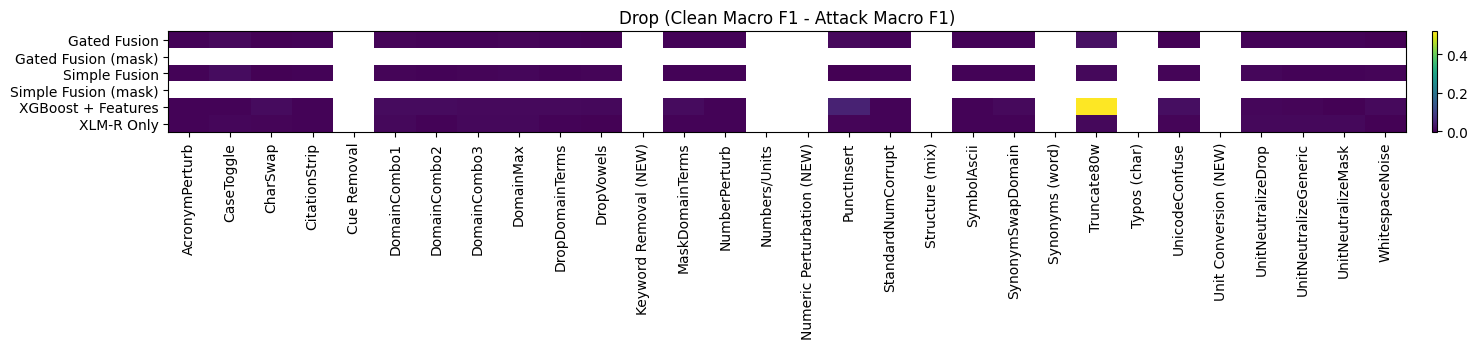

Saved: /content/drive/MyDrive/emc/adv_eval_outputs/drops_heatmap_macro_f1.png


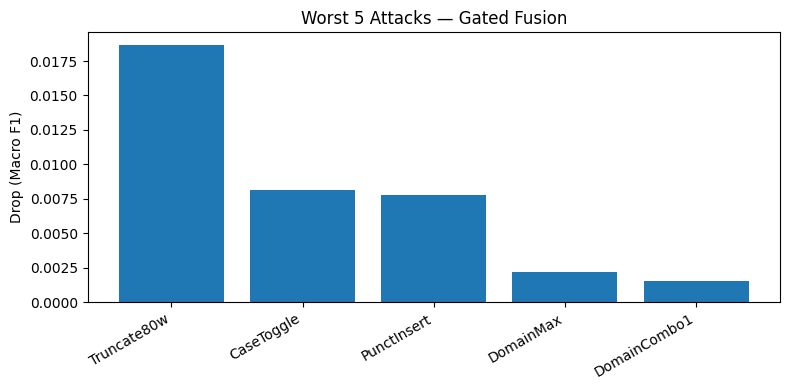

Saved: /content/drive/MyDrive/emc/adv_eval_outputs/Gated_Fusion_worst5_drops.png


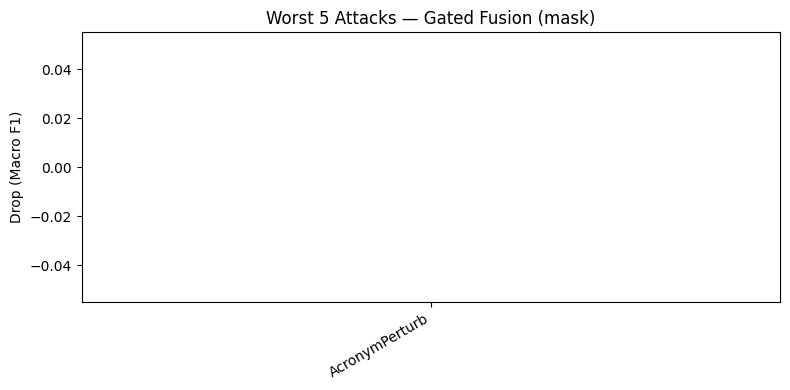

Saved: /content/drive/MyDrive/emc/adv_eval_outputs/Gated_Fusion_(mask)_worst5_drops.png


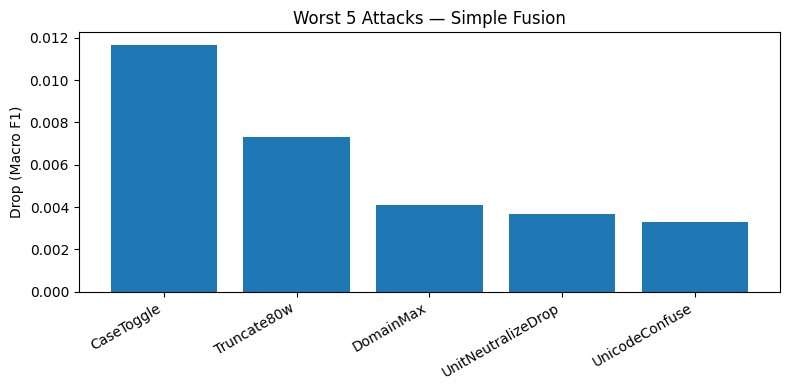

Saved: /content/drive/MyDrive/emc/adv_eval_outputs/Simple_Fusion_worst5_drops.png


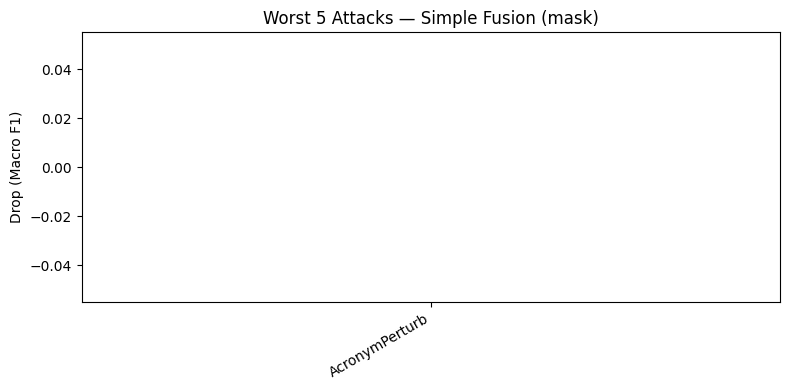

Saved: /content/drive/MyDrive/emc/adv_eval_outputs/Simple_Fusion_(mask)_worst5_drops.png


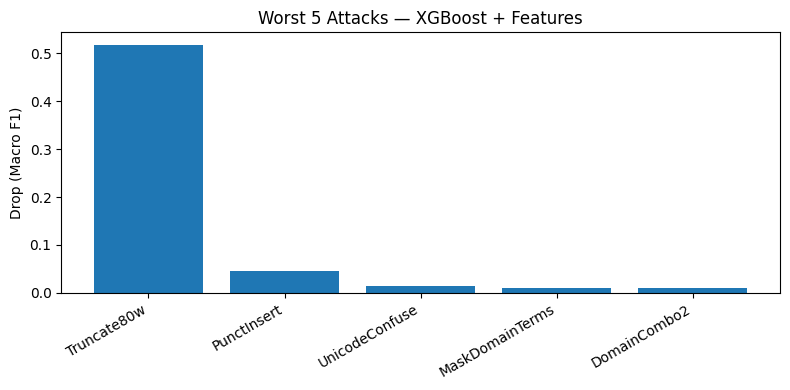

Saved: /content/drive/MyDrive/emc/adv_eval_outputs/XGBoost_+_Features_worst5_drops.png


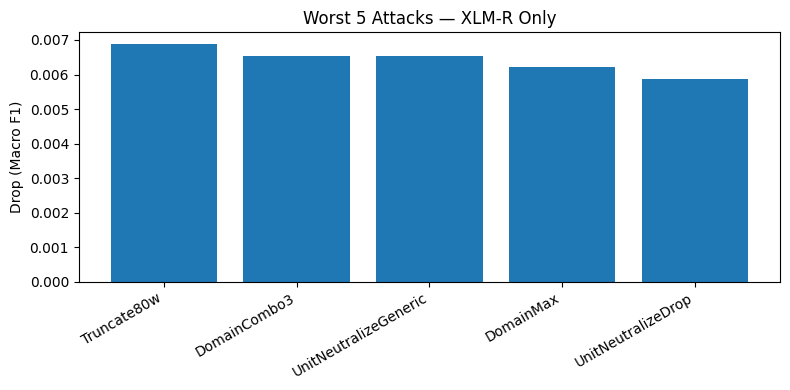

Saved: /content/drive/MyDrive/emc/adv_eval_outputs/XLM-R_Only_worst5_drops.png


In [46]:
# --- Block 25: optional matplotlib visuals ---
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ADV_OUT_DIR = "/content/drive/MyDrive/emc/adv_eval_outputs"
macro_tbl = pd.read_csv(os.path.join(ADV_OUT_DIR, "combined_drops_macro_f1.csv"), index_col=0)
drop_cols = [c for c in macro_tbl.columns if c.startswith("Drop: ")]

# Heatmap-style plot (matplotlib only)
plt.figure(figsize=(max(8, len(drop_cols)*0.5), 0.6*len(macro_tbl)))
im = plt.imshow(macro_tbl[drop_cols].values, aspect="auto")
plt.colorbar(im, fraction=0.022, pad=0.02)
plt.xticks(ticks=np.arange(len(drop_cols)), labels=[c.replace("Drop: ","") for c in drop_cols], rotation=90)
plt.yticks(ticks=np.arange(len(macro_tbl.index)), labels=macro_tbl.index)
plt.title("Drop (Clean Macro F1 - Attack Macro F1)")
plt.tight_layout()
heatmap_path = os.path.join(ADV_OUT_DIR, "drops_heatmap_macro_f1.png")
plt.savefig(heatmap_path, dpi=200)
plt.show()
print("Saved:", heatmap_path)

# Per-model top-5 worst attacks bar chart(s)
for model, row in macro_tbl.iterrows():
    drops = row[drop_cols].sort_values(ascending=False).head(5)
    plt.figure(figsize=(8,4))
    plt.bar(drops.index.str.replace("Drop: ","", regex=False), drops.values)
    plt.ylabel("Drop (Macro F1)")
    plt.title(f"Worst 5 Attacks — {model}")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    outp = os.path.join(ADV_OUT_DIR, f"{model.replace(' ','_')}_worst5_drops.png")
    plt.savefig(outp, dpi=200)
    plt.show()
    print("Saved:", outp)


In [47]:
# --- Block 26: Build clean long table (Macro-F1) for manuscript ---
import os, glob, re
import pandas as pd
import numpy as np

ADV_OUT_DIR = "/content/drive/MyDrive/emc/adv_eval_outputs"
OUT_DIR     = os.path.join(ADV_OUT_DIR, "manuscript_tables")
os.makedirs(OUT_DIR, exist_ok=True)

def _safe_read_csv(path):
    try:
        return pd.read_csv(path)
    except Exception as e:
        print(f"Skip {os.path.basename(path)}: {e}")
        return None

def _prettify_attack(name: str) -> str:
    mapping = {
        "CharSwap":"Character Swap",
        "DropVowels":"Drop Vowels",
        "PunctInsert":"Punctuation Insert",
        "WhitespaceNoise":"Whitespace Noise",
        "CaseToggle":"Case Toggle",
        "NumberPerturb":"Number Perturbation",
        "UnicodeConfuse":"Unicode Confusables",
        "Truncate80w":"Truncate (80 words)",
        "MaskDomainTerms":"Mask Domain Terms",
        "DropDomainTerms":"Drop Domain Terms",
        "SynonymSwapDomain":"Synonym Swap (Domain)",
        "StandardNumCorrupt":"Corrupt Standard Number",
        "UnitNeutralizeMask":"Unit Neutralize (Mask)",
        "UnitNeutralizeDrop":"Unit Neutralize (Drop)",
        "UnitNeutralizeGeneric":"Unit Neutralize (Generic)",
        "AcronymPerturb":"Acronym Perturbation",
        "CitationStrip":"Strip Citations",
        "SymbolAscii":"Normalize Symbols",
        "DomainCombo1":"Domain Combo 1",
        "DomainCombo2":"Domain Combo 2",
        "DomainCombo3":"Domain Combo 3",
        "DomainMax":"Domain Combo (Max)",
        "Clean":"Clean"
    }
    if name in mapping:
        return mapping[name]
    # fallback: split CamelCase → words
    pretty = re.sub(r'(?<!^)(?=[A-Z])', ' ', str(name)).strip()
    pretty = pretty.replace("_", " ")
    return pretty

def _collect_clean_df(dirpath: str) -> pd.DataFrame:
    p = os.path.join(dirpath, "clean_eval.csv")
    if not os.path.exists(p):
        raise FileNotFoundError(f"Missing clean_eval.csv in {dirpath}")
    df = pd.read_csv(p)
    need = {"Model","Attack","macro_f1","accuracy"}
    if not need.issubset(df.columns):
        raise ValueError(f"clean_eval.csv missing columns {need - set(df.columns)}")
    # keep only the 'Clean' rows (robust to case)
    df = df[df["Attack"].astype(str).str.lower()=="clean"].copy()
    df = df.rename(columns={"macro_f1":"clean_macro_f1", "accuracy":"clean_accuracy"})
    df["Attack"] = "Clean"
    return df[["Model","Attack","clean_macro_f1","clean_accuracy"]]

def _collect_adv_long(dirpath: str) -> pd.DataFrame:
    paths = sorted(glob.glob(os.path.join(dirpath, "adversarial_eval*.csv")))
    paths = [p for p in paths if not p.endswith("clean_eval.csv")]
    frames = []
    for p in paths:
        df = _safe_read_csv(p)
        if df is None:
            continue
        need = {"Model","Attack","macro_f1","accuracy"}
        if not need.issubset(df.columns):
            continue
        df = df[df["Attack"].astype(str).str.lower()!="clean"].copy()
        if len(df):
            frames.append(df[["Model","Attack","macro_f1","accuracy"]])
    if not frames:
        raise RuntimeError("No adversarial_eval*.csv files found.")
    adv = pd.concat(frames, ignore_index=True)
    return adv

def _collect_coverage(dirpath: str) -> pd.DataFrame:
    # optional
    cov_paths = [
        os.path.join(dirpath, "adversarial_attack_coverage_domain.csv"),
        os.path.join(dirpath, "adversarial_attack_coverage_domain_combos.csv")
    ]
    frames = []
    for p in cov_paths:
        if os.path.exists(p):
            df = _safe_read_csv(p)
            if df is not None and {"Attack","Coverage"}.issubset(df.columns):
                frames.append(df[["Attack","Coverage"]])
    if frames:
        cov = pd.concat(frames, ignore_index=True)
        # if duplicates (same name from multiple files), average
        cov = cov.groupby("Attack", as_index=False)["Coverage"].mean()
        return cov
    return pd.DataFrame(columns=["Attack","Coverage"])

def build_long_macro_table(dirpath=ADV_OUT_DIR, round_digits=3, order="by_drop_mean"):
    clean = _collect_clean_df(dirpath)
    adv   = _collect_adv_long(dirpath)
    cov   = _collect_coverage(dirpath)  # optional

    # merge clean baseline onto adv to compute drops
    merged = adv.merge(clean[["Model","clean_macro_f1"]], on="Model", how="left")
    merged["Delta"]  = merged["clean_macro_f1"] - merged["macro_f1"]
    merged["Delta%"] = 100.0 * merged["Delta"] / merged["clean_macro_f1"].replace(0.0, np.nan)

    # pretty names
    merged["Attack Pretty"] = merged["Attack"].map(_prettify_attack)

    # optional coverage
    if len(cov):
        merged = merged.merge(cov, left_on="Attack", right_on="Attack", how="left")
    else:
        merged["Coverage"] = np.nan

    # column order
    cols = ["Model", "Attack Pretty", "clean_macro_f1", "macro_f1", "Delta", "Delta%", "Coverage"]
    out  = merged[cols].rename(columns={
        "Attack Pretty":"Attack",
        "clean_macro_f1":"Clean Macro F1",
        "macro_f1":"Attack Macro F1",
    })

    # ordering
    if order == "by_drop_mean":
        # sort attacks by mean drop across models (descending), and within each model by drop
        attack_order = out.groupby("Attack")["Delta"].mean().sort_values(ascending=False).index.tolist()
        out["Attack"] = pd.Categorical(out["Attack"], categories=attack_order, ordered=True)
        out = out.sort_values(["Model","Attack","Delta"], ascending=[True, True, False])
    elif order == "alphabetical":
        out = out.sort_values(["Model","Attack"])
    else:
        # as-is
        pass

    # rounding
    out["Clean Macro F1"]   = out["Clean Macro F1"].round(round_digits)
    out["Attack Macro F1"]  = out["Attack Macro F1"].round(round_digits)
    out["Delta"]            = out["Delta"].round(round_digits)
    out["Delta%"]           = out["Delta%"].round(1)
    if out["Coverage"].notna().any():
        out["Coverage"] = (100.0 * out["Coverage"]).round(1)

    return out

manu_long = build_long_macro_table(ADV_OUT_DIR, round_digits=3, order="by_drop_mean")
print("Preview (first 10 rows):")
print(manu_long.head(10).to_string(index=False))


Preview (first 10 rows):
       Model                 Attack  Clean Macro F1  Attack Macro F1  Delta  Delta%  Coverage
Gated Fusion    Truncate (80 words)           0.949            0.930  0.019     2.0       NaN
Gated Fusion     Punctuation Insert           0.949            0.941  0.008     0.8       NaN
Gated Fusion            Case Toggle           0.949            0.940  0.008     0.9       NaN
Gated Fusion     Domain Combo (Max)           0.949            0.946  0.002     0.2      85.7
Gated Fusion    Unicode Confusables           0.949            0.949 -0.001    -0.1       NaN
Gated Fusion         Domain Combo 1           0.949            0.947  0.002     0.2      85.2
Gated Fusion         Domain Combo 3           0.949            0.948  0.001     0.1      85.3
Gated Fusion Unit Neutralize (Drop)           0.949            0.949 -0.000    -0.0      83.6
Gated Fusion      Mask Domain Terms           0.949            0.948  0.000     0.0      55.4
Gated Fusion         Domain Combo 2

In [48]:
# --- Block 27: Export CSV, Markdown, LaTeX (booktabs) ---
import os

csv_path = os.path.join(OUT_DIR, "manuscript_table_macro_f1.csv")
md_path  = os.path.join(OUT_DIR, "manuscript_table_macro_f1.md")
tex_path = os.path.join(OUT_DIR, "manuscript_table_macro_f1.tex")

manu_long.to_csv(csv_path, index=False)

# Markdown (simple, readable)
with open(md_path, "w") as f:
    f.write(manu_long.to_markdown(index=False))

# LaTeX table with booktabs; keep ASCII for Δ (%) symbols via column names
# (You can add \% in the LaTeX header for percent symbol.)
latex_tbl = manu_long.rename(columns={
    "Clean Macro F1": "Clean~F1",
    "Attack Macro F1": "Attack~F1",
    "Delta": r"$\Delta$~F1",
    "Delta%": r"$\Delta$~(\%)",
    "Coverage": "Cov.~(\%)"
}).to_latex(
    index=False,
    escape=True,
    longtable=False,
    bold_rows=False,
    column_format="llrrrrr",
    na_rep="--",
    float_format="%.3f".__mod__,
    caption="Clean vs. Adversarial Macro-F1 per model and attack.",
    label="tab:robustness_macroF1",
    buf=None,
    multicolumn=False,
    multicolumn_format="c",
    header=True
)

with open(tex_path, "w") as f:
    f.write("% Requires \\usepackage{booktabs}\n")
    f.write(latex_tbl)

print("Wrote:")
print(" ", csv_path)
print(" ", md_path)
print(" ", tex_path)


Wrote:
  /content/drive/MyDrive/emc/adv_eval_outputs/manuscript_tables/manuscript_table_macro_f1.csv
  /content/drive/MyDrive/emc/adv_eval_outputs/manuscript_tables/manuscript_table_macro_f1.md
  /content/drive/MyDrive/emc/adv_eval_outputs/manuscript_tables/manuscript_table_macro_f1.tex


<>:21: SyntaxWarning: invalid escape sequence '\%'
<>:21: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipython-input-1214310200.py:21: SyntaxWarning: invalid escape sequence '\%'
  "Coverage": "Cov.~(\%)"


In [49]:
# --- Block 28: Per-model Top-K compact tables (Markdown + LaTeX) ---
TOPK = 8  # attacks per model to keep
per_model_dir = os.path.join(OUT_DIR, "per_model")
os.makedirs(per_model_dir, exist_ok=True)

for model, dfm in manu_long.groupby("Model", as_index=False):
    df_sorted = dfm.sort_values("Delta", ascending=False).head(TOPK)
    csv_p = os.path.join(per_model_dir, f"{model.replace(' ','_')}_top{TOPK}_macro_f1.csv")
    md_p  = os.path.join(per_model_dir, f"{model.replace(' ','_')}_top{TOPK}_macro_f1.md")
    tex_p = os.path.join(per_model_dir, f"{model.replace(' ','_')}_top{TOPK}_macro_f1.tex")

    df_sorted.to_csv(csv_p, index=False)
    with open(md_p, "w") as f:
        f.write(df_sorted.to_markdown(index=False))

    latex_tbl = df_sorted.rename(columns={
        "Clean Macro F1": "Clean~F1",
        "Attack Macro F1": "Attack~F1",
        "Delta": r"$\Delta$~F1",
        "Delta%": r"$\Delta$~(\%)",
        "Coverage": "Cov.~(\%)"
    }).to_latex(
        index=False, escape=True, longtable=False, column_format="llrrrrr",
        na_rep="--", float_format="%.3f".__mod__,
        caption=f"Top-{TOPK} robustness drops for {model}.",
        label=f"tab:robustness_{model.replace(' ','_').lower()}",
        multicolumn=False, multicolumn_format="c", header=True
    )
    with open(tex_p, "w") as f:
        f.write("% Requires \\usepackage{booktabs}\n")
        f.write(latex_tbl)

print("Per-model tables written to:", per_model_dir)


Per-model tables written to: /content/drive/MyDrive/emc/adv_eval_outputs/manuscript_tables/per_model


<>:21: SyntaxWarning: invalid escape sequence '\%'
<>:21: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipython-input-3071148249.py:21: SyntaxWarning: invalid escape sequence '\%'
  "Coverage": "Cov.~(\%)"


In [50]:
# --- Block 29: Define attack groups (5–10 buckets) ---

# Tweak names or grouping as you like. Only attacks found in your CSVs will be used.
ATTACK_GROUPS = {
    # Generic noise / typos
    "CharSwap":              "Typos & Casing",
    "DropVowels":            "Typos & Casing",
    "CaseToggle":            "Typos & Casing",

    "PunctInsert":           "Punct/Whitespace Noise",
    "WhitespaceNoise":       "Punct/Whitespace Noise",

    "UnicodeConfuse":        "Unicode & Symbols",
    "SymbolAscii":           "Unicode & Symbols",

    "NumberPerturb":         "Numbers",
    "Truncate80w":           "Truncation",

    # Domain-targeted
    "MaskDomainTerms":       "Domain Terms",
    "DropDomainTerms":       "Domain Terms",
    "SynonymSwapDomain":     "Domain Terms",

    "StandardNumCorrupt":    "Standards Corruption",

    "UnitNeutralizeMask":    "Units Neutralization",
    "UnitNeutralizeDrop":    "Units Neutralization",
    "UnitNeutralizeGeneric": "Units Neutralization",

    "AcronymPerturb":        "Acronyms & Citations",
    "CitationStrip":         "Acronyms & Citations",

    # Combo pipelines (optional — keep or drop)
    "DomainCombo1":          "Domain Combos",
    "DomainCombo2":          "Domain Combos",
    "DomainCombo3":          "Domain Combos",
    "DomainMax":             "Domain Combos",
}

# If you want to reduce to <= 8 groups, keep only these:
KEEP_GROUPS = [
    "Typos & Casing",
    "Punct/Whitespace Noise",
    "Unicode & Symbols",
    "Numbers",
    "Truncation",
    "Domain Terms",
    "Standards Corruption",
    "Units Neutralization",
    # "Acronyms & Citations",  # uncomment to include
    # "Domain Combos",         # uncomment to include
]


In [51]:
# --- Block 30: Build grouped Clean vs Attack Macro-F1 table ---
import os, glob, pandas as pd, numpy as np

ADV_OUT_DIR = "/content/drive/MyDrive/emc/adv_eval_outputs"
OUT_DIR     = os.path.join(ADV_OUT_DIR, "manuscript_tables")
os.makedirs(OUT_DIR, exist_ok=True)

AGGREGATOR = "mean"   # choose: "mean", "median", or "worst" (worst = lowest F1)

def _safe_read_csv(p):
    try:
        return pd.read_csv(p)
    except Exception as e:
        print(f"Skip {os.path.basename(p)}: {e}")
        return None

def _load_clean(dirpath):
    p = os.path.join(dirpath, "clean_eval.csv")
    df = pd.read_csv(p)
    df = df[df["Attack"].astype(str).str.lower()=="clean"].copy()
    df = df.rename(columns={"macro_f1":"Clean Macro F1"})
    return df[["Model","Clean Macro F1"]]

def _load_all_attacks(dirpath):
    paths = sorted(glob.glob(os.path.join(dirpath, "adversarial_eval*.csv")))
    paths = [p for p in paths if not p.endswith("clean_eval.csv")]
    frames = []
    for p in paths:
        df = _safe_read_csv(p)
        if df is None: continue
        need = {"Model","Attack","macro_f1"}
        if not need.issubset(df.columns):
            print(f"Missing columns in {os.path.basename(p)}; skipping.")
            continue
        frames.append(df[["Model","Attack","macro_f1"]])
    if not frames:
        raise RuntimeError("No adversarial_eval*.csv found.")
    adv = pd.concat(frames, ignore_index=True)
    # keep only attacks we know how to group
    adv = adv[adv["Attack"].isin(ATTACK_GROUPS.keys())].copy()
    # map to group
    adv["Group"] = adv["Attack"].map(ATTACK_GROUPS)
    if 'KEEP_GROUPS' in globals() and KEEP_GROUPS:
        adv = adv[adv["Group"].isin(KEEP_GROUPS)].copy()
    return adv

def _aggregate_group(adv_long, how="mean"):
    # adv_long: Model, Attack, macro_f1, Group
    if how == "mean":
        agg = adv_long.groupby(["Model","Group"], as_index=False)["macro_f1"].mean()
    elif how == "median":
        agg = adv_long.groupby(["Model","Group"], as_index=False)["macro_f1"].median()
    elif how == "worst":
        # worst-case = minimum F1 within the group
        agg = adv_long.groupby(["Model","Group"], as_index=False)["macro_f1"].min()
    else:
        raise ValueError("AGGREGATOR must be one of {'mean','median','worst'}")
    agg = agg.rename(columns={"macro_f1":"Attack Macro F1"})
    return agg

def build_grouped_table(dirpath=ADV_OUT_DIR, how=AGGREGATOR, round_digits=3):
    clean = _load_clean(dirpath)
    adv   = _load_all_attacks(dirpath)
    if adv.empty:
        raise RuntimeError("No adversarial rows remain after filtering to known attacks.")
    agg = _aggregate_group(adv, how=how)

    # merge clean baseline, compute deltas
    out = agg.merge(clean, on="Model", how="left")
    out["Δ"]   = out["Clean Macro F1"] - out["Attack Macro F1"]
    out["Δ%"]  = 100.0 * out["Δ"] / out["Clean Macro F1"].replace(0.0, np.nan)

    # pretty order: sort groups by avg drop across models desc
    grp_order = out.groupby("Group")["Δ"].mean().sort_values(ascending=False).index.tolist()
    out["Group"] = pd.Categorical(out["Group"], categories=grp_order, ordered=True)
    out = out.sort_values(["Group","Model"]).reset_index(drop=True)

    # rounding
    out["Clean Macro F1"]  = out["Clean Macro F1"].round(round_digits)
    out["Attack Macro F1"] = out["Attack Macro F1"].round(round_digits)
    out["Δ"]               = out["Δ"].round(round_digits)
    out["Δ%"]              = out["Δ%"].round(1)

    return out, adv

grouped_tbl, adv_long_used = build_grouped_table(ADV_OUT_DIR, how=AGGREGATOR, round_digits=3)
print("Grouped table preview:")
print(grouped_tbl.head(10).to_string(index=False))
print("\nGroups included:", sorted(grouped_tbl['Group'].unique().tolist()))


Grouped table preview:
             Model                  Group  Attack Macro F1  Clean Macro F1      Δ   Δ%
      Gated Fusion             Truncation            0.930           0.949  0.019  2.0
     Simple Fusion             Truncation            0.932           0.940  0.007  0.8
XGBoost + Features             Truncation            0.420           0.938  0.518 55.2
        XLM-R Only             Truncation            0.931           0.937  0.007  0.7
      Gated Fusion Punct/Whitespace Noise            0.947           0.949  0.002  0.2
     Simple Fusion Punct/Whitespace Noise            0.941           0.940 -0.001 -0.1
XGBoost + Features Punct/Whitespace Noise            0.911           0.938  0.027  2.9
        XLM-R Only Punct/Whitespace Noise            0.937           0.937  0.001  0.1
      Gated Fusion         Typos & Casing            0.947           0.949  0.001  0.1
     Simple Fusion         Typos & Casing            0.936           0.940  0.004  0.4

Groups included: ['

In [52]:
# --- Block 31: Export grouped table in CSV/Markdown/LaTeX ---
import os

# filenames reflect the aggregator used
suffix = {"mean":"avg", "median":"median", "worst":"worst"}[AGGREGATOR]
base = f"manuscript_grouped_macro_f1_{suffix}"

csv_path = os.path.join(OUT_DIR, base + ".csv")
md_path  = os.path.join(OUT_DIR, base + ".md")
tex_path = os.path.join(OUT_DIR, base + ".tex")

grouped_tbl.to_csv(csv_path, index=False)

# Markdown
with open(md_path, "w") as f:
    f.write(grouped_tbl.rename(columns={"Group":"Attack Group", "Δ":"Delta", "Δ%":"Delta%"}).to_markdown(index=False))

# LaTeX (booktabs)
latex_tbl = grouped_tbl.rename(columns={
    "Group": "Attack Group",
    "Clean Macro F1": "Clean~F1",
    "Attack Macro F1": "Group~F1",
    "Δ": r"$\Delta$~F1",
    "Δ%": r"$\Delta$~(\%)",
}).to_latex(
    index=False, escape=True, longtable=False, column_format="l l r r r r",
    na_rep="--", float_format="%.3f".__mod__,
    caption=f"Clean vs. grouped adversarial Macro-F1 (aggregator = {AGGREGATOR}).",
    label=f"tab:grouped_macroF1_{suffix}",
    multicolumn=False, multicolumn_format="c", header=True
)

with open(tex_path, "w") as f:
    f.write("% Requires \\usepackage{booktabs}\n")
    f.write(latex_tbl)

print("Wrote:")
print(" ", csv_path)
print(" ", md_path)
print(" ", tex_path)


Wrote:
  /content/drive/MyDrive/emc/adv_eval_outputs/manuscript_tables/manuscript_grouped_macro_f1_avg.csv
  /content/drive/MyDrive/emc/adv_eval_outputs/manuscript_tables/manuscript_grouped_macro_f1_avg.md
  /content/drive/MyDrive/emc/adv_eval_outputs/manuscript_tables/manuscript_grouped_macro_f1_avg.tex


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


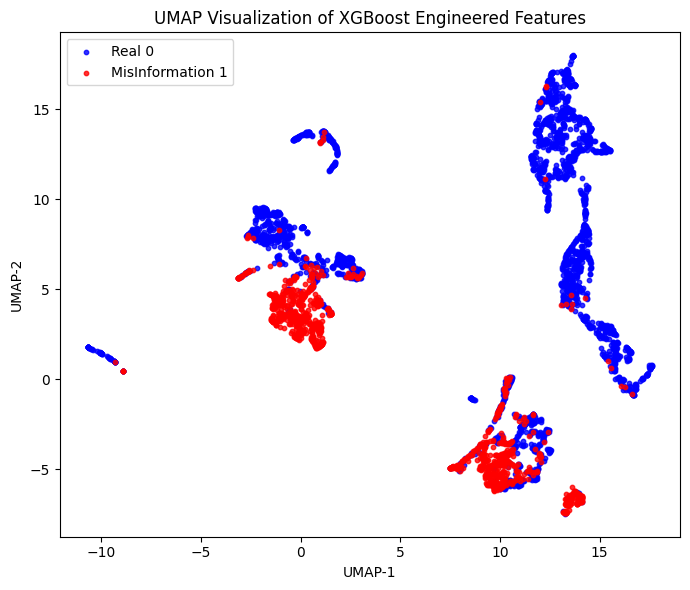

Saved UMAP figure (600 dpi): /content/drive/MyDrive/emc/xgb_outputs_clean/umap_xgb_test_2d.png
Saved UMAP coordinates: /content/drive/MyDrive/emc/xgb_outputs_clean/umap_xgb_test_2d.csv


In [3]:
# --- Block 32: UMAP for XGBoost features (blue=label 0, red=label 1), 600 dpi ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# 1) Ensure umap-learn is available
try:
    import umap
except ModuleNotFoundError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-learn"])
    import umap

# 2) Make sure we have cfg + test_df + feature extractor and scaler
try:
    cfg
except NameError:
    from dataclasses import dataclass
    @dataclass
    class _TmpCfg:
        BASE_DIR: str = "/content/drive/MyDrive/emc"
        CLEAN_TEST_CSV: str = "/content/drive/MyDrive/emc/test.csv"
        TERMS_CSV: str = "/content/drive/MyDrive/emc/engineering_terms.csv"
        XGB_OUTPUTS: str = "/content/drive/MyDrive/emc/xgb_outputs_clean"
        TEXT_COL: str = "content"
        LABEL_COL: str = "label"
        LANG_COL: str = "lang"
    cfg = _TmpCfg()

# Attempt to reuse existing test_df, else load it
try:
    test_df
except NameError:
    test_df = pd.read_csv(cfg.CLEAN_TEST_CSV)

# Ensure feature extractor exists (from earlier blocks) or re-create
try:
    fe
    lex
except NameError:
    # Minimal redefinitions to rebuild features
    import re
    import numpy as np
    import pandas as pd
    _WORD_RE = re.compile(r"\w+", re.UNICODE)
    _NUM_RE  = re.compile(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?')

    def simple_words(t: str): return _WORD_RE.findall(t or "")
    def sent_count(t: str) -> int:
        if not t: return 0
        import re as _re
        return max(1, len(_re.split(r'[.!?]+[\s\n]+', t)))
    def punct_count(t: str) -> int: return sum(1 for ch in (t or "") if ch in ".,;:!?")
    def extract_numbers(text: str):
        nums, dec = [], 0
        for m in _NUM_RE.finditer(text or ""):
            s = m.group(0)
            try:
                v = float(s)
                if ('.' in s) or ('e' in s.lower()): dec += 1
                nums.append(abs(v))
            except: pass
        return nums, dec
    def _finite_or_zero(x: float) -> float:
        try:
            xx = float(x)
            return xx if np.isfinite(xx) else 0.0
        except:
            return 0.0

    class TermsLexicon:
        def __init__(self, csv_path: str, term_col="terms", lang_col="lang"):
            if not os.path.exists(csv_path): raise FileNotFoundError(csv_path)
            df = pd.read_csv(csv_path)
            if term_col not in df.columns: raise ValueError(f"Missing '{term_col}'")
            if lang_col not in df.columns: df[lang_col] = 'en'
            self.by_lang = {
                str(l).lower(): set(str(x).strip().lower()
                                    for x in d[term_col].dropna().tolist() if str(x).strip())
                for l, d in df.groupby(lang_col)
            }
        def pct_in_text(self, text: str, lang: str) -> float:
            if not text: return 0.0
            terms = self.by_lang.get((lang or "en").lower(), set())
            if not terms: return 0.0
            ws = [w.lower() for w in simple_words(text)]
            if not ws: return 0.0
            return sum(1 for w in ws if w in terms) / max(1, len(ws))

    STD_TERMS = {"iso","asme","ieee","din","ansi","iec","ul","astm","en"}
    SAFETY_TERMS = {"safety","hazard","warning","risk","caution","danger","emergency"}

    class FeatureExtractor12:
        def __init__(self, tlex: TermsLexicon): self.tlex = tlex
        def extract_one(self, text: str, lang: str):
            text = "" if text is None else str(text); lang = (lang or "en").lower()
            ws = simple_words(text); n_words = len(ws)
            chars = len(text); words = n_words; sents = sent_count(text)
            # no textstat for brevity here
            fre, fog = 0.0, 0.0
            eng_pct = self.tlex.pct_in_text(text, lang)
            punc = punct_count(text)
            nums, dec_cnt = extract_numbers(text); nnums = len(nums)
            avg_mag = float(np.mean(nums)) if nums else 0.0
            dec_ratio = float(dec_cnt / max(1, len(nums)))
            low = text.lower()
            has_std = 1.0 if any(t in low for t in STD_TERMS) else 0.0
            has_saf = 1.0 if any(t in low for t in SAFETY_TERMS) else 0.0
            vals = [chars, words, sents, fre, fog, eng_pct, punc, nnums, has_std, has_saf, avg_mag, dec_ratio]
            feats = np.asarray([_finite_or_zero(v) for v in vals], dtype=np.float64)
            feats = np.nan_to_num(feats, nan=0.0, posinf=1e12, neginf=0.0)
            return np.clip(feats, -1e12, 1e12).astype(np.float32)
        def extract_df(self, df):
            local = df if 'lang' in df.columns else df.assign(lang='en')
            rows = [self.extract_one(r.get("content",""), r.get("lang","en")) for _, r in local.iterrows()]
            return np.stack(rows, axis=0).astype(np.float32)

    lex = TermsLexicon(cfg.TERMS_CSV)
    fe  = FeatureExtractor12(lex)

# 3) Build or reuse scaled features for TEST
try:
    # reuse precomputed feats_te + scaler_xgb if they exist
    X_test_scaled = scaler_xgb.transform(feats_te)
    y_test = test_df[cfg.LABEL_COL].astype(int).values
except Exception:
    # compute features and load scaler
    X_test = fe.extract_df(test_df)
    scaler_xgb = joblib.load(os.path.join(cfg.XGB_OUTPUTS, "scaler12.pkl"))
    X_test_scaled = scaler_xgb.transform(X_test)
    y_test = test_df[cfg.LABEL_COL].astype(int).values

# 4) UMAP embedding (2D)
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric="euclidean", random_state=42)
emb2d = umap_model.fit_transform(X_test_scaled)  # shape: (N, 2)

# 5) Plot (blue=label 0, red=label 1), save 600 dpi
out_dir = getattr(cfg, "XGB_OUTPUTS", "/content")
os.makedirs(out_dir, exist_ok=True)
png_path = os.path.join(out_dir, "umap_xgb_test_2d.png")
csv_path = os.path.join(out_dir, "umap_xgb_test_2d.csv")

plt.figure(figsize=(7.0, 6.0))
# build masks
mask0 = (y_test == 0)
mask1 = (y_test == 1)
plt.scatter(emb2d[mask0, 0], emb2d[mask0, 1], s=10, c="blue", alpha=0.8, label="Real 0")
plt.scatter(emb2d[mask1, 0], emb2d[mask1, 1], s=10, c="red",  alpha=0.8, label="MisInformation 1")

plt.title("UMAP Visualization of XGBoost Engineered Features")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.legend(loc="best", frameon=True)
plt.tight_layout()
plt.savefig(png_path, dpi=600)
plt.show()

# 6) Save coordinates to CSV (optional)
out_df = pd.DataFrame({
    "umap_x": emb2d[:, 0],
    "umap_y": emb2d[:, 1],
    "label": y_test
})
out_df.to_csv(csv_path, index=False)

print("Saved UMAP figure (600 dpi):", png_path)
print("Saved UMAP coordinates:", csv_path)


Encoding with XLM-R: 100%|██████████| 242/242 [00:21<00:00, 11.09it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


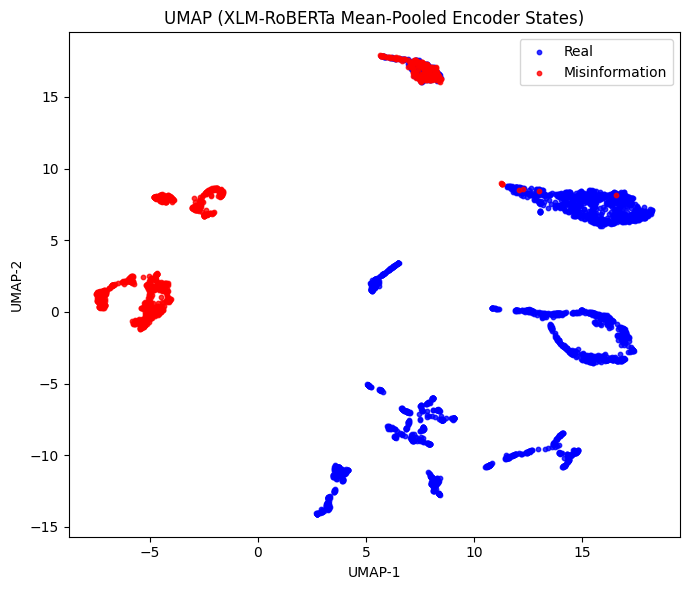

Saved UMAP figure (600 dpi): /content/drive/MyDrive/emc/xlmr_only_outputs_clean/umap_xlmr_text_test_2d.png
Saved UMAP coordinates: /content/drive/MyDrive/emc/xlmr_only_outputs_clean/umap_xlmr_text_test_2d.csv


In [7]:
# --- UMAP for XLM-R (text-only) — blue=Real, red=Misinformation, 600 dpi ---

# 0) Imports
import os, sys, subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

# tqdm fallback
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **kwargs): return x

# Ensure umap-learn is available
try:
    import umap
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-learn"])
    import umap

from transformers import (
    XLMRobertaTokenizerFast,
    XLMRobertaModel,
    XLMRobertaForSequenceClassification,
    DataCollatorWithPadding,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Ensure cfg exists and has required attributes (use sane defaults if missing)
try:
    cfg
except NameError:
    from dataclasses import dataclass
    @dataclass
    class _TmpCfg:
        BASE_DIR: str = "/content/drive/MyDrive/emc"
        CLEAN_TEST_CSV: str = "/content/drive/MyDrive/emc/test.csv"
        XLM_R_OUTPUTS: str = "/content/drive/MyDrive/emc/xlmr_only_outputs_clean"
        TEXT_COL: str = "content"
        LABEL_COL: str = "label"
        MAX_LEN: int = 256
        BATCH_SIZE: int = 16
        ID2LABEL: dict = {0: "Real", 1: "Misinformation"}
    cfg = _TmpCfg()

def ensure_attr(o, name, value):
    if not hasattr(o, name) or getattr(o, name) in (None, "", 0):
        setattr(o, name, value)

ensure_attr(cfg, "XLM_R_OUTPUTS", "/content/drive/MyDrive/emc/xlmr_only_outputs_clean")
ensure_attr(cfg, "CLEAN_TEST_CSV", "/content/drive/MyDrive/emc/test.csv")
ensure_attr(cfg, "TEXT_COL", "content")
ensure_attr(cfg, "LABEL_COL", "label")
ensure_attr(cfg, "MAX_LEN", 256)
ensure_attr(cfg, "BATCH_SIZE", 16)
ensure_attr(cfg, "ID2LABEL", {0: "Real", 1: "Misinformation"})

# 2) Load test set
try:
    test_df
except NameError:
    test_df = pd.read_csv(cfg.CLEAN_TEST_CSV)

# 3) Dataset for text-only embeddings
class TextOnlyDS(Dataset):
    def __init__(self, df, tokenizer, text_col="content", label_col="label", max_len=256):
        self.texts = df[text_col].astype(str).tolist()
        raw = df[label_col].tolist()
        labels = []
        for v in raw:
            s = str(v).strip().lower()
            if s in ("0","1"):
                labels.append(int(s))
            else:
                labels.append(1 if s.startswith("mis") else 0)
        self.labels = np.array(labels, dtype=np.int64)
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tok(
            self.texts[idx],
            truncation=True, padding=False, max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# 4) Load tokenizer + encoder (prefer your finetuned checkpoint's encoder)
xlmr_ckpt_dir = cfg.XLM_R_OUTPUTS
use_finetuned = os.path.isdir(xlmr_ckpt_dir) and os.path.exists(os.path.join(xlmr_ckpt_dir, "config.json"))

if use_finetuned:
    tokenizer = XLMRobertaTokenizerFast.from_pretrained(xlmr_ckpt_dir)
    # load classification checkpoint, then grab the underlying encoder to avoid pooler init warnings
    clf = XLMRobertaForSequenceClassification.from_pretrained(xlmr_ckpt_dir).to(device)
    encoder = clf.roberta  # base encoder with your fine-tuned weights
else:
    tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")
    encoder = XLMRobertaModel.from_pretrained("xlm-roberta-base").to(device)

# 5) DataLoader
ds = TextOnlyDS(test_df, tokenizer, text_col=cfg.TEXT_COL, label_col=cfg.LABEL_COL, max_len=cfg.MAX_LEN)
collator = DataCollatorWithPadding(tokenizer)
loader = DataLoader(ds, batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=collator)

# 6) Mean-pool helper
def masked_mean_pool(last_hidden_state: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
    mask = attention_mask.unsqueeze(-1).float()
    return (last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)

# 7) Encode embeddings
encoder.eval()
embs, labels = [], []
with torch.no_grad():
    for batch in tqdm(loader, desc="Encoding with XLM-R"):
        input_ids = batch["input_ids"].to(device)
        attn = batch["attention_mask"].to(device)
        out = encoder(input_ids=input_ids, attention_mask=attn, return_dict=True)
        pooled = masked_mean_pool(out.last_hidden_state, attn)  # [B, H]
        embs.append(pooled.cpu().numpy())
        labels.append(batch["labels"].numpy())
embs = np.vstack(embs)
y_test = np.concatenate(labels)

# 8) UMAP (cosine) to 2D
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric="cosine", random_state=42)
emb2d = umap_model.fit_transform(embs)

# 9) Plot (blue=Real, red=Misinformation) and save 600 dpi
out_dir = xlmr_ckpt_dir if use_finetuned else "/content"
os.makedirs(out_dir, exist_ok=True)
png_path = os.path.join(out_dir, "umap_xlmr_text_test_2d.png")
csv_path = os.path.join(out_dir, "umap_xlmr_text_test_2d.csv")

name0 = cfg.ID2LABEL.get(0, "Real")
name1 = cfg.ID2LABEL.get(1, "Misinformation")

plt.figure(figsize=(7.0, 6.0))
mask0 = (y_test == 0)
mask1 = (y_test == 1)
plt.scatter(emb2d[mask0, 0], emb2d[mask0, 1], s=10, c="blue", alpha=0.8, label=name0)
plt.scatter(emb2d[mask1, 0], emb2d[mask1, 1], s=10, c="red",  alpha=0.8, label=name1)
plt.title("UMAP (XLM-RoBERTa Mean-Pooled Encoder States)")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.legend(loc="best", frameon=True)
plt.tight_layout()
plt.savefig(png_path, dpi=600)
plt.show()

# 10) Save coordinates CSV
out_df = pd.DataFrame({
    "umap_x": emb2d[:, 0],
    "umap_y": emb2d[:, 1],
    "label_id": y_test,
    "label_name": np.where(y_test == 0, name0, name1),
})
out_df.to_csv(csv_path, index=False)

print("Saved UMAP figure (600 dpi):", png_path)
print("Saved UMAP coordinates:", csv_path)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Fused repr: 100%|██████████| 242/242 [00:21<00:00, 11.40it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


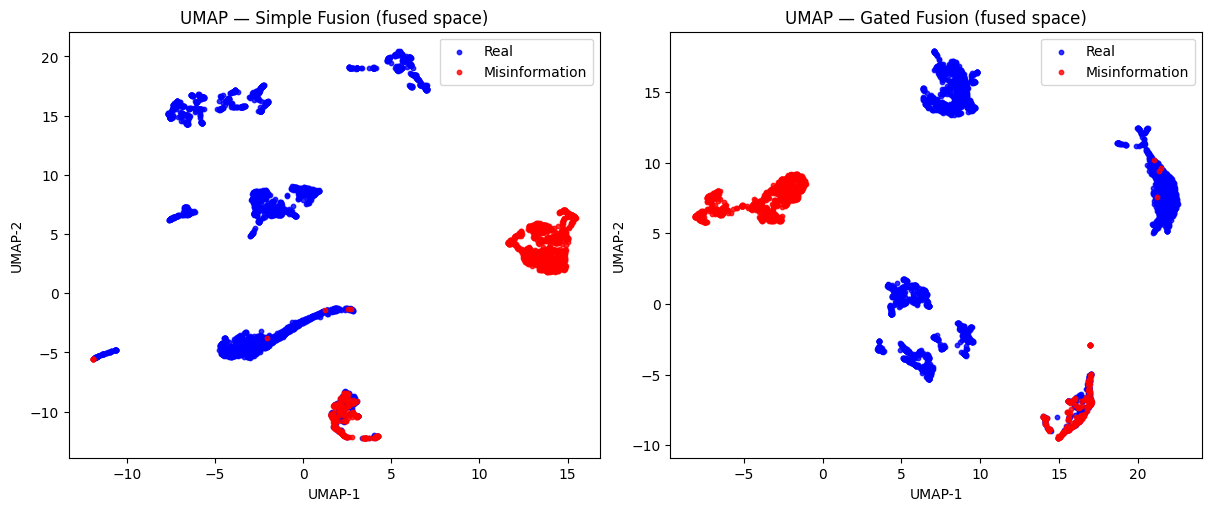

Saved side-by-side UMAP (600 dpi): /content/drive/MyDrive/emc/umap_simple_vs_gated_fused_2d.png
Saved coords: /content/drive/MyDrive/emc/simple_fusion_outputs_clean/umap_simple_fused_2d.csv
Saved coords: /content/drive/MyDrive/emc/gated_fusion_outputs_clean/umap_gated_fused_2d.csv


In [8]:
# --- UMAP for Simple Fusion & Gated Fusion (side-by-side), blue=Real red=Misinformation, 600 dpi ---

# 0) Imports
import os, sys, subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# tqdm fallback
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **kwargs): return x

# Ensure umap-learn is available
try:
    import umap
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-learn"])
    import umap

# Sklearn/joblib
try:
    import joblib
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "joblib"])
    import joblib

from transformers import XLMRobertaTokenizerFast, XLMRobertaModel, DataCollatorWithPadding

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Ensure cfg with required attributes (defaults if missing)
try:
    cfg
except NameError:
    from dataclasses import dataclass
    @dataclass
    class _TmpCfg:
        BASE_DIR: str = "/content/drive/MyDrive/emc"
        CLEAN_TEST_CSV: str = "/content/drive/MyDrive/emc/test.csv"
        TERMS_CSV: str = "/content/drive/MyDrive/emc/engineering_terms.csv"
        SIMPLE_OUTPUTS: str = "/content/drive/MyDrive/emc/simple_fusion_outputs_clean"
        GATED_OUTPUTS: str = "/content/drive/MyDrive/emc/gated_fusion_outputs_clean"
        TEXT_COL: str = "content"
        LABEL_COL: str = "label"
        LANG_COL: str = "lang"
        MAX_LEN: int = 256
        BATCH_SIZE: int = 16
        ID2LABEL: dict = {0: "Real", 1: "Misinformation"}
    cfg = _TmpCfg()

def ensure_attr(o, name, value):
    if not hasattr(o, name) or getattr(o, name) in (None, "", 0):
        setattr(o, name, value)

ensure_attr(cfg, "SIMPLE_OUTPUTS", "/content/drive/MyDrive/emc/simple_fusion_outputs_clean")
ensure_attr(cfg, "GATED_OUTPUTS",  "/content/drive/MyDrive/emc/gated_fusion_outputs_clean")
ensure_attr(cfg, "TERMS_CSV",      "/content/drive/MyDrive/emc/engineering_terms.csv")
ensure_attr(cfg, "CLEAN_TEST_CSV", "/content/drive/MyDrive/emc/test.csv")
ensure_attr(cfg, "TEXT_COL", "content")
ensure_attr(cfg, "LABEL_COL", "label")
ensure_attr(cfg, "MAX_LEN", 256)
ensure_attr(cfg, "BATCH_SIZE", 16)
ensure_attr(cfg, "ID2LABEL", {0: "Real", 1: "Misinformation"})

# 2) Load test set
try:
    test_df
except NameError:
    test_df = pd.read_csv(cfg.CLEAN_TEST_CSV)

# 3) Minimal feature extractor (12D) to rebuild raw features
import re
_WORD_RE = re.compile(r"\w+", re.UNICODE)
_NUM_RE  = re.compile(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?')
STD_TERMS = {"iso","asme","ieee","din","ansi","iec","ul","astm","en"}
SAFETY_TERMS = {"safety","hazard","warning","risk","caution","danger","emergency"}

def simple_words(t: str): return _WORD_RE.findall(t or "")
def sent_count(t: str) -> int:
    if not t: return 0
    return max(1, len(re.split(r'[.!?]+[\s\n]+', t)))
def punct_count(t: str) -> int: return sum(1 for ch in (t or "") if ch in ".,;:!?")
def extract_numbers(text: str):
    nums, dec = [], 0
    for m in _NUM_RE.finditer(text or ""):
        s = m.group(0)
        try:
            v = float(s)
            if ('.' in s) or ('e' in s.lower()): dec += 1
            nums.append(abs(v))
        except: pass
    return nums, dec
def _finite_or_zero(x: float):
    try:
        xx = float(x);
        return xx if np.isfinite(xx) else 0.0
    except: return 0.0

class TermsLexicon:
    def __init__(self, csv_path: str, term_col="terms", lang_col="lang"):
        if not os.path.exists(csv_path): raise FileNotFoundError(csv_path)
        df = pd.read_csv(csv_path)
        if term_col not in df.columns: raise ValueError(f"Missing '{term_col}'")
        if lang_col not in df.columns: df[lang_col] = 'en'
        self.by_lang = {
            str(l).lower(): set(str(x).strip().lower() for x in d[term_col].dropna().tolist() if str(x).strip())
            for l, d in df.groupby(lang_col)
        }
    def pct_in_text(self, text: str, lang: str) -> float:
        if not text: return 0.0
        terms = self.by_lang.get((lang or "en").lower(), set())
        if not terms: return 0.0
        ws = [w.lower() for w in simple_words(text)]
        if not ws: return 0.0
        return sum(1 for w in ws if w in terms) / max(1, len(ws))

class FeatureExtractor12:
    def __init__(self, tlex: TermsLexicon): self.tlex = tlex
    def extract_one(self, text: str, lang: str):
        text = "" if text is None else str(text); lang = (lang or "en").lower()
        ws = simple_words(text); n_words = len(ws)
        chars = len(text); words = n_words; sents = sent_count(text)
        fre, fog = 0.0, 0.0  # omit textstat for portability
        eng_pct = self.tlex.pct_in_text(text, lang)
        punc = punct_count(text)
        nums, dec_cnt = extract_numbers(text); nnums = len(nums)
        avg_mag = float(np.mean(nums)) if nums else 0.0
        dec_ratio = float(dec_cnt / max(1, len(nums)))
        low = text.lower()
        has_std = 1.0 if any(t in low for t in STD_TERMS) else 0.0
        has_saf = 1.0 if any(t in low for t in SAFETY_TERMS) else 0.0
        vals = [chars, words, sents, fre, fog, eng_pct, punc, nnums, has_std, has_saf, avg_mag, dec_ratio]
        feats = np.asarray([_finite_or_zero(v) for v in vals], dtype=np.float64)
        feats = np.nan_to_num(feats, nan=0.0, posinf=1e12, neginf=0.0)
        return np.clip(feats, -1e12, 1e12).astype(np.float32)
    def extract_df(self, df):
        local = df if 'lang' in df.columns else df.assign(lang='en')
        rows = [self.extract_one(r.get(cfg.TEXT_COL,""), r.get("lang","en")) for _, r in local.iterrows()]
        return np.stack(rows, axis=0).astype(np.float32)

lex = TermsLexicon(cfg.TERMS_CSV)
fe  = FeatureExtractor12(lex)

# 4) Tokenizer
tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")

# 5) Dataset classes with scaler-applied feats
class TextFeatDS(Dataset):
    def __init__(self, df, tokenizer, feats_scaled, text_col="content", label_col="label", max_len=256):
        self.texts = df[text_col].astype(str).tolist()
        raw = df[label_col].tolist()
        labels = []
        for v in raw:
            s = str(v).strip().lower()
            if s in ("0","1"): labels.append(int(s))
            else: labels.append(1 if s.startswith("mis") else 0)
        self.labels = np.array(labels, dtype=np.int64)
        self.tok = tokenizer
        self.max_len = max_len
        self.feats = feats_scaled.astype(np.float32)

    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tok(self.texts[idx], truncation=True, padding="max_length",
                       max_length=self.max_len, return_tensors="pt")
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
            "feats": torch.tensor(self.feats[idx], dtype=torch.float32),
        }

# 6) Model defs (same as training)
class SimpleFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + n_feats, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        fused = torch.cat([pooled, feats], dim=1)
        return self.classifier(self.dropout(fused))
    # helper to get fused representation
    def fused_repr(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        return torch.cat([pooled, feats], dim=1)

class GatedFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2, feat_proj: int = 64):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.fe_proj = nn.Sequential(nn.Linear(n_feats, feat_proj), nn.ReLU())
        self.gate    = nn.Sequential(nn.Linear(H + n_feats, 64), nn.ReLU(), nn.Linear(64, 1), nn.Sigmoid())
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + feat_proj, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        alpha = self.gate(torch.cat([pooled, feats], dim=1))
        ef    = self.fe_proj(feats)
        fused = torch.cat([pooled, alpha * ef], dim=1)
        return self.classifier(self.dropout(fused))
    # helper to get fused representation
    def fused_repr(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        alpha = self.gate(torch.cat([pooled, feats], dim=1))
        ef    = self.fe_proj(feats)
        return torch.cat([pooled, alpha * ef], dim=1)

# 7) Build raw features and scale with saved scalers for each model
X_raw = fe.extract_df(test_df)
# Simple scaler
scaler_simple_path = os.path.join(cfg.SIMPLE_OUTPUTS, "scaler12.pkl")
scaler_gated_path  = os.path.join(cfg.GATED_OUTPUTS,  "scaler12.pkl")
if not os.path.exists(scaler_simple_path) or not os.path.exists(scaler_gated_path):
    raise FileNotFoundError("Missing scaler12.pkl for Simple or Gated. Make sure training saved them.")

scaler_simple = joblib.load(scaler_simple_path)
scaler_gated  = joblib.load(scaler_gated_path)
X_simple = scaler_simple.transform(X_raw).astype(np.float32)
X_gated  = scaler_gated.transform(X_raw).astype(np.float32)

# 8) Datasets & loaders
ds_simple = TextFeatDS(test_df, tokenizer, X_simple, text_col=cgf.TEXT_COL if 'cgf' in globals() else cfg.TEXT_COL,
                       label_col=cfg.LABEL_COL, max_len=cfg.MAX_LEN)
ds_gated  = TextFeatDS(test_df, tokenizer, X_gated,  text_col=cfg.TEXT_COL, label_col=cfg.LABEL_COL, max_len=cfg.MAX_LEN)
collator  = DataCollatorWithPadding(tokenizer)
dl_simple = DataLoader(ds_simple, batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=collator)
dl_gated  = DataLoader(ds_gated,  batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=collator)

# 9) Load models with fine-tuned weights
simple_ckpt = os.path.join(cfg.SIMPLE_OUTPUTS, "fusion_simple.pt")
gated_ckpt  = os.path.join(cfg.GATED_OUTPUTS,  "fusion_gated.pt")
if not os.path.exists(simple_ckpt) or not os.path.exists(gated_ckpt):
    raise FileNotFoundError("Missing fusion_simple.pt or fusion_gated.pt. Train the models first.")

model_simple = SimpleFusion("xlm-roberta-base", n_feats=12, n_labels=2).to(device)
model_simple.load_state_dict(torch.load(simple_ckpt, map_location=device), strict=False)
model_simple.eval()

model_gated  = GatedFusion("xlm-roberta-base", n_feats=12, n_labels=2, feat_proj=64).to(device)
model_gated.load_state_dict(torch.load(gated_ckpt, map_location=device), strict=False)
model_gated.eval()

# 10) Extract fused representations
def collect_fused(model, loader):
    emb, y = [], []
    with torch.no_grad():
        for b in tqdm(loader, desc="Fused repr"):
            ids = b["input_ids"].to(device)
            am  = b["attention_mask"].to(device)
            ft  = b["feats"].to(device)
            fused = model.fused_repr(ids, am, ft)
            emb.append(fused.cpu().numpy())
            y.append(b["labels"].numpy())
    return np.vstack(emb), np.concatenate(y)

emb_simple, y_test = collect_fused(model_simple, dl_simple)
emb_gated,  _      = collect_fused(model_gated,  dl_gated)

# 11) UMAP (separate models)
umap_simple = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric="cosine", random_state=42)
umap_gated  = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric="cosine", random_state=42)
um2d_simple = umap_simple.fit_transform(emb_simple)
um2d_gated  = umap_gated.fit_transform(emb_gated)

# 12) Plot side-by-side, save 600 dpi
name0 = cfg.ID2LABEL.get(0, "Real")
name1 = cfg.ID2LABEL.get(1, "Misinformation")
mask0 = (y_test == 0)
mask1 = (y_test == 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
axes[0].scatter(um2d_simple[mask0,0], um2d_simple[mask0,1], s=10, c="blue", alpha=0.8, label=name0)
axes[0].scatter(um2d_simple[mask1,0], um2d_simple[mask1,1], s=10, c="red",  alpha=0.8, label=name1)
axes[0].set_title("UMAP — Simple Fusion (fused space)")
axes[0].set_xlabel("UMAP-1"); axes[0].set_ylabel("UMAP-2")
axes[0].legend(loc="best", frameon=True)

axes[1].scatter(um2d_gated[mask0,0], um2d_gated[mask0,1], s=10, c="blue", alpha=0.8, label=name0)
axes[1].scatter(um2d_gated[mask1,0], um2d_gated[mask1,1], s=10, c="red",  alpha=0.8, label=name1)
axes[1].set_title("UMAP — Gated Fusion (fused space)")
axes[1].set_xlabel("UMAP-1"); axes[1].set_ylabel("UMAP-2")
axes[1].legend(loc="best", frameon=True)

out_dir = cfg.BASE_DIR
png_path = os.path.join(out_dir, "umap_simple_vs_gated_fused_2d.png")
plt.savefig(png_path, dpi=600)
plt.show()
print("Saved side-by-side UMAP (600 dpi):", png_path)

# 13) Save coordinates CSVs
csv_simple = os.path.join(cfg.SIMPLE_OUTPUTS, "umap_simple_fused_2d.csv")
csv_gated  = os.path.join(cfg.GATED_OUTPUTS,  "umap_gated_fused_2d.csv")
pd.DataFrame({"umap_x": um2d_simple[:,0], "umap_y": um2d_simple[:,1], "label_id": y_test,
              "label_name": np.where(y_test==0, name0, name1)}).to_csv(csv_simple, index=False)
pd.DataFrame({"umap_x": um2d_gated[:,0],  "umap_y": um2d_gated[:,1],  "label_id": y_test,
              "label_name": np.where(y_test==0, name0, name1)}).to_csv(csv_gated, index=False)
print("Saved coords:", csv_simple)
print("Saved coords:", csv_gated)


Baseline (TEST) — Macro F1: 0.9530 | Acc: 0.9610
Feature  0 (Chars): drop = 0.009839
Feature  1 (Words): drop = 0.000820
Feature  2 (Sents): drop = 0.000971
Feature  3 (Flesch RE (en)): drop = 0.000000
Feature  4 (Gunning Fog (en)): drop = 0.000000
Feature  5 (% Eng Terms): drop = -0.000096
Feature  6 (Punctuation): drop = 0.000323
Feature  7 (Number Count): drop = 0.000897
Feature  8 (Contains Standard): drop = -0.000946
Feature  9 (Contains Safety): drop = 0.003232
Feature 10 (Avg Number Mag): drop = 0.000000
Feature 11 (Decimal Ratio): drop = 0.001519


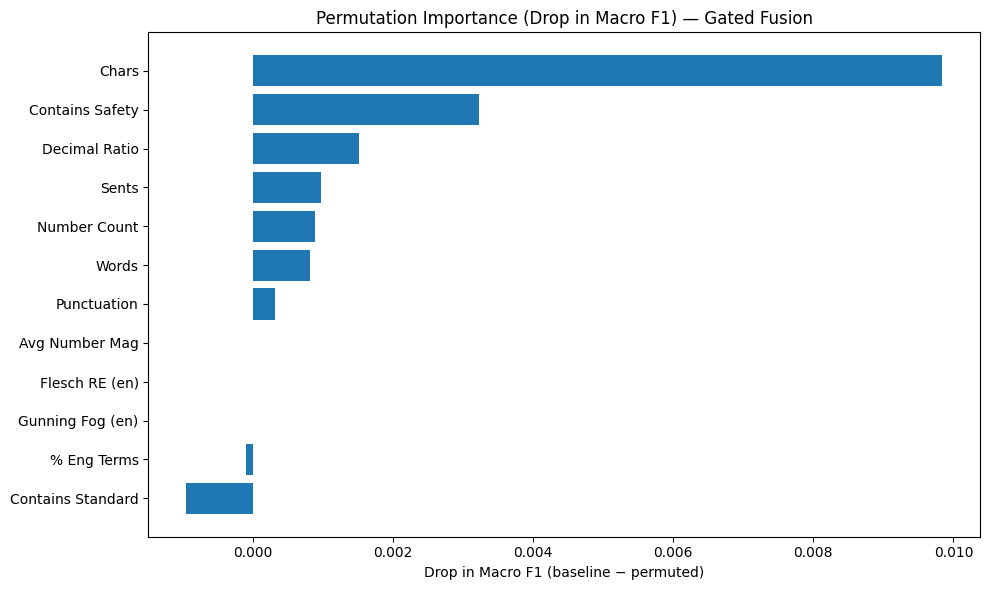

Saved CSV: /content/drive/MyDrive/emc/gated_fusion_outputs_clean/perm_importance_gated_test.csv
Saved plot (600 dpi): /content/drive/MyDrive/emc/gated_fusion_outputs_clean/perm_importance_gated_test.png


In [9]:
# --- Block 34: Permutation Importance for Gated Fusion (TEST set), 12 engineered features ---

# 0) Imports
import os, sys, subprocess, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, accuracy_score

# tqdm fallback
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **kwargs): return x

# joblib
try:
    import joblib
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "joblib"])
    import joblib

# HF
from transformers import XLMRobertaTokenizerFast, XLMRobertaModel, DataCollatorWithPadding

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Ensure cfg and required attributes
try:
    cfg
except NameError:
    from dataclasses import dataclass
    @dataclass
    class _TmpCfg:
        BASE_DIR: str = "/content/drive/MyDrive/emc"
        CLEAN_TEST_CSV: str = "/content/drive/MyDrive/emc/test.csv"
        TERMS_CSV: str = "/content/drive/MyDrive/emc/engineering_terms.csv"
        GATED_OUTPUTS: str = "/content/drive/MyDrive/emc/gated_fusion_outputs_clean"
        TEXT_COL: str = "content"
        LABEL_COL: str = "label"
        LANG_COL: str = "lang"
        MAX_LEN: int = 256
        BATCH_SIZE: int = 16
        N_FEATURES: int = 12
        ID2LABEL: dict = {0: "Real", 1: "Misinformation"}
    cfg = _TmpCfg()

def ensure_attr(o, name, value):
    if not hasattr(o, name) or getattr(o, name) in (None, "", 0):
        setattr(o, name, value)

ensure_attr(cfg, "GATED_OUTPUTS",  "/content/drive/MyDrive/emc/gated_fusion_outputs_clean")
ensure_attr(cfg, "TERMS_CSV",      "/content/drive/MyDrive/emc/engineering_terms.csv")
ensure_attr(cfg, "CLEAN_TEST_CSV", "/content/drive/MyDrive/emc/test.csv")
ensure_attr(cfg, "TEXT_COL", "content")
ensure_attr(cfg, "LABEL_COL", "label")
ensure_attr(cfg, "LANG_COL", "lang")
ensure_attr(cfg, "MAX_LEN", 256)
ensure_attr(cfg, "BATCH_SIZE", 16)
ensure_attr(cfg, "N_FEATURES", 12)

# 2) Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# 3) Load TEST set
test_df = pd.read_csv(cfg.CLEAN_TEST_CSV)

# 4) Minimal 12-D feature extractor (same design as training)
import re
_WORD_RE = re.compile(r"\w+", re.UNICODE)
_NUM_RE  = re.compile(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?')
STD_TERMS = {"iso","asme","ieee","din","ansi","iec","ul","astm","en"}
SAFETY_TERMS = {"safety","hazard","warning","risk","caution","danger","emergency"}

def simple_words(t: str): return _WORD_RE.findall(t or "")
def sent_count(t: str) -> int:
    if not t: return 0
    return max(1, len(re.split(r'[.!?]+[\s\n]+', t)))
def punct_count(t: str) -> int: return sum(1 for ch in (t or "") if ch in ".,;:!?")
def extract_numbers(text: str):
    nums, dec = [], 0
    for m in _NUM_RE.finditer(text or ""):
        s = m.group(0)
        try:
            v = float(s)
            if ('.' in s) or ('e' in s.lower()): dec += 1
            nums.append(abs(v))
        except: pass
    return nums, dec
def _finite_or_zero(x: float):
    try:
        xx = float(x);
        return xx if np.isfinite(xx) else 0.0
    except: return 0.0

class TermsLexicon:
    def __init__(self, csv_path: str, term_col="terms", lang_col="lang"):
        if not os.path.exists(csv_path): raise FileNotFoundError(csv_path)
        df = pd.read_csv(csv_path)
        if term_col not in df.columns: raise ValueError(f"Missing '{term_col}'")
        if lang_col not in df.columns: df[lang_col] = 'en'
        self.by_lang = {
            str(l).lower(): set(str(x).strip().lower() for x in d[term_col].dropna().tolist() if str(x).strip())
            for l, d in df.groupby(lang_col)
        }
    def pct_in_text(self, text: str, lang: str) -> float:
        if not text: return 0.0
        terms = self.by_lang.get((lang or "en").lower(), set())
        if not terms: return 0.0
        ws = [w.lower() for w in simple_words(text)]
        if not ws: return 0.0
        return sum(1 for w in ws if w in terms) / max(1, len(ws))

class FeatureExtractor12:
    def __init__(self, tlex: TermsLexicon): self.tlex = tlex
    def extract_one(self, text: str, lang: str):
        text = "" if text is None else str(text); lang = (lang or "en").lower()
        ws = simple_words(text); n_words = len(ws)
        chars = len(text); words = n_words; sents = sent_count(text)
        fre, fog = 0.0, 0.0  # textstat omitted for portability
        eng_pct = self.tlex.pct_in_text(text, lang)
        punc = punct_count(text)
        nums, dec_cnt = extract_numbers(text); nnums = len(nums)
        avg_mag = float(np.mean(nums)) if nums else 0.0
        dec_ratio = float(dec_cnt / max(1, len(nums)))
        low = text.lower()
        has_std = 1.0 if any(t in low for t in STD_TERMS) else 0.0
        has_saf = 1.0 if any(t in low for t in SAFETY_TERMS) else 0.0
        vals = [chars, words, sents, fre, fog, eng_pct, punc, nnums, has_std, has_saf, avg_mag, dec_ratio]
        feats = np.asarray([_finite_or_zero(v) for v in vals], dtype=np.float64)
        feats = np.nan_to_num(feats, nan=0.0, posinf=1e12, neginf=0.0)
        return np.clip(feats, -1e12, 1e12).astype(np.float32)
    def extract_df(self, df):
        local = df if cfg.LANG_COL in df.columns else df.assign(**{cfg.LANG_COL:'en'})
        rows = [self.extract_one(r.get(cfg.TEXT_COL,""), r.get(cfg.LANG_COL,"en")) for _, r in local.iterrows()]
        return np.stack(rows, axis=0).astype(np.float32)

lex = TermsLexicon(cfg.TERMS_CSV)
fe  = FeatureExtractor12(lex)

# 5) Tokenizer (same as training backbone)
tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")

# 6) Dataset class that injects (scaled) feats
class TextFeatDS(Dataset):
    def __init__(self, df, tokenizer, feats_scaled, text_col="content", label_col="label", max_len=256):
        self.texts = df[text_col].astype(str).tolist()
        raw = df[label_col].tolist()
        labels = []
        for v in raw:
            s = str(v).strip().lower()
            if s in ("0","1"): labels.append(int(s))
            else: labels.append(1 if s.startswith("mis") else 0)
        self.labels = np.array(labels, dtype=np.int64)
        self.tok = tokenizer
        self.max_len = max_len
        self.feats = feats_scaled.astype(np.float32)

    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tok(self.texts[idx], truncation=True, padding="max_length",
                       max_length=self.max_len, return_tensors="pt")
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
            "feats": torch.tensor(self.feats[idx], dtype=torch.float32),
        }

# 7) Gated Fusion model (same as training)
class GatedFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2, feat_proj: int = 64):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.fe_proj = nn.Sequential(nn.Linear(n_feats, feat_proj), nn.ReLU())
        self.gate    = nn.Sequential(nn.Linear(H + n_feats, 64), nn.ReLU(), nn.Linear(64, 1), nn.Sigmoid())
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + feat_proj, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        alpha = self.gate(torch.cat([pooled, feats], dim=1))
        ef    = self.fe_proj(feats)
        fused = torch.cat([pooled, alpha * ef], dim=1)
        return self.classifier(self.dropout(fused))

# 8) Load scaler + model weights
scaler_path = os.path.join(cfg.GATED_OUTPUTS, "scaler12.pkl")
model_path  = os.path.join(cfg.GATED_OUTPUTS, "fusion_gated.pt")
if not os.path.exists(scaler_path) or not os.path.exists(model_path):
    raise FileNotFoundError("Missing gated scaler/model. Expected scaler12.pkl and fusion_gated.pt in GATED_OUTPUTS.")

scaler = joblib.load(scaler_path)
model  = GatedFusion("xlm-roberta-base", n_feats=cfg.N_FEATURES, n_labels=2, feat_proj=64).to(device)
model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
model.eval()

# 9) Build baseline TEST loader (tokens + scaled feats)
X_test_raw = fe.extract_df(test_df)
X_test_scaled = scaler.transform(X_test_raw).astype(np.float32)

ds_test = TextFeatDS(test_df, tokenizer, X_test_scaled, text_col=cfg.TEXT_COL, label_col=cfg.LABEL_COL, max_len=cfg.MAX_LEN)
collator = DataCollatorWithPadding(tokenizer)
dl_test  = DataLoader(ds_test, batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=collator)

@torch.no_grad()
def eval_macro_f1(dataloader):
    ys, ps = [], []
    for b in dataloader:
        ids = b["input_ids"].to(device)
        am  = b["attention_mask"].to(device)
        ft  = b["feats"].to(device)
        logits = model(ids, am, ft)
        pred = logits.argmax(dim=-1).cpu().numpy()
        ys.append(b["labels"].numpy()); ps.append(pred)
    y = np.concatenate(ys); p = np.concatenate(ps)
    return f1_score(y, p, average="macro", zero_division=0), accuracy_score(y, p)

# 10) Baseline metric
baseline_f1, baseline_acc = eval_macro_f1(dl_test)
print(f"Baseline (TEST) — Macro F1: {baseline_f1:.4f} | Acc: {baseline_acc:.4f}")

# 11) Permutation importance over 12 features (shuffle column j across samples)
feat_names = [
    "Chars", "Words", "Sents", "Flesch RE (en)", "Gunning Fog (en)",
    "% Eng Terms", "Punctuation", "Number Count", "Contains Standard",
    "Contains Safety", "Avg Number Mag", "Decimal Ratio"
]

rng = np.random.default_rng(SEED)
drops = []
for j in range(cfg.N_FEATURES):
    Xp = X_test_scaled.copy()
    rng.shuffle(Xp[:, j])  # permute column j across samples
    ds_perm = TextFeatDS(test_df, tokenizer, Xp, text_col=cfg.TEXT_COL, label_col=cfg.LABEL_COL, max_len=cfg.MAX_LEN)
    dl_perm = DataLoader(ds_perm, batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=collator)
    f1_j, _ = eval_macro_f1(dl_perm)
    drop = baseline_f1 - f1_j
    drops.append(drop)
    print(f"Feature {j:2d} ({feat_names[j]}): drop = {drop:.6f}")

imp_df = pd.DataFrame({
    "Feature": feat_names[:cfg.N_FEATURES],
    "Drop_in_MacroF1": drops
}).sort_values("Drop_in_MacroF1", ascending=True)

# 12) Save CSV and plot (600 dpi)
os.makedirs(cfg.GATED_OUTPUTS, exist_ok=True)
csv_out = os.path.join(cfg.GATED_OUTPUTS, "perm_importance_gated_test.csv")
png_out = os.path.join(cfg.GATED_OUTPUTS, "perm_importance_gated_test.png")
imp_df.to_csv(csv_out, index=False)

plt.figure(figsize=(10, 6))
plt.barh(imp_df["Feature"], imp_df["Drop_in_MacroF1"])
plt.title("Permutation Importance (Drop in Macro F1) — Gated Fusion")
plt.xlabel("Drop in Macro F1 (baseline − permuted)")
plt.tight_layout()
plt.savefig(png_out, dpi=600)
plt.show()

print("Saved CSV:", csv_out)
print("Saved plot (600 dpi):", png_out)


Fusion proba: 100%|██████████| 242/242 [00:21<00:00, 11.18it/s]


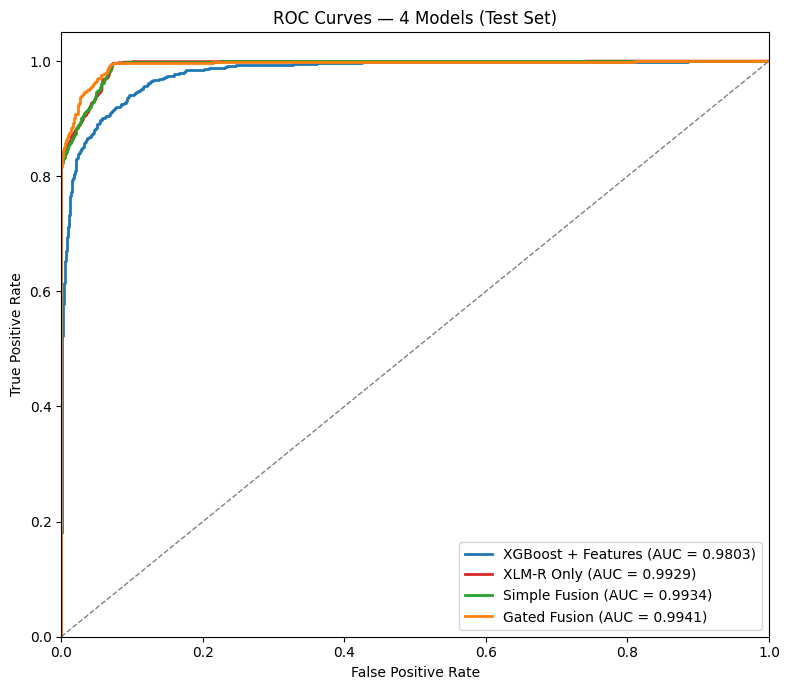

Saved ROC figure (600 dpi): /content/drive/MyDrive/emc/roc_curves_4models.png
Saved ROC points CSV: /content/drive/MyDrive/emc/roc_points_4models.csv


In [10]:
# --- Combined ROC for 4 Models (XGB, XLM-R, Simple Fusion, Gated Fusion) ---
# Saves: BASE_DIR/roc_curves_4models.png (600 dpi)
#        BASE_DIR/roc_points_4models.csv (model,fpr,tpr,threshold)

import os, sys, subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Optional progress bar
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **kwargs): return x

# Ensure xgboost & joblib
try:
    import xgboost as xgb
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])
    import xgboost as xgb
try:
    import joblib
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "joblib"])
    import joblib

# HF deps
from transformers import (
    XLMRobertaTokenizerFast,
    XLMRobertaForSequenceClassification,
    XLMRobertaModel,
    DataCollatorWithPadding,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- 0) Config / defaults ----------
try:
    cfg
except NameError:
    from dataclasses import dataclass
    @dataclass
    class _TmpCfg:
        BASE_DIR: str = "/content/drive/MyDrive/emc"
        CLEAN_TEST_CSV: str = "/content/drive/MyDrive/emc/test.csv"
        TERMS_CSV: str = "/content/drive/MyDrive/emc/engineering_terms.csv"
        XGB_OUTPUTS: str = "/content/drive/MyDrive/emc/xgb_outputs_clean"
        XLM_R_OUTPUTS: str = "/content/drive/MyDrive/emc/xlmr_only_outputs_clean"
        SIMPLE_OUTPUTS: str = "/content/drive/MyDrive/emc/simple_fusion_outputs_clean"
        GATED_OUTPUTS: str = "/content/drive/MyDrive/emc/gated_fusion_outputs_clean"
        TEXT_COL: str = "content"
        LABEL_COL: str = "label"
        LANG_COL: str = "lang"
        MAX_LEN: int = 256
        BATCH_SIZE: int = 16
        N_FEATURES: int = 12
        ID2LABEL: dict = {0: "Real", 1: "Misinformation"}
    cfg = _TmpCfg()

def ensure_attr(o, name, value):
    if not hasattr(o, name) or getattr(o, name) in (None, "", 0):
        setattr(o, name, value)

for k, v in dict(
    BASE_DIR="/content/drive/MyDrive/emc",
    CLEAN_TEST_CSV="/content/drive/MyDrive/emc/test.csv",
    TERMS_CSV="/content/drive/MyDrive/emc/engineering_terms.csv",
    XGB_OUTPUTS="/content/drive/MyDrive/emc/xgb_outputs_clean",
    XLM_R_OUTPUTS="/content/drive/MyDrive/emc/xlmr_only_outputs_clean",
    SIMPLE_OUTPUTS="/content/drive/MyDrive/emc/simple_fusion_outputs_clean",
    GATED_OUTPUTS="/content/drive/MyDrive/emc/gated_fusion_outputs_clean",
    TEXT_COL="content", LABEL_COL="label", LANG_COL="lang",
    MAX_LEN=256, BATCH_SIZE=16, N_FEATURES=12
).items():
    ensure_attr(cfg, k, v)

# ---------- 1) Load test set ----------
test_df = pd.read_csv(cfg.CLEAN_TEST_CSV)
y_true = test_df[cfg.LABEL_COL].astype(int).values

# ---------- 2) Feature extractor (12D) to rebuild engineered features ----------
import re
_WORD_RE = re.compile(r"\w+", re.UNICODE)
_NUM_RE  = re.compile(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?')
STD_TERMS = {"iso","asme","ieee","din","ansi","iec","ul","astm","en"}
SAFETY_TERMS = {"safety","hazard","warning","risk","caution","danger","emergency"}

def simple_words(t: str): return _WORD_RE.findall(t or "")
def sent_count(t: str) -> int:
    if not t: return 0
    return max(1, len(re.split(r'[.!?]+[\s\n]+', t)))
def punct_count(t: str) -> int: return sum(1 for ch in (t or "") if ch in ".,;:!?")
def extract_numbers(text: str):
    nums, dec = [], 0
    for m in _NUM_RE.finditer(text or ""):
        s = m.group(0)
        try:
            v = float(s)
            if ('.' in s) or ('e' in s.lower()): dec += 1
            nums.append(abs(v))
        except: pass
    return nums, dec
def _finite_or_zero(x: float):
    try:
        xx = float(x);
        return xx if np.isfinite(xx) else 0.0
    except: return 0.0

class TermsLexicon:
    def __init__(self, csv_path: str, term_col="terms", lang_col="lang"):
        if not os.path.exists(csv_path): raise FileNotFoundError(csv_path)
        df = pd.read_csv(csv_path)
        if term_col not in df.columns: raise ValueError(f"Missing '{term_col}'")
        if lang_col not in df.columns: df[lang_col] = 'en'
        self.by_lang = {
            str(l).lower(): set(str(x).strip().lower() for x in d[term_col].dropna().tolist() if str(x).strip())
            for l, d in df.groupby(lang_col)
        }
    def pct_in_text(self, text: str, lang: str) -> float:
        if not text: return 0.0
        terms = self.by_lang.get((lang or "en").lower(), set())
        if not terms: return 0.0
        ws = [w.lower() for w in simple_words(text)]
        if not ws: return 0.0
        return sum(1 for w in ws if w in terms) / max(1, len(ws))

class FeatureExtractor12:
    def __init__(self, tlex: TermsLexicon): self.tlex = tlex
    def extract_one(self, text: str, lang: str):
        text = "" if text is None else str(text); lang = (lang or "en").lower()
        ws = simple_words(text); n_words = len(ws)
        chars = len(text); words = n_words; sents = sent_count(text)
        fre, fog = 0.0, 0.0  # omit textstat for portability
        eng_pct = self.tlex.pct_in_text(text, lang)
        punc = punct_count(text)
        nums, dec_cnt = extract_numbers(text); nnums = len(nums)
        avg_mag = float(np.mean(nums)) if nums else 0.0
        dec_ratio = float(dec_cnt / max(1, len(nums)))
        low = text.lower()
        has_std = 1.0 if any(t in low for t in STD_TERMS) else 0.0
        has_saf = 1.0 if any(t in low for t in SAFETY_TERMS) else 0.0
        vals = [chars, words, sents, fre, fog, eng_pct, punc, nnums, has_std, has_saf, avg_mag, dec_ratio]
        feats = np.asarray([_finite_or_zero(v) for v in vals], dtype=np.float64)
        feats = np.nan_to_num(feats, nan=0.0, posinf=1e12, neginf=0.0)
        return np.clip(feats, -1e12, 1e12).astype(np.float32)
    def extract_df(self, df):
        local = df if cfg.LANG_COL in df.columns else df.assign(**{cfg.LANG_COL:'en'})
        rows = [self.extract_one(r.get(cfg.TEXT_COL,""), r.get(cfg.LANG_COL,"en")) for _, r in local.iterrows()]
        return np.stack(rows, axis=0).astype(np.float32)

lex = TermsLexicon(cfg.TERMS_CSV)
fe  = FeatureExtractor12(lex)
X_raw = fe.extract_df(test_df)

# ---------- 3) Tokenization datasets ----------
class TextOnlyDS(Dataset):
    def __init__(self, df, tokenizer, text_col="content", label_col="label", max_len=256):
        self.texts = df[text_col].astype(str).tolist()
        self.labels = df[label_col].astype(int).values
        self.tok = tokenizer; self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tok(self.texts[idx], truncation=True, padding=False,
                       max_length=self.max_len, return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

class TextFeatDS(Dataset):
    def __init__(self, df, tokenizer, feats_scaled, text_col="content", label_col="label", max_len=256):
        self.texts = df[text_col].astype(str).tolist()
        self.labels = df[label_col].astype(int).values
        self.tok = tokenizer; self.max_len = max_len
        self.feats = feats_scaled.astype(np.float32)
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tok(self.texts[idx], truncation=True, padding="max_length",
                       max_length=self.max_len, return_tensors="pt")
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(int(self.labels[idx]), dtype=torch.long),
            "feats": torch.tensor(self.feats[idx], dtype=torch.float32),
        }

from transformers import DataCollatorWithPadding
collator = DataCollatorWithPadding(XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base"))

# ---------- 4) Model defs (Simple & Gated) ----------
class SimpleFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + n_feats, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        fused = torch.cat([pooled, feats], dim=1)
        return self.classifier(self.dropout(fused))

class GatedFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2, feat_proj: int = 64):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.fe_proj = nn.Sequential(nn.Linear(n_feats, feat_proj), nn.ReLU())
        self.gate    = nn.Sequential(nn.Linear(H + n_feats, 64), nn.ReLU(), nn.Linear(64, 1), nn.Sigmoid())
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + feat_proj, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        alpha = self.gate(torch.cat([pooled, feats], dim=1))
        ef    = self.fe_proj(feats)
        fused = torch.cat([pooled, alpha * ef], dim=1)
        return self.classifier(self.dropout(fused))

# ---------- 5) Load artifacts ----------
# XGBoost
xgb_model_path = os.path.join(cfg.XGB_OUTPUTS, "xgb_model.json")
xgb_scaler_path = os.path.join(cfg.XGB_OUTPUTS, "scaler12.pkl")
if not (os.path.exists(xgb_model_path) and os.path.exists(xgb_scaler_path)):
    raise FileNotFoundError("XGBoost model/scaler not found.")
clf_xgb = xgb.XGBClassifier()
clf_xgb.load_model(xgb_model_path)
scaler_xgb = joblib.load(xgb_scaler_path)
X_xgb = scaler_xgb.transform(X_raw)

# XLM-R only
if not os.path.exists(cfg.XLM_R_OUTPUTS):
    raise FileNotFoundError("XLM-R outputs dir not found.")
tokenizer_xlmr = XLMRobertaTokenizerFast.from_pretrained(cfg.XLM_R_OUTPUTS)
model_xlmr = XLMRobertaForSequenceClassification.from_pretrained(cfg.XLM_R_OUTPUTS).to(device)

# Simple Fusion
simple_ckpt = os.path.join(cfg.SIMPLE_OUTPUTS, "fusion_simple.pt")
simple_scaler_path = os.path.join(cfg.SIMPLE_OUTPUTS, "scaler12.pkl")
if not (os.path.exists(simple_ckpt) and os.path.exists(simple_scaler_path)):
    raise FileNotFoundError("Simple Fusion checkpoint/scaler not found.")
scaler_simple = joblib.load(simple_scaler_path)
X_simple = scaler_simple.transform(X_raw)
model_simple = SimpleFusion("xlm-roberta-base", n_feats=cfg.N_FEATURES, n_labels=2).to(device)
model_simple.load_state_dict(torch.load(simple_ckpt, map_location=device), strict=False)
model_simple.eval()

# Gated Fusion
gated_ckpt = os.path.join(cfg.GATED_OUTPUTS, "fusion_gated.pt")
gated_scaler_path = os.path.join(cfg.GATED_OUTPUTS, "scaler12.pkl")
if not (os.path.exists(gated_ckpt) and os.path.exists(gated_scaler_path)):
    raise FileNotFoundError("Gated Fusion checkpoint/scaler not found.")
scaler_gated = joblib.load(gated_scaler_path)
X_gated = scaler_gated.transform(X_raw)
model_gated = GatedFusion("xlm-roberta-base", n_feats=cfg.N_FEATURES, n_labels=2, feat_proj=64).to(device)
model_gated.load_state_dict(torch.load(gated_ckpt, map_location=device), strict=False)
model_gated.eval()

# ---------- 6) DataLoaders ----------
from transformers import DataCollatorWithPadding
collator = DataCollatorWithPadding(tokenizer_xlmr)

# XLM-R DS
ds_xlmr = TextOnlyDS(test_df, tokenizer_xlmr, text_col=cfg.TEXT_COL, label_col=cfg.LABEL_COL, max_len=cfg.MAX_LEN)
dl_xlmr = DataLoader(ds_xlmr, batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=collator)

# Simple/Gated DS
ds_simple = TextFeatDS(test_df, tokenizer_xlmr, X_simple, text_col=cfg.TEXT_COL, label_col=cfg.LABEL_COL, max_len=cfg.MAX_LEN)
ds_gated  = TextFeatDS(test_df, tokenizer_xlmr, X_gated,  text_col=cfg.TEXT_COL, label_col=cfg.LABEL_COL, max_len=cfg.MAX_LEN)
dl_simple = DataLoader(ds_simple, batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=collator)
dl_gated  = DataLoader(ds_gated,  batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=collator)

# ---------- 7) Collect probabilities ----------
def probs_xlmr(dataloader):
    ps = []
    model_xlmr.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="XLMR proba"):
            inputs = {k: v.to(device) for k, v in batch.items() if k in ("input_ids","attention_mask","labels")}
            out = model_xlmr(**inputs)
            p = torch.softmax(out.logits, dim=-1)[:, 1].cpu().numpy()  # P(class=1)
            ps.append(p)
    return np.concatenate(ps)

def probs_fusion(model, dataloader):
    ps = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Fusion proba"):
            ids = batch["input_ids"].to(device)
            am  = batch["attention_mask"].to(device)
            ft  = batch["feats"].to(device)
            logits = model(ids, am, ft)
            p = torch.softmax(logits, dim=-1)[:, 1].cpu().numpy()
            ps.append(p)
    return np.concatenate(ps)

# XGBoost prob (class 1)
yprob_xgb = clf_xgb.predict_proba(X_xgb)[:, 1]
# XLM-R prob
yprob_xlmr = probs_xlmr(dl_xlmr)
# Simple/Gated prob
yprob_simple = probs_fusion(model_simple, dl_simple)
yprob_gated  = probs_fusion(model_gated,  dl_gated)

# ---------- 8) Compute ROC + AUC ----------
curves = {}
for name, prob in [
    ("XGBoost + Features", yprob_xgb),
    ("XLM-R Only",         yprob_xlmr),
    ("Simple Fusion",      yprob_simple),
    ("Gated Fusion",       yprob_gated),
]:
    fpr, tpr, thr = roc_curve(y_true, prob)
    auc = roc_auc_score(y_true, prob)
    curves[name] = {"fpr": fpr, "tpr": tpr, "thr": thr, "auc": auc}

# ---------- 9) Plot (different colors) & save 600 dpi ----------
colors = {
    "XGBoost + Features": "tab:blue",
    "XLM-R Only":         "tab:red",
    "Simple Fusion":      "tab:green",
    "Gated Fusion":       "tab:orange",
}
plt.figure(figsize=(8, 7))
for name, d in curves.items():
    plt.plot(d["fpr"], d["tpr"], lw=2, label=f"{name} (AUC = {d['auc']:.4f})", color=colors.get(name, None))
plt.plot([0,1], [0,1], ls="--", color="gray", lw=1)
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — 4 Models (Test Set)")
plt.legend(loc="lower right")
plt.tight_layout()
out_png = os.path.join(cfg.BASE_DIR, "roc_curves_4models.png")
plt.savefig(out_png, dpi=600)
plt.show()
print("Saved ROC figure (600 dpi):", out_png)

# ---------- 10) Save ROC points (long CSV) ----------
rows = []
for name, d in curves.items():
    rows.append(pd.DataFrame({
        "Model": name,
        "fpr": d["fpr"],
        "tpr": d["tpr"],
        "threshold": d["thr"]
    }))
roc_points = pd.concat(rows, ignore_index=True)
out_csv = os.path.join(cfg.BASE_DIR, "roc_points_4models.csv")
roc_points.to_csv(out_csv, index=False)
print("Saved ROC points CSV:", out_csv)


Fusion proba: 100%|██████████| 242/242 [00:22<00:00, 10.77it/s]


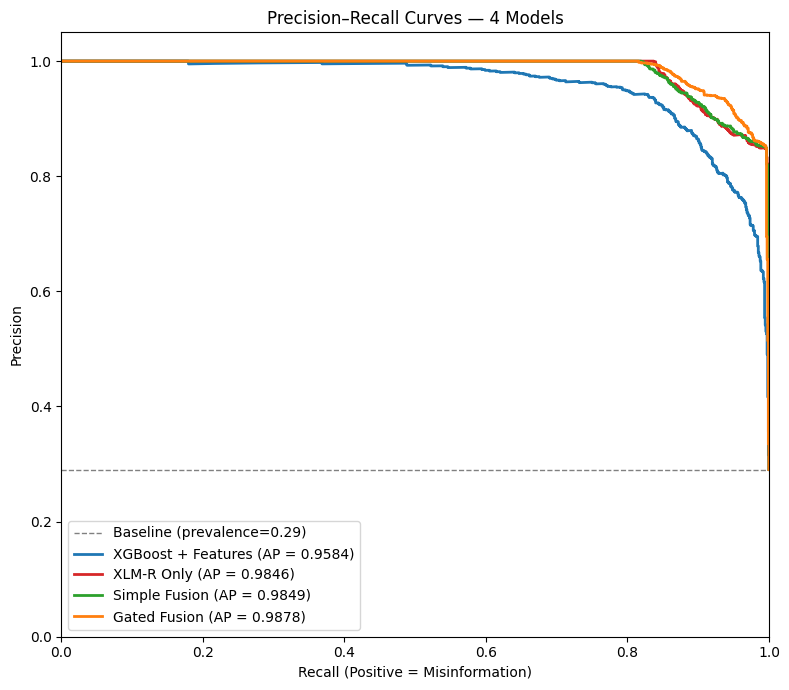

Saved PR figure (600 dpi): /content/drive/MyDrive/emc/pr_curves_4models.png
Saved PR points CSV: /content/drive/MyDrive/emc/pr_points_4models.csv
  XGBoost + Features  AP = 0.9584
          XLM-R Only  AP = 0.9846
       Simple Fusion  AP = 0.9849
        Gated Fusion  AP = 0.9878


In [11]:
# --- Combined Precision–Recall (PR) Curves for 4 Models (Test Set) ---
# Saves: BASE_DIR/pr_curves_4models.png  (600 dpi)
#        BASE_DIR/pr_points_4models.csv  (Model, recall, precision, threshold)

import os, sys, subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Optional progress bar
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **kwargs): return x

# Ensure xgboost & joblib
try:
    import xgboost as xgb
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])
    import xgboost as xgb
try:
    import joblib
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "joblib"])
    import joblib

# HF deps
from transformers import (
    XLMRobertaTokenizerFast,
    XLMRobertaForSequenceClassification,
    XLMRobertaModel,
    DataCollatorWithPadding,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- 0) Config / defaults ----------
try:
    cfg
except NameError:
    from dataclasses import dataclass
    @dataclass
    class _TmpCfg:
        BASE_DIR: str = "/content/drive/MyDrive/emc"
        CLEAN_TEST_CSV: str = "/content/drive/MyDrive/emc/test.csv"
        TERMS_CSV: str = "/content/drive/MyDrive/emc/engineering_terms.csv"
        XGB_OUTPUTS: str = "/content/drive/MyDrive/emc/xgb_outputs_clean"
        XLM_R_OUTPUTS: str = "/content/drive/MyDrive/emc/xlmr_only_outputs_clean"
        SIMPLE_OUTPUTS: str = "/content/drive/MyDrive/emc/simple_fusion_outputs_clean"
        GATED_OUTPUTS: str = "/content/drive/MyDrive/emc/gated_fusion_outputs_clean"
        TEXT_COL: str = "content"
        LABEL_COL: str = "label"
        LANG_COL: str = "lang"
        MAX_LEN: int = 256
        BATCH_SIZE: int = 16
        N_FEATURES: int = 12
        ID2LABEL: dict = {0: "Real", 1: "Misinformation"}
    cfg = _TmpCfg()

def ensure_attr(o, name, value):
    if not hasattr(o, name) or getattr(o, name) in (None, "", 0):
        setattr(o, name, value)

for k, v in dict(
    BASE_DIR="/content/drive/MyDrive/emc",
    CLEAN_TEST_CSV="/content/drive/MyDrive/emc/test.csv",
    TERMS_CSV="/content/drive/MyDrive/emc/engineering_terms.csv",
    XGB_OUTPUTS="/content/drive/MyDrive/emc/xgb_outputs_clean",
    XLM_R_OUTPUTS="/content/drive/MyDrive/emc/xlmr_only_outputs_clean",
    SIMPLE_OUTPUTS="/content/drive/MyDrive/emc/simple_fusion_outputs_clean",
    GATED_OUTPUTS="/content/drive/MyDrive/emc/gated_fusion_outputs_clean",
    TEXT_COL="content", LABEL_COL="label", LANG_COL="lang",
    MAX_LEN=256, BATCH_SIZE=16, N_FEATURES=12
).items():
    ensure_attr(cfg, k, v)

# ---------- 1) Load test set ----------
test_df = pd.read_csv(cfg.CLEAN_TEST_CSV)
y_true = test_df[cfg.LABEL_COL].astype(int).values   # positive class = 1 (Misinformation)

# ---------- 2) 12-D feature extractor (same as training) ----------
import re
_WORD_RE = re.compile(r"\w+", re.UNICODE)
_NUM_RE  = re.compile(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?')
STD_TERMS = {"iso","asme","ieee","din","ansi","iec","ul","astm","en"}
SAFETY_TERMS = {"safety","hazard","warning","risk","caution","danger","emergency"}

def simple_words(t: str): return _WORD_RE.findall(t or "")
def sent_count(t: str) -> int:
    if not t: return 0
    return max(1, len(re.split(r'[.!?]+[\s\n]+', t)))
def punct_count(t: str) -> int: return sum(1 for ch in (t or "") if ch in ".,;:!?")
def extract_numbers(text: str):
    nums, dec = [], 0
    for m in _NUM_RE.finditer(text or ""):
        s = m.group(0)
        try:
            v = float(s)
            if ('.' in s) or ('e' in s.lower()): dec += 1
            nums.append(abs(v))
        except: pass
    return nums, dec
def _finite_or_zero(x: float):
    try:
        xx = float(x);
        return xx if np.isfinite(xx) else 0.0
    except: return 0.0

class TermsLexicon:
    def __init__(self, csv_path: str, term_col="terms", lang_col="lang"):
        if not os.path.exists(csv_path): raise FileNotFoundError(csv_path)
        df = pd.read_csv(csv_path)
        if term_col not in df.columns: raise ValueError(f"Missing '{term_col}'")
        if lang_col not in df.columns: df[lang_col] = 'en'
        self.by_lang = {
            str(l).lower(): set(str(x).strip().lower() for x in d[term_col].dropna().tolist() if str(x).strip())
            for l, d in df.groupby(lang_col)
        }
    def pct_in_text(self, text: str, lang: str) -> float:
        if not text: return 0.0
        terms = self.by_lang.get((lang or "en").lower(), set())
        if not terms: return 0.0
        ws = [w.lower() for w in simple_words(text)]
        if not ws: return 0.0
        return sum(1 for w in ws if w in terms) / max(1, len(ws))

class FeatureExtractor12:
    def __init__(self, tlex: TermsLexicon): self.tlex = tlex
    def extract_one(self, text: str, lang: str):
        text = "" if text is None else str(text); lang = (lang or "en").lower()
        ws = simple_words(text); n_words = len(ws)
        chars = len(text); words = n_words; sents = sent_count(text)
        fre, fog = 0.0, 0.0  # omit textstat for portability
        eng_pct = self.tlex.pct_in_text(text, lang)
        punc = punct_count(text)
        nums, dec_cnt = extract_numbers(text); nnums = len(nums)
        avg_mag = float(np.mean(nums)) if nums else 0.0
        dec_ratio = float(dec_cnt / max(1, len(nums)))
        low = text.lower()
        has_std = 1.0 if any(t in low for t in STD_TERMS) else 0.0
        has_saf = 1.0 if any(t in low for t in SAFETY_TERMS) else 0.0
        vals = [chars, words, sents, fre, fog, eng_pct, punc, nnums, has_std, has_saf, avg_mag, dec_ratio]
        feats = np.asarray([_finite_or_zero(v) for v in vals], dtype=np.float64)
        feats = np.nan_to_num(feats, nan=0.0, posinf=1e12, neginf=0.0)
        return np.clip(feats, -1e12, 1e12).astype(np.float32)
    def extract_df(self, df):
        local = df if cfg.LANG_COL in df.columns else df.assign(**{cfg.LANG_COL:'en'})
        rows = [self.extract_one(r.get(cfg.TEXT_COL,""), r.get(cfg.LANG_COL,"en")) for _, r in local.iterrows()]
        return np.stack(rows, axis=0).astype(np.float32)

lex = TermsLexicon(cfg.TERMS_CSV)
fe  = FeatureExtractor12(lex)
X_raw = fe.extract_df(test_df)

# ---------- 3) Tokenization datasets ----------
class TextOnlyDS(Dataset):
    def __init__(self, df, tokenizer, text_col="content", label_col="label", max_len=256):
        self.texts = df[text_col].astype(str).tolist()
        self.labels = df[label_col].astype(int).values
        self.tok = tokenizer; self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tok(self.texts[idx], truncation=True, padding=False,
                       max_length=self.max_len, return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

class TextFeatDS(Dataset):
    def __init__(self, df, tokenizer, feats_scaled, text_col="content", label_col="label", max_len=256):
        self.texts = df[text_col].astype(str).tolist()
        self.labels = df[label_col].astype(int).values
        self.tok = tokenizer; self.max_len = max_len
        self.feats = feats_scaled.astype(np.float32)
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tok(self.texts[idx], truncation=True, padding="max_length",
                       max_length=self.max_len, return_tensors="pt")
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(int(self.labels[idx]), dtype=torch.long),
            "feats": torch.tensor(self.feats[idx], dtype=torch.float32),
        }

# Use the same tokenizer for all DLs (from fine-tuned XLM-R)
tokenizer_xlmr = XLMRobertaTokenizerFast.from_pretrained(cfg.XLM_R_OUTPUTS)
collator = DataCollatorWithPadding(tokenizer_xlmr)

# ---------- 4) Model defs (Simple & Gated) ----------
class SimpleFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + n_feats, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        fused = torch.cat([pooled, feats], dim=1)
        return self.classifier(self.dropout(fused))

class GatedFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2, feat_proj: int = 64):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.fe_proj = nn.Sequential(nn.Linear(n_feats, feat_proj), nn.ReLU())
        self.gate    = nn.Sequential(nn.Linear(H + n_feats, 64), nn.ReLU(), nn.Linear(64, 1), nn.Sigmoid())
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + feat_proj, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        alpha = self.gate(torch.cat([pooled, feats], dim=1))
        ef    = self.fe_proj(feats)
        fused = torch.cat([pooled, alpha * ef], dim=1)
        return self.classifier(self.dropout(fused))

# ---------- 5) Load artifacts ----------
# XGBoost
xgb_model_path = os.path.join(cfg.XGB_OUTPUTS, "xgb_model.json")
xgb_scaler_path = os.path.join(cfg.XGB_OUTPUTS, "scaler12.pkl")
if not (os.path.exists(xgb_model_path) and os.path.exists(xgb_scaler_path)):
    raise FileNotFoundError("XGBoost model/scaler not found.")
clf_xgb = xgb.XGBClassifier()
clf_xgb.load_model(xgb_model_path)
scaler_xgb = joblib.load(xgb_scaler_path)
X_xgb = scaler_xgb.transform(X_raw)

# XLM-R only (fine-tuned)
if not os.path.exists(cfg.XLM_R_OUTPUTS):
    raise FileNotFoundError("XLM-R outputs dir not found.")
model_xlmr = XLMRobertaForSequenceClassification.from_pretrained(cfg.XLM_R_OUTPUTS).to(device)

# Simple Fusion
simple_ckpt = os.path.join(cfg.SIMPLE_OUTPUTS, "fusion_simple.pt")
simple_scaler_path = os.path.join(cfg.SIMPLE_OUTPUTS, "scaler12.pkl")
if not (os.path.exists(simple_ckpt) and os.path.exists(simple_scaler_path)):
    raise FileNotFoundError("Simple Fusion checkpoint/scaler not found.")
scaler_simple = joblib.load(simple_scaler_path)
X_simple = scaler_simple.transform(X_raw)
model_simple = SimpleFusion("xlm-roberta-base", n_feats=cfg.N_FEATURES, n_labels=2).to(device)
model_simple.load_state_dict(torch.load(simple_ckpt, map_location=device), strict=False)
model_simple.eval()

# Gated Fusion
gated_ckpt = os.path.join(cfg.GATED_OUTPUTS, "fusion_gated.pt")
gated_scaler_path = os.path.join(cfg.GATED_OUTPUTS, "scaler12.pkl")
if not (os.path.exists(gated_ckpt) and os.path.exists(gated_scaler_path)):
    raise FileNotFoundError("Gated Fusion checkpoint/scaler not found.")
scaler_gated = joblib.load(gated_scaler_path)
X_gated = scaler_gated.transform(X_raw)
model_gated = GatedFusion("xlm-roberta-base", n_feats=cfg.N_FEATURES, n_labels=2, feat_proj=64).to(device)
model_gated.load_state_dict(torch.load(gated_ckpt, map_location=device), strict=False)
model_gated.eval()

# ---------- 6) DataLoaders ----------
# Use the same tokenizer for all since features are separate
ds_xlmr = TextOnlyDS(test_df, tokenizer_xlmr, text_col=cfg.TEXT_COL, label_col=cfg.LABEL_COL, max_len=cfg.MAX_LEN)
dl_xlmr = DataLoader(ds_xlmr, batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=collator)

ds_simple = TextFeatDS(test_df, tokenizer_xlmr, X_simple, text_col=cfg.TEXT_COL, label_col=cfg.LABEL_COL, max_len=cfg.MAX_LEN)
ds_gated  = TextFeatDS(test_df, tokenizer_xlmr, X_gated,  text_col=cfg.TEXT_COL, label_col=cfg.LABEL_COL, max_len=cfg.MAX_LEN)
dl_simple = DataLoader(ds_simple, batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=collator)
dl_gated  = DataLoader(ds_gated,  batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=collator)

# ---------- 7) Collect probabilities ----------
def probs_xlmr(dataloader):
    ps = []
    model_xlmr.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="XLMR proba"):
            inputs = {k: v.to(device) for k, v in batch.items() if k in ("input_ids","attention_mask","labels")}
            out = model_xlmr(**inputs)
            p = torch.softmax(out.logits, dim=-1)[:, 1].cpu().numpy()  # P(class=1 = Misinformation)
            ps.append(p)
    return np.concatenate(ps)

def probs_fusion(model, dataloader):
    ps = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Fusion proba"):
            ids = batch["input_ids"].to(device)
            am  = batch["attention_mask"].to(device)
            ft  = batch["feats"].to(device)
            logits = model(ids, am, ft)
            p = torch.softmax(logits, dim=-1)[:, 1].cpu().numpy()
            ps.append(p)
    return np.concatenate(ps)

# XGBoost prob (class 1)
yprob_xgb = clf_xgb.predict_proba(X_xgb)[:, 1]
# XLM-R prob
yprob_xlmr = probs_xlmr(dl_xlmr)
# Simple/Gated prob
yprob_simple = probs_fusion(model_simple, dl_simple)
yprob_gated  = probs_fusion(model_gated,  dl_gated)

# ---------- 8) Compute PR + AP ----------
curves = {}
for name, prob in [
    ("XGBoost + Features", yprob_xgb),
    ("XLM-R Only",         yprob_xlmr),
    ("Simple Fusion",      yprob_simple),
    ("Gated Fusion",       yprob_gated),
]:
    precision, recall, thr = precision_recall_curve(y_true, prob)  # pos label = 1
    ap = average_precision_score(y_true, prob)
    curves[name] = {"precision": precision, "recall": recall, "thr": thr, "ap": ap}

# ---------- 9) Plot PR curves (different colors) & save 600 dpi ----------
colors = {
    "XGBoost + Features": "tab:blue",
    "XLM-R Only":         "tab:red",
    "Simple Fusion":      "tab:green",
    "Gated Fusion":       "tab:orange",
}

plt.figure(figsize=(8, 7))
# baseline = prevalence of positive class (random classifier AP)
baseline = y_true.mean()
plt.hlines(baseline, 0.0, 1.0, colors="gray", linestyles="--", linewidth=1, label=f"Baseline (prevalence={baseline:.2f})")

for name, d in curves.items():
    # PR curves are typically recall on x-axis, precision on y-axis
    plt.plot(d["recall"], d["precision"], lw=2, label=f"{name} (AP = {d['ap']:.4f})", color=colors.get(name, None))

plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel("Recall (Positive = Misinformation)")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves — 4 Models")
plt.legend(loc="lower left")
plt.tight_layout()
out_png = os.path.join(cfg.BASE_DIR, "pr_curves_4models.png")
plt.savefig(out_png, dpi=600)
plt.show()
print("Saved PR figure (600 dpi):", out_png)

# ---------- 10) Save PR points (long CSV) ----------
rows = []
for name, d in curves.items():
    # thresholds length = len(precision) - 1; pad with NaN for equal length
    n = len(d["precision"])
    thr = np.concatenate([d["thr"], [np.nan]]) if len(d["thr"]) == n - 1 else d["thr"]
    rows.append(pd.DataFrame({
        "Model": name,
        "recall": d["recall"],
        "precision": d["precision"],
        "threshold": thr
    }))
pr_points = pd.concat(rows, ignore_index=True)
out_csv = os.path.join(cfg.BASE_DIR, "pr_points_4models.csv")
pr_points.to_csv(out_csv, index=False)
print("Saved PR points CSV:", out_csv)

# (Optional) print APs
for name, d in curves.items():
    print(f"{name:>20s}  AP = {d['ap']:.4f}")


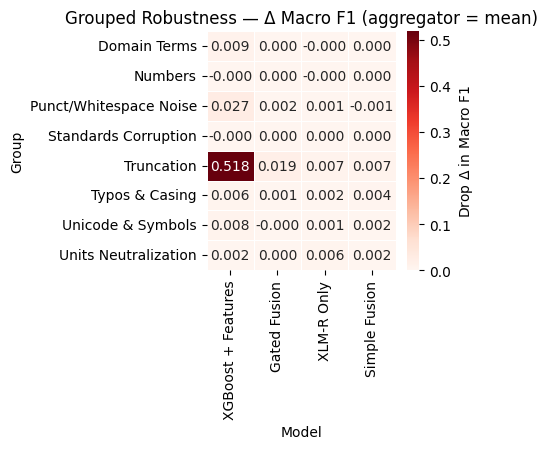

Saved heatmap (600 dpi): /content/drive/MyDrive/emc/adv_eval_outputs/figures_robustness/heatmap_grouped_delta_avg.png
Saved heatmap data CSV: /content/drive/MyDrive/emc/adv_eval_outputs/figures_robustness/heatmap_grouped_delta_avg.csv


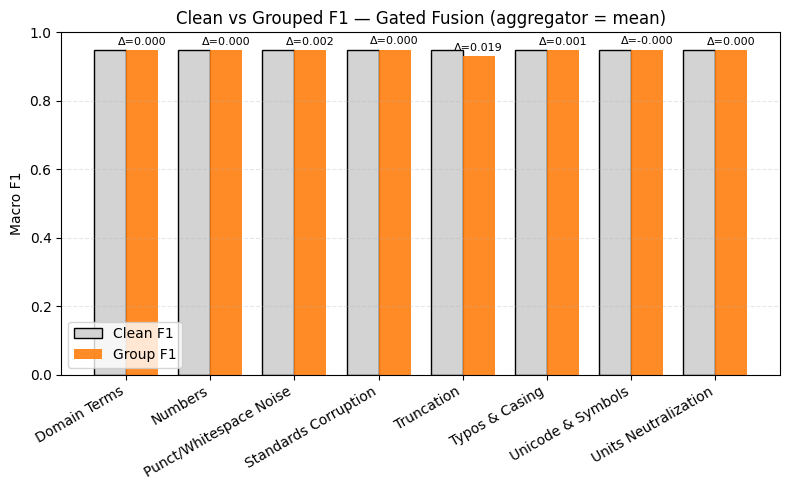

Saved grouped bars (600 dpi): /content/drive/MyDrive/emc/adv_eval_outputs/figures_robustness/grouped_bars_Gated_Fusion_avg.png


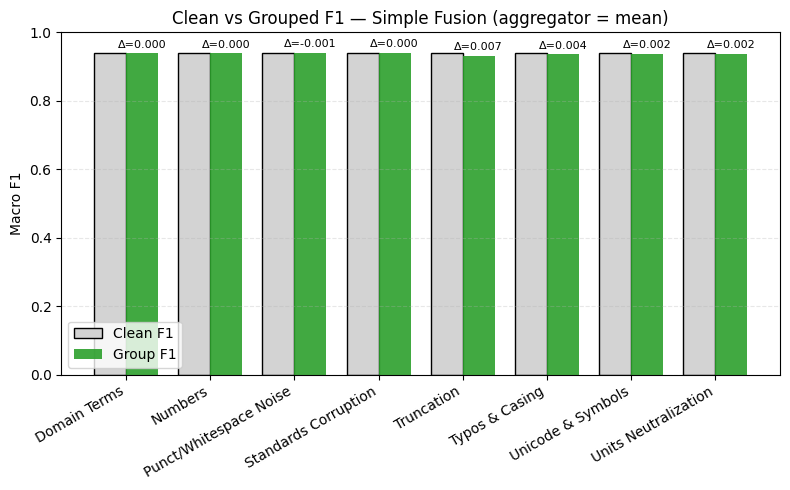

Saved grouped bars (600 dpi): /content/drive/MyDrive/emc/adv_eval_outputs/figures_robustness/grouped_bars_Simple_Fusion_avg.png


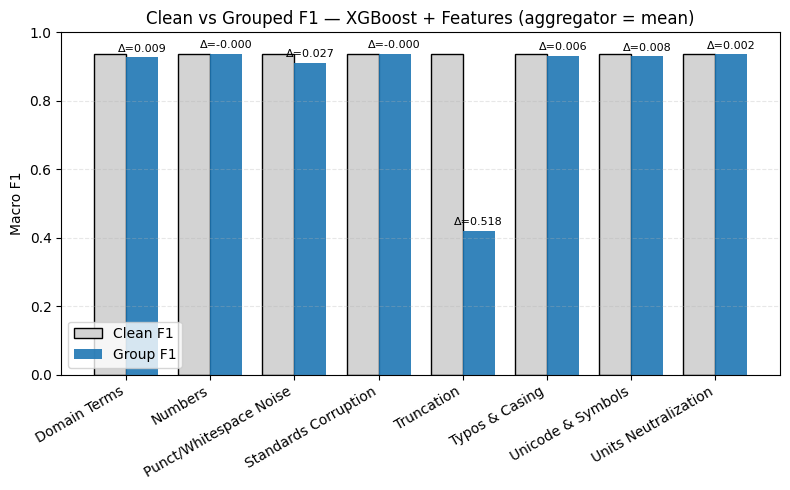

Saved grouped bars (600 dpi): /content/drive/MyDrive/emc/adv_eval_outputs/figures_robustness/grouped_bars_XGBoost_Features_avg.png


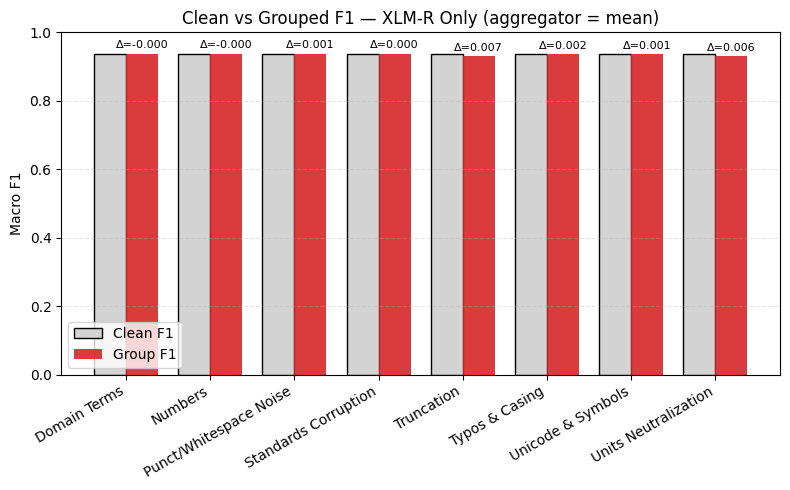

Saved grouped bars (600 dpi): /content/drive/MyDrive/emc/adv_eval_outputs/figures_robustness/grouped_bars_XLM-R_Only_avg.png
Done.


In [12]:
# --- Grouped Robustness: Heatmap (Δ Macro-F1) + Grouped Bars per Model (Clean vs Group F1) ---

import os, glob, re, numpy as np, pandas as pd, matplotlib.pyplot as plt

# Try seaborn (for heatmap). If missing, install; if install fails, fall back to matplotlib-only heatmap.
try:
    import seaborn as sns
    _HAS_SNS = True
except Exception:
    try:
        import sys, subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "seaborn"])
        import seaborn as sns
        _HAS_SNS = True
    except Exception:
        _HAS_SNS = False

# ----------------- paths & settings -----------------
BASE_DIR     = "/content/drive/MyDrive/emc"
ADV_OUT_DIR  = os.path.join(BASE_DIR, "adv_eval_outputs")
TABLES_DIR   = os.path.join(ADV_OUT_DIR, "manuscript_tables")
FIG_OUT_DIR  = os.path.join(ADV_OUT_DIR, "figures_robustness")
os.makedirs(FIG_OUT_DIR, exist_ok=True)

# Which grouped table to load if present (match Block 31 default)
AGGREGATOR   = "mean"   # "mean" | "median" | "worst"
SUFFIX_MAP   = {"mean":"avg", "median":"median", "worst":"worst"}
suffix       = SUFFIX_MAP.get(AGGREGATOR, "avg")
GROUPED_CSV  = os.path.join(TABLES_DIR, f"manuscript_grouped_macro_f1_{suffix}.csv")

# Optional: consistent model colors (used for bar charts)
MODEL_COLORS = {
    "XGBoost + Features": "tab:blue",
    "XLM-R Only":         "tab:red",
    "Simple Fusion":      "tab:green",
    "Gated Fusion":       "tab:orange",
}

# ----------------- fallback: mapping if we need to rebuild -----------------
ATTACK_GROUPS = {
    "CharSwap":"Typos & Casing", "DropVowels":"Typos & Casing", "CaseToggle":"Typos & Casing",
    "PunctInsert":"Punct/Whitespace Noise", "WhitespaceNoise":"Punct/Whitespace Noise",
    "UnicodeConfuse":"Unicode & Symbols", "SymbolAscii":"Unicode & Symbols",
    "NumberPerturb":"Numbers", "Truncate80w":"Truncation",
    "MaskDomainTerms":"Domain Terms", "DropDomainTerms":"Domain Terms", "SynonymSwapDomain":"Domain Terms",
    "StandardNumCorrupt":"Standards Corruption",
    "UnitNeutralizeMask":"Units Neutralization", "UnitNeutralizeDrop":"Units Neutralization", "UnitNeutralizeGeneric":"Units Neutralization",
    "AcronymPerturb":"Acronyms & Citations", "CitationStrip":"Acronyms & Citations",
    "DomainCombo1":"Domain Combos", "DomainCombo2":"Domain Combos", "DomainCombo3":"Domain Combos", "DomainMax":"Domain Combos",
}
KEEP_GROUPS = [
    "Typos & Casing",
    "Punct/Whitespace Noise",
    "Unicode & Symbols",
    "Numbers",
    "Truncation",
    "Domain Terms",
    "Standards Corruption",
    "Units Neutralization",
    # "Acronyms & Citations",
    # "Domain Combos",
]

def _safe_read_csv(p):
    try: return pd.read_csv(p)
    except Exception as e:
        print(f"Skip {os.path.basename(p)}: {e}"); return None

def _load_grouped_from_disk():
    if os.path.exists(GROUPED_CSV):
        df = pd.read_csv(GROUPED_CSV)
        # Ensure expected cols exist
        need = {"Model","Group","Clean Macro F1","Attack Macro F1","Δ","Δ%"}
        if need.issubset(df.columns):
            return df
        else:
            print("Grouped CSV found but missing expected columns, rebuilding from raw.")
    return None

def _rebuild_grouped_from_raw():
    clean_file = os.path.join(ADV_OUT_DIR, "clean_eval.csv")
    clean_df = _safe_read_csv(clean_file)
    if clean_df is None:
        raise FileNotFoundError("clean_eval.csv not found to rebuild grouped results.")
    clean_df = clean_df[clean_df["Attack"].astype(str).str.lower()=="clean"].copy()
    clean_df = clean_df.rename(columns={"macro_f1":"Clean Macro F1"})
    clean_df = clean_df[["Model","Clean Macro F1"]]

    paths = sorted(glob.glob(os.path.join(ADV_OUT_DIR, "adversarial_eval*.csv")))
    frames = []
    for p in paths:
        if p.endswith("clean_eval.csv"): continue
        df = _safe_read_csv(p)
        if df is None: continue
        if not {"Model","Attack","macro_f1"}.issubset(df.columns): continue
        frames.append(df[["Model","Attack","macro_f1"]])
    if not frames:
        raise RuntimeError("No adversarial_eval*.csv files found to rebuild grouped results.")
    adv = pd.concat(frames, ignore_index=True)
    adv = adv[adv["Attack"].isin(ATTACK_GROUPS.keys())].copy()
    adv["Group"] = adv["Attack"].map(ATTACK_GROUPS)
    if KEEP_GROUPS:
        adv = adv[adv["Group"].isin(KEEP_GROUPS)].copy()

    # Aggregate within group
    if AGGREGATOR == "mean":
        agg = adv.groupby(["Model","Group"], as_index=False)["macro_f1"].mean()
    elif AGGREGATOR == "median":
        agg = adv.groupby(["Model","Group"], as_index=False)["macro_f1"].median()
    elif AGGREGATOR == "worst":
        agg = adv.groupby(["Model","Group"], as_index=False)["macro_f1"].min()
    else:
        raise ValueError("AGGREGATOR must be one of {'mean','median','worst'}")
    agg = agg.rename(columns={"macro_f1":"Attack Macro F1"})

    out = agg.merge(clean_df, on="Model", how="left")
    out["Δ"]  = out["Clean Macro F1"] - out["Attack Macro F1"]
    out["Δ%"] = 100.0 * out["Δ"] / out["Clean Macro F1"].replace(0.0, np.nan)

    # Sort groups by mean drop desc
    grp_order = out.groupby("Group")["Δ"].mean().sort_values(ascending=False).index.tolist()
    out["Group"] = pd.Categorical(out["Group"], categories=grp_order, ordered=True)
    out = out.sort_values(["Group","Model"]).reset_index(drop=True)
    return out

# ----------------- 1) get grouped table -----------------
try:
    grouped_tbl   # already in memory from Block 30/31?
    df_grouped = grouped_tbl.copy()
except NameError:
    df_grouped = _load_grouped_from_disk()
    if df_grouped is None:
        print("Grouped table not found on disk; rebuilding from raw eval files...")
        df_grouped = _rebuild_grouped_from_raw()

# round for prettier annotations (keeps full precision internally if needed)
df_grouped["Clean Macro F1"]  = df_grouped["Clean Macro F1"].astype(float)
df_grouped["Attack Macro F1"] = df_grouped["Attack Macro F1"].astype(float)
df_grouped["Δ"]               = df_grouped["Δ"].astype(float)
df_grouped["Δ%"]              = df_grouped["Δ%"].astype(float)

# ----------------- 2a) HEATMAP of Δ Macro-F1 -----------------
# Pivot: rows=Group, cols=Model, values=Δ
heat = df_grouped.pivot(index="Group", columns="Model", values="Δ")

# Order rows (already categorical ordered by mean drop); order columns by overall AVERAGE drop
col_order = heat.mean(axis=0).sort_values(ascending=False).index.to_list()
heat = heat[col_order]

fig_h, ax_h = plt.subplots(figsize=(1.6 + 0.8*len(col_order), 1.0 + 0.45*len(heat.index)), dpi=100)
if _HAS_SNS:
    sns.heatmap(
        heat, ax=ax_h, cmap="Reds", annot=True, fmt=".3f",
        cbar_kws={"label": r"Drop $\Delta$ in Macro F1"}, linewidths=0.5, linecolor="white",
        vmin=0.0, vmax=max(0.05, float(np.nanmax(heat.values)))  # cap for visual spread
    )
else:
    im = ax_h.imshow(heat.values, cmap="Reds", aspect="auto", vmin=0.0, vmax=np.nanmax(heat.values))
    ax_h.set_xticks(range(len(heat.columns))); ax_h.set_xticklabels(heat.columns, rotation=45, ha="right")
    ax_h.set_yticks(range(len(heat.index)));   ax_h.set_yticklabels(heat.index)
    for i in range(heat.shape[0]):
        for j in range(heat.shape[1]):
            val = heat.values[i, j]
            if np.isfinite(val):
                ax_h.text(j, i, f"{val:.3f}", va="center", ha="center", color="black", fontsize=8)
    cbar = fig_h.colorbar(im, ax=ax_h); cbar.set_label(r"Drop $\Delta$ in Macro F1")

ax_h.set_title(f"Grouped Robustness — Δ Macro F1 (aggregator = {AGGREGATOR})")
plt.tight_layout()
heat_png = os.path.join(FIG_OUT_DIR, f"heatmap_grouped_delta_{suffix}.png")
plt.savefig(heat_png, dpi=600)
plt.show()
print("Saved heatmap (600 dpi):", heat_png)

# Also save the heatmap matrix
heat_csv = os.path.join(FIG_OUT_DIR, f"heatmap_grouped_delta_{suffix}.csv")
heat.to_csv(heat_csv)
print("Saved heatmap data CSV:", heat_csv)

# ----------------- 2b) GROUPED BARS per model (Clean vs Group F1, Δ annotated) -----------------
def sanitize_name(s: str) -> str:
    return re.sub(r"[^A-Za-z0-9_.-]+", "_", str(s))

models = df_grouped["Model"].unique().tolist()

for model in models:
    sub = df_grouped[df_grouped["Model"] == model].copy()
    # Preserve the group order used in heatmap
    sub["Group"] = pd.Categorical(sub["Group"], categories=heat.index.tolist(), ordered=True)
    sub = sub.sort_values("Group")

    groups = sub["Group"].astype(str).tolist()
    clean  = sub["Clean Macro F1"].values
    groupf = sub["Attack Macro F1"].values
    delta  = sub["Δ"].values

    x = np.arange(len(groups))
    width = 0.38

    fig, ax = plt.subplots(figsize=(max(8, 0.6*len(groups)+2), 5), dpi=100)
    # Clean F1 is constant per model, but plotted for comparability
    bars1 = ax.bar(x - width/2, clean,  width, label="Clean F1", color="lightgray", edgecolor="black")
    bars2 = ax.bar(x + width/2, groupf, width, label="Group F1", color=MODEL_COLORS.get(model, "tab:blue"), alpha=0.9)

    # Annotate Δ above the grouped F1 bars
    for xi, gval, dval in zip(x, groupf, delta):
        ax.text(xi + width/2, gval + 0.01, f"Δ={dval:.3f}", ha="center", va="bottom", fontsize=8, rotation=0)

    ax.set_xticks(x); ax.set_xticklabels(groups, rotation=30, ha="right")
    ax.set_ylim(0.0, min(1.05, max(1.0, float(np.nanmax(np.r_[clean, groupf])) + 0.05)))
    ax.set_ylabel("Macro F1")
    ax.set_title(f"Clean vs Grouped F1 — {model} (aggregator = {AGGREGATOR})")
    ax.legend(loc="best", frameon=True)
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    plt.tight_layout()

    out_png = os.path.join(FIG_OUT_DIR, f"grouped_bars_{sanitize_name(model)}_{suffix}.png")
    plt.savefig(out_png, dpi=600)
    plt.show()
    print("Saved grouped bars (600 dpi):", out_png)

print("Done.")


Using macro F1 from: /content/drive/MyDrive/emc/adv_eval_outputs/clean_eval.csv


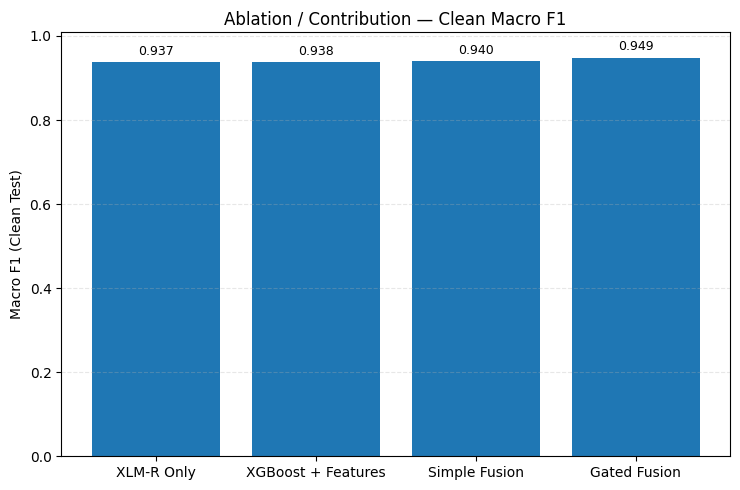

Saved: /content/drive/MyDrive/emc/figures_analysis/ablation_contribution_macroF1.png
Saved: /content/drive/MyDrive/emc/figures_analysis/ablation_contribution_macroF1.csv


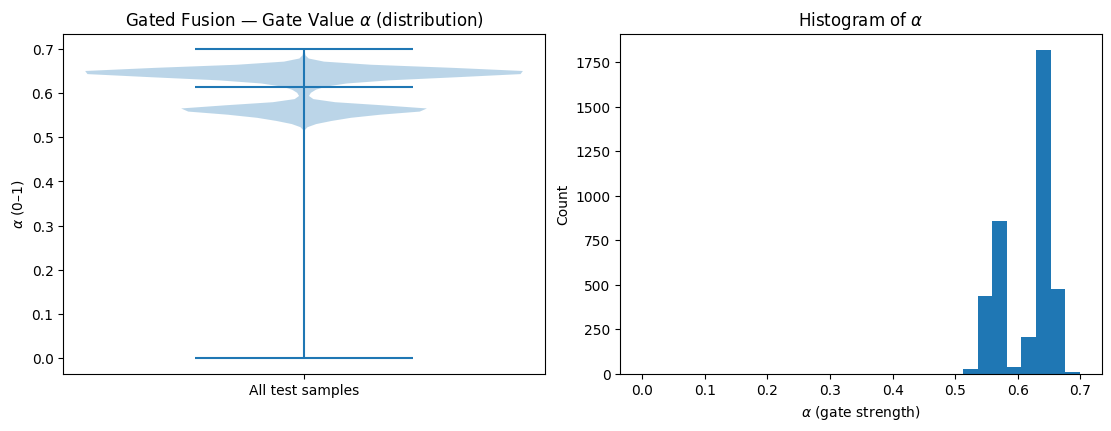

Saved: /content/drive/MyDrive/emc/figures_analysis/gated_alpha_distribution.png


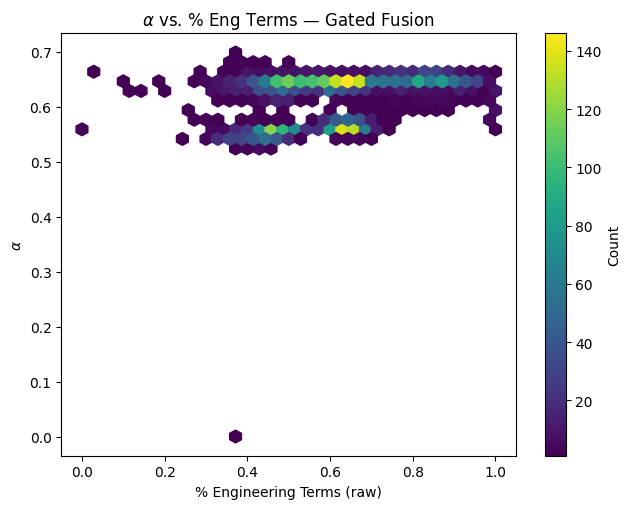

Saved: /content/drive/MyDrive/emc/figures_analysis/gated_alpha_vs_engterms_hexbin.png
Done.


In [14]:
# --- Ablation/Contribution + Gate Behavior (Gated Fusion) ---

import os, sys, subprocess, numpy as np, pandas as pd, matplotlib.pyplot as plt
from dataclasses import dataclass
from sklearn.metrics import f1_score
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Try to import joblib/xgboost; install if missing (Colab-safe)
try:
    import joblib
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "joblib"])
    import joblib

try:
    import xgboost as xgb
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])
    import xgboost as xgb

from transformers import (
    XLMRobertaTokenizerFast,
    XLMRobertaForSequenceClassification,
    XLMRobertaModel,
    DataCollatorWithPadding,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------ Config / defaults ------------------
try:
    cfg
except NameError:
    @dataclass
    class _TmpCfg:
        BASE_DIR: str = "/content/drive/MyDrive/emc"
        CLEAN_TEST_CSV: str = "/content/drive/MyDrive/emc/test.csv"
        TERMS_CSV: str = "/content/drive/MyDrive/emc/engineering_terms.csv"
        XGB_OUTPUTS: str = "/content/drive/MyDrive/emc/xgb_outputs_clean"
        XLM_R_OUTPUTS: str = "/content/drive/MyDrive/emc/xlmr_only_outputs_clean"
        SIMPLE_OUTPUTS: str = "/content/drive/MyDrive/emc/simple_fusion_outputs_clean"
        GATED_OUTPUTS: str = "/content/drive/MyDrive/emc/gated_fusion_outputs_clean"
        TEXT_COL: str = "content"
        LABEL_COL: str = "label"
        LANG_COL: str = "lang"
        MAX_LEN: int = 256
        BATCH_SIZE: int = 16
        N_FEATURES: int = 12
        ID2LABEL: dict = {0: "Real", 1: "Misinformation"}
    cfg = _TmpCfg()

FIG_DIR = os.path.join(cfg.BASE_DIR, "figures_analysis")
os.makedirs(FIG_DIR, exist_ok=True)

# ------------------ Load test set ------------------
test_df = pd.read_csv(cfg.CLEAN_TEST_CSV)
y_true = test_df[cfg.LABEL_COL].astype(int).values

# ------------------ 12-D features (same as training) ------------------
import re
_WORD_RE = re.compile(r"\w+", re.UNICODE)
_NUM_RE  = re.compile(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?')
STD_TERMS = {"iso","asme","ieee","din","ansi","iec","ul","astm","en"}
SAFETY_TERMS = {"safety","hazard","warning","risk","caution","danger","emergency"}

def simple_words(t: str): return _WORD_RE.findall(t or "")
def sent_count(t: str) -> int:
    if not t: return 0
    return max(1, len(re.split(r'[.!?]+[\s\n]+', t)))
def punct_count(t: str) -> int: return sum(1 for ch in (t or "") if ch in ".,;:!?")
def extract_numbers(text: str):
    nums, dec = [], 0
    for m in _NUM_RE.finditer(text or ""):
        s = m.group(0)
        try:
            v = float(s)
            if ('.' in s) or ('e' in s.lower()): dec += 1
            nums.append(abs(v))
        except: pass
    return nums, dec
def _finite_or_zero(x: float):
    try:
        xx = float(x);
        return xx if np.isfinite(xx) else 0.0
    except: return 0.0

class TermsLexicon:
    def __init__(self, csv_path: str, term_col="terms", lang_col="lang"):
        if not os.path.exists(csv_path): raise FileNotFoundError(csv_path)
        df = pd.read_csv(csv_path)
        if term_col not in df.columns: raise ValueError(f"Missing '{term_col}'")
        if lang_col not in df.columns: df[lang_col] = 'en'
        self.by_lang = {
            str(l).lower(): set(str(x).strip().lower() for x in d[term_col].dropna().tolist() if str(x).strip())
            for l, d in df.groupby(lang_col)
        }
    def pct_in_text(self, text: str, lang: str) -> float:
        if not text: return 0.0
        terms = self.by_lang.get((lang or "en").lower(), set())
        if not terms: return 0.0
        ws = [w.lower() for w in simple_words(text)]
        if not ws: return 0.0
        return sum(1 for w in ws if w in terms) / max(1, len(ws))

class FeatureExtractor12:
    def __init__(self, tlex: TermsLexicon): self.tlex = tlex
    def extract_one(self, text: str, lang: str):
        text = "" if text is None else str(text); lang = (lang or "en").lower()
        ws = simple_words(text); n_words = len(ws)
        chars = len(text); words = n_words; sents = sent_count(text)
        fre, fog = 0.0, 0.0  # portable
        eng_pct = self.tlex.pct_in_text(text, lang)
        punc = punct_count(text)
        nums, dec_cnt = extract_numbers(text); nnums = len(nums)
        avg_mag = float(np.mean(nums)) if nums else 0.0
        dec_ratio = float(dec_cnt / max(1, len(nums)))
        low = text.lower()
        has_std = 1.0 if any(t in low for t in STD_TERMS) else 0.0
        has_saf = 1.0 if any(t in low for t in SAFETY_TERMS) else 0.0
        vals = [chars, words, sents, fre, fog, eng_pct, punc, nnums, has_std, has_saf, avg_mag, dec_ratio]
        feats = np.asarray([_finite_or_zero(v) for v in vals], dtype=np.float64)
        feats = np.nan_to_num(feats, nan=0.0, posinf=1e12, neginf=0.0)
        return np.clip(feats, -1e12, 1e12).astype(np.float32)
    def extract_df(self, df):
        local = df if cfg.LANG_COL in df.columns else df.assign(**{cfg.LANG_COL:'en'})
        rows = [self.extract_one(r.get(cfg.TEXT_COL,""), r.get(cfg.LANG_COL,"en")) for _, r in local.iterrows()]
        return np.stack(rows, axis=0).astype(np.float32)

lex = TermsLexicon(cfg.TERMS_CSV)
fe  = FeatureExtractor12(lex)
X_raw = fe.extract_df(test_df)

# ------------------ Tokenization datasets ------------------
class TextOnlyDS(Dataset):
    def __init__(self, df, tokenizer, text_col="content", label_col="label", max_len=256):
        self.texts = df[text_col].astype(str).tolist()
        self.labels = df[label_col].astype(int).values
        self.tok = tokenizer; self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tok(self.texts[idx], truncation=True, padding=False,
                       max_length=self.max_len, return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

class TextFeatDS(Dataset):
    def __init__(self, df, tokenizer, feats_scaled, text_col="content", label_col="label", max_len=256):
        self.texts = df[text_col].astype(str).tolist()
        self.labels = df[label_col].astype(int).values
        self.tok = tokenizer; self.max_len = max_len
        self.feats = feats_scaled.astype(np.float32)
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tok(self.texts[idx], truncation=True, padding="max_length",
                       max_length=self.max_len, return_tensors="pt")
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(int(self.labels[idx]), dtype=torch.long),
            "feats": torch.tensor(self.feats[idx], dtype=torch.float32),
        }

# ------------------ Model defs (Simple / Gated) ------------------
class SimpleFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + n_feats, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        fused = torch.cat([pooled, feats], dim=1)
        return self.classifier(self.dropout(fused))

class GatedFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2, feat_proj: int = 64):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.fe_proj = nn.Sequential(nn.Linear(n_feats, feat_proj), nn.ReLU())
        self.gate    = nn.Sequential(nn.Linear(H + n_feats, 64), nn.ReLU(), nn.Linear(64, 1), nn.Sigmoid())
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + feat_proj, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        alpha = self.gate(torch.cat([pooled, feats], dim=1))
        ef    = self.fe_proj(feats)
        fused = torch.cat([pooled, alpha * ef], dim=1)
        return self.classifier(self.dropout(fused))
    # helper to expose alpha
    def gate_values(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        alpha = self.gate(torch.cat([pooled, feats], dim=1))
        return alpha.squeeze(-1)  # [B]

# ------------------ Load artifacts ------------------
# Tokenizer from fine-tuned XLM-R
tok = XLMRobertaTokenizerFast.from_pretrained(cfg.XLM_R_OUTPUTS)
collator = DataCollatorWithPadding(tok)

# XGB
xgb_model = xgb.XGBClassifier()
xgb_model.load_model(os.path.join(cfg.XGB_OUTPUTS, "xgb_model.json"))
xgb_scaler = joblib.load(os.path.join(cfg.XGB_OUTPUTS, "scaler12.pkl"))
X_xgb = xgb_scaler.transform(X_raw)

# XLM-R (fine-tuned)
xlmr = XLMRobertaForSequenceClassification.from_pretrained(cfg.XLM_R_OUTPUTS).to(device)
xlmr.eval()

# Simple Fusion
simple = SimpleFusion("xlm-roberta-base", n_feats=cfg.N_FEATURES, n_labels=2).to(device)
simple.load_state_dict(torch.load(os.path.join(cfg.SIMPLE_OUTPUTS, "fusion_simple.pt"), map_location=device), strict=False)
simple.eval()
simple_scaler = joblib.load(os.path.join(cfg.SIMPLE_OUTPUTS, "scaler12.pkl"))
X_simple = simple_scaler.transform(X_raw)

# Gated Fusion
gated = GatedFusion("xlm-roberta-base", n_feats=cfg.N_FEATURES, n_labels=2, feat_proj=64).to(device)
gated.load_state_dict(torch.load(os.path.join(cfg.GATED_OUTPUTS, "fusion_gated.pt"), map_location=device), strict=False)
gated.eval()
gated_scaler = joblib.load(os.path.join(cfg.GATED_OUTPUTS, "scaler12.pkl"))
X_gated = gated_scaler.transform(X_raw)

# ------------------ If clean_eval.csv exists, use it; else compute ------------------
ABLATION_PNG = os.path.join(FIG_DIR, "ablation_contribution_macroF1.png")
GATE_DISTR_PNG = os.path.join(FIG_DIR, "gated_alpha_distribution.png")
GATE_HEXBIN_PNG = os.path.join(FIG_DIR, "gated_alpha_vs_engterms_hexbin.png")
ABLATION_CSV = os.path.join(FIG_DIR, "ablation_contribution_macroF1.csv")

clean_eval_csv = os.path.join(cfg.BASE_DIR, "adv_eval_outputs", "clean_eval.csv")
use_csv = os.path.exists(clean_eval_csv)

if use_csv:
    df_clean = pd.read_csv(clean_eval_csv)
    df_clean = df_clean[df_clean["Attack"].astype(str).str.lower() == "clean"].copy()
    # Expect columns: Model, macro_f1
    f1_map = df_clean.set_index("Model")["macro_f1"].to_dict()
    print("Using macro F1 from:", clean_eval_csv)
else:
    print("No clean_eval.csv found — computing Macro F1 from checkpoints...")

    # XLM-R probs/preds
    ds_xlmr = TextOnlyDS(test_df, tok, text_col=cfg.TEXT_COL, label_col=cfg.LABEL_COL, max_len=cfg.MAX_LEN)
    dl_xlmr = DataLoader(ds_xlmr, batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=collator)
    yhat_xlmr = []
    with torch.no_grad():
        for b in dl_xlmr:
            inp = {k: v.to(device) for k, v in b.items() if k in ("input_ids","attention_mask")}
            logits = xlmr(**inp).logits
            yhat_xlmr.append(logits.argmax(dim=-1).cpu().numpy())
    yhat_xlmr = np.concatenate(yhat_xlmr)

    # XGB preds
    yhat_xgb = xgb_model.predict(X_xgb)

    # Simple preds
    ds_simple = TextFeatDS(test_df, tok, X_simple, text_col=cfg.TEXT_COL, label_col=cfg.LABEL_COL, max_len=cfg.MAX_LEN)
    dl_simple = DataLoader(ds_simple, batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=collator)
    yhat_simple = []
    with torch.no_grad():
        for b in dl_simple:
            ids = b["input_ids"].to(device); am = b["attention_mask"].to(device); ft = b["feats"].to(device)
            logits = simple(ids, am, ft)
            yhat_simple.append(logits.argmax(dim=-1).cpu().numpy())
    yhat_simple = np.concatenate(yhat_simple)

    # Gated preds
    ds_gated = TextFeatDS(test_df, tok, X_gated, text_col=cfg.TEXT_COL, label_col=cfg.LABEL_COL, max_len=cfg.MAX_LEN)
    dl_gated = DataLoader(ds_gated, batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=collator)
    yhat_gated = []
    with torch.no_grad():
        for b in dl_gated:
            ids = b["input_ids"].to(device); am = b["attention_mask"].to(device); ft = b["feats"].to(device)
            logits = gated(ids, am, ft)
            yhat_gated.append(logits.argmax(dim=-1).cpu().numpy())
    yhat_gated = np.concatenate(yhat_gated)

    f1_map = {
        "XLM-R Only": f1_score(y_true, yhat_xlmr, average="macro"),
        "XGBoost + Features": f1_score(y_true, yhat_xgb, average="macro"),
        "Simple Fusion": f1_score(y_true, yhat_simple, average="macro"),
        "Gated Fusion": f1_score(y_true, yhat_gated, average="macro"),
    }

# ------------------ (1) Ablation / Contribution Plot ------------------
# Order models for visual consistency
order_models = ["XLM-R Only", "XGBoost + Features", "Simple Fusion", "Gated Fusion"]
vals = [f1_map[m] for m in order_models if m in f1_map]

plt.figure(figsize=(7.5, 5.0))
bars = plt.bar(order_models, vals)
# Annotate values on bars
for rect, v in zip(bars, vals):
    plt.text(rect.get_x() + rect.get_width()/2, rect.get_height() + 0.01, f"{v:.3f}",
             ha="center", va="bottom", fontsize=9)
plt.ylabel("Macro F1 (Clean Test)")
plt.title("Ablation / Contribution — Clean Macro F1")
plt.ylim(0.0, min(1.05, max(1.0, float(np.max(vals)) + 0.06)))
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig(ABLATION_PNG, dpi=600)
plt.show()
print("Saved:", ABLATION_PNG)

pd.DataFrame({"Model": order_models, "Macro_F1": vals}).to_csv(ABLATION_CSV, index=False)
print("Saved:", ABLATION_CSV)

# ------------------ (2) Gate Behavior (Gated Fusion) ------------------
# Collect alpha for whole test set (using SCALED features for gating)
alphas, eng_terms_pct = [], []
with torch.no_grad():
    for b in dl_gated:
        ids = b["input_ids"].to(device); am = b["attention_mask"].to(device); ft = b["feats"].to(device)
        a = gated.gate_values(ids, am, ft)  # [B]
        alphas.append(a.cpu().numpy())
# Concatenate gate values
alphas = np.concatenate(alphas)

# % Eng Terms from RAW features (for interpretability) — feature index 5
eng_terms_pct = X_raw[:, 5].astype(float)

# (2a) Violin + Histogram
fig, axes = plt.subplots(1, 2, figsize=(11, 4.2), constrained_layout=True)
# Violin
axes[0].violinplot(alphas, showmeans=True, showextrema=True)
axes[0].set_title("Gated Fusion — Gate Value $\\alpha$ (distribution)")
axes[0].set_xticks([1]); axes[0].set_xticklabels(["All test samples"])
axes[0].set_ylabel("$\\alpha$ (0–1)")

# Histogram
axes[1].hist(alphas, bins=30)
axes[1].set_title("Histogram of $\\alpha$")
axes[1].set_xlabel("$\\alpha$ (gate strength)"); axes[1].set_ylabel("Count")

plt.savefig(GATE_DISTR_PNG, dpi=600)
plt.show()
print("Saved:", GATE_DISTR_PNG)

# (2b) 2D density (hexbin) of alpha vs % Eng Terms
plt.figure(figsize=(6.5, 5.2))
hb = plt.hexbin(eng_terms_pct, alphas, gridsize=35, cmap="viridis", mincnt=1)
plt.xlabel("% Engineering Terms (raw)"); plt.ylabel("$\\alpha$")
plt.title("$\\alpha$ vs. % Eng Terms — Gated Fusion")
cb = plt.colorbar(hb); cb.set_label("Count")
plt.tight_layout()
plt.savefig(GATE_HEXBIN_PNG, dpi=600)
plt.show()
print("Saved:", GATE_HEXBIN_PNG)

print("Done.")


Saved per-attack Δ table: /content/drive/MyDrive/emc/adv_eval_outputs/figures_specificity/per_attack_delta_macro_f1.csv


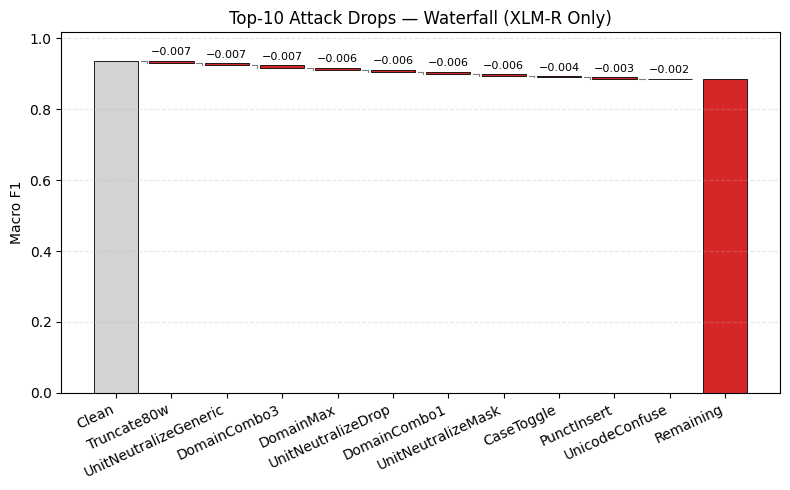

Saved waterfall: /content/drive/MyDrive/emc/adv_eval_outputs/figures_specificity/waterfall_top10_XLM-R_Only.png


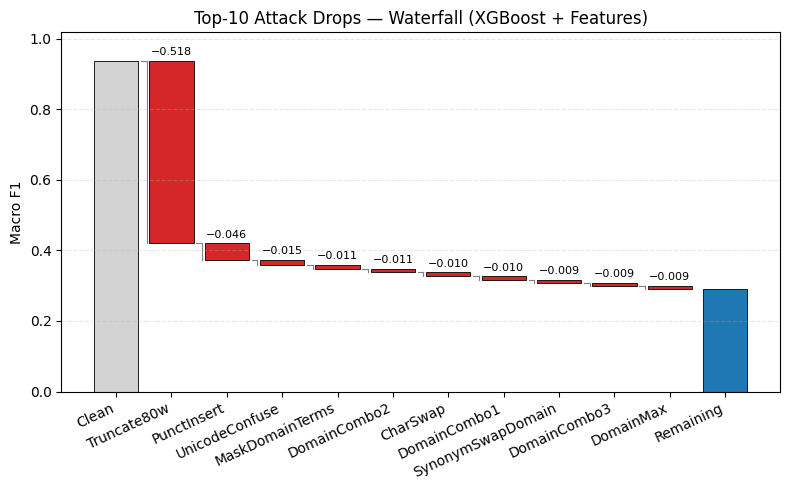

Saved waterfall: /content/drive/MyDrive/emc/adv_eval_outputs/figures_specificity/waterfall_top10_XGBoost_Features.png


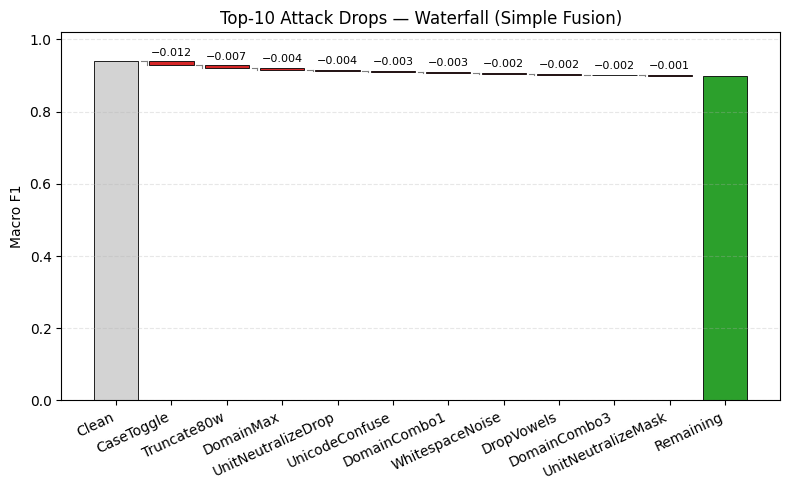

Saved waterfall: /content/drive/MyDrive/emc/adv_eval_outputs/figures_specificity/waterfall_top10_Simple_Fusion.png


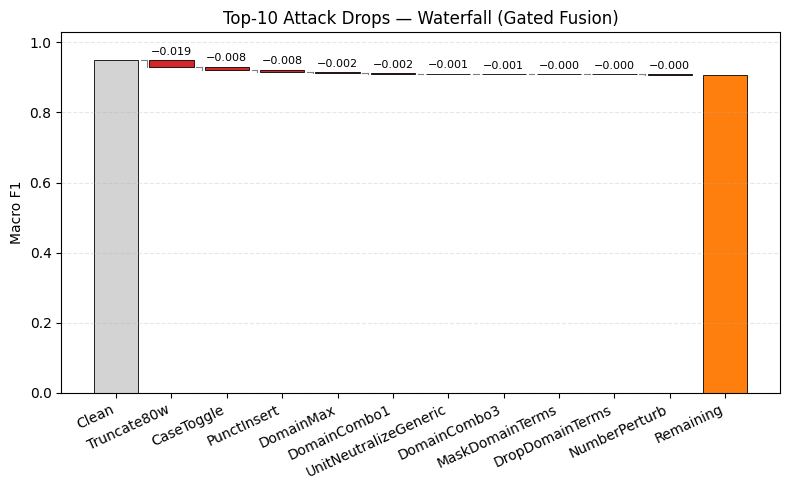

Saved waterfall: /content/drive/MyDrive/emc/adv_eval_outputs/figures_specificity/waterfall_top10_Gated_Fusion.png
Saved domain coverage vs drop table: /content/drive/MyDrive/emc/adv_eval_outputs/figures_specificity/domain_coverage_vs_drop.csv


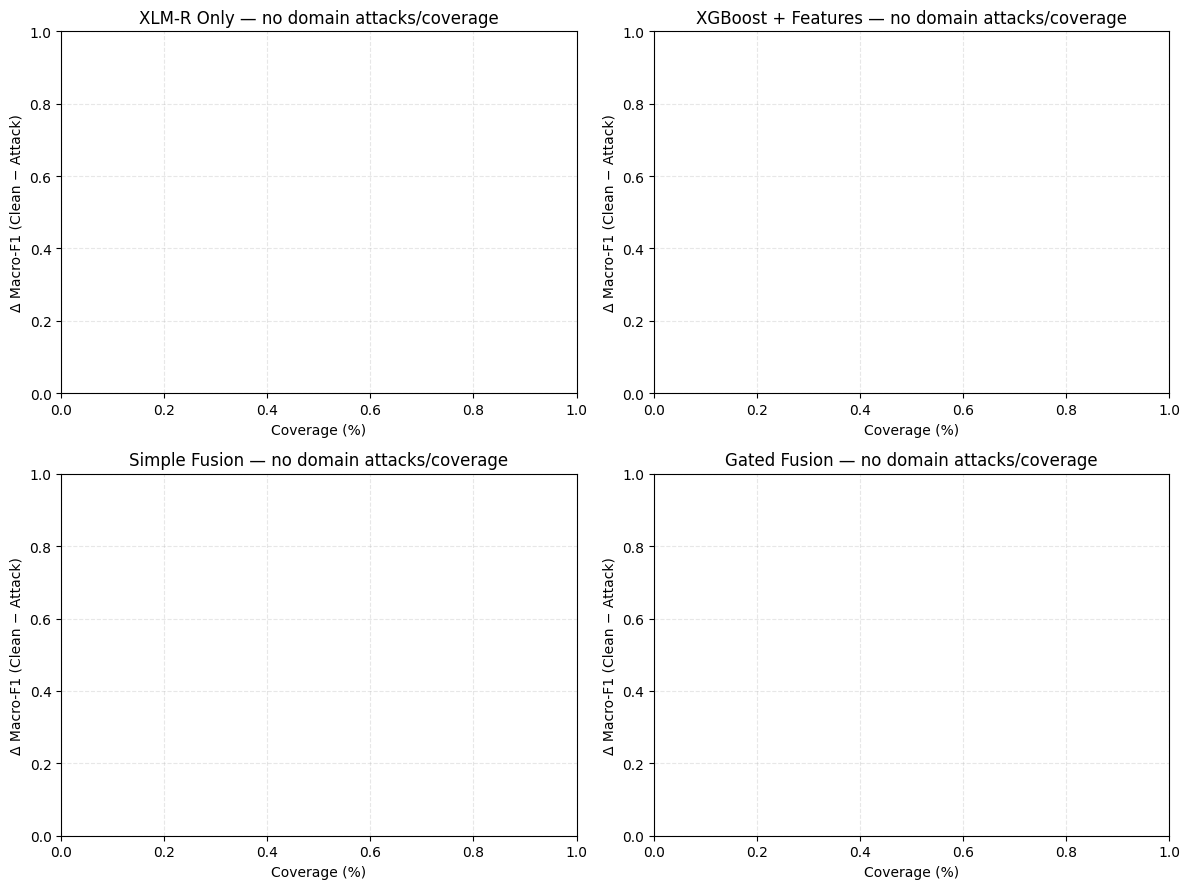

Saved scatter grid: /content/drive/MyDrive/emc/adv_eval_outputs/figures_specificity/coverage_vs_drop_scatter_domain.png
Done.


In [15]:
# --- Waterfall (Top-K Δ Macro-F1) per model + Coverage vs Drop Scatter (domain attacks) ---

import os, glob, re, numpy as np, pandas as pd, matplotlib.pyplot as plt

# ---------------- Paths & settings ----------------
BASE_DIR     = "/content/drive/MyDrive/emc"
ADV_DIR      = os.path.join(BASE_DIR, "adv_eval_outputs")
PERTURB_DIR  = os.path.join(ADV_DIR, "perturbed")
FIG_DIR      = os.path.join(ADV_DIR, "figures_specificity")
os.makedirs(FIG_DIR, exist_ok=True)

CLEAN_EVAL   = os.path.join(ADV_DIR, "clean_eval.csv")
ADV_EVAL_GLOB= os.path.join(ADV_DIR, "adversarial_eval*.csv")

TEXT_COL     = "content"
LABEL_COL    = "label"
ID_COL       = "id"        # if present in clean & perturbed, used to align rows for coverage
TOP_K        = 10          # number of attacks to show in waterfall
DPI          = 600

# If you already produced a coverage summary, put it here (columns: Attack, coverage_pct)
COVERAGE_SUMMARY = os.path.join(ADV_DIR, "coverage_summary.csv")

# Domain-related groups for scatter
ATTACK_GROUPS = {
    "CharSwap":"Typos & Casing", "DropVowels":"Typos & Casing", "CaseToggle":"Typos & Casing",
    "PunctInsert":"Punct/Whitespace Noise", "WhitespaceNoise":"Punct/Whitespace Noise",
    "UnicodeConfuse":"Unicode & Symbols", "SymbolAscii":"Unicode & Symbols",
    "NumberPerturb":"Numbers", "Truncate80w":"Truncation",
    "MaskDomainTerms":"Domain Terms", "DropDomainTerms":"Domain Terms", "SynonymSwapDomain":"Domain Terms",
    "StandardNumCorrupt":"Standards Corruption",
    "UnitNeutralizeMask":"Units Neutralization", "UnitNeutralizeDrop":"Units Neutralization", "UnitNeutralizeGeneric":"Units Neutralization",
    "AcronymPerturb":"Acronyms & Citations", "CitationStrip":"Acronyms & Citations",
    "DomainCombo1":"Domain Combos", "DomainCombo2":"Domain Combos", "DomainCombo3":"Domain Combos", "DomainMax":"Domain Combos",
}
DOMAIN_GROUPS = {
    "Domain Terms", "Standards Corruption", "Units Neutralization",
    "Acronyms & Citations", "Domain Combos"
}

# Model display order/colors
MODELS = ["XLM-R Only", "XGBoost + Features", "Simple Fusion", "Gated Fusion"]
MODEL_COLORS = {
    "XGBoost + Features": "tab:blue",
    "XLM-R Only":         "tab:red",
    "Simple Fusion":      "tab:green",
    "Gated Fusion":       "tab:orange",
}

def _read_csv(path):
    try:
        return pd.read_csv(path)
    except Exception as e:
        print(f"Skip {os.path.basename(path)}: {e}")
        return None

# ---------------- Load clean & adversarial evals ----------------
clean_df = _read_csv(CLEAN_EVAL)
if clean_df is None:
    raise FileNotFoundError("clean_eval.csv not found. Please export clean results first.")

clean_df = clean_df.copy()
clean_df["Attack_low"] = clean_df["Attack"].astype(str).str.lower()
clean_df = clean_df[clean_df["Attack_low"] == "clean"]
clean_base = clean_df[["Model","macro_f1"]].rename(columns={"macro_f1":"Clean Macro F1"})

adv_frames = []
for p in sorted(glob.glob(ADV_EVAL_GLOB)):
    if os.path.basename(p).lower() == "clean_eval.csv":
        continue
    dfp = _read_csv(p)
    if dfp is None:
        continue
    if not {"Model","Attack","macro_f1"}.issubset(dfp.columns):
        continue
    adv_frames.append(dfp[["Model","Attack","macro_f1"]])
if not adv_frames:
    raise RuntimeError("No adversarial_eval*.csv files found.")

adv_all = pd.concat(adv_frames, ignore_index=True)
adv_all["Attack"] = adv_all["Attack"].astype(str)
adv_all["Group"]  = adv_all["Attack"].map(ATTACK_GROUPS).fillna("Other")

# Merge with clean baseline per model to compute Δ
adv_all = adv_all.merge(clean_base, on="Model", how="left")
adv_all["Delta"] = adv_all["Clean Macro F1"] - adv_all["macro_f1"]
adv_all["Delta%"] = 100.0 * adv_all["Delta"] / adv_all["Clean Macro F1"].replace(0.0, np.nan)

# Save per-attack deltas (for traceability)
delta_csv = os.path.join(FIG_DIR, "per_attack_delta_macro_f1.csv")
adv_all.to_csv(delta_csv, index=False)
print("Saved per-attack Δ table:", delta_csv)

# ---------------- (A) Waterfall (Top-K drops) per model ----------------
def waterfall_plot_for_model(df_model, model_name, top_k=10):
    # Sort attacks by Delta desc (largest drop first)
    top = df_model.sort_values("Delta", ascending=False).head(top_k).copy()
    clean = float(df_model["Clean Macro F1"].iloc[0])

    # Cumulative "remaining" after sequentially subtracting these K worst drops
    drops = top["Delta"].values.clip(min=0)
    remaining = max(0.0, clean - drops.sum())

    labels = ["Clean"] + top["Attack"].tolist() + ["Remaining"]
    x = np.arange(len(labels))

    # Bar heights and bottoms for a simple waterfall illusion:
    heights = []
    bottoms = []
    colors  = []
    # Clean bar
    heights.append(clean); bottoms.append(0.0); colors.append("lightgray")
    # Drops (draw as downward red blocks sitting on the *post-drop* baseline)
    running = clean
    for d in drops:
        running_after = max(0.0, running - d)
        heights.append(d)
        bottoms.append(running_after)
        colors.append("tab:red")
        running = running_after
    # Final remaining
    heights.append(remaining); bottoms.append(0.0); colors.append(MODEL_COLORS.get(model_name, "tab:blue"))

    fig, ax = plt.subplots(figsize=(max(8, 0.6*len(labels)), 5))
    for i in range(len(labels)):
        ax.bar(x[i], heights[i], bottom=bottoms[i], color=colors[i], edgecolor="black", linewidth=0.6)

    # connectors between tops (optional visual cue)
    y_prev = clean
    for i, d in enumerate(drops, start=1):
        y_new = max(0.0, y_prev - d)
        ax.plot([x[i-1]+0.45, x[i]-0.45], [y_prev, y_prev], color="gray", lw=0.8)  # top line segment
        ax.plot([x[i]-0.45, x[i]-0.45], [y_prev, y_new], color="gray", lw=0.8)    # vertical drop
        y_prev = y_new

    # annotate drop values
    for i, d in enumerate(drops, start=1):
        ax.text(x[i], bottoms[i] + heights[i] + 0.01, f"−{d:.3f}", ha="center", va="bottom", fontsize=8)

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=25, ha="right")
    ax.set_ylabel("Macro F1")
    ax.set_title(f"Top-{top_k} Attack Drops — Waterfall ({model_name})")
    ax.set_ylim(0.0, min(1.05, max(1.0, clean + 0.08)))
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    plt.tight_layout()

    out_png = os.path.join(FIG_DIR, f"waterfall_top{top_k}_{re.sub(r'[^A-Za-z0-9_.-]+','_',model_name)}.png")
    plt.savefig(out_png, dpi=DPI)
    plt.show()
    print("Saved waterfall:", out_png)

# Generate waterfall per model
for m in MODELS:
    dfm = adv_all[adv_all["Model"] == m].copy()
    if dfm.empty:
        print(f"[WARN] No rows for model: {m}")
        continue
    waterfall_plot_for_model(dfm, m, top_k=TOP_K)

# ---------------- (B) Coverage vs. Drop Scatter (domain attacks) ----------------
# 1) coverage lookup: prefer summary, else compute by comparing clean vs perturbed contents
def _load_coverage_summary(path):
    if os.path.exists(path):
        try:
            cov = pd.read_csv(path)
            if {"Attack","coverage_pct"}.issubset(cov.columns):
                cov["Attack"] = cov["Attack"].astype(str)
                return cov[["Attack","coverage_pct"]].drop_duplicates()
        except Exception as e:
            print("Coverage summary read failed:", e)
    return None

coverage_summary = _load_coverage_summary(COVERAGE_SUMMARY)

# Load clean test for coverage fallback
clean_test_path = os.path.join(BASE_DIR, "test.csv")
clean_test_df = _read_csv(clean_test_path)

def _estimate_coverage_from_files(attack):
    # Find a perturbed file for this attack
    cands = [
        os.path.join(PERTURB_DIR, f"{attack}.csv"),
        os.path.join(PERTURB_DIR, attack, "dataset.csv"),
        os.path.join(PERTURB_DIR, f"{attack}_test.csv"),
    ]
    path = None
    for p in cands:
        if os.path.exists(p):
            path = p; break
    if path is None:
        g = glob.glob(os.path.join(PERTURB_DIR, f"**/*{attack}*.csv"), recursive=True)
        if g: path = g[0]
    if path is None or clean_test_df is None:
        return np.nan

    adv_df = _read_csv(path)
    if adv_df is None or TEXT_COL not in adv_df.columns:
        return np.nan

    # align rows
    if ID_COL in adv_df.columns and ID_COL in clean_test_df.columns:
        merged = clean_test_df[[ID_COL, TEXT_COL]].merge(
            adv_df[[ID_COL, TEXT_COL]], on=ID_COL, suffixes=("_clean","_adv")
        )
        if merged.empty:
            return np.nan
        changed = (merged[f"{TEXT_COL}_clean"].astype(str).values != merged[f"{TEXT_COL}_adv"].astype(str).values)
        coverage = 100.0 * changed.mean()
    else:
        # fallback: assume same order & length
        n = min(len(clean_test_df), len(adv_df))
        changed = (clean_test_df[TEXT_COL].astype(str).values[:n] != adv_df[TEXT_COL].astype(str).values[:n])
        coverage = 100.0 * (changed.sum() / max(1, n))
    return float(coverage)

def get_coverage_pct(attack):
    if coverage_summary is not None:
        row = coverage_summary[coverage_summary["Attack"] == attack]
        if not row.empty:
            return float(row["coverage_pct"].iloc[0])
    return _estimate_coverage_from_files(attack)

# Build dataframe for domain attacks with coverage & Δ per model
dom = adv_all.copy()
dom = dom[dom["Group"].isin(DOMAIN_GROUPS)].copy()

cov_vals = []
for atk in sorted(dom["Attack"].unique()):
    cov_vals.append((atk, get_coverage_pct(atk)))
cov_df = pd.DataFrame(cov_vals, columns=["Attack","coverage_pct"])

dom = dom.merge(cov_df, on="Attack", how="left")

# Save table
cov_csv = os.path.join(FIG_DIR, "domain_coverage_vs_drop.csv")
dom.to_csv(cov_csv, index=False)
print("Saved domain coverage vs drop table:", cov_csv)

# 2) Scatter grid: one subplot per model
n_models = len(MODELS)
n_cols = 2
n_rows = int(np.ceil(n_models / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4.5*n_rows), squeeze=False)

for i, m in enumerate(MODELS):
    r = i // n_cols
    c = i %  n_cols
    ax = axes[r][c]
    sub = dom[dom["Model"] == m].copy()
    sub = sub[np.isfinite(sub["coverage_pct"])]

    if sub.empty:
        ax.set_title(f"{m} — no domain attacks/coverage")
        ax.set_xlabel("Coverage (%)"); ax.set_ylabel("Δ Macro-F1 (Clean − Attack)")
        ax.grid(True, linestyle="--", alpha=0.3)
        continue

    x = sub["coverage_pct"].values
    y = sub["Delta"].values
    ax.scatter(x, y, s=28, alpha=0.9, color=MODEL_COLORS.get(m, None), edgecolors="black", linewidths=0.4)

    # (optional) show simple Pearson r
    if len(x) >= 2:
        r_val = np.corrcoef(x, y)[0,1]
        ax.text(0.02, 0.95, f"r={r_val:.2f}", transform=ax.transAxes, ha="left", va="top", fontsize=10)

    # nice labels
    for _, row in sub.iterrows():
        ax.annotate(row["Attack"], (row["coverage_pct"], row["Delta"]), fontsize=7, xytext=(3,3), textcoords="offset points")

    ax.set_title(f"{m} — Coverage vs Δ Macro-F1 (Domain attacks)")
    ax.set_xlabel("Coverage (%)")
    ax.set_ylabel("Δ Macro-F1 (Clean − Attack)")
    ax.grid(True, linestyle="--", alpha=0.3)

# remove empty axes if any
for j in range(i+1, n_rows*n_cols):
    r = j // n_cols; c = j % n_cols
    fig.delaxes(axes[r][c])

plt.tight_layout()
scatter_png = os.path.join(FIG_DIR, "coverage_vs_drop_scatter_domain.png")
plt.savefig(scatter_png, dpi=DPI)
plt.show()
print("Saved scatter grid:", scatter_png)

print("Done.")


Worst group & attack per model:
                Model          Group      Attack  AttackMacroF1
        Gated Fusion     Truncation Truncate80w       0.929930
 Gated Fusion (mask)          Other Cue Removal       0.819311
       Simple Fusion Typos & Casing  CaseToggle       0.927942
Simple Fusion (mask)          Other Cue Removal       0.906373
  XGBoost + Features     Truncation Truncate80w       0.419705
          XLM-R Only     Truncation Truncate80w       0.930507
[warn] Could not find perturbed CSV for attack 'Truncate80w'. Skipping CM plot for Gated Fusion.
[warn] Could not find perturbed CSV for attack 'Cue Removal'. Skipping CM plot for Gated Fusion (mask).
[warn] Could not find perturbed CSV for attack 'CaseToggle'. Skipping CM plot for Simple Fusion.
[warn] Could not find perturbed CSV for attack 'Cue Removal'. Skipping CM plot for Simple Fusion (mask).
[warn] Could not find perturbed CSV for attack 'Truncate80w'. Skipping CM plot for XGBoost + Features.
[warn] Could not fin

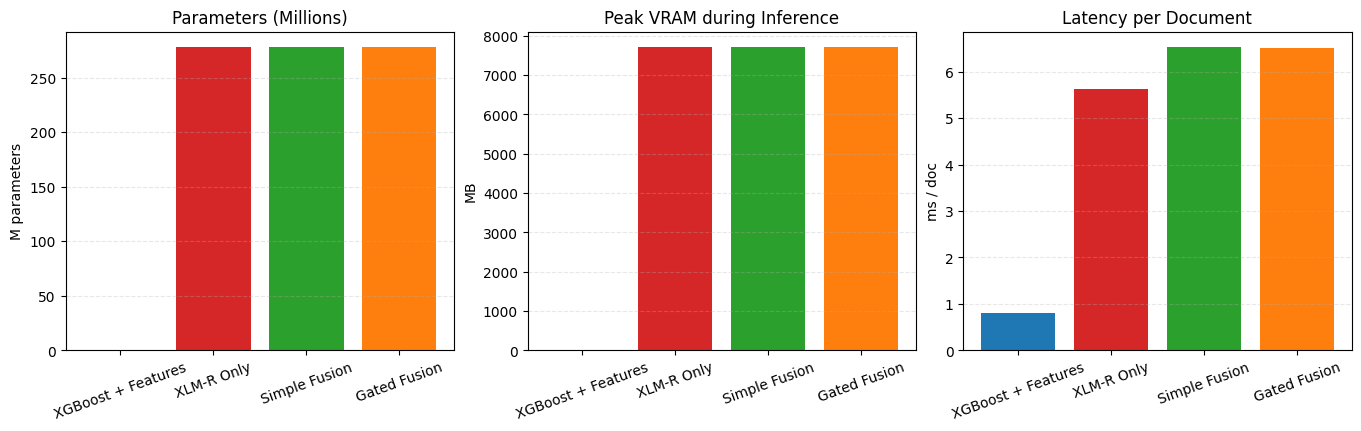

Saved: /content/drive/MyDrive/emc/adv_eval_outputs/figures_diagnostics/footprint_bars.png


In [18]:
# === Confusion Matrices (Clean vs Worst Group) + Resource/Latency Footprint ===
# Outputs:
#   adv_eval_outputs/figures_diagnostics/cm_<Model>_clean_vs_<Attack>.png  (600 dpi)
#   adv_eval_outputs/figures_diagnostics/cm_counts.csv
#   adv_eval_outputs/figures_diagnostics/footprint_bars.png  (600 dpi)
#   adv_eval_outputs/figures_diagnostics/footprint_table.csv
#
# Assumptions:
# - Clean results:  .../adv_eval_outputs/clean_eval.csv  (rows where Attack == "Clean")
# - Attack results: .../adv_eval_outputs/adversarial_eval*.csv (Model, Attack, macro_f1)
# - Perturbed data: .../adv_eval_outputs/perturbed/<Attack>.csv  (or fuzzy-matched)
# - Test set:       .../test.csv  (content, label[, id])

import os, re, glob, time, difflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ---------------- Paths & config ----------------
BASE_DIR   = "/content/drive/MyDrive/emc"
ADV_DIR    = os.path.join(BASE_DIR, "adv_eval_outputs")
PERT_DIR   = os.path.join(ADV_DIR, "perturbed")
FIG_DIR    = os.path.join(ADV_DIR, "figures_diagnostics")
os.makedirs(FIG_DIR, exist_ok=True)

CLEAN_EVAL = os.path.join(ADV_DIR, "clean_eval.csv")
ADV_GLOB   = os.path.join(ADV_DIR, "adversarial_eval*.csv")
TEST_CSV   = os.path.join(BASE_DIR, "test.csv")

XGB_DIR    = os.path.join(BASE_DIR, "xgb_outputs_clean")
XLMR_DIR   = os.path.join(BASE_DIR, "xlmr_only_outputs_clean")
SIMPLE_DIR = os.path.join(BASE_DIR, "simple_fusion_outputs_clean")
GATED_DIR  = os.path.join(BASE_DIR, "gated_fusion_outputs_clean")

TEXT_COL   = "content"
LABEL_COL  = "label"
LANG_COL   = "lang"
ID_COL     = "id"
MAX_LEN    = 256
BATCH_SIZE = 32
N_FEATS    = 12
DPI        = 600

MODELS = ["XLM-R Only", "XGBoost + Features", "Simple Fusion", "Gated Fusion"]
MODEL_COLORS = {
    "XGBoost + Features": "tab:blue",
    "XLM-R Only":         "tab:red",
    "Simple Fusion":      "tab:green",
    "Gated Fusion":       "tab:orange",
}

# Attack→Group mapping (extend as needed)
ATTACK_GROUPS = {
    "CharSwap":"Typos & Casing", "DropVowels":"Typos & Casing", "CaseToggle":"Typos & Casing",
    "PunctInsert":"Punct/Whitespace Noise", "WhitespaceNoise":"Punct/Whitespace Noise",
    "UnicodeConfuse":"Unicode & Symbols", "SymbolAscii":"Unicode & Symbols",
    "NumberPerturb":"Numbers", "Truncate80w":"Truncation",
    "MaskDomainTerms":"Domain Terms", "DropDomainTerms":"Domain Terms", "SynonymSwapDomain":"Domain Terms",
    "StandardNumCorrupt":"Standards Corruption",
    "UnitNeutralizeMask":"Units Neutralization", "UnitNeutralizeDrop":"Units Neutralization", "UnitNeutralizeGeneric":"Units Neutralization",
    "AcronymPerturb":"Acronyms & Citations", "CitationStrip":"Acronyms & Citations",
    "DomainCombo1":"Domain Combos", "DomainCombo2":"Domain Combos", "DomainCombo3":"Domain Combos", "DomainMax":"Domain Combos",
    "Numbers/Units":"Units Neutralization",
    "Unit Conversion (NEW)":"Units Neutralization",
}

def _norm(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"[\s\-\/]+", "_", s)
    s = re.sub(r"[^a-z0-9_]+", "", s)
    return s

# ---------------- Load results & pick worst attacks per model ----------------
def _read_csv(p):
    try: return pd.read_csv(p)
    except Exception as e:
        print(f"[skip] {os.path.basename(p)}: {e}"); return None

clean_eval = _read_csv(CLEAN_EVAL)
if clean_eval is None:
    raise FileNotFoundError("Missing clean_eval.csv")

clean_only = clean_eval[clean_eval["Attack"].astype(str).str.lower()=="clean"].copy()
clean_base = clean_only[["Model","macro_f1"]].rename(columns={"macro_f1":"Clean Macro F1"})

adv_frames = []
for p in sorted(glob.glob(ADV_GLOB)):
    if os.path.basename(p).lower() == "clean_eval.csv": continue
    df = _read_csv(p)
    if df is None: continue
    if not {"Model","Attack","macro_f1"}.issubset(df.columns): continue
    adv_frames.append(df[["Model","Attack","macro_f1"]])
if not adv_frames:
    raise RuntimeError("No adversarial_eval*.csv found")

adv_all = pd.concat(adv_frames, ignore_index=True)
adv_all["Group"] = adv_all["Attack"].map(ATTACK_GROUPS).fillna("Other")
adv_all = adv_all.merge(clean_base, on="Model", how="left")
adv_all["Delta"] = adv_all["Clean Macro F1"] - adv_all["macro_f1"]

# worst group per model = group with minimal macro_f1 (worst attack averaged is also ok; we choose min inside group)
worst_group = (
    adv_all.groupby(["Model","Group"])["macro_f1"]
    .min()
    .reset_index()
    .sort_values(["Model","macro_f1"])
    .groupby("Model")
    .first()
    .reset_index()
    .rename(columns={"macro_f1":"WorstGroupMacroF1"})
)
# pick worst single attack within that worst group for each model
worst_attacks = []
for _, row in worst_group.iterrows():
    m, g = row["Model"], row["Group"]
    sub = adv_all[(adv_all["Model"]==m) & (adv_all["Group"]==g)].copy()
    if sub.empty: continue
    worst = sub.sort_values("macro_f1").iloc[0]
    worst_attacks.append({"Model": m, "Group": g, "Attack": worst["Attack"], "AttackMacroF1": worst["macro_f1"]})
worst_attacks = pd.DataFrame(worst_attacks)
print("Worst group & attack per model:\n", worst_attacks.to_string(index=False))

# ---------------- Load test & helper to find perturbed CSV ----------------
test_df = _read_csv(TEST_CSV)
if test_df is None or TEXT_COL not in test_df.columns or LABEL_COL not in test_df.columns:
    raise FileNotFoundError("test.csv missing required columns")

def _find_attack_file(name: str):
    # exact variations first
    cands = [
        os.path.join(PERT_DIR, f"{name}.csv"),
        os.path.join(PERT_DIR, _norm(name) + ".csv"),
        os.path.join(PERT_DIR, name, "dataset.csv"),
        os.path.join(PERT_DIR, f"{name}_test.csv"),
    ]
    for p in cands:
        if os.path.exists(p): return p
    # fuzzy match
    pool = glob.glob(os.path.join(PERT_DIR, "**", "*.csv"), recursive=True)
    if not pool: return None
    stems = {p: os.path.splitext(os.path.basename(p))[0] for p in pool}
    names = list(stems.values())
    match = difflib.get_close_matches(name, names, n=1, cutoff=0.5)
    if match:
        for p, st in stems.items():
            if st == match[0]: return p
    # substring fallback
    for p, st in stems.items():
        if _norm(name) in _norm(st) or _norm(st) in _norm(name):
            return p
    return None

# ---------------- Feature extractor (12-D) for XGB/Simple/Gated ----------------
import re
_WORD_RE = re.compile(r"\w+", re.UNICODE)
_NUM_RE  = re.compile(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?')
STD_TERMS = {"iso","asme","ieee","din","ansi","iec","ul","astm","en"}
SAFETY_TERMS = {"safety","hazard","warning","risk","caution","danger","emergency"}
def simple_words(t: str): return _WORD_RE.findall(t or "")
def sent_count(t: str) -> int:
    if not t: return 0
    return max(1, len(re.split(r'[.!?]+[\s\n]+', t)))
def punct_count(t: str) -> int: return sum(1 for ch in (t or "") if ch in ".,;:!?")
def extract_numbers(text: str):
    nums, dec = [], 0
    for m in _NUM_RE.finditer(text or ""):
        s = m.group(0)
        try:
            v = float(s)
            if ('.' in s) or ('e' in s.lower()): dec += 1
            nums.append(abs(v))
        except: pass
    return nums, dec
def _finite_or_zero(x: float):
    try:
        xx = float(x);
        return xx if np.isfinite(xx) else 0.0
    except: return 0.0

class TermsLexicon:
    def __init__(self, csv_path: str, term_col="terms", lang_col="lang"):
        df = pd.read_csv(csv_path)
        if term_col not in df.columns: raise ValueError(f"Missing '{term_col}'")
        if lang_col not in df.columns: df[lang_col] = 'en'
        self.by_lang = {str(l).lower(): set(str(x).strip().lower() for x in d[term_col].dropna().tolist() if str(x).strip())
                        for l, d in df.groupby(lang_col)}
    def pct_in_text(self, text: str, lang: str) -> float:
        terms = self.by_lang.get((lang or "en").lower(), set())
        if not terms: return 0.0
        ws = [w.lower() for w in simple_words(text)]
        return sum(1 for w in ws if w in terms) / max(1, len(ws)) if ws else 0.0

TERMS_CSV = os.path.join(BASE_DIR, "engineering_terms.csv")
lex = TermsLexicon(TERMS_CSV)

class FeatureExtractor12:
    def __init__(self, tlex: TermsLexicon): self.tlex = tlex
    def extract_one(self, text: str, lang: str):
        text = "" if text is None else str(text); lang = (lang or "en").lower()
        ws = simple_words(text); n_words = len(ws)
        chars = len(text); words = n_words; sents = sent_count(text)
        fre, fog = 0.0, 0.0
        eng_pct = self.tlex.pct_in_text(text, lang)
        punc = punct_count(text)
        nums, dec_cnt = extract_numbers(text); nnums = len(nums)
        avg_mag = float(np.mean(nums)) if nums else 0.0
        dec_ratio = float(dec_cnt / max(1, len(nums)))
        low = text.lower()
        has_std = 1.0 if any(t in low for t in STD_TERMS) else 0.0
        has_saf = 1.0 if any(t in low for t in SAFETY_TERMS) else 0.0
        vals = [chars, words, sents, fre, fog, eng_pct, punc, nnums, has_std, has_saf, avg_mag, dec_ratio]
        arr = np.asarray([_finite_or_zero(v) for v in vals], dtype=np.float64)
        arr = np.nan_to_num(arr, nan=0.0, posinf=1e12, neginf=0.0)
        return np.clip(arr, -1e12, 1e12).astype(np.float32)
    def extract_df(self, df):
        local = df if LANG_COL in df.columns else df.assign(**{LANG_COL:'en'})
        rows = [self.extract_one(r.get(TEXT_COL,""), r.get(LANG_COL,"en")) for _, r in local.iterrows()]
        return np.stack(rows, axis=0).astype(np.float32)

fe = FeatureExtractor12(lex)

# ---------------- Tokenization & models ----------------
from transformers import XLMRobertaTokenizerFast, XLMRobertaModel, XLMRobertaForSequenceClassification, DataCollatorWithPadding
import joblib, xgboost as xgb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tok = XLMRobertaTokenizerFast.from_pretrained(XLMR_DIR)
collator = DataCollatorWithPadding(tok)

class TextOnlyDS(Dataset):
    def __init__(self, df, tokenizer, max_len=256):
        self.texts = df[TEXT_COL].astype(str).tolist()
        self.labels = df[LABEL_COL].astype(int).values
        self.tok = tokenizer; self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        enc = self.tok(self.texts[i], truncation=True, padding=False, max_length=self.max_len, return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(int(self.labels[i]), dtype=torch.long)
        return item

class TextFeatDS(Dataset):
    def __init__(self, df, tokenizer, feats_scaled, max_len=256):
        self.texts = df[TEXT_COL].astype(str).tolist()
        self.labels = df[LABEL_COL].astype(int).values
        self.tok = tokenizer; self.max_len = max_len
        self.feats = feats_scaled.astype(np.float32)
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        enc = self.tok(self.texts[i], truncation=True, padding="max_length", max_length=self.max_len, return_tensors="pt")
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(int(self.labels[i]), dtype=torch.long),
            "feats": torch.tensor(self.feats[i], dtype=torch.float32),
        }

class SimpleFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + n_feats, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        fused = torch.cat([pooled, feats], dim=1)
        return self.classifier(self.dropout(fused))

class GatedFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2, feat_proj: int = 64):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.fe_proj = nn.Sequential(nn.Linear(n_feats, feat_proj), nn.ReLU())
        self.gate    = nn.Sequential(nn.Linear(H + n_feats, 64), nn.ReLU(), nn.Linear(64, 1), nn.Sigmoid())
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + feat_proj, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        alpha = self.gate(torch.cat([pooled, feats], dim=1))
        ef    = self.fe_proj(feats)
        fused = torch.cat([pooled, alpha * ef], dim=1)
        return self.classifier(self.dropout(fused))

# Load artifacts
# XGB
xgb_model = xgb.XGBClassifier(); xgb_model.load_model(os.path.join(XGB_DIR, "xgb_model.json"))
xgb_scaler = joblib.load(os.path.join(XGB_DIR, "scaler12.pkl"))

# XLM-R
xlmr = XLMRobertaForSequenceClassification.from_pretrained(XLMR_DIR).to(device); xlmr.eval()

# Simple
simple_scaler = joblib.load(os.path.join(SIMPLE_DIR, "scaler12.pkl"))
simple = SimpleFusion("xlm-roberta-base", N_FEATS, 2).to(device)
simple.load_state_dict(torch.load(os.path.join(SIMPLE_DIR, "fusion_simple.pt"), map_location=device), strict=False); simple.eval()

# Gated
gated_scaler = joblib.load(os.path.join(GATED_DIR, "scaler12.pkl"))
gated = GatedFusion("xlm-roberta-base", N_FEATS, 2, feat_proj=64).to(device)
gated.load_state_dict(torch.load(os.path.join(GATED_DIR, "fusion_gated.pt"), map_location=device), strict=False); gated.eval()

# ---------------- Prediction helpers ----------------
@torch.no_grad()
def preds_xlmr(df):
    ds = TextOnlyDS(df, tok, MAX_LEN); dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collator)
    out = []
    for b in dl:
        inp = {k: v.to(device) for k, v in b.items() if k in ("input_ids","attention_mask")}
        out.append(xlmr(**inp).logits.argmax(dim=-1).cpu().numpy())
    return np.concatenate(out)

@torch.no_grad()
def preds_fusion(df, scaler, model):
    X = fe.extract_df(df); Xs = scaler.transform(X).astype(np.float32)
    ds = TextFeatDS(df, tok, Xs, MAX_LEN); dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collator)
    out = []
    for b in dl:
        ids = b["input_ids"].to(device); am = b["attention_mask"].to(device); ft = b["feats"].to(device)
        out.append(model(ids, am, ft).argmax(dim=-1).cpu().numpy())
    return np.concatenate(out)

def preds_xgb(df):
    X = fe.extract_df(df); Xs = xgb_scaler.transform(X); return xgb_model.predict(Xs)

# ---------------- Plot confusion matrices per model ----------------
def plot_cm(ax, y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    # normalize rows (per true class)
    with np.errstate(divide='ignore', invalid='ignore'):
        cm_norm = cm / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cm_norm, cmap="Blues", vmin=0.0, vmax=1.0)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, f"{cm[i,j]}\n({cm_norm[i,j]:.2f})",
                    ha="center", va="center", fontsize=9, color="black")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["Real (0)","Misinformation (1)"])
    ax.set_yticklabels(["Real (0)","Misinformation (1)"])
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_title(title)
    return cm

cm_records = []  # rows -> Model, Split, TN, FP, FN, TP, Attack

for _, row in worst_attacks.iterrows():
    model_name = row["Model"]; worst_attack = row["Attack"]; worst_group = row["Group"]
    # find perturbed file
    atk_path = _find_attack_file(worst_attack)
    if atk_path is None:
        print(f"[warn] Could not find perturbed CSV for attack '{worst_attack}'. Skipping CM plot for {model_name}.")
        continue
    df_attack = _read_csv(atk_path)
    if df_attack is None or TEXT_COL not in df_attack.columns or LABEL_COL not in df_attack.columns:
        print(f"[warn] Bad attack CSV for '{worst_attack}'. Skipping {model_name}.")
        continue

    # predictions
    y_true_clean = test_df[LABEL_COL].astype(int).values
    if model_name == "XLM-R Only":
        y_pred_clean = preds_xlmr(test_df)
        y_pred_attack = preds_xlmr(df_attack)
    elif model_name == "XGBoost + Features":
        y_pred_clean = preds_xgb(test_df)
        y_pred_attack = preds_xgb(df_attack)
    elif model_name == "Simple Fusion":
        y_pred_clean = preds_fusion(test_df, simple_scaler, simple)
        y_pred_attack = preds_fusion(df_attack, simple_scaler, simple)
    else:  # Gated Fusion
        y_pred_clean = preds_fusion(test_df, gated_scaler, gated)
        y_pred_attack = preds_fusion(df_attack, gated_scaler, gated)

    # plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), constrained_layout=True)
    cm_clean  = plot_cm(axes[0], y_true_clean, y_pred_clean, title=f"{model_name} — Clean")
    cm_attack = plot_cm(axes[1], df_attack[LABEL_COL].astype(int).values, y_pred_attack,
                        title=f"{model_name} — Worst: {worst_group}\n({worst_attack})")
    out_png = os.path.join(FIG_DIR, f"cm_{re.sub(r'[^A-Za-z0-9_.-]+','_',model_name)}_clean_vs_{_norm(worst_attack)}.png")
    plt.savefig(out_png, dpi=DPI)
    plt.show()
    print("Saved:", out_png)

    # store counts
    TN, FP, FN, TP = cm_clean[0,0], cm_clean[0,1], cm_clean[1,0], cm_clean[1,1]
    cm_records.append([model_name, "Clean", worst_group, worst_attack, TN, FP, FN, TP])
    TN, FP, FN, TP = cm_attack[0,0], cm_attack[0,1], cm_attack[1,0], cm_attack[1,1]
    cm_records.append([model_name, "Worst", worst_group, worst_attack, TN, FP, FN, TP])

# save CM counts
cm_df = pd.DataFrame(cm_records, columns=["Model","Split","Group","Attack","TN","FP","FN","TP"])
cm_csv = os.path.join(FIG_DIR, "cm_counts.csv")
cm_df.to_csv(cm_csv, index=False)
print("Saved:", cm_csv)

# ---------------- Resource / Latency Footprint ----------------
# Count parameters (DL); approximate XGB "params" via total tree nodes (booster.trees_to_dataframe)
def count_params_torch(model: nn.Module) -> int:
    return int(sum(p.numel() for p in model.parameters()))

def xgb_node_count(xgb_clf) -> int:
    try:
        df = xgb_clf.get_booster().trees_to_dataframe()
        return int(df.shape[0])  # nodes = rows
    except Exception:
        # fallback: unknown
        return np.nan

# Measure latency & VRAM (GPU) @ inference on clean test set
def measure_latency_and_vram(model_kind: str):
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

    start = time.perf_counter()
    peak_vram_mb = 0.0

    if model_kind == "XLM-R Only":
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()
        _ = preds_xlmr(test_df)  # runs full test set
        if torch.cuda.is_available():
            peak_vram_mb = torch.cuda.max_memory_allocated() / (1024**2)
        elapsed = time.perf_counter() - start
        ms_per_doc = 1000.0 * elapsed / max(1, len(test_df))

    elif model_kind == "Simple Fusion":
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()
        _ = preds_fusion(test_df, simple_scaler, simple)
        if torch.cuda.is_available():
            peak_vram_mb = torch.cuda.max_memory_allocated() / (1024**2)
        elapsed = time.perf_counter() - start
        ms_per_doc = 1000.0 * elapsed / max(1, len(test_df))

    elif model_kind == "Gated Fusion":
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()
        _ = preds_fusion(test_df, gated_scaler, gated)
        if torch.cuda.is_available():
            peak_vram_mb = torch.cuda.max_memory_allocated() / (1024**2)
        elapsed = time.perf_counter() - start
        ms_per_doc = 1000.0 * elapsed / max(1, len(test_df))

    else:  # XGB (CPU)
        start = time.perf_counter()
        _ = preds_xgb(test_df)
        elapsed = time.perf_counter() - start
        ms_per_doc = 1000.0 * elapsed / max(1, len(test_df))
        peak_vram_mb = 0.0  # GPU VRAM not used

    return ms_per_doc, peak_vram_mb

# Compute table
import xgboost as xgb
foot_rows = []

# XGB
xgb_params = xgb_node_count(xgb_model)
xgb_ms, xgb_vram = measure_latency_and_vram("XGBoost + Features")
foot_rows.append(["XGBoost + Features", xgb_params, xgb_vram, xgb_ms])

# XLM-R
xlmr_params = count_params_torch(xlmr)
xlmr_ms, xlmr_vram = measure_latency_and_vram("XLM-R Only")
foot_rows.append(["XLM-R Only", xlmr_params, xlmr_vram, xlmr_ms])

# Simple
simple_params = count_params_torch(simple)
simple_ms, simple_vram = measure_latency_and_vram("Simple Fusion")
foot_rows.append(["Simple Fusion", simple_params, simple_vram, simple_ms])

# Gated
gated_params = count_params_torch(gated)
gated_ms, gated_vram = measure_latency_and_vram("Gated Fusion")
foot_rows.append(["Gated Fusion", gated_params, gated_vram, gated_ms])

foot = pd.DataFrame(foot_rows, columns=["Model","Params","Peak VRAM (MB)","Latency (ms/doc)"])
# Convert Params to "M" for plotting readability
foot["Params (M)"] = foot["Params"] / 1_000_000.0
foot_csv = os.path.join(FIG_DIR, "footprint_table.csv")
foot.to_csv(foot_csv, index=False)
print("Saved:", foot_csv)
print(foot)

# Plot bars (three aligned subplots)
fig, axes = plt.subplots(1, 3, figsize=(13.5, 4.2), constrained_layout=True)
# Params
axes[0].bar(foot["Model"], foot["Params (M)"], color=[MODEL_COLORS.get(m, "tab:gray") for m in foot["Model"]])
axes[0].set_title("Parameters (Millions)"); axes[0].set_ylabel("M parameters")
axes[0].tick_params(axis='x', rotation=20)
# VRAM
axes[1].bar(foot["Model"], foot["Peak VRAM (MB)"], color=[MODEL_COLORS.get(m, "tab:gray") for m in foot["Model"]])
axes[1].set_title("Peak VRAM during Inference"); axes[1].set_ylabel("MB")
axes[1].tick_params(axis='x', rotation=20)
# Latency
axes[2].bar(foot["Model"], foot["Latency (ms/doc)"], color=[MODEL_COLORS.get(m, "tab:gray") for m in foot["Model"]])
axes[2].set_title("Latency per Document"); axes[2].set_ylabel("ms / doc")
axes[2].tick_params(axis='x', rotation=20)

for ax in axes:
    ax.grid(axis="y", linestyle="--", alpha=0.3)

out_png = os.path.join(FIG_DIR, "footprint_bars.png")
plt.savefig(out_png, dpi=DPI)
plt.show()
print("Saved:", out_png)


In [3]:
# --- Clean vs After-Attack Macro-F1 per model (aggregated over all attacks) ---

import os, glob, numpy as np, pandas as pd

BASE_DIR   = "/content/drive/MyDrive/emc"
ADV_DIR    = os.path.join(BASE_DIR, "adv_eval_outputs")
CLEAN_CSV  = os.path.join(ADV_DIR, "clean_eval.csv")
ADV_GLOB   = os.path.join(ADV_DIR, "adversarial_eval*.csv")
OUT_CSV    = os.path.join(ADV_DIR, "clean_vs_attack_macro_f1_summary.csv")

# Aggregation over all attacks: "mean" | "median" | "worst"
AGGREGATOR = "median"

def _read_csv(p):
    try:
        return pd.read_csv(p)
    except Exception as e:
        print(f"[skip] {os.path.basename(p)}: {e}")
        return None

# 1) Load clean Macro-F1 (Attack == Clean)
clean_df = _read_csv(CLEAN_CSV)
if clean_df is None:
    raise FileNotFoundError(f"Cannot find clean results at: {CLEAN_CSV}")

clean_only = clean_df[clean_df["Attack"].astype(str).str.lower() == "clean"].copy()
if clean_only.empty:
    raise RuntimeError("clean_eval.csv has no rows with Attack == 'Clean'.")

clean_only = clean_only[["Model", "macro_f1"]].rename(columns={"macro_f1": "Clean Macro F1"})

# 2) Load all adversarial evals
adv_frames = []
for p in sorted(glob.glob(ADV_GLOB)):
    if os.path.basename(p).lower() == "clean_eval.csv":
        continue
    dfp = _read_csv(p)
    if dfp is None:
        continue
    if not {"Model","Attack","macro_f1"}.issubset(dfp.columns):
        print(f"[warn] Missing required cols in {p}, skipping.")
        continue
    adv_frames.append(dfp[["Model","Attack","macro_f1"]])

if not adv_frames:
    raise RuntimeError("No adversarial_eval*.csv files found (or all unreadable).")

adv_all = pd.concat(adv_frames, ignore_index=True)
# Filter out any accidental 'Clean' rows that slipped into adversarial files
adv_all = adv_all[adv_all["Attack"].astype(str).str.lower() != "clean"].copy()

# 3) Aggregate per model across ALL attacks
if AGGREGATOR == "mean":
    agg = adv_all.groupby("Model", as_index=False)["macro_f1"].mean()
elif AGGREGATOR == "median":
    agg = adv_all.groupby("Model", as_index=False)["macro_f1"].median()
elif AGGREGATOR == "worst":
    agg = adv_all.groupby("Model", as_index=False)["macro_f1"].min()
else:
    raise ValueError("AGGREGATOR must be one of: 'mean', 'median', 'worst'.")

agg = agg.rename(columns={"macro_f1": "After-Attack Macro F1"})

# 4) Merge with clean and compute drops
summary = clean_only.merge(agg, on="Model", how="inner")
summary["Δ (Drop)"]  = summary["Clean Macro F1"] - summary["After-Attack Macro F1"]
summary["Δ%"]        = 100.0 * summary["Δ (Drop)"] / summary["Clean Macro F1"].replace(0.0, np.nan)

# 5) Sort (largest drop first for diagnostic readability)
summary = summary.sort_values("Δ (Drop)", ascending=False).reset_index(drop=True)

# 6) Round for display, but keep unrounded copy if you need
display_df = summary.copy()
for col in ["Clean Macro F1", "After-Attack Macro F1", "Δ (Drop)", "Δ%"]:
    display_df[col] = display_df[col].astype(float).round(4)

print(f"\n--- Clean vs After-Attack Macro-F1 (aggregator = {AGGREGATOR}) ---")
print(display_df.to_string(index=False))

# 7) Save CSV
summary.to_csv(OUT_CSV, index=False)
print("\nSaved (full precision):", OUT_CSV)



--- Clean vs After-Attack Macro-F1 (aggregator = median) ---
             Model  Clean Macro F1  After-Attack Macro F1  Δ (Drop)     Δ%
XGBoost + Features          0.9378                 0.9292    0.0086 0.9185
        XLM-R Only          0.9374                 0.9365    0.0009 0.0989
     Simple Fusion          0.9396                 0.9391    0.0005 0.0571
      Gated Fusion          0.9486                 0.9483    0.0003 0.0340

Saved (full precision): /content/drive/MyDrive/emc/adv_eval_outputs/clean_vs_attack_macro_f1_summary.csv


In [4]:
# --- Block 1: Config & Group definitions ---

import os, re, glob, difflib, json, numpy as np, pandas as pd
from dataclasses import dataclass

@dataclass
class CFG:
    BASE_DIR: str = "/content/drive/MyDrive/emc"
    TEST_CSV: str = "/content/drive/MyDrive/emc/test.csv"
    TERMS_CSV: str = "/content/drive/MyDrive/emc/engineering_terms.csv"

    # Model artifact dirs
    XGB_DIR: str    = "/content/drive/MyDrive/emc/xgb_outputs_clean"
    XLMR_DIR: str   = "/content/drive/MyDrive/emc/xlmr_only_outputs_clean"
    SIMPLE_DIR: str = "/content/drive/MyDrive/emc/simple_fusion_outputs_clean"
    GATED_DIR: str  = "/content/drive/MyDrive/emc/gated_fusion_outputs_clean"

    # Adversarial inputs & outputs
    ADV_DIR: str    = "/content/drive/MyDrive/emc/adv_eval_outputs"
    PERT_DIR: str   = "/content/drive/MyDrive/emc/adv_eval_outputs/perturbed"
    OUT_DIR: str    = "/content/drive/MyDrive/emc/adv_eval_outputs/grouped_eval"

    TEXT_COL: str = "content"
    LABEL_COL: str = "label"
    LANG_COL: str  = "lang"
    ID_COL: str    = "id"

    MAX_LEN: int = 256
    BATCH_SIZE: int = 32
    N_FEATS: int = 12
    POS_LABEL: int = 1   # 1 = Misinformation

    DPI: int = 600
    AGGREGATOR: str = "mean"    # "mean" | "median" | "worst"

cfg = CFG()
os.makedirs(cfg.OUT_DIR, exist_ok=True)

# ********** GROUPS (3 big buckets) **********
# Map each atomic attack (normalized name) to one of 3 groups.
def _norm(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"[\s\-\/]+", "_", s)    # space/hyphen/slash -> underscore
    s = re.sub(r"[^a-z0-9_]+", "", s)   # drop other non-alnum
    return s

GROUP_MAP = {
    # Structural
    _norm("CharSwap"): "Structural",
    _norm("CaseToggle"): "Structural",
    _norm("PunctInsert"): "Structural",
    _norm("WhitespaceNoise"): "Structural",
    _norm("UnicodeConfuse"): "Structural",
    _norm("SymbolAscii"): "Structural",
    _norm("Truncate80w"): "Structural",

    # Semantic/Cue
    _norm("MaskDomainTerms"): "Semantic/Cue",
    _norm("DropDomainTerms"): "Semantic/Cue",
    _norm("SynonymSwapDomain"): "Semantic/Cue",
    _norm("AcronymPerturb"): "Semantic/Cue",
    _norm("CitationStrip"): "Semantic/Cue",

    # Feature-Targeted
    _norm("NumberPerturb"): "Feature-Targeted",
    _norm("StandardNumCorrupt"): "Feature-Targeted",
    _norm("UnitNeutralizeMask"): "Feature-Targeted",
    _norm("UnitNeutralizeDrop"): "Feature-Targeted",
    _norm("UnitNeutralizeGeneric"): "Feature-Targeted",

    # Aliases seen in your runs
    _norm("Numbers/Units"): "Feature-Targeted",
    _norm("Unit Conversion (NEW)"): "Feature-Targeted",
    _norm("DomainCombo1"): "Semantic/Cue",
    _norm("DomainCombo2"): "Semantic/Cue",
    _norm("DomainCombo3"): "Semantic/Cue",
    _norm("DomainMax"):   "Semantic/Cue",
}

MODELS = ["XLM-R Only", "XGBoost + Features", "Simple Fusion", "Gated Fusion"]
MODEL_COLORS = {
    "XGBoost + Features": "tab:blue",
    "XLM-R Only":         "tab:red",
    "Simple Fusion":      "tab:green",
    "Gated Fusion":       "tab:orange",
}


In [5]:
# --- Block 2: Utilities, features, loaders, heads ---

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    XLMRobertaTokenizerFast, XLMRobertaForSequenceClassification,
    XLMRobertaModel, DataCollatorWithPadding
)
import joblib, xgboost as xgb
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Feature extractor (12-D) ----------
import re
_WORD_RE = re.compile(r"\w+", re.UNICODE)
_NUM_RE  = re.compile(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?')
STD_TERMS = {"iso","asme","ieee","din","ansi","iec","ul","astm","en"}
SAFETY_TERMS = {"safety","hazard","warning","risk","caution","danger","emergency"}

def simple_words(t: str): return _WORD_RE.findall(t or "")
def sent_count(t: str) -> int:
    if not t: return 0
    return max(1, len(re.split(r'[.!?]+[\s\n]+', t)))
def punct_count(t: str) -> int: return sum(1 for ch in (t or "") if ch in ".,;:!?")
def extract_numbers(text: str):
    nums, dec = [], 0
    for m in _NUM_RE.finditer(text or ""):
        s = m.group(0)
        try:
            v = float(s)
            if ('.' in s) or ('e' in s.lower()): dec += 1
            nums.append(abs(v))
        except: pass
    return nums, dec
def _finite_or_zero(x: float):
    try:
        xx = float(x)
        return xx if np.isfinite(xx) else 0.0
    except: return 0.0

class TermsLexicon:
    def __init__(self, csv_path: str, term_col="terms", lang_col="lang"):
        df = pd.read_csv(csv_path)
        if term_col not in df.columns: raise ValueError(f"Missing '{term_col}'")
        if lang_col not in df.columns: df[lang_col] = 'en'
        self.by_lang = {str(l).lower(): set(str(x).strip().lower()
                         for x in d[term_col].dropna().tolist() if str(x).strip())
                        for l, d in df.groupby(lang_col)}
    def pct_in_text(self, text: str, lang: str) -> float:
        terms = self.by_lang.get((lang or "en").lower(), set())
        if not terms: return 0.0
        ws = [w.lower() for w in simple_words(text)]
        return sum(1 for w in ws if w in terms) / max(1, len(ws)) if ws else 0.0

class FeatureExtractor12:
    def __init__(self, tlex: TermsLexicon): self.tlex = tlex
    def extract_one(self, text: str, lang: str):
        text = "" if text is None else str(text); lang = (lang or "en").lower()
        ws = simple_words(text); n_words = len(ws)
        chars = len(text); words = n_words; sents = sent_count(text)
        fre, fog = 0.0, 0.0
        eng_pct = self.tlex.pct_in_text(text, lang)
        punc = punct_count(text)
        nums, dec_cnt = extract_numbers(text); nnums = len(nums)
        avg_mag = float(np.mean(nums)) if nums else 0.0
        dec_ratio = float(dec_cnt / max(1, len(nums)))
        low = text.lower()
        has_std = 1.0 if any(t in low for t in STD_TERMS) else 0.0
        has_saf = 1.0 if any(t in low for t in SAFETY_TERMS) else 0.0
        vals = [chars, words, sents, fre, fog, eng_pct, punc, nnums, has_std, has_saf, avg_mag, dec_ratio]
        arr = np.asarray([_finite_or_zero(v) for v in vals], dtype=np.float64)
        arr = np.nan_to_num(arr, nan=0.0, posinf=1e12, neginf=0.0)
        return np.clip(arr, -1e12, 1e12).astype(np.float32)
    def extract_df(self, df):
        local = df if cfg.LANG_COL in df.columns else df.assign(**{cfg.LANG_COL:'en'})
        rows = [self.extract_one(r.get(cfg.TEXT_COL,""), r.get(cfg.LANG_COL,"en")) for _, r in local.iterrows()]
        return np.stack(rows, axis=0).astype(np.float32)

lex = TermsLexicon(cfg.TERMS_CSV)
fe  = FeatureExtractor12(lex)

# ---------- Datasets ----------
class TextOnlyDS(Dataset):
    def __init__(self, df, tokenizer, max_len=256):
        self.texts = df[cfg.TEXT_COL].astype(str).tolist()
        self.labels = df[cfg.LABEL_COL].astype(int).values
        self.tok = tokenizer; self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        enc = self.tok(self.texts[i], truncation=True, padding=False,
                       max_length=self.max_len, return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(int(self.labels[i]), dtype=torch.long)
        return item

class TextFeatDS(Dataset):
    def __init__(self, df, tokenizer, feats_scaled, max_len=256):
        self.texts = df[cfg.TEXT_COL].astype(str).tolist()
        self.labels = df[cfg.LABEL_COL].astype(int).values
        self.tok = tokenizer; self.max_len = max_len
        self.feats = feats_scaled.astype(np.float32)
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        enc = self.tok(self.texts[i], truncation=True, padding="max_length",
                       max_length=self.max_len, return_tensors="pt")
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(int(self.labels[i]), dtype=torch.long),
            "feats": torch.tensor(self.feats[i], dtype=torch.float32),
        }

# ---------- Fusion heads ----------
class SimpleFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + n_feats, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        fused = torch.cat([pooled, feats], dim=1)
        return self.classifier(self.dropout(fused))

class GatedFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2, feat_proj: int = 64):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.fe_proj = nn.Sequential(nn.Linear(n_feats, feat_proj), nn.ReLU())
        self.gate    = nn.Sequential(nn.Linear(H + n_feats, 64), nn.ReLU(), nn.Linear(64, 1), nn.Sigmoid())
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + feat_proj, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        alpha = self.gate(torch.cat([pooled, feats], dim=1))
        ef    = self.fe_proj(feats)
        fused = torch.cat([pooled, alpha * ef], dim=1)
        return self.classifier(self.dropout(fused))

# ---------- Load artifacts ----------
tok = XLMRobertaTokenizerFast.from_pretrained(cfg.XLMR_DIR)
collator = DataCollatorWithPadding(tok)

# XGB
xgb_model = xgb.XGBClassifier()
xgb_model.load_model(os.path.join(cfg.XGB_DIR, "xgb_model.json"))
xgb_scaler = joblib.load(os.path.join(cfg.XGB_DIR, "scaler12.pkl"))

# XLM-R
xlmr = XLMRobertaForSequenceClassification.from_pretrained(cfg.XLMR_DIR).to(device)
xlmr.eval()

# Simple Fusion
simple = SimpleFusion("xlm-roberta-base", cfg.N_FEATS, 2).to(device)
simple.load_state_dict(torch.load(os.path.join(cfg.SIMPLE_DIR, "fusion_simple.pt"), map_location=device), strict=False)
simple.eval()
simple_scaler = joblib.load(os.path.join(cfg.SIMPLE_DIR, "scaler12.pkl"))

# Gated Fusion
gated = GatedFusion("xlm-roberta-base", cfg.N_FEATS, 2, feat_proj=64).to(device)
gated.load_state_dict(torch.load(os.path.join(cfg.GATED_DIR, "fusion_gated.pt"), map_location=device), strict=False)
gated.eval()
gated_scaler = joblib.load(os.path.join(cfg.GATED_DIR, "scaler12.pkl"))

# ---------- Metrics helpers ----------
@torch.no_grad()
def eval_xlmr(df):
    ds = TextOnlyDS(df, tok, cfg.MAX_LEN)
    dl = DataLoader(ds, batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=collator)
    probs = []
    for b in dl:
        inp = {k: v.to(device) for k, v in b.items() if k in ("input_ids","attention_mask")}
        logits = xlmr(**inp).logits
        pr = torch.softmax(logits, dim=-1)[:, cfg.POS_LABEL].cpu().numpy()
        probs.append(pr)
    y_prob = np.concatenate(probs)
    y_pred = (y_prob >= 0.5).astype(int)
    y_true = df[cfg.LABEL_COL].astype(int).values
    return y_true, y_pred, y_prob

def eval_xgb(df):
    X = fe.extract_df(df); Xs = xgb_scaler.transform(X)
    y_prob = xgb_model.predict_proba(Xs)[:, cfg.POS_LABEL]
    y_pred = (y_prob >= 0.5).astype(int)
    y_true = df[cfg.LABEL_COL].astype(int).values
    return y_true, y_pred, y_prob

@torch.no_grad()
def eval_fusion(df, scaler, model):
    X = fe.extract_df(df); Xs = scaler.transform(X).astype(np.float32)
    ds = TextFeatDS(df, tok, Xs, cfg.MAX_LEN)
    dl = DataLoader(ds, batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=collator)
    probs = []
    for b in dl:
        ids = b["input_ids"].to(device); am = b["attention_mask"].to(device); ft = b["feats"].to(device)
        logits = model(ids, am, ft)
        pr = torch.softmax(logits, dim=-1)[:, cfg.POS_LABEL].cpu().numpy()
        probs.append(pr)
    y_prob = np.concatenate(probs)
    y_pred = (y_prob >= 0.5).astype(int)
    y_true = df[cfg.LABEL_COL].astype(int).values
    return y_true, y_pred, y_prob

def metrics_from(y_true, y_pred, y_prob):
    out = {}
    out["macro_f1"] = f1_score(y_true, y_pred, average="macro")
    out["micro_f1"] = f1_score(y_true, y_pred, average="micro")
    out["weighted_f1"] = f1_score(y_true, y_pred, average="weighted")
    # Safe AUC/AP (guard degenerate)
    try: out["auc_roc"] = roc_auc_score(y_true, y_prob)
    except: out["auc_roc"] = np.nan
    try: out["ap"] = average_precision_score(y_true, y_prob)
    except: out["ap"] = np.nan
    # FPR at 95% TPR
    try:
        fpr, tpr, thr = roc_curve(y_true, y_prob)
        target = 0.95
        mask = tpr >= target
        out["fpr_at_95tpr"] = float(np.min(fpr[mask])) if np.any(mask) else np.nan
    except:
        out["fpr_at_95tpr"] = np.nan
    return out


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [6]:
# --- Block 3: Evaluate clean baseline for all models ---

test_df = pd.read_csv(cfg.TEST_CSV)
assert cfg.TEXT_COL in test_df.columns and cfg.LABEL_COL in test_df.columns, "Missing content/label columns."

rows = []
for model_name in MODELS:
    if model_name == "XLM-R Only":
        y_true, y_pred, y_prob = eval_xlmr(test_df)
    elif model_name == "XGBoost + Features":
        y_true, y_pred, y_prob = eval_xgb(test_df)
    elif model_name == "Simple Fusion":
        y_true, y_pred, y_prob = eval_fusion(test_df, simple_scaler, simple)
    else:
        y_true, y_pred, y_prob = eval_fusion(test_df, gated_scaler, gated)

    m = metrics_from(y_true, y_pred, y_prob)
    rows.append({"Model": model_name, "Attack": "Clean", **m})

clean_df = pd.DataFrame(rows)
clean_path = os.path.join(cfg.OUT_DIR, "clean_eval_grouped.csv")
clean_df.to_csv(clean_path, index=False)
print("Saved:", clean_path)
clean_df


Saved: /content/drive/MyDrive/emc/adv_eval_outputs/grouped_eval/clean_eval_grouped.csv


,Model,Attack,macro_f1,micro_f1,weighted_f1,auc_roc,ap,fpr_at_95tpr
0,XLM-R Only,Clean,0.937385,0.950646,0.949462,0.992875,0.984596,0.056810
1,XGBoost + Features,Clean,0.917845,0.934625,0.933407,0.980312,0.958445,0.112527
2,Simple Fusion,Clean,0.938978,0.947287,0.948416,0.993382,0.984882,0.052804
3,Gated Fusion,Clean,0.952998,0.960982,0.961117,0.994053,0.987798,0.036417


In [7]:
# --- Block 4: Per-attack eval -> Group aggregation ---

# Find a perturbed CSV for an attack name (fuzzy)
def find_attack_csv(attack_name: str):
    # try exact and normalized variants
    cands = [
        os.path.join(cfg.PERT_DIR, f"{attack_name}.csv"),
        os.path.join(cfg.PERT_DIR, f"{_norm(attack_name)}.csv"),
        os.path.join(cfg.PERT_DIR, attack_name, "dataset.csv"),
        os.path.join(cfg.PERT_DIR, f"{attack_name}_test.csv"),
    ]
    for p in cands:
        if os.path.exists(p): return p
    # fuzzy: scan all CSVs once
    pool = glob.glob(os.path.join(cfg.PERT_DIR, "**", "*.csv"), recursive=True)
    if not pool: return None
    stems = {p: os.path.splitext(os.path.basename(p))[0] for p in pool}
    names = list(stems.values())
    match = difflib.get_close_matches(attack_name, names, n=1, cutoff=0.55)
    if match:
        for p, st in stems.items():
            if st == match[0]: return p
    # substring fallback
    for p, st in stems.items():
        if _norm(attack_name) in _norm(st) or _norm(st) in _norm(attack_name):
            return p
    return None

# Collect ALL candidate attacks from the mapping (keys) that we can find on disk
attack_norms = sorted(set(GROUP_MAP.keys()))
attack_rows = []

for a_norm in attack_norms:
    csv_path = find_attack_csv(a_norm)
    if not csv_path:
        print(f"[skip] No file for attack: {a_norm}")
        continue

    atk_df = pd.read_csv(csv_path)
    if cfg.TEXT_COL not in atk_df.columns or cfg.LABEL_COL not in atk_df.columns:
        print(f"[skip] Missing columns in {os.path.basename(csv_path)}")
        continue

    group = GROUP_MAP.get(a_norm, "Unassigned")
    # evaluate each model
    for model_name in MODELS:
        if model_name == "XLM-R Only":
            y_true, y_pred, y_prob = eval_xlmr(atk_df)
        elif model_name == "XGBoost + Features":
            y_true, y_pred, y_prob = eval_xgb(atk_df)
        elif model_name == "Simple Fusion":
            y_true, y_pred, y_prob = eval_fusion(atk_df, simple_scaler, simple)
        else:
            y_true, y_pred, y_prob = eval_fusion(atk_df, gated_scaler, gated)

        m = metrics_from(y_true, y_pred, y_prob)
        attack_rows.append({
            "Model": model_name,
            "Attack": a_norm,
            "Group": group,
            **m
        })

atk_eval = pd.DataFrame(attack_rows)
raw_path = os.path.join(cfg.OUT_DIR, "per_attack_eval_raw.csv")
atk_eval.to_csv(raw_path, index=False)
print("Saved:", raw_path)
atk_eval.head()


[skip] No file for attack: acronymperturb
[skip] No file for attack: casetoggle
[skip] No file for attack: charswap
[skip] No file for attack: citationstrip
[skip] No file for attack: domaincombo1
[skip] No file for attack: domaincombo2
[skip] No file for attack: domaincombo3
[skip] No file for attack: domainmax
[skip] No file for attack: dropdomainterms
[skip] No file for attack: maskdomainterms
[skip] No file for attack: numberperturb
[skip] No file for attack: numbers_units
[skip] No file for attack: punctinsert
[skip] No file for attack: standardnumcorrupt
[skip] No file for attack: symbolascii
[skip] No file for attack: synonymswapdomain
[skip] No file for attack: truncate80w
[skip] No file for attack: unicodeconfuse
[skip] No file for attack: unit_conversion_new
[skip] No file for attack: unitneutralizedrop
[skip] No file for attack: unitneutralizegeneric
[skip] No file for attack: unitneutralizemask
[skip] No file for attack: whitespacenoise
Saved: /content/drive/MyDrive/emc/adv

""


# NEW-DEBUGGING ATTACKS

In [1]:
# --- Block GA-1: Generate perturbed datasets + coverage summary ---

import os, re, glob, random, difflib
import numpy as np
import pandas as pd

# ---------------- Config ----------------
BASE_DIR   = "/content/drive/MyDrive/emc"
TEST_CSV   = os.path.join(BASE_DIR, "test.csv")
TERMS_CSV  = os.path.join(BASE_DIR, "engineering_terms.csv")

ADV_DIR    = os.path.join(BASE_DIR, "adv_eval_outputs")
PERT_DIR   = os.path.join(ADV_DIR, "perturbed")
os.makedirs(PERT_DIR, exist_ok=True)

TEXT_COL   = "content"
LABEL_COL  = "label"
LANG_COL   = "lang"
ID_COL     = "id"

SEED       = 1337
rng        = np.random.default_rng(SEED)
random.seed(SEED)

def _norm(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"[\s\-\/]+", "_", s)
    s = re.sub(r"[^a-z0-9_]+", "", s)
    return s

# ---------------- Domain resources ----------------
# minimal lexicon for domain terms (read from engineering_terms.csv if present)
try:
    terms_df = pd.read_csv(TERMS_CSV)
    if "terms" in terms_df.columns:
        DOMAIN_TERMS = {str(t).strip().lower() for t in terms_df["terms"].dropna().tolist() if str(t).strip()}
    else:
        DOMAIN_TERMS = set()
except Exception:
    DOMAIN_TERMS = set()

SAFETY_TERMS = {"safety","hazard","warning","risk","caution","danger","emergency"}
STD_ACRO = {"iso","iec","ieee","ansi","asme","astm","din","en","ul"}  # for acronym perturb + standards corruption
ALL_DOMAIN = DOMAIN_TERMS | SAFETY_TERMS | STD_ACRO

# Basic synonyms (no WordNet dependency)
SYNONYMS = {
    "safety":"protection","hazard":"danger","warning":"alert","risk":"threat",
    "standard":"norm","standards":"norms","requirement":"specification",
    "failure":"fault","error":"mistake","probability":"likelihood",
    "temperature":"heat","pressure":"force","voltage":"electric potential",
    "speed":"rate","flow":"throughput"
}

# Units inventory (short list)
UNITS = [
    "m","km","cm","mm","µm","um","nm",
    "kg","g","mg","µg","ug",
    "s","ms","µs","us",
    "A","V","W","J","N","Pa","bar",
    "°C","C","K",
    "Hz","kHz","MHz","GHz",
    "rpm","%",
]

# Unicode confusables (small, safe subset)
CONFUSE = {
    "a":"а",  # cyrillic a
    "e":"ｅ",  # fullwidth e
    "o":"о",  # cyrillic o
    "c":"с",  # cyrillic c
    "p":"р",  # cyrillic p
    "x":"×",  # multiply sign
    "i":"і",  # ukrainian i
    "y":"у",  # cyrillic u
    "H":"Н",  # cyrillic en
}
SYMBOL_ASCII = {
    "±":"+/-", "µ":"u", "μ":"u", "×":"x", "·":".", "−":"-", "–":"-", "—":"-",
    "°":"deg", "Ω":"Ohm", "λ":"lambda"
}

# ---------------- Atomic attacks ----------------
def char_swap(text, p=0.02):
    cs = list(text)
    i = 0
    while i < len(cs)-1:
        if cs[i].isalpha() and cs[i+1].isalpha() and rng.random() < p:
            cs[i], cs[i+1] = cs[i+1], cs[i]
            i += 2
        else:
            i += 1
    return "".join(cs)

def case_toggle(text, p=0.05):
    out = []
    for ch in text:
        if ch.isalpha() and rng.random() < p:
            out.append(ch.lower() if ch.isupper() else ch.upper())
        else:
            out.append(ch)
    return "".join(out)

def punct_insert(text, p=0.02):
    punct = [",",".",":",";","!","?","-","/"]
    out = []
    for ch in text:
        if ch.isspace() and rng.random() < p:
            out.append(random.choice(punct))
            out.append(" ")
        out.append(ch)
    return "".join(out)

def whitespace_noise(text, p=0.03):
    out = []
    for ch in text:
        if ch == " " and rng.random() < p:
            out.append("  ")  # double space
            if rng.random() < 0.2:
                out.append("\n")
        else:
            out.append(ch)
    return "".join(out)

def unicode_confuse(text, p=0.03):
    out = []
    for ch in text:
        low = ch
        key = ch
        # try lowercase first
        repl = None
        if ch in CONFUSE: repl = CONFUSE[ch]
        elif ch.lower() in CONFUSE and rng.random() < p:
            repl = CONFUSE[ch.lower()]
            if ch.isupper():
                repl = repl.upper()
        if repl and rng.random() < p:
            out.append(repl)
        else:
            out.append(ch)
    return "".join(out)

def symbol_ascii(text):
    return "".join(SYMBOL_ASCII.get(ch, ch) for ch in text)

def truncate_80w(text, n=80):
    words = text.split()
    return " ".join(words[:n])

_num_re = re.compile(r'(?P<num>[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)')
def number_perturb(text, low=0.95, high=1.05):
    def repl(m):
        try:
            v = float(m.group("num"))
            factor = rng.uniform(low, high)
            return f"{v*factor:.4g}"
        except Exception:
            return m.group(0)
    return _num_re.sub(repl, text)

def mask_domain_terms(text):
    ws = re.findall(r"\w+|\W+", text, flags=re.UNICODE)
    out = []
    for tok in ws:
        if tok.isalnum() and tok.lower() in ALL_DOMAIN:
            out.append("[TERM]")
        else:
            out.append(tok)
    return "".join(out)

def drop_domain_terms(text):
    ws = re.findall(r"\w+|\W+", text, flags=re.UNICODE)
    out = []
    for tok in ws:
        if tok.isalnum() and tok.lower() in ALL_DOMAIN:
            continue
        out.append(tok)
    return "".join(out)

def synonym_swap_domain(text):
    ws = re.findall(r"\w+|\W+", text, flags=re.UNICODE)
    out = []
    for tok in ws:
        if tok.isalnum():
            low = tok.lower()
            if low in SYNONYMS:
                repl = SYNONYMS[low]
                if tok[0].isupper(): repl = repl.capitalize()
                out.append(repl)
                continue
        out.append(tok)
    return "".join(out)

# Standards corruption: keep prefix, fuzz numeric tail
_std_pat = re.compile(r'\b(?P<pfx>(?:ISO|IEC|EN|ASTM|ANSI|IEEE|ASME))\s*[-:]?\s*(?P<num>\d[\d\-:\/]*)', re.IGNORECASE)
def standard_num_corrupt(text):
    def repl(m):
        pfx = m.group("pfx")
        num = m.group("num")
        if not num: return m.group(0)
        # replace digits with '…' (or 'X') but keep separators
        obf = re.sub(r'\d', '…', num)
        return f"{pfx} {obf}"
    return _std_pat.sub(repl, text)

# Unit neutralization
_units_alt = sorted(UNITS, key=len, reverse=True)
_units_re = re.compile(r'\b(' + "|".join(re.escape(u) for u in _units_alt) + r')\b')

def unit_mask(text):
    return _units_re.sub("[UNIT]", text)

def unit_drop(text):
    return _units_re.sub("", text)

def unit_generic(text):
    return _units_re.sub("unit", text)

# Acronym perturbation
def acronym_perturb(text):
    def repl(m):
        acr = m.group(0)
        low = acr.lower()
        if rng.random() < 0.5:
            return ".".join(list(acr)) + "."
        else:
            return acr.title()
    acr_re = re.compile(r'\b(?:ISO|IEC|EN|ASTM|ANSI|IEEE|ASME|UL)\b', re.IGNORECASE)
    return acr_re.sub(repl, text)

# Citation strip ([12], (Smith, 2020))
def citation_strip(text):
    t = re.sub(r'\[[^\]]{1,40}\]', ' ', text)  # [ ... ]
    t = re.sub(r'\((?:[^()]+,\s*\d{4}[a-z]?)\)', ' ', t)  # (Author, 2020)
    return t

# ---------------- Compose (domain combos) ----------------
def domain_combo1(x):  # mask domain + mask units
    return unit_mask(mask_domain_terms(x))
def domain_combo2(x):  # drop domain + standards + generic units
    return unit_generic(standard_num_corrupt(drop_domain_terms(x)))
def domain_combo3(x):  # synonyms + numbers + acronyms
    return acronym_perturb(number_perturb(synonym_swap_domain(x)))
def domain_max(x):     # heavy chain
    return unit_generic(standard_num_corrupt(acronym_perturb(
           number_perturb(synonym_swap_domain(mask_domain_terms(x))))))

# ---------------- Attack registry (name -> function) ----------------
ATTACKS = {
    "CharSwap":              char_swap,
    "CaseToggle":            case_toggle,
    "PunctInsert":           punct_insert,
    "WhitespaceNoise":       whitespace_noise,
    "UnicodeConfuse":        unicode_confuse,
    "SymbolAscii":           symbol_ascii,
    "Truncate80w":           truncate_80w,

    "NumberPerturb":         number_perturb,
    "MaskDomainTerms":       mask_domain_terms,
    "DropDomainTerms":       drop_domain_terms,
    "SynonymSwapDomain":     synonym_swap_domain,
    "StandardNumCorrupt":    standard_num_corrupt,
    "UnitNeutralizeMask":    unit_mask,
    "UnitNeutralizeDrop":    unit_drop,
    "UnitNeutralizeGeneric": unit_generic,
    "AcronymPerturb":        acronym_perturb,
    "CitationStrip":         citation_strip,

    # Composites
    "DomainCombo1":          domain_combo1,
    "DomainCombo2":          domain_combo2,
    "DomainCombo3":          domain_combo3,
    "DomainMax":             domain_max,
}

# ---------------- Run all attacks on test set ----------------
test_df = pd.read_csv(TEST_CSV)
assert TEXT_COL in test_df.columns and LABEL_COL in test_df.columns, "test.csv must have content + label"

coverage_rows = []
for name, fn in ATTACKS.items():
    atk = []
    changed = 0
    for txt in test_df[TEXT_COL].astype(str).tolist():
        adv = fn(txt)
        atk.append(adv)
        if adv != txt:
            changed += 1
    df_out = test_df.copy()
    df_out[TEXT_COL] = atk
    out_name = _norm(name) + ".csv"
    out_path = os.path.join(PERT_DIR, out_name)
    df_out.to_csv(out_path, index=False)
    cov = 100.0 * changed / max(1, len(test_df))
    coverage_rows.append({"Attack": name, "Attack_norm": _norm(name), "coverage_pct": cov, "rows": len(test_df)})
    print(f"Saved {name} -> {out_path} | coverage={cov:.1f}%")

cov_df = pd.DataFrame(coverage_rows)
cov_path = os.path.join(ADV_DIR, "coverage_summary.csv")
cov_df.to_csv(cov_path, index=False)
print("\nCoverage summary:", cov_path)
cov_df


Saved CharSwap -> /content/drive/MyDrive/emc/adv_eval_outputs/perturbed/charswap.csv | coverage=98.1%
Saved CaseToggle -> /content/drive/MyDrive/emc/adv_eval_outputs/perturbed/casetoggle.csv | coverage=99.6%
Saved PunctInsert -> /content/drive/MyDrive/emc/adv_eval_outputs/perturbed/punctinsert.csv | coverage=89.6%
Saved WhitespaceNoise -> /content/drive/MyDrive/emc/adv_eval_outputs/perturbed/whitespacenoise.csv | coverage=93.2%
Saved UnicodeConfuse -> /content/drive/MyDrive/emc/adv_eval_outputs/perturbed/unicodeconfuse.csv | coverage=97.5%
Saved SymbolAscii -> /content/drive/MyDrive/emc/adv_eval_outputs/perturbed/symbolascii.csv | coverage=37.5%
Saved Truncate80w -> /content/drive/MyDrive/emc/adv_eval_outputs/perturbed/truncate80w.csv | coverage=82.5%
Saved NumberPerturb -> /content/drive/MyDrive/emc/adv_eval_outputs/perturbed/numberperturb.csv | coverage=85.1%
Saved MaskDomainTerms -> /content/drive/MyDrive/emc/adv_eval_outputs/perturbed/maskdomainterms.csv | coverage=99.9%
Saved Drop

,Attack,Attack_norm,coverage_pct,rows
0,CharSwap,charswap,98.087855,3870
1,CaseToggle,casetoggle,99.638243,3870
2,PunctInsert,punctinsert,89.638243,3870
3,WhitespaceNoise,whitespacenoise,93.178295,3870
4,UnicodeConfuse,unicodeconfuse,97.493540,3870
5,SymbolAscii,symbolascii,37.467700,3870
6,Truncate80w,truncate80w,82.532300,3870
7,NumberPerturb,numberperturb,85.142119,3870
8,MaskDomainTerms,maskdomainterms,99.922481,3870
9,DropDomainTerms,dropdomainterms,99.922481,3870


Saved: /content/drive/MyDrive/emc/adv_eval_outputs/grouped_eval/per_attack_eval_raw.csv
Wrote tables:
  /content/drive/MyDrive/emc/adv_eval_outputs/grouped_eval/grouped_macro_f1_median.csv
  /content/drive/MyDrive/emc/adv_eval_outputs/grouped_eval/grouped_macro_f1_median.md
  /content/drive/MyDrive/emc/adv_eval_outputs/grouped_eval/grouped_macro_f1_median.tex

Grouped table (rounded):
             Model            Group  Group Macro F1  Clean Macro F1      Δ      Δ%
      Gated Fusion       Structural          0.9530          0.9530 0.0000  0.0000
      Gated Fusion     Semantic/Cue          0.9410          0.9530 0.0120  1.2600
      Gated Fusion Feature-Targeted          0.9530          0.9530 0.0000  0.0000
     Simple Fusion       Structural          0.9390          0.9390 0.0000  0.0000
     Simple Fusion     Semantic/Cue          0.9332          0.9390 0.0058  0.6128
     Simple Fusion Feature-Targeted          0.9390          0.9390 0.0000  0.0000
XGBoost + Features       Struct

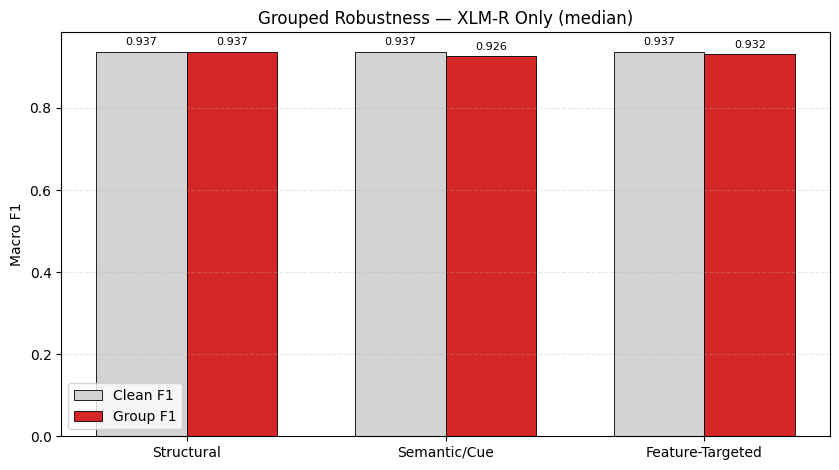

Saved: /content/drive/MyDrive/emc/adv_eval_outputs/grouped_eval/figures_grouped/grouped_bars_XLM-R_Only.png


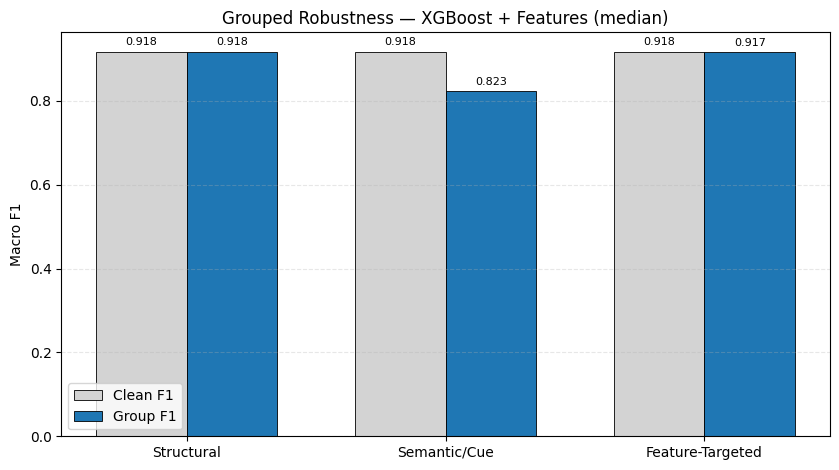

Saved: /content/drive/MyDrive/emc/adv_eval_outputs/grouped_eval/figures_grouped/grouped_bars_XGBoost_Features.png


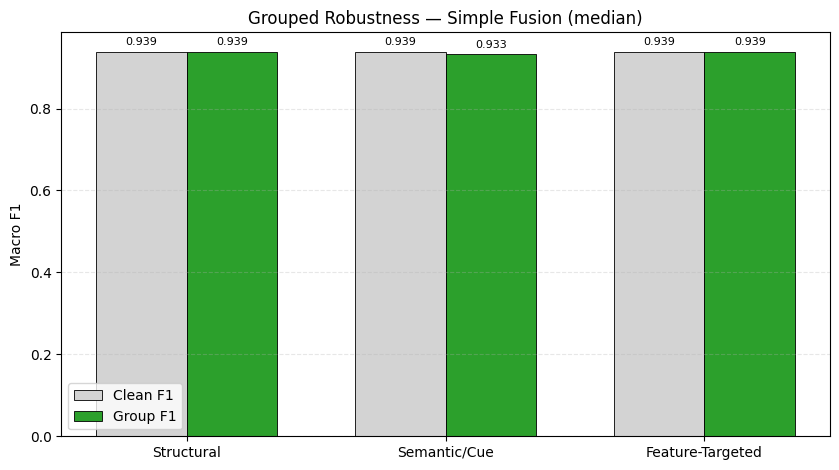

Saved: /content/drive/MyDrive/emc/adv_eval_outputs/grouped_eval/figures_grouped/grouped_bars_Simple_Fusion.png


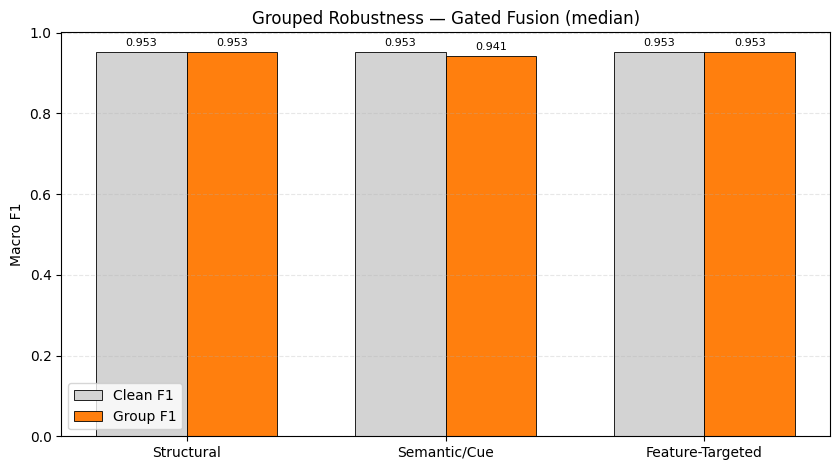

Saved: /content/drive/MyDrive/emc/adv_eval_outputs/grouped_eval/figures_grouped/grouped_bars_Gated_Fusion.png


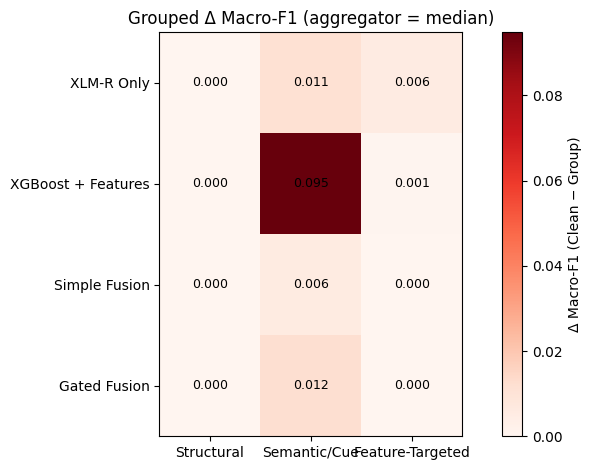

Saved: /content/drive/MyDrive/emc/adv_eval_outputs/grouped_eval/figures_grouped/heatmap_delta_macroF1.png


In [4]:
# --- Block GA-2: Evaluate attacks by groups; export tables & figures ---

import os, re, glob, difflib, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    XLMRobertaTokenizerFast, XLMRobertaForSequenceClassification,
    XLMRobertaModel, DataCollatorWithPadding
)
import joblib, xgboost as xgb
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, roc_curve

# ---------------- Config (match your training artifacts) ----------------
class _Cfg:
    BASE_DIR   = "/content/drive/MyDrive/emc"
    TEST_CSV   = os.path.join(BASE_DIR, "test.csv")
    TERMS_CSV  = os.path.join(BASE_DIR, "engineering_terms.csv")

    XGB_DIR    = os.path.join(BASE_DIR, "xgb_outputs_clean")
    XLMR_DIR   = os.path.join(BASE_DIR, "xlmr_only_outputs_clean")
    SIMPLE_DIR = os.path.join(BASE_DIR, "simple_fusion_outputs_clean")
    GATED_DIR  = os.path.join(BASE_DIR, "gated_fusion_outputs_clean")

    ADV_DIR    = os.path.join(BASE_DIR, "adv_eval_outputs")
    PERT_DIR   = os.path.join(ADV_DIR, "perturbed")
    OUT_DIR    = os.path.join(ADV_DIR, "grouped_eval")

    TEXT_COL   = "content"
    LABEL_COL  = "label"
    LANG_COL   = "lang"
    ID_COL     = "id"

    MAX_LEN    = 256
    BATCH_SIZE = 32
    N_FEATS    = 12
    POS_LABEL  = 1
    DPI        = 600
    AGGREGATOR = "median"   # "mean" | "median" | "worst"

cfg = _Cfg()
os.makedirs(cfg.OUT_DIR, exist_ok=True)

def _norm(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"[\s\-\/]+", "_", s)
    s = re.sub(r"[^a-z0-9_]+", "", s)
    return s

# ---------------- Group map (3 buckets) ----------------
GROUP_MAP = {
    # Structural
    _norm("CharSwap"): "Structural",
    _norm("CaseToggle"): "Structural",
    _norm("PunctInsert"): "Structural",
    _norm("WhitespaceNoise"): "Structural",
    _norm("UnicodeConfuse"): "Structural",
    _norm("SymbolAscii"): "Structural",
    _norm("Truncate80w"): "Structural",
    # Semantic/Cue
    _norm("MaskDomainTerms"): "Semantic/Cue",
    _norm("DropDomainTerms"): "Semantic/Cue",
    _norm("SynonymSwapDomain"): "Semantic/Cue",
    _norm("AcronymPerturb"): "Semantic/Cue",
    _norm("CitationStrip"): "Semantic/Cue",
    _norm("DomainCombo1"): "Semantic/Cue",
    _norm("DomainCombo2"): "Semantic/Cue",
    _norm("DomainCombo3"): "Semantic/Cue",
    _norm("DomainMax"): "Semantic/Cue",
    # Feature-Targeted
    _norm("NumberPerturb"): "Feature-Targeted",
    _norm("StandardNumCorrupt"): "Feature-Targeted",
    _norm("UnitNeutralizeMask"): "Feature-Targeted",
    _norm("UnitNeutralizeDrop"): "Feature-Targeted",
    _norm("UnitNeutralizeGeneric"): "Feature-Targeted",
    _norm("Numbers/Units"): "Feature-Targeted",
    _norm("Unit Conversion (NEW)"): "Feature-Targeted",
}

MODELS = ["XLM-R Only", "XGBoost + Features", "Simple Fusion", "Gated Fusion"]
MODEL_COLORS = {
    "XGBoost + Features": "tab:blue",
    "XLM-R Only":         "tab:red",
    "Simple Fusion":      "tab:green",
    "Gated Fusion":       "tab:orange",
}

# ---------------- Feature extractor (12-D) ----------------
import re
_WORD_RE = re.compile(r"\w+", re.UNICODE)
_NUM_RE  = re.compile(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?')
STD_TERMS = {"iso","asme","ieee","din","ansi","iec","ul","astm","en"}
SAFETY_TERMS = {"safety","hazard","warning","risk","caution","danger","emergency"}

def simple_words(t: str): return _WORD_RE.findall(t or "")
def sent_count(t: str) -> int:
    if not t: return 0
    return max(1, len(re.split(r'[.!?]+[\s\n]+', t)))
def punct_count(t: str) -> int: return sum(1 for ch in (t or "") if ch in ".,;:!?")
def extract_numbers(text: str):
    nums, dec = [], 0
    for m in _NUM_RE.finditer(text or ""):
        s = m.group(0)
        try:
            v = float(s)
            if ('.' in s) or ('e' in s.lower()): dec += 1
            nums.append(abs(v))
        except: pass
    return nums, dec
def _finite_or_zero(x: float):
    try:
        xx = float(x)
        return xx if np.isfinite(xx) else 0.0
    except: return 0.0

class TermsLexicon:
    def __init__(self, csv_path: str, term_col="terms", lang_col="lang"):
        df = pd.read_csv(csv_path)
        if term_col not in df.columns: raise ValueError(f"Missing '{term_col}'")
        if lang_col not in df.columns: df[lang_col] = 'en'
        self.by_lang = {str(l).lower(): set(str(x).strip().lower()
                         for x in d[term_col].dropna().tolist() if str(x).strip())
                        for l, d in df.groupby(lang_col)}
    def pct_in_text(self, text: str, lang: str) -> float:
        terms = self.by_lang.get((lang or "en").lower(), set())
        if not terms: return 0.0
        ws = [w.lower() for w in simple_words(text)]
        return sum(1 for w in ws if w in terms) / max(1, len(ws)) if ws else 0.0

lex = TermsLexicon(cfg.TERMS_CSV)
def engineered_features(df):
    def extract_one(text, lang="en"):
        text = "" if text is None else str(text); lang = (lang or "en").lower()
        ws = simple_words(text); n_words = len(ws)
        chars = len(text); words = n_words; sents = sent_count(text)
        fre, fog = 0.0, 0.0
        eng_pct = lex.pct_in_text(text, lang)
        punc = punct_count(text)
        nums, dec_cnt = extract_numbers(text); nnums = len(nums)
        avg_mag = float(np.mean(nums)) if nums else 0.0
        dec_ratio = float(dec_cnt / max(1, len(nums)))
        low = text.lower()
        has_std = 1.0 if any(t in low for t in STD_TERMS) else 0.0
        has_saf = 1.0 if any(t in low for t in SAFETY_TERMS) else 0.0
        vals = [chars, words, sents, fre, fog, eng_pct, punc, nnums, has_std, has_saf, avg_mag, dec_ratio]
        arr = np.asarray([_finite_or_zero(v) for v in vals], dtype=np.float64)
        arr = np.nan_to_num(arr, nan=0.0, posinf=1e12, neginf=0.0)
        return np.clip(arr, -1e12, 1e12).astype(np.float32)
    local = df if cfg.LANG_COL in df.columns else df.assign(**{cfg.LANG_COL:'en'})
    rows = [extract_one(r.get(cfg.TEXT_COL,""), r.get(cfg.LANG_COL,"en")) for _, r in local.iterrows()]
    return np.stack(rows, axis=0).astype(np.float32)

# ---------------- Datasets & heads ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tok = XLMRobertaTokenizerFast.from_pretrained(cfg.XLMR_DIR)
collator = DataCollatorWithPadding(tok)

class TextOnlyDS(torch.utils.data.Dataset):
    def __init__(self, df):
        self.x = df[cfg.TEXT_COL].astype(str).tolist()
        self.y = df[cfg.LABEL_COL].astype(int).values
    def __len__(self): return len(self.x)
    def __getitem__(self, i):
        enc = tok(self.x[i], truncation=True, padding=False, max_length=cfg.MAX_LEN, return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(int(self.y[i]), dtype=torch.long)
        return item

class TextFeatDS(torch.utils.data.Dataset):
    def __init__(self, df, feats_scaled):
        self.x = df[cfg.TEXT_COL].astype(str).tolist()
        self.y = df[cfg.LABEL_COL].astype(int).values
        self.fe = feats_scaled.astype(np.float32)
    def __len__(self): return len(self.x)
    def __getitem__(self, i):
        enc = tok(self.x[i], truncation=True, padding="max_length", max_length=cfg.MAX_LEN, return_tensors="pt")
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(int(self.y[i]), dtype=torch.long),
            "feats": torch.tensor(self.fe[i], dtype=torch.float32),
        }

class SimpleFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + n_feats, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        fused = torch.cat([pooled, feats], dim=1)
        return self.classifier(self.dropout(fused))

class GatedFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2, feat_proj: int = 64):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.fe_proj = nn.Sequential(nn.Linear(n_feats, feat_proj), nn.ReLU())
        self.gate    = nn.Sequential(nn.Linear(H + n_feats, 64), nn.ReLU(), nn.Linear(64, 1), nn.Sigmoid())
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + feat_proj, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        alpha = self.gate(torch.cat([pooled, feats], dim=1))
        ef    = self.fe_proj(feats)
        fused = torch.cat([pooled, alpha * ef], dim=1)
        return self.classifier(self.dropout(fused))

# load models
xgb_model = xgb.XGBClassifier()
xgb_model.load_model(os.path.join(cfg.XGB_DIR, "xgb_model.json"))
xgb_scaler = joblib.load(os.path.join(cfg.XGB_DIR, "scaler12.pkl"))

xlmr = XLMRobertaForSequenceClassification.from_pretrained(cfg.XLMR_DIR).to(device); xlmr.eval()

simple = SimpleFusion("xlm-roberta-base", cfg.N_FEATS, 2).to(device)
simple.load_state_dict(torch.load(os.path.join(cfg.SIMPLE_DIR, "fusion_simple.pt"), map_location=device), strict=False); simple.eval()
simple_scaler = joblib.load(os.path.join(cfg.SIMPLE_DIR, "scaler12.pkl"))

gated = GatedFusion("xlm-roberta-base", cfg.N_FEATS, 2, feat_proj=64).to(device)
gated.load_state_dict(torch.load(os.path.join(cfg.GATED_DIR, "fusion_gated.pt"), map_location=device), strict=False); gated.eval()
gated_scaler = joblib.load(os.path.join(cfg.GATED_DIR, "scaler12.pkl"))

# metrics helpers
@torch.no_grad()
def eval_xlmr(df):
    ds = TextOnlyDS(df); dl = DataLoader(ds, batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=DataCollatorWithPadding(tok))
    probs = []
    for b in dl:
        inp = {k: v.to(device) for k, v in b.items() if k in ("input_ids","attention_mask")}
        pr = torch.softmax(xlmr(**inp).logits, dim=-1)[:, cfg.POS_LABEL].cpu().numpy()
        probs.append(pr)
    y_prob = np.concatenate(probs); y_pred = (y_prob >= 0.5).astype(int)
    y_true = df[cfg.LABEL_COL].astype(int).values
    return y_true, y_pred, y_prob

def eval_xgb(df):
    X = engineered_features(df); Xs = xgb_scaler.transform(X)
    y_prob = xgb_model.predict_proba(Xs)[:, cfg.POS_LABEL]; y_pred = (y_prob >= 0.5).astype(int)
    y_true = df[cfg.LABEL_COL].astype(int).values
    return y_true, y_pred, y_prob

@torch.no_grad()
def eval_fusion(df, scaler, model):
    X = engineered_features(df); Xs = scaler.transform(X).astype(np.float32)
    ds = TextFeatDS(df, Xs); dl = DataLoader(ds, batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=DataCollatorWithPadding(tok))
    probs = []
    for b in dl:
        ids = b["input_ids"].to(device); am = b["attention_mask"].to(device); ft = b["feats"].to(device)
        pr = torch.softmax(model(ids, am, ft), dim=-1)[:, cfg.POS_LABEL].cpu().numpy()
        probs.append(pr)
    y_prob = np.concatenate(probs); y_pred = (y_prob >= 0.5).astype(int)
    y_true = df[cfg.LABEL_COL].astype(int).values
    return y_true, y_pred, y_prob

def metrics_from(y_true, y_pred, y_prob):
    out = {}
    out["macro_f1"] = f1_score(y_true, y_pred, average="macro")
    try: out["auc_roc"] = roc_auc_score(y_true, y_prob)
    except: out["auc_roc"] = np.nan
    return out

# ---- 1) Clean baseline ----
test_df = pd.read_csv(cfg.TEST_CSV)
rows = []
for m in MODELS:
    if m == "XLM-R Only":         y_true, y_pred, y_prob = eval_xlmr(test_df)
    elif m == "XGBoost + Features": y_true, y_pred, y_prob = eval_xgb(test_df)
    elif m == "Simple Fusion":    y_true, y_pred, y_prob = eval_fusion(test_df, simple_scaler, simple)
    else:                         y_true, y_pred, y_prob = eval_fusion(test_df, gated_scaler, gated)
    rows.append({"Model": m, "Attack_norm": _norm("Clean"), "Group": "Clean", **metrics_from(y_true,y_pred,y_prob)})
clean_df = pd.DataFrame(rows)

# ---- 2) Per-attack eval (from freshly generated files) ----
attack_frames = []
for p in sorted(glob.glob(os.path.join(cfg.ADV_DIR, "perturbed", "*.csv"))):
    name = os.path.splitext(os.path.basename(p))[0]
    if name == _norm("Clean"):
        continue
    dfp = pd.read_csv(p)
    if cfg.TEXT_COL not in dfp.columns or cfg.LABEL_COL not in dfp.columns:
        continue
    group = GROUP_MAP.get(name, "Unassigned")
    for m in MODELS:
        if m == "XLM-R Only":         y_true, y_pred, y_prob = eval_xlmr(dfp)
        elif m == "XGBoost + Features": y_true, y_pred, y_prob = eval_xgb(dfp)
        elif m == "Simple Fusion":    y_true, y_pred, y_prob = eval_fusion(dfp, simple_scaler, simple)
        else:                         y_true, y_pred, y_prob = eval_fusion(dfp, gated_scaler, gated)
        attack_frames.append({"Model": m, "Attack_norm": name, "Group": group, **metrics_from(y_true,y_pred,y_prob)})

atk_eval = pd.DataFrame(attack_frames)
atk_raw_path = os.path.join(cfg.OUT_DIR, "per_attack_eval_raw.csv")
atk_eval.to_csv(atk_raw_path, index=False)
print("Saved:", atk_raw_path)

# ---- 3) Aggregate by the 3 groups ----
clean_macro = clean_df[["Model","macro_f1"]].rename(columns={"macro_f1":"Clean Macro F1"})

agg = cfg.AGGREGATOR.lower()
if agg == "mean":
    g_agg = atk_eval.groupby(["Model","Group"], as_index=False)["macro_f1"].mean()
elif agg == "median":
    g_agg = atk_eval.groupby(["Model","Group"], as_index=False)["macro_f1"].median()
elif agg == "worst":
    g_agg = atk_eval.groupby(["Model","Group"], as_index=False)["macro_f1"].min()
else:
    raise ValueError("AGGREGATOR must be one of: mean|median|worst")

g_agg = g_agg.rename(columns={"macro_f1":"Group Macro F1"})
grouped_tbl = g_agg.merge(clean_macro, on="Model", how="left")
grouped_tbl["Δ"]  = grouped_tbl["Clean Macro F1"] - grouped_tbl["Group Macro F1"]
grouped_tbl["Δ%"] = 100.0 * grouped_tbl["Δ"] / grouped_tbl["Clean Macro F1"].replace(0.0, np.nan)

# order + export
order_groups = ["Structural","Semantic/Cue","Feature-Targeted"]
grouped_tbl["Group"] = pd.Categorical(grouped_tbl["Group"], categories=order_groups, ordered=True)
grouped_tbl = grouped_tbl.sort_values(["Model","Group"]).reset_index(drop=True)

suffix = {"mean":"avg","median":"median","worst":"worst"}[agg]
csv_path = os.path.join(cfg.OUT_DIR, f"grouped_macro_f1_{suffix}.csv")
md_path  = os.path.join(cfg.OUT_DIR, f"grouped_macro_f1_{suffix}.md")
tex_path = os.path.join(cfg.OUT_DIR, f"grouped_macro_f1_{suffix}.tex")

grouped_tbl.to_csv(csv_path, index=False)
with open(md_path, "w") as f:
    f.write(grouped_tbl.rename(columns={"Δ":"Delta","Δ%":"Delta%"}).to_markdown(index=False))
latex_tbl = grouped_tbl.rename(columns={
    "Group":"Attack Group","Clean Macro F1":"Clean~F1","Group Macro F1":"Group~F1",
    "Δ":r"$\Delta$~F1","Δ%":r"$\Delta$~(\%)"
}).to_latex(index=False, escape=True, longtable=False, column_format="l l r r r r",
            na_rep="--", float_format="%.3f".__mod__,
            caption=f"Clean vs. grouped adversarial Macro-F1 (aggregator = {agg}).",
            label=f"tab:grouped_macroF1_{suffix}")
with open(tex_path, "w") as f:
    f.write("% Requires \\usepackage{booktabs}\n")
    f.write(latex_tbl)

print("Wrote tables:")
print(" ", csv_path)
print(" ", md_path)
print(" ", tex_path)
print("\nGrouped table (rounded):")
print(grouped_tbl.round(4).to_string(index=False))

# ---- 4) Figures (600 dpi): Group bars & Δ heatmap ----
FIG_DIR = os.path.join(cfg.OUT_DIR, "figures_grouped"); os.makedirs(FIG_DIR, exist_ok=True)

# (A) per-model bars
for model_name in MODELS:
    sub = grouped_tbl[grouped_tbl["Model"]==model_name].copy()
    if sub.empty: continue
    labels = sub["Group"].astype(str).tolist()
    clean_vals = sub["Clean Macro F1"].values
    group_vals = sub["Group Macro F1"].values
    x = np.arange(len(labels)); w = 0.35

    plt.figure(figsize=(8.5,4.8))
    plt.bar(x - w/2, clean_vals, width=w, label="Clean F1", color="lightgray", edgecolor="black", linewidth=0.6)
    plt.bar(x + w/2, group_vals, width=w, label="Group F1", color=MODEL_COLORS.get(model_name,"tab:blue"), edgecolor="black", linewidth=0.6)
    for i,(c,g) in enumerate(zip(clean_vals, group_vals)):
        plt.text(x[i]-w/2, c+0.01, f"{c:.3f}", ha="center", va="bottom", fontsize=8)
        plt.text(x[i]+w/2, g+0.01, f"{g:.3f}", ha="center", va="bottom", fontsize=8)
    plt.xticks(x, labels); plt.ylabel("Macro F1")
    plt.title(f"Grouped Robustness — {model_name} ({cfg.AGGREGATOR})")
    plt.legend(); plt.grid(axis="y", linestyle="--", alpha=0.3)
    out_png = os.path.join(FIG_DIR, f"grouped_bars_{re.sub(r'[^A-Za-z0-9_.-]+','_',model_name)}.png")
    plt.tight_layout(); plt.savefig(out_png, dpi=cfg.DPI); plt.show()
    print("Saved:", out_png)

# (B) Δ heatmap
heat = grouped_tbl.pivot(index="Model", columns="Group", values="Δ").reindex(index=MODELS)[order_groups]
plt.figure(figsize=(8.2,4.8))
im = plt.imshow(heat.values, cmap="Reds", vmin=0, vmax=np.nanmax(heat.values) if np.isfinite(heat.values).any() else 1)
for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        v = heat.values[i,j]
        if np.isfinite(v):
            plt.text(j, i, f"{v:.3f}", ha="center", va="center", fontsize=9, color="black")
plt.xticks(np.arange(len(order_groups)), order_groups)
plt.yticks(np.arange(len(MODELS)), MODELS)
plt.colorbar(im, label="Δ Macro-F1 (Clean − Group)")
plt.title(f"Grouped Δ Macro-F1 (aggregator = {cfg.AGGREGATOR})")
hm_png = os.path.join(FIG_DIR, "heatmap_delta_macroF1.png")
plt.tight_layout(); plt.savefig(hm_png, dpi=cfg.DPI); plt.show()
print("Saved:", hm_png)


Saved: /content/drive/MyDrive/emc/adv_eval_outputs/grouped_eval/group_pr_fpr95_summary.csv
             Model            Group  Clean AP  Group AP    ΔAP  Clean FPR@95  Group FPR@95  ΔFPR@95
        XLM-R Only       Structural    0.9846    0.9843 0.0003        0.0568        0.0551  -0.0017
        XLM-R Only     Semantic/Cue    0.9846    0.9729 0.0117        0.0568        0.0914   0.0346
        XLM-R Only Feature-Targeted    0.9846    0.9833 0.0013        0.0568        0.0564  -0.0004
XGBoost + Features       Structural    0.9584    0.8804 0.0781        0.1125        0.5614   0.4489
XGBoost + Features     Semantic/Cue    0.9584    0.8391 0.1193        0.1125        0.3294   0.2168
XGBoost + Features Feature-Targeted    0.9584    0.9334 0.0251        0.1125        0.1600   0.0475
     Simple Fusion       Structural    0.9849    0.9846 0.0003        0.0528        0.0546   0.0018
     Simple Fusion     Semantic/Cue    0.9849    0.9786 0.0063        0.0528        0.0611   0.0083
     Simp

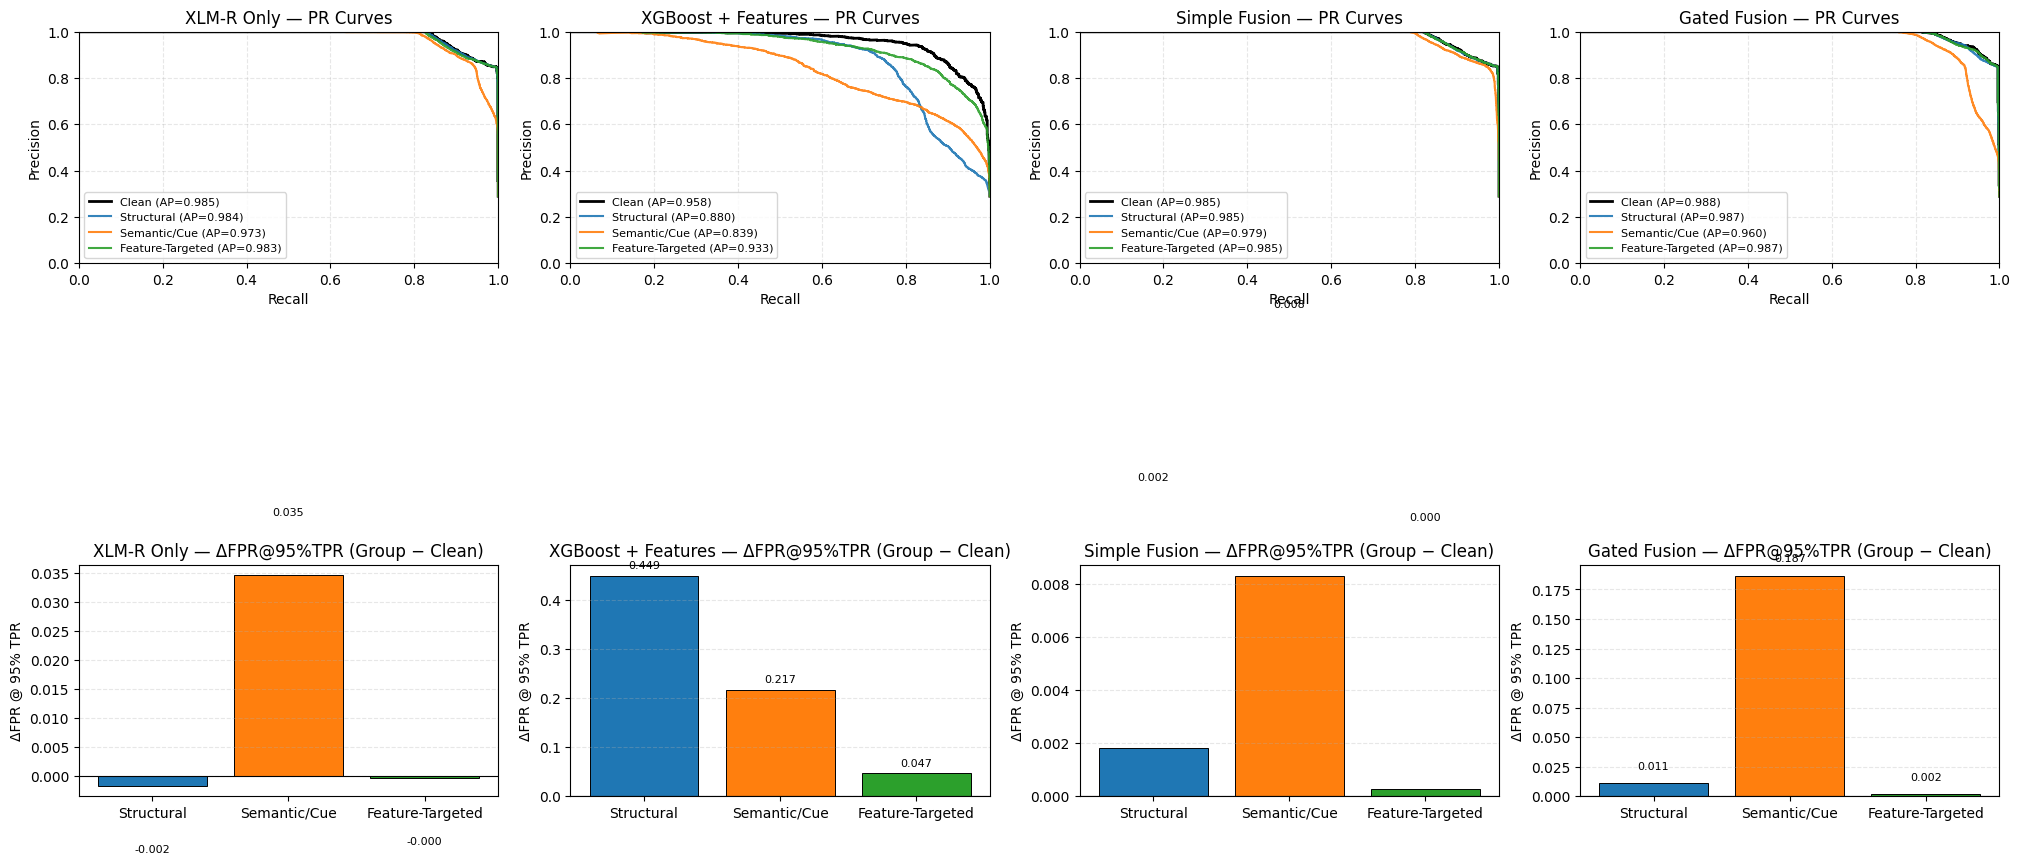

Saved: /content/drive/MyDrive/emc/adv_eval_outputs/grouped_eval/figures_grouped/panel_pr_and_deltafpr.png


In [5]:
# === PR-AUC + ΔFPR@95%TPR (Grouped) + Single Multi-Panel Figure (600 dpi) ===
# Outputs:
#   adv_eval_outputs/grouped_eval/group_pr_fpr95_summary.csv
#   adv_eval_outputs/grouped_eval/figures_grouped/panel_pr_and_deltafpr.png
#
# Assumptions:
# - Clean test set:        /content/drive/MyDrive/emc/test.csv
# - Perturbed datasets:    /content/drive/MyDrive/emc/adv_eval_outputs/perturbed/*.csv
#   (Use GA-1 to generate them if missing.)
# - Model artifacts:
#     XGB:    /content/drive/MyDrive/emc/xgb_outputs_clean/{xgb_model.json, scaler12.pkl}
#     XLM-R:  /content/drive/MyDrive/emc/xlmr_only_outputs_clean
#     Simple: /content/drive/MyDrive/emc/simple_fusion_outputs_clean/{fusion_simple.pt, scaler12.pkl}
#     Gated:  /content/drive/MyDrive/emc/gated_fusion_outputs_clean/{fusion_gated.pt, scaler12.pkl}

import os, re, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import joblib, xgboost as xgb
from transformers import (
    XLMRobertaTokenizerFast, XLMRobertaModel, XLMRobertaForSequenceClassification,
    DataCollatorWithPadding
)
from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    roc_curve
)

# ---------------- Config ----------------
class CFG:
    BASE_DIR   = "/content/drive/MyDrive/emc"
    TEST_CSV   = os.path.join(BASE_DIR, "test.csv")
    TERMS_CSV  = os.path.join(BASE_DIR, "engineering_terms.csv")

    XGB_DIR    = os.path.join(BASE_DIR, "xgb_outputs_clean")
    XLMR_DIR   = os.path.join(BASE_DIR, "xlmr_only_outputs_clean")
    SIMPLE_DIR = os.path.join(BASE_DIR, "simple_fusion_outputs_clean")
    GATED_DIR  = os.path.join(BASE_DIR, "gated_fusion_outputs_clean")

    ADV_DIR    = os.path.join(BASE_DIR, "adv_eval_outputs")
    PERT_DIR   = os.path.join(ADV_DIR, "perturbed")
    OUT_DIR    = os.path.join(ADV_DIR, "grouped_eval")
    FIG_DIR    = os.path.join(OUT_DIR, "figures_grouped")

    TEXT_COL   = "content"
    LABEL_COL  = "label"
    LANG_COL   = "lang"
    MAX_LEN    = 256
    BATCH_SIZE = 32
    N_FEATS    = 12
    POS_LABEL  = 1
    DPI        = 600

cfg = CFG()
os.makedirs(cfg.OUT_DIR, exist_ok=True)
os.makedirs(cfg.FIG_DIR, exist_ok=True)

def _norm(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"[\s\-\/]+", "_", s)
    s = re.sub(r"[^a-z0-9_]+", "", s)
    return s

# ------------- Group mapping (3 buckets) -------------
GROUP_MAP = {
    # Structural
    _norm("CharSwap"): "Structural",
    _norm("CaseToggle"): "Structural",
    _norm("PunctInsert"): "Structural",
    _norm("WhitespaceNoise"): "Structural",
    _norm("UnicodeConfuse"): "Structural",
    _norm("SymbolAscii"): "Structural",
    _norm("Truncate80w"): "Structural",
    # Semantic/Cue
    _norm("MaskDomainTerms"): "Semantic/Cue",
    _norm("DropDomainTerms"): "Semantic/Cue",
    _norm("SynonymSwapDomain"): "Semantic/Cue",
    _norm("AcronymPerturb"): "Semantic/Cue",
    _norm("CitationStrip"): "Semantic/Cue",
    _norm("DomainCombo1"): "Semantic/Cue",
    _norm("DomainCombo2"): "Semantic/Cue",
    _norm("DomainCombo3"): "Semantic/Cue",
    _norm("DomainMax"): "Semantic/Cue",
    # Feature-Targeted
    _norm("NumberPerturb"): "Feature-Targeted",
    _norm("StandardNumCorrupt"): "Feature-Targeted",
    _norm("UnitNeutralizeMask"): "Feature-Targeted",
    _norm("UnitNeutralizeDrop"): "Feature-Targeted",
    _norm("UnitNeutralizeGeneric"): "Feature-Targeted",
    _norm("Numbers/Units"): "Feature-Targeted",
    _norm("Unit Conversion (NEW)"): "Feature-Targeted",
}
ORDER_GROUPS = ["Structural", "Semantic/Cue", "Feature-Targeted"]

MODELS = ["XLM-R Only", "XGBoost + Features", "Simple Fusion", "Gated Fusion"]
MODEL_COLORS = {
    "XGBoost + Features": "tab:blue",
    "XLM-R Only":         "tab:red",
    "Simple Fusion":      "tab:green",
    "Gated Fusion":       "tab:orange",
}
GROUP_COLORS = {
    "Structural":      "tab:blue",
    "Semantic/Cue":    "tab:orange",
    "Feature-Targeted":"tab:green",
}
CLEAN_COLOR = "black"

# ---------------- Feature extractor (12-D) ----------------
import re
_WORD_RE = re.compile(r"\w+", re.UNICODE)
_NUM_RE  = re.compile(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?')
STD_TERMS = {"iso","asme","ieee","din","ansi","iec","ul","astm","en"}
SAFETY_TERMS = {"safety","hazard","warning","risk","caution","danger","emergency"}

def simple_words(t: str): return _WORD_RE.findall(t or "")
def sent_count(t: str) -> int:
    if not t: return 0
    return max(1, len(re.split(r'[.!?]+[\s\n]+', t)))
def punct_count(t: str) -> int: return sum(1 for ch in (t or "") if ch in ".,;:!?")
def extract_numbers(text: str):
    nums, dec = [], 0
    for m in _NUM_RE.finditer(text or ""):
        s = m.group(0)
        try:
            v = float(s)
            if ('.' in s) or ('e' in s.lower()): dec += 1
            nums.append(abs(v))
        except: pass
    return nums, dec
def _finite_or_zero(x: float):
    try:
        xx = float(x)
        return xx if np.isfinite(xx) else 0.0
    except: return 0.0

class TermsLexicon:
    def __init__(self, csv_path: str, term_col="terms", lang_col="lang"):
        df = pd.read_csv(csv_path)
        if term_col not in df.columns: raise ValueError(f"Missing '{term_col}'")
        if lang_col not in df.columns: df[lang_col] = 'en'
        self.by_lang = {str(l).lower(): set(str(x).strip().lower()
                         for x in d[term_col].dropna().tolist() if str(x).strip())
                        for l, d in df.groupby(lang_col)}
    def pct_in_text(self, text: str, lang: str) -> float:
        terms = self.by_lang.get((lang or "en").lower(), set())
        if not terms: return 0.0
        ws = [w.lower() for w in simple_words(text)]
        return sum(1 for w in ws if w in terms) / max(1, len(ws)) if ws else 0.0

lex = TermsLexicon(cfg.TERMS_CSV)

def engineered_features(df):
    def extract_one(text, lang="en"):
        text = "" if text is None else str(text); lang = (lang or "en").lower()
        ws = simple_words(text); n_words = len(ws)
        chars = len(text); words = n_words; sents = sent_count(text)
        fre, fog = 0.0, 0.0
        eng_pct = lex.pct_in_text(text, lang)
        punc = punct_count(text)
        nums, dec_cnt = extract_numbers(text); nnums = len(nums)
        avg_mag = float(np.mean(nums)) if nums else 0.0
        dec_ratio = float(dec_cnt / max(1, len(nums)))
        low = text.lower()
        has_std = 1.0 if any(t in low for t in STD_TERMS) else 0.0
        has_saf = 1.0 if any(t in low for t in SAFETY_TERMS) else 0.0
        vals = [chars, words, sents, fre, fog, eng_pct, punc, nnums, has_std, has_saf, avg_mag, dec_ratio]
        arr = np.asarray([_finite_or_zero(v) for v in vals], dtype=np.float64)
        arr = np.nan_to_num(arr, nan=0.0, posinf=1e12, neginf=0.0)
        return np.clip(arr, -1e12, 1e12).astype(np.float32)
    local = df if cfg.LANG_COL in df.columns else df.assign(**{cfg.LANG_COL:'en'})
    rows = [extract_one(r.get(cfg.TEXT_COL,""), r.get(cfg.LANG_COL,"en")) for _, r in local.iterrows()]
    return np.stack(rows, axis=0).astype(np.float32)

# ---------------- Tokenizer & models ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tok = XLMRobertaTokenizerFast.from_pretrained(cfg.XLMR_DIR)
collator = DataCollatorWithPadding(tok)

class TextOnlyDS(Dataset):
    def __init__(self, df):
        self.x = df[cfg.TEXT_COL].astype(str).tolist()
        self.y = df[cfg.LABEL_COL].astype(int).values
    def __len__(self): return len(self.x)
    def __getitem__(self, i):
        enc = tok(self.x[i], truncation=True, padding=False, max_length=cfg.MAX_LEN, return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(int(self.y[i]), dtype=torch.long)
        return item

class TextFeatDS(Dataset):
    def __init__(self, df, feats_scaled):
        self.x = df[cfg.TEXT_COL].astype(str).tolist()
        self.y = df[cfg.LABEL_COL].astype(int).values
        self.fe = feats_scaled.astype(np.float32)
    def __len__(self): return len(self.x)
    def __getitem__(self, i):
        enc = tok(self.x[i], truncation=True, padding="max_length", max_length=cfg.MAX_LEN, return_tensors="pt")
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(int(self.y[i]), dtype=torch.long),
            "feats": torch.tensor(self.fe[i], dtype=torch.float32),
        }

class SimpleFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + n_feats, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        fused = torch.cat([pooled, feats], dim=1)
        return self.classifier(self.dropout(fused))

class GatedFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2, feat_proj: int = 64):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.fe_proj = nn.Sequential(nn.Linear(n_feats, feat_proj), nn.ReLU())
        self.gate    = nn.Sequential(nn.Linear(H + n_feats, 64), nn.ReLU(), nn.Linear(64, 1), nn.Sigmoid())
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + feat_proj, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        alpha = self.gate(torch.cat([pooled, feats], dim=1))
        ef    = self.fe_proj(feats)
        fused = torch.cat([pooled, alpha * ef], dim=1)
        return self.classifier(self.dropout(fused))

# Load artifacts
xgb_model = xgb.XGBClassifier(); xgb_model.load_model(os.path.join(cfg.XGB_DIR, "xgb_model.json"))
xgb_scaler = joblib.load(os.path.join(cfg.XGB_DIR, "scaler12.pkl"))

xlmr = XLMRobertaForSequenceClassification.from_pretrained(cfg.XLMR_DIR).to(device); xlmr.eval()

simple = SimpleFusion("xlm-roberta-base", cfg.N_FEATS, 2).to(device)
simple.load_state_dict(torch.load(os.path.join(cfg.SIMPLE_DIR, "fusion_simple.pt"), map_location=device), strict=False); simple.eval()
simple_scaler = joblib.load(os.path.join(cfg.SIMPLE_DIR, "scaler12.pkl"))

gated = GatedFusion("xlm-roberta-base", cfg.N_FEATS, 2, feat_proj=64).to(device)
gated.load_state_dict(torch.load(os.path.join(cfg.GATED_DIR, "fusion_gated.pt"), map_location=device), strict=False); gated.eval()
gated_scaler = joblib.load(os.path.join(cfg.GATED_DIR, "scaler12.pkl"))

# ---------------- Eval helpers (return y_true, y_prob) ----------------
@torch.no_grad()
def eval_xlmr(df):
    ds = TextOnlyDS(df); dl = DataLoader(ds, batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=DataCollatorWithPadding(tok))
    probs = []
    for b in dl:
        inp = {k: v.to(device) for k, v in b.items() if k in ("input_ids","attention_mask")}
        pr = torch.softmax(xlmr(**inp).logits, dim=-1)[:, cfg.POS_LABEL].cpu().numpy()
        probs.append(pr)
    return df[cfg.LABEL_COL].astype(int).values, np.concatenate(probs)

def eval_xgb(df):
    X = engineered_features(df); Xs = xgb_scaler.transform(X)
    y_prob = xgb_model.predict_proba(Xs)[:, cfg.POS_LABEL]
    return df[cfg.LABEL_COL].astype(int).values, y_prob

@torch.no_grad()
def eval_fusion(df, scaler, model):
    X = engineered_features(df); Xs = scaler.transform(X).astype(np.float32)
    ds = TextFeatDS(df, Xs); dl = DataLoader(ds, batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=DataCollatorWithPadding(tok))
    probs = []
    for b in dl:
        ids = b["input_ids"].to(device); am = b["attention_mask"].to(device); ft = b["feats"].to(device)
        pr = torch.softmax(model(ids, am, ft), dim=-1)[:, cfg.POS_LABEL].cpu().numpy()
        probs.append(pr)
    return df[cfg.LABEL_COL].astype(int).values, np.concatenate(probs)

def eval_model(df, model_name):
    if model_name == "XLM-R Only":
        return eval_xlmr(df)
    elif model_name == "XGBoost + Features":
        return eval_xgb(df)
    elif model_name == "Simple Fusion":
        return eval_fusion(df, simple_scaler, simple)
    else:
        return eval_fusion(df, gated_scaler, gated)

# ---------------- Build datasets: clean + groups (concat attacks) ----------------
test_df = pd.read_csv(cfg.TEST_CSV)
assert cfg.TEXT_COL in test_df.columns and cfg.LABEL_COL in test_df.columns, "test.csv must have content + label"

# Map attack CSVs to groups
files = sorted(glob.glob(os.path.join(cfg.PERT_DIR, "*.csv")))
attack_to_group = {}
for p in files:
    name = os.path.splitext(os.path.basename(p))[0]  # normalized name
    if name == _norm("Clean"):  # ignore
        continue
    grp = GROUP_MAP.get(name, None)
    if grp:
        attack_to_group.setdefault(grp, []).append(p)

# For each group, concatenate the perturbed rows from *all* attacks in the group
group_frames = {}
for grp in ORDER_GROUPS:
    paths = attack_to_group.get(grp, [])
    if not paths:
        continue
    dfs = []
    for p in paths:
        dfp = pd.read_csv(p)
        if cfg.TEXT_COL in dfp.columns and cfg.LABEL_COL in dfp.columns:
            dfs.append(dfp[[cfg.TEXT_COL, cfg.LABEL_COL]])
    if dfs:
        group_frames[grp] = pd.concat(dfs, ignore_index=True)

# ---------------- Compute PR curves, AP, FPR@95%TPR ----------------
def pr_ap(y_true, y_prob):
    # Handle degenerate cases gracefully
    try:
        prec, rec, _ = precision_recall_curve(y_true, y_prob, pos_label=cfg.POS_LABEL)
        ap = average_precision_score(y_true, y_prob)
    except Exception:
        prec, rec, ap = np.array([1.0, 0.0]), np.array([0.0, 1.0]), np.nan
    return prec, rec, ap

def fpr_at_95_tpr(y_true, y_prob):
    try:
        fpr, tpr, thr = roc_curve(y_true, y_prob, pos_label=cfg.POS_LABEL)
        mask = tpr >= 0.95
        return float(np.min(fpr[mask])) if np.any(mask) else np.nan
    except Exception:
        return np.nan

rows = []
# Precompute clean for all models
clean_curves = {}
group_curves = {m: {} for m in MODELS}

for model_name in MODELS:
    # Clean
    y_true_c, y_prob_c = eval_model(test_df, model_name)
    pc, rc, ap_c = pr_ap(y_true_c, y_prob_c)
    fpr95_c = fpr_at_95_tpr(y_true_c, y_prob_c)
    clean_curves[model_name] = (pc, rc, ap_c, fpr95_c)

    # Groups
    for grp in ORDER_GROUPS:
        df_g = group_frames.get(grp, None)
        if df_g is None or df_g.empty:
            group_curves[model_name][grp] = (None, None, np.nan, np.nan)
            continue
        y_true_g, y_prob_g = eval_model(df_g, model_name)
        pg, rg, ap_g = pr_ap(y_true_g, y_prob_g)
        fpr95_g = fpr_at_95_tpr(y_true_g, y_prob_g)
        group_curves[model_name][grp] = (pg, rg, ap_g, fpr95_g)

        rows.append({
            "Model": model_name,
            "Group": grp,
            "Clean AP": ap_c,
            "Group AP": ap_g,
            "ΔAP": ap_c - ap_g if np.isfinite(ap_c) and np.isfinite(ap_g) else np.nan,
            "Clean FPR@95": fpr95_c,
            "Group FPR@95": fpr95_g,
            "ΔFPR@95": (fpr95_g - fpr95_c) if np.isfinite(fpr95_c) and np.isfinite(fpr95_g) else np.nan,
        })

summary = pd.DataFrame(rows)
sum_csv = os.path.join(cfg.OUT_DIR, "group_pr_fpr95_summary.csv")
summary.to_csv(sum_csv, index=False)
print("Saved:", sum_csv)
print(summary.round(4).to_string(index=False))

# ---------------- Single Multi-Panel Figure ----------------
# Layout: 2 rows x Ncols (Ncols = number of models)
n_models = len(MODELS)
fig, axes = plt.subplots(2, n_models, figsize=(5*n_models, 8.5), constrained_layout=True)

for j, model_name in enumerate(MODELS):
    # --- Top row: PR curves (Clean vs Groups) ---
    ax_pr = axes[0, j] if n_models > 1 else axes[0]
    pc, rc, ap_c, _ = clean_curves[model_name]
    ax_pr.plot(rc, pc, label=f"Clean (AP={ap_c:.3f})", color=CLEAN_COLOR, linewidth=2)

    for grp in ORDER_GROUPS:
        pg, rg, ap_g, _ = group_curves[model_name].get(grp, (None, None, np.nan, np.nan))
        if pg is None or rg is None:
            continue
        ax_pr.plot(rg, pg, label=f"{grp} (AP={ap_g:.3f})", color=GROUP_COLORS.get(grp, "gray"), alpha=0.9)

    ax_pr.set_title(f"{model_name} — PR Curves")
    ax_pr.set_xlabel("Recall")
    ax_pr.set_ylabel("Precision")
    ax_pr.set_xlim(0, 1); ax_pr.set_ylim(0, 1)
    ax_pr.grid(True, linestyle="--", alpha=0.3)
    ax_pr.legend(fontsize=8, loc="lower left")

    # --- Bottom row: ΔFPR@95%TPR bars (Group − Clean) ---
    ax_df = axes[1, j] if n_models > 1 else axes[1]
    deltas = []
    labels = []
    colors = []
    for grp in ORDER_GROUPS:
        _, _, _, fpr95_g = group_curves[model_name].get(grp, (None, None, np.nan, np.nan))
        _, _, _, fpr95_c = clean_curves[model_name]
        if np.isfinite(fpr95_g) and np.isfinite(fpr95_c):
            deltas.append(fpr95_g - fpr95_c)
            labels.append(grp)
            colors.append(GROUP_COLORS.get(grp, "gray"))

    if deltas:
        xs = np.arange(len(deltas))
        ax_df.bar(xs, deltas, color=colors, edgecolor="black", linewidth=0.7)
        for xi, v in enumerate(deltas):
            ax_df.text(xi, v + (0.01 if v >= 0 else -0.01), f"{v:.3f}",
                       ha="center", va="bottom" if v >= 0 else "top", fontsize=8)
        ax_df.set_xticks(xs); ax_df.set_xticklabels(labels, rotation=0)
        ax_df.set_ylabel("ΔFPR @ 95% TPR")
        ax_df.set_title(f"{model_name} — ΔFPR@95%TPR (Group − Clean)")
        ax_df.axhline(0, color="black", linewidth=0.8)
        ax_df.grid(axis="y", linestyle="--", alpha=0.3)
    else:
        ax_df.set_title(f"{model_name} — ΔFPR@95%TPR")
        ax_df.text(0.5, 0.5, "No valid groups", ha="center", va="center")
        ax_df.axis("off")

panel_path = os.path.join(cfg.FIG_DIR, "panel_pr_and_deltafpr.png")
plt.savefig(panel_path, dpi=cfg.DPI)
plt.show()
print("Saved:", panel_path)


Saved: /content/drive/MyDrive/emc/adv_eval_outputs/grouped_eval/group_pr_fpr95_worst_summary.csv
             Model            Group  Clean AP  Worst AP    ΔAP  Clean FPR@95  Worst FPR@95  ΔFPR@95       Worst_AP_Attack      Worst_FPR_Attack
        XLM-R Only       Structural    0.9846    0.9822 0.0024        0.0568        0.0575   0.0007           truncate80w           symbolascii
        XLM-R Only     Semantic/Cue    0.9846    0.9697 0.0149        0.0568        0.0827   0.0259             domainmax             domainmax
        XLM-R Only Feature-Targeted    0.9846    0.9822 0.0024        0.0568        0.0583   0.0015    unitneutralizedrop    unitneutralizedrop
XGBoost + Features       Structural    0.9584    0.3272 0.6312        0.1125        0.7050   0.5925           truncate80w           truncate80w
XGBoost + Features     Semantic/Cue    0.9584    0.5080 0.4504        0.1125        0.7997   0.6872       dropdomainterms       dropdomainterms
XGBoost + Features Feature-Targeted    

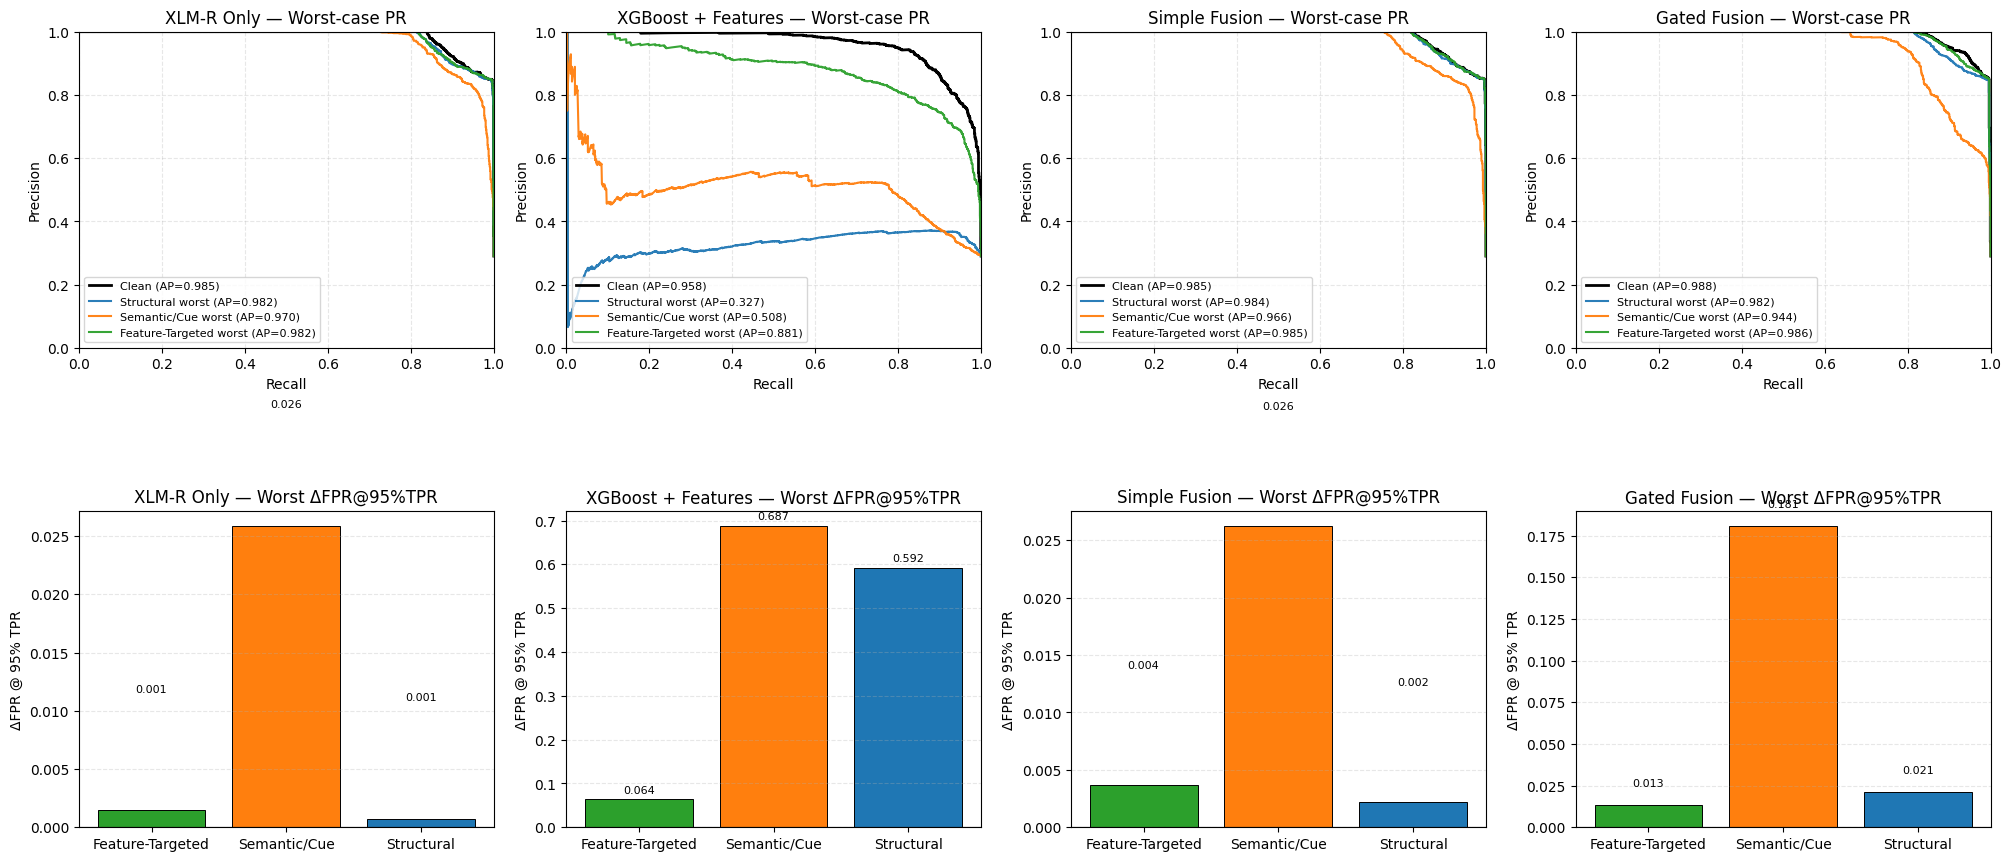

Saved: /content/drive/MyDrive/emc/adv_eval_outputs/grouped_eval/figures_grouped/panel_pr_and_deltafpr_worst.png


In [6]:
# === WORST-CASE grouped robustness: PR-AUC (AP) & ΔFPR@95%TPR ===
# Outputs:
#   adv_eval_outputs/grouped_eval/group_pr_fpr95_worst_summary.csv
#   adv_eval_outputs/grouped_eval/figures_grouped/panel_pr_and_deltafpr_worst.png

import os, re, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn, joblib, xgboost as xgb
from torch.utils.data import Dataset, DataLoader
from transformers import (
    XLMRobertaTokenizerFast, XLMRobertaModel, XLMRobertaForSequenceClassification,
    DataCollatorWithPadding
)
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve

# ---------------- Config ----------------
class CFG:
    BASE_DIR   = "/content/drive/MyDrive/emc"
    TEST_CSV   = os.path.join(BASE_DIR, "test.csv")
    TERMS_CSV  = os.path.join(BASE_DIR, "engineering_terms.csv")

    XGB_DIR    = os.path.join(BASE_DIR, "xgb_outputs_clean")
    XLMR_DIR   = os.path.join(BASE_DIR, "xlmr_only_outputs_clean")
    SIMPLE_DIR = os.path.join(BASE_DIR, "simple_fusion_outputs_clean")
    GATED_DIR  = os.path.join(BASE_DIR, "gated_fusion_outputs_clean")

    ADV_DIR    = os.path.join(BASE_DIR, "adv_eval_outputs")
    PERT_DIR   = os.path.join(ADV_DIR, "perturbed")
    OUT_DIR    = os.path.join(ADV_DIR, "grouped_eval")
    FIG_DIR    = os.path.join(OUT_DIR, "figures_grouped")

    TEXT_COL   = "content"
    LABEL_COL  = "label"
    LANG_COL   = "lang"
    MAX_LEN    = 256
    BATCH_SIZE = 32
    N_FEATS    = 12
    POS_LABEL  = 1
    DPI        = 600

cfg = CFG()
os.makedirs(cfg.OUT_DIR, exist_ok=True)
os.makedirs(cfg.FIG_DIR, exist_ok=True)

def _norm(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"[\s\-\/]+", "_", s)
    s = re.sub(r"[^a-z0-9_]+", "", s)
    return s

# ------------- Group mapping (3 buckets) -------------
GROUP_MAP = {
    # Structural
    _norm("CharSwap"): "Structural",
    _norm("CaseToggle"): "Structural",
    _norm("PunctInsert"): "Structural",
    _norm("WhitespaceNoise"): "Structural",
    _norm("UnicodeConfuse"): "Structural",
    _norm("SymbolAscii"): "Structural",
    _norm("Truncate80w"): "Structural",
    # Semantic/Cue
    _norm("MaskDomainTerms"): "Semantic/Cue",
    _norm("DropDomainTerms"): "Semantic/Cue",
    _norm("SynonymSwapDomain"): "Semantic/Cue",
    _norm("AcronymPerturb"): "Semantic/Cue",
    _norm("CitationStrip"): "Semantic/Cue",
    _norm("DomainCombo1"): "Semantic/Cue",
    _norm("DomainCombo2"): "Semantic/Cue",
    _norm("DomainCombo3"): "Semantic/Cue",
    _norm("DomainMax"): "Semantic/Cue",
    # Feature-Targeted
    _norm("NumberPerturb"): "Feature-Targeted",
    _norm("StandardNumCorrupt"): "Feature-Targeted",
    _norm("UnitNeutralizeMask"): "Feature-Targeted",
    _norm("UnitNeutralizeDrop"): "Feature-Targeted",
    _norm("UnitNeutralizeGeneric"): "Feature-Targeted",
    _norm("Numbers/Units"): "Feature-Targeted",
    _norm("Unit Conversion (NEW)"): "Feature-Targeted",
}
ORDER_GROUPS = ["Structural", "Semantic/Cue", "Feature-Targeted"]

MODELS = ["XLM-R Only", "XGBoost + Features", "Simple Fusion", "Gated Fusion"]
MODEL_COLORS = {
    "XGBoost + Features": "tab:blue",
    "XLM-R Only":         "tab:red",
    "Simple Fusion":      "tab:green",
    "Gated Fusion":       "tab:orange",
}
GROUP_COLORS = {
    "Structural":      "tab:blue",
    "Semantic/Cue":    "tab:orange",
    "Feature-Targeted":"tab:green",
}
CLEAN_COLOR = "black"

# ---------------- Feature extractor (12-D) ----------------
import re
_WORD_RE = re.compile(r"\w+", re.UNICODE)
_NUM_RE  = re.compile(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?')
STD_TERMS = {"iso","asme","ieee","din","ansi","iec","ul","astm","en"}
SAFETY_TERMS = {"safety","hazard","warning","risk","caution","danger","emergency"}

def simple_words(t: str): return _WORD_RE.findall(t or "")
def sent_count(t: str) -> int:
    if not t: return 0
    return max(1, len(re.split(r'[.!?]+[\s\n]+', t)))
def punct_count(t: str) -> int: return sum(1 for ch in (t or "") if ch in ".,;:!?")
def extract_numbers(text: str):
    nums, dec = [], 0
    for m in _NUM_RE.finditer(text or ""):
        s = m.group(0)
        try:
            v = float(s)
            if ('.' in s) or ('e' in s.lower()): dec += 1
            nums.append(abs(v))
        except: pass
    return nums, dec
def _finite_or_zero(x: float):
    try:
        xx = float(x)
        return xx if np.isfinite(xx) else 0.0
    except: return 0.0

class TermsLexicon:
    def __init__(self, csv_path: str, term_col="terms", lang_col="lang"):
        df = pd.read_csv(csv_path)
        if term_col not in df.columns: raise ValueError(f"Missing '{term_col}'")
        if lang_col not in df.columns: df[lang_col] = 'en'
        self.by_lang = {str(l).lower(): set(str(x).strip().lower()
                         for x in d[term_col].dropna().tolist() if str(x).strip())
                        for l, d in df.groupby(lang_col)}
    def pct_in_text(self, text: str, lang: str) -> float:
        terms = self.by_lang.get((lang or "en").lower(), set())
        if not terms: return 0.0
        ws = [w.lower() for w in simple_words(text)]
        return sum(1 for w in ws if w in terms) / max(1, len(ws)) if ws else 0.0

lex = TermsLexicon(cfg.TERMS_CSV)

def engineered_features(df):
    def extract_one(text, lang="en"):
        text = "" if text is None else str(text); lang = (lang or "en").lower()
        ws = simple_words(text); n_words = len(ws)
        chars = len(text); words = n_words; sents = sent_count(text)
        fre, fog = 0.0, 0.0
        eng_pct = lex.pct_in_text(text, lang)
        punc = punct_count(text)
        nums, dec_cnt = extract_numbers(text); nnums = len(nums)
        avg_mag = float(np.mean(nums)) if nums else 0.0
        dec_ratio = float(dec_cnt / max(1, len(nums)))
        low = text.lower()
        has_std = 1.0 if any(t in low for t in STD_TERMS) else 0.0
        has_saf = 1.0 if any(t in low for t in SAFETY_TERMS) else 0.0
        vals = [chars, words, sents, fre, fog, eng_pct, punc, nnums, has_std, has_saf, avg_mag, dec_ratio]
        arr = np.asarray([_finite_or_zero(v) for v in vals], dtype=np.float64)
        arr = np.nan_to_num(arr, nan=0.0, posinf=1e12, neginf=0.0)
        return np.clip(arr, -1e12, 1e12).astype(np.float32)
    local = df if cfg.LANG_COL in df.columns else df.assign(**{cfg.LANG_COL:'en'})
    rows = [extract_one(r.get(cfg.TEXT_COL,""), r.get(cfg.LANG_COL,"en")) for _, r in local.iterrows()]
    return np.stack(rows, axis=0).astype(np.float32)

# ---------------- Tokenizer & models ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tok = XLMRobertaTokenizerFast.from_pretrained(cfg.XLMR_DIR)
collator = DataCollatorWithPadding(tok)

class TextOnlyDS(Dataset):
    def __init__(self, df):
        self.x = df[cfg.TEXT_COL].astype(str).tolist()
               # guard against non-int types
        self.y = df[cfg.LABEL_COL].astype(int).values
    def __len__(self): return len(self.x)
    def __getitem__(self, i):
        enc = tok(self.x[i], truncation=True, padding=False, max_length=cfg.MAX_LEN, return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(int(self.y[i]), dtype=torch.long)
        return item

class TextFeatDS(Dataset):
    def __init__(self, df, feats_scaled):
        self.x = df[cfg.TEXT_COL].astype(str).tolist()
        self.y = df[cfg.LABEL_COL].astype(int).values
        self.fe = feats_scaled.astype(np.float32)
    def __len__(self): return len(self.x)
    def __getitem__(self, i):
        enc = tok(self.x[i], truncation=True, padding="max_length", max_length=cfg.MAX_LEN, return_tensors="pt")
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(int(self.y[i]), dtype=torch.long),
            "feats": torch.tensor(self.fe[i], dtype=torch.float32),
        }

class SimpleFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + n_feats, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        fused = torch.cat([pooled, feats], dim=1)
        return self.classifier(self.dropout(fused))

class GatedFusion(nn.Module):
    def __init__(self, model_name: str, n_feats: int, n_labels: int = 2, feat_proj: int = 64):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        H = self.encoder.config.hidden_size
        self.fe_proj = nn.Sequential(nn.Linear(n_feats, feat_proj), nn.ReLU())
        self.gate    = nn.Sequential(nn.Linear(H + n_feats, 64), nn.ReLU(), nn.Linear(64, 1), nn.Sigmoid())
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(H + feat_proj, n_labels)
    def forward(self, input_ids, attention_mask, feats):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        mask = attention_mask.unsqueeze(-1).float()
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)
        alpha = self.gate(torch.cat([pooled, feats], dim=1))
        ef    = self.fe_proj(feats)
        fused = torch.cat([pooled, alpha * ef], dim=1)
        return self.classifier(self.dropout(fused))

# Load artifacts
xgb_model = xgb.XGBClassifier(); xgb_model.load_model(os.path.join(cfg.XGB_DIR, "xgb_model.json"))
xgb_scaler = joblib.load(os.path.join(cfg.XGB_DIR, "scaler12.pkl"))

xlmr = XLMRobertaForSequenceClassification.from_pretrained(cfg.XLMR_DIR).to(device); xlmr.eval()

simple = SimpleFusion("xlm-roberta-base", cfg.N_FEATS, 2).to(device)
simple.load_state_dict(torch.load(os.path.join(cfg.SIMPLE_DIR, "fusion_simple.pt"), map_location=device), strict=False); simple.eval()
simple_scaler = joblib.load(os.path.join(cfg.SIMPLE_DIR, "scaler12.pkl"))

gated = GatedFusion("xlm-roberta-base", cfg.N_FEATS, 2, feat_proj=64).to(device)
gated.load_state_dict(torch.load(os.path.join(cfg.GATED_DIR, "fusion_gated.pt"), map_location=device), strict=False); gated.eval()
gated_scaler = joblib.load(os.path.join(cfg.GATED_DIR, "scaler12.pkl"))

# ---------------- Eval helpers ----------------
@torch.no_grad()
def eval_xlmr(df):
    ds = TextOnlyDS(df)
    dl = DataLoader(ds, batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=DataCollatorWithPadding(tok))
    probs = []
    for b in dl:
        inp = {k: v.to(device) for k, v in b.items() if k in ("input_ids","attention_mask")}
        pr = torch.softmax(xlmr(**inp).logits, dim=-1)[:, cfg.POS_LABEL].cpu().numpy()
        probs.append(pr)
    return df[cfg.LABEL_COL].astype(int).values, np.concatenate(probs)

def eval_xgb(df):
    X = engineered_features(df); Xs = xgb_scaler.transform(X)
    y_prob = xgb_model.predict_proba(Xs)[:, cfg.POS_LABEL]
    return df[cfg.LABEL_COL].astype(int).values, y_prob

@torch.no_grad()
def eval_fusion(df, scaler, model):
    X = engineered_features(df); Xs = scaler.transform(X).astype(np.float32)
    ds = TextFeatDS(df, Xs)
    dl = DataLoader(ds, batch_size=cfg.BATCH_SIZE, shuffle=False, collate_fn=DataCollatorWithPadding(tok))
    probs = []
    for b in dl:
        ids = b["input_ids"].to(device); am = b["attention_mask"].to(device); ft = b["feats"].to(device)
        pr = torch.softmax(model(ids, am, ft), dim=-1)[:, cfg.POS_LABEL].cpu().numpy()
        probs.append(pr)
    return df[cfg.LABEL_COL].astype(int).values, np.concatenate(probs)

def eval_model(df, model_name):
    if model_name == "XLM-R Only":
        return eval_xlmr(df)
    elif model_name == "XGBoost + Features":
        return eval_xgb(df)
    elif model_name == "Simple Fusion":
        return eval_fusion(df, simple_scaler, simple)
    else:
        return eval_fusion(df, gated_scaler, gated)

def pr_ap(y_true, y_prob, pos=1):
    try:
        prec, rec, _ = precision_recall_curve(y_true, y_prob, pos_label=pos)
        ap = average_precision_score(y_true, y_prob)
    except Exception:
        prec, rec, ap = np.array([1.0, 0.0]), np.array([0.0, 1.0]), np.nan
    return prec, rec, ap

def fpr_at_95_tpr(y_true, y_prob, pos=1):
    try:
        fpr, tpr, thr = roc_curve(y_true, y_prob, pos_label=pos)
        mask = tpr >= 0.95
        return float(np.min(fpr[mask])) if np.any(mask) else np.nan
    except Exception:
        return np.nan

# ---------------- Build per-group file lists ----------------
files = sorted(glob.glob(os.path.join(cfg.PERT_DIR, "*.csv")))
attack_to_group = {}
for p in files:
    name = os.path.splitext(os.path.basename(p))[0]
    grp = GROUP_MAP.get(name, None)
    if grp:
        attack_to_group.setdefault(grp, []).append(p)

# ---------------- Clean baseline ----------------
test_df = pd.read_csv(cfg.TEST_CSV)
assert cfg.TEXT_COL in test_df.columns and cfg.LABEL_COL in test_df.columns, "test.csv must have content + label"

clean_curves = {}
for model_name in MODELS:
    y_true_c, y_prob_c = eval_model(test_df, model_name)
    pc, rc, ap_c = pr_ap(y_true_c, y_prob_c, pos=cfg.POS_LABEL)
    fpr95_c = fpr_at_95_tpr(y_true_c, y_prob_c, pos=cfg.POS_LABEL)
    clean_curves[model_name] = {"prec": pc, "rec": rc, "ap": ap_c, "fpr95": fpr95_c}

# ---------------- Worst-case search per group ----------------
summary_rows = []
worst_curves = {m: {} for m in MODELS}   # store worst-AP PR curve per group for plotting

for model_name in MODELS:
    c_ap = clean_curves[model_name]["ap"]
    c_fpr = clean_curves[model_name]["fpr95"]

    for grp in ORDER_GROUPS:
        paths = attack_to_group.get(grp, [])
        if not paths:
            summary_rows.append({
                "Model": model_name, "Group": grp,
                "Clean AP": c_ap, "Worst AP": np.nan, "ΔAP": np.nan,
                "Clean FPR@95": c_fpr, "Worst FPR@95": np.nan, "ΔFPR@95": np.nan,
                "Worst_AP_Attack": None, "Worst_FPR_Attack": None
            })
            worst_curves[model_name][grp] = None
            continue

        # Track worst AP and worst ΔFPR (max increase). They may be from different attacks.
        min_ap = np.inf;  min_ap_attack = None; min_ap_curve = None
        max_dfpr = -np.inf; max_dfpr_attack = None; worst_fpr_value = np.nan

        for p in paths:
            dfp = pd.read_csv(p)
            if cfg.TEXT_COL not in dfp.columns or cfg.LABEL_COL not in dfp.columns:
                continue
            y_true_g, y_prob_g = eval_model(dfp, model_name)
            prec, rec, ap_g = pr_ap(y_true_g, y_prob_g, pos=cfg.POS_LABEL)
            fpr95_g = fpr_at_95_tpr(y_true_g, y_prob_g, pos=cfg.POS_LABEL)

            # Worst AP (min)
            if np.isfinite(ap_g) and ap_g < min_ap:
                min_ap = ap_g
                min_ap_attack = os.path.splitext(os.path.basename(p))[0]
                min_ap_curve = (prec, rec, ap_g)

            # Worst ΔFPR (max increase)
            if np.isfinite(c_fpr) and np.isfinite(fpr95_g):
                delta = fpr95_g - c_fpr
                if delta > max_dfpr:
                    max_dfpr = delta
                    max_dfpr_attack = os.path.splitext(os.path.basename(p))[0]
                    worst_fpr_value = fpr95_g

        # Record for plotting (PR uses the worst-AP curve)
        worst_curves[model_name][grp] = None if min_ap_attack is None else {
            "prec": min_ap_curve[0], "rec": min_ap_curve[1], "ap": min_ap_curve[2], "attack": min_ap_attack
        }

        # Add summary row
        summary_rows.append({
            "Model": model_name, "Group": grp,
            "Clean AP": c_ap,
            "Worst AP": min_ap if np.isfinite(min_ap) else np.nan,
            "ΔAP": (c_ap - min_ap) if (np.isfinite(c_ap) and np.isfinite(min_ap)) else np.nan,
            "Clean FPR@95": c_fpr,
            "Worst FPR@95": worst_fpr_value if np.isfinite(worst_fpr_value) else np.nan,
            "ΔFPR@95": max_dfpr if np.isfinite(max_dfpr) else np.nan,
            "Worst_AP_Attack": min_ap_attack,
            "Worst_FPR_Attack": max_dfpr_attack
        })

summary = pd.DataFrame(summary_rows)
sum_csv = os.path.join(cfg.OUT_DIR, "group_pr_fpr95_worst_summary.csv")
summary.to_csv(sum_csv, index=False)
print("Saved:", sum_csv)
print(summary.round(4).to_string(index=False))

# ---------------- Single Multi-Panel Figure (Worst-case) ----------------
n_models = len(MODELS)
fig, axes = plt.subplots(2, n_models, figsize=(5*n_models, 8.5), constrained_layout=True)

for j, model_name in enumerate(MODELS):
    # --- Top row: PR curves (Clean vs each Group's worst-AP attack) ---
    ax_pr = axes[0, j] if n_models > 1 else axes[0]
    c = clean_curves[model_name]
    ax_pr.plot(c["rec"], c["prec"], label=f"Clean (AP={c['ap']:.3f})", color=CLEAN_COLOR, linewidth=2)

    for grp in ORDER_GROUPS:
        wc = worst_curves[model_name].get(grp)
        if wc is None:
            continue
        label = f"{grp} worst (AP={wc['ap']:.3f})"
        ax_pr.plot(wc["rec"], wc["prec"], label=label, color=GROUP_COLORS.get(grp, "gray"), alpha=0.95)

    ax_pr.set_title(f"{model_name} — Worst-case PR")
    ax_pr.set_xlabel("Recall"); ax_pr.set_ylabel("Precision")
    ax_pr.set_xlim(0, 1); ax_pr.set_ylim(0, 1)
    ax_pr.grid(True, linestyle="--", alpha=0.3)
    ax_pr.legend(fontsize=8, loc="lower left")

    # --- Bottom row: worst ΔFPR@95%TPR bars ---
    ax_df = axes[1, j] if n_models > 1 else axes[1]
    sub = summary[(summary["Model"]==model_name) & (summary["Group"].isin(ORDER_GROUPS))].copy()
    sub = sub.sort_values("Group")
    xs = np.arange(len(sub))
    ax_df.bar(xs, sub["ΔFPR@95"].values, color=[GROUP_COLORS[g] for g in sub["Group"]], edgecolor="black", linewidth=0.7)
    for xi, v in enumerate(sub["ΔFPR@95"].values):
        if np.isfinite(v):
            ax_df.text(xi, v + (0.01 if v >= 0 else -0.01), f"{v:.3f}", ha="center", va="bottom" if v>=0 else "top", fontsize=8)
    ax_df.set_xticks(xs); ax_df.set_xticklabels(sub["Group"], rotation=0)
    ax_df.set_ylabel("ΔFPR @ 95% TPR")
    ax_df.set_title(f"{model_name} — Worst ΔFPR@95%TPR")
    ax_df.axhline(0, color="black", linewidth=0.8)
    ax_df.grid(axis="y", linestyle="--", alpha=0.3)

panel_path = os.path.join(cfg.FIG_DIR, "panel_pr_and_deltafpr_worst.png")
plt.savefig(panel_path, dpi=cfg.DPI)
plt.show()
print("Saved:", panel_path)
